### RNN with LSTM cell
* Architecture reference from https://arxiv.org/pdf/2004.00959.pdf
* Country-specific network (with only non-zero data)

(Something new: Maybe decrease number of classifier by grouping countries in the same GDP/ bracket)

#### Data partition
* Test data is the last 10 days
* Validation 10 days before last 10 days
* Data logged
* Noise added is smaller compared to Offline-3
* Also optimize momentum of SGD
* Some countries kicked out for having too many zeros
* Version 5 learns the difference! Instead of the data itself
* Version 6 is the same as 5 but lite (in case it doesn't finish training)
* Version 7 is copy of 6 (but with logged data (after clear 0)
* As well, a ReLu is added 
* v8 does not use log

#### What to change between different versions
* offlinex directory name (network output)
* graph directory
* output json file
* line by line progress track country file

In [1]:
import torch
import pandas as pd
import numpy as np
import os
import copy
#import writer
import random
from sklearn.preprocessing import normalize
import seaborn as sns
import matplotlib.pyplot as plt
#import 
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [2]:
# read data in
csse_country = "CPSC540_Covid/active_data/csse_world_normalized.csv"
df_csse = pd.read_csv(csse_country)
df_csse.head(10)
#list(df_csse.columns.values.tolist()) 
countries = df_csse["Country/Region"].tolist()

In [3]:
countries
df_csse.shape

(172, 86)

#### What if use grouping from k-means? or hierarchical clustering to decide which countries are in the same bracket


In [4]:
validation_d = 5
test_d = 5

# Convert to numpy array

cases = df_csse.loc[:,'1/22/20':]
casesA = cases.to_numpy()
casesA
count, days = casesA.shape

print(days)
# last 10 days for test

case_test = casesA[:,-test_d:]
case_validation = casesA[:,days-validation_d-test_d:days-test_d]
case_train = casesA[:,:days-validation_d-test_d]

print(case_test.shape)
print(case_validation.shape)
print(case_train.shape)

84
(172, 5)
(172, 5)
(172, 74)


In [5]:
def find_zero(lst):
    numzero = 0
    for i in lst:
        if i ==0:
            numzero += 1
    return(numzero)

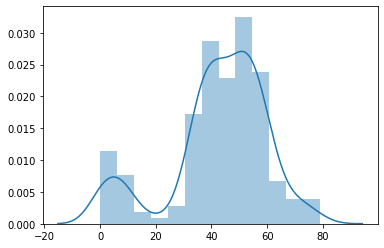

In [6]:
# graph number of days zero
cutoff = 25 # at most = 0
lstzero = []
skip_countries = []
for i in range(len(countries)):
    numz = find_zero(casesA[i,:].tolist())
    lstzero.append(numz)
    if numz > cutoff:
        skip_countries.append(i)

sns.distplot(np.array(lstzero));

In [7]:
len(skip_countries)

149

From the distribution, 30 seems a reasonable cutoff (most countries still present)

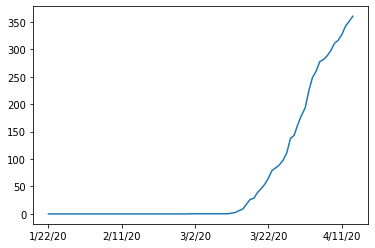

In [8]:
# plot 
#epoch = np.linspace(1, len(trainErr), len(trainErr))

cases.loc[50,:].plot.line()


In [9]:
case_train

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        2.52296317e-01, 2.52296317e-01, 2.52296317e-01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.04858300e+01, 4.95951417e+01, 5.06072874e+01],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        6.20342147e+00, 6.20342147e+00, 8.17723739e+00],
       ...,
       [3.02112385e-03, 3.02112385e-03, 6.04224770e-03, ...,
        7.36435192e+02, 8.32579437e+02, 9.33083164e+02],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        1.91862032e+05, 1.91862032e+05, 1.91862032e+05],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        4.39667807e+03, 4.39667807e+03, 4.39667807e+03]])

In [10]:
# log transform
case_test_log = np.log(case_test)
case_validation_log = np.log(case_validation)
case_train_log = np.log(case_train)
case_train_log

/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until
/space/home/nzhang/anaconda3/envs/neuralnet/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


array([[       -inf,        -inf,        -inf, ..., -1.37715102,
        -1.37715102, -1.37715102],
       [       -inf,        -inf,        -inf, ...,  3.70095204,
         3.90389288,  3.92409559],
       [       -inf,        -inf,        -inf, ...,  1.82510099,
         1.82510099,  2.10135437],
       ...,
       [-5.80212638, -5.80212638, -5.1089792 , ...,  6.60182124,
         6.72452864,  6.83849433],
       [       -inf,        -inf,        -inf, ..., 12.16453181,
        12.16453181, 12.16453181],
       [       -inf,        -inf,        -inf, ...,  8.38860455,
         8.38860455,  8.38860455]])

### Divide data into training sets
* specify number of days for train and prediction
* offset the dataset so for example: [1,2,3,4] then get [1,2],[2,3] which predicts 3 and 4 respectively

In [11]:
# test 
np.array(case_train[3,:])
#total_days-pred_days-t_days
case_train[3,5:8]

array([0., 0., 0.])

In [12]:
def clear_zero(nparray):
    # return the np array that contains only 1 0:
    lst = nparray.tolist()
    #print(len(lst))
    ind = 0
    splitInd = 0
    while(lst[ind]==0):
        splitInd += 1
        ind += 1
    #print(splitInd)
    return(np.array(lst[splitInd:]))

In [13]:
clear_zero(case_train[169,:]).shape[0]

74

In [14]:
def get_diff(arr):
    lst = arr.tolist()
    difflst = []
    for i in range(len(lst)):
        if i == 0:
            continue
        # start
        difflst.append(lst[i]-lst[i-1])
    return(np.array(difflst))

In [15]:
t_days = 25 # number of days used to test 
pred_days = test_d
total_days = case_train.shape[1]

country_train_X = []
country_train_Y = []

country_valid_X = []
country_valid_Y = []

country_test_X = []
country_test_Y = []

diffData = []
for i in range(len(countries)):
    print(countries[i] + " "+ str(i))
    
    if i in skip_countries:
        country_train_X.append(0)
        country_train_Y.append(0)

        country_valid_X.append(0)
        country_valid_Y.append(0)

        country_test_X.append(0)
        country_test_Y.append(0)
        diffData.append(0)
        continue # too little data 
        
    # split dataset
    cur_c = [] # current country 
    out = []
    
    cur_v = [] # current country 
    out_v = []
    
    cur_t = [] # current country 
    out_t = []
    
    newcase1 = clear_zero(case_train[i,:])
    #newcase = np.log(get_diff(newcase1)+1)
    newcase = get_diff(newcase1)
    total_days = newcase.shape[0]
    diffData.append(newcase)
    print(total_days)
    for j in range(total_days-pred_days*2-t_days): 
        
        #print(j)
        #print(case_train[i,j:j+t_days].shape)
        #print(len(case_train[i,j+t_days]))
        cur_c.append(newcase[j:j+t_days])
        #print(str(j))
        out.append(newcase[j+t_days:j+t_days+pred_days])
        #print(len(cur_c))
    
    country_train_X.append(cur_c)
    country_train_Y.append(out)
    
    country_valid_X.append(newcase[total_days-t_days-test_d*2:total_days-test_d*2])
    print(newcase[total_days-t_days-test_d*2:total_days-test_d*2].shape)
    country_valid_Y.append(newcase[total_days-test_d*2:total_days-test_d])
    print(newcase[total_days-test_d*2:total_days-test_d].shape)
    
    country_test_X.append(newcase[total_days-test_d-t_days:total_days-test_d])
    country_test_Y.append(newcase[total_days-test_d:])
    
    # the best way to check this
    #testlist = 


Burundi 0
Djibouti 1
Eritrea 2
Ethiopia 3
Kenya 4
Madagascar 5
Malawi 6
Mauritius 7
Mozambique 8
Rwanda 9
Seychelles 10
Somalia 11
South Sudan 12
Uganda 13
Tanzania 14
Zambia 15
Zimbabwe 16
Angola 17
Cameroon 18
Central African Republic 19
Chad 20
Equatorial Guinea 21
Gabon 22
Sao Tome and Principe 23
Botswana 24
Eswatini 25
Namibia 26
South Africa 27
Benin 28
Burkina Faso 29
Cabo Verde 30
Gambia 31
Ghana 32
Guinea 33
Guinea-Bissau 34
Liberia 35
Mali 36
Mauritania 37
Niger 38
Nigeria 39
Senegal 40
Sierra Leone 41
Togo 42
Algeria 43
Egypt 44
50
(25,)
(5,)
Libya 45
Morocco 46
Sudan 47
Tunisia 48
Western Sahara 49
Armenia 50
Azerbaijan 51
Bahrain 52
Cyprus 53
Georgia 54
Iraq 55
Israel 56
Jordan 57
Kuwait 58
Lebanon 59
Oman 60
Qatar 61
Saudi Arabia 62
Syria 63
Turkey 64
United Arab Emirates 65
66
(25,)
(5,)
Yemen 66
Kazakhstan 67
Kyrgyzstan 68
Uzbekistan 69
Afghanistan 70
Bangladesh 71
Bhutan 72
India 73
65
(25,)
(5,)
Iran 74
Maldives 75
Nepal 76
70
(25,)
(5,)
Pakistan 77
Sri Lanka 78
68
(

In [16]:
country_train_X[88][0].shape
country_train_X[81][0].shape

(25,)

In [17]:

diffData[81]

array([0.        , 0.        , 0.        , 0.01581322, 0.        ,
       0.02371983, 0.        , 0.03162644, 0.03162644, 0.03953305,
       0.        , 0.        , 0.01581322, 0.        , 0.        ,
       0.02371983, 0.        , 0.00790661, 0.        , 0.        ,
       0.01581322, 0.        , 0.00790661, 0.11069254, 0.12650575,
       0.05534627, 0.06325288, 0.0790661 , 0.0790661 , 0.08697271,
       0.13441236, 0.19766524, 0.09487932, 0.08697271, 0.15022558,
       0.19766524, 0.11069254, 0.10278593, 0.11859914, 0.14231897,
       0.15022558, 0.30045117, 0.22929168, 0.47439658, 0.324171  ,
       0.324171  , 0.07115949, 0.55346268, 0.45858336, 0.        ,
       0.4902098 , 0.5692759 , 0.52183624, 0.        , 0.30835778,
       0.08697271, 0.27673134, 0.30835778, 0.34789082, 0.74322131,
       0.21347846, 0.51392963, 0.9013535 , 0.63252877, 0.64043538,
       1.77898717, 1.36784347, 0.        , 0.68787504, 1.77898717,
       2.50639526, 0.96460638, 4.12725024])

In [18]:
import matplotlib.pyplot as plt
x = np.linspace(1, len(diffData[81].tolist()), len(diffData[81].tolist()))
plt.plot(x, diffData[81])
plt.show()

In [19]:
len(country_train_X)

172

In [20]:
# check dimension

#len(country_test_X[33])
total_days-pred_days-test_d
pred_days
test_d
total_days
case_train[0,29:64].shape
case_train[0,0:40].shape

(40,)

#### Data size & index
The first axis is the sequence itself, the second indexes instances in the mini-batch, and the third indexes elements of the input. We haven’t discussed mini-batching, so lets just ignore that and assume we will always have just 1 dimension on the second axis.

In [21]:
#import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

### Optimized hyperparameters
|Parameter |Description|Distribution/Selection|Values|
|----------|------------|----------------------|---------|
|Learning rate|Minimum learning rate| Discrete|1e-1 to 1e-7|
|Hidden layers|Number of layers in the network|Discrete numeric|1 to 5|
|Hidden state|Number of memory cell in each layer|Discrete numeric|1 to 200|
|Momentum|SGD optimizer parameter for overshoot direction|Discrete numeric|0.1 to 0.9|

In [22]:
# Parameter
num_epochs = 50 # max
batch_size = 1
# Loss and optimizer
criterion = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
learning_rate = 0.01 # to be changed/optimized 
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
output_directory = "mock/"
output_file_path = "mock/Train"
input_dim = t_days
hidden_dim = 2
hidden_state = 100
output_dim= pred_days
num_layers=2
lstm_input_size = t_days
#model = LSTM(lstm_input_size, hidden_dim, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)

model_name = "mock"
output_file_path = "./outputs/" + model_name + "/training/"
directory = os.path.dirname(output_file_path)
if not os.path.exists(directory):
    print("Creating directory %s" % output_file_path)
    os.makedirs(directory)
else:
     print("Directory %s exists" % output_file_path)


Directory ./outputs/mock/training/ exists


In [23]:
# RNN structure

class RNN(nn.Module):

    # you can also accept arguments in your model constructor
    def __init__(self, data_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size
        input_size = data_size + hidden_size

        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)

    def forward(self, data, last_hidden):
        input = torch.cat((data, last_hidden), 1)
        hidden = self.i2h(input)
        output = self.h2o(hidden)
        return hidden, output
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)


In [24]:
# LSTM structure

class LSTM(nn.Module):
 
    def __init__(self, input_dim, hidden_dim, batch_size, output_dim=pred_days,
                    num_layers=2):
        super(LSTM, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers
 
        # Define the LSTM layer
        self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers,dropout=0)
 
        # Define the output layer
        self.linear = nn.Linear(self.hidden_dim, output_dim)
 
    def init_hidden(self):
        # This is what we'll initialise our hidden state as
        return (torch.zeros(self.num_layers, self.batch_size, self.hidden_dim),
                torch.zeros(self.num_layers, self.batch_size, self.hidden_dim))
 
    def forward(self, input):
        # Forward pass through LSTM layer
        # shape of lstm_out: [input_size, batch_size, hidden_dim]
        # shape of self.hidden: (a, b), where a and b both 
        # have shape (num_layers, batch_size, hidden_dim).
        lstm_out, self.hidden = self.lstm(input.view(len(input), self.batch_size, -1))
        
        # Only take the output from the final timetep
        # Can pass on the entirety of lstm_out to the next layer if it is a seq2seq prediction
        y_pred = F.relu(self.linear(lstm_out[-1].view(self.batch_size, -1)))
        
        return y_pred.view(-1)

#model = LSTM(lstm_input_size, h1, batch_size=num_train, output_dim=output_dim, num_layers=num_layers)

In [25]:
# training function
def train_model(train_loader, test_loader, model, device, criterion, optimizer, num_epochs, output_directory,learning_rate,hidden_dim,num_layers,momentum):
    
    total_step = len(train_loader)
    model.train()
    model.hidden = model.init_hidden() # LSTM hidden reinitialization
    
    #open files to log error
    train_error = open(output_directory + "training_error"+ "_"+str(learning_rate)+ "_"+ str(hidden_dim) + "_"+ str(num_layers)+ "_"+ str(momentum) +".txt", "a")
    test_error = open(output_directory + "validation_error"+ "_"+str(learning_rate)+ "_"+ str(hidden_dim) + "_"+ str(num_layers) + "_"+ str(momentum)+".txt", "a")

    #best_model_wts = copy.deepcopy(model.state_dict())
    best_loss_valid = float('inf')
    best_epoch = 1

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for i, (seqs, labels) in enumerate(train_loader):
            #print(seqs.shape)
            # add gaussian noise to sequence
            noiselevel = torch.max(torch.tensor(country_train_X[2])).item()/1000
            noise = torch.abs(torch.randn(seqs.shape[0],seqs.shape[1],seqs.shape[2],seqs.shape[3])*noiselevel)
            #print(noise.shape)
            seqs += noise # add gaussian noise
            #print(seqs.shape)
            seqs = seqs.to(device)
            labels = labels.to(device)

            # Forward pass
            #seqs = seqs.squeeze()
            #print(seqs.shape)
            #print(model(seqs))
            outputs = model(seqs) # error 
            loss = criterion(outputs.squeeze(), labels.squeeze()) # change input to 
            running_loss += loss.item()
        
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #if (i+1) % 100 == 0:
            #    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
            #           .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

        #save training loss to file
        epoch_loss = running_loss / len(train_loader.dataset)
        print("%s, %s" % (epoch, epoch_loss), file=train_error)
        
        #calculate test loss for epoch
        test_loss = 0.0
        with torch.no_grad():
            model.eval()
            for i, (seqs, labels) in enumerate(test_loader):
                x = seqs.to(device)
                y = labels.to(device)
                outputs = model(x)
                #print(outputs.shape)
                #print(y.shape)
                loss = criterion(outputs.squeeze(), y.squeeze())
                test_loss += loss.item() 
                
                # for metrics
                #updateYlist(outputs,y)
                

        test_loss = test_loss / len(test_loader.dataset)
        
        #save outputs for epoch
        print("%s, %s" % (epoch, test_loss), file=test_error)
        
        # for each epoch, calculate metrics (f1, pr)
        #calculateMetrics(outputs,y)
        
        if test_loss < best_loss_valid:
            best_loss_valid = test_loss
            best_epoch = epoch
            best_model_wts = copy.deepcopy(model.state_dict())
            print ('Saving the best model weights at Epoch [{}], Best Valid Loss: {:.4f}' 
                       .format(epoch+1, best_loss_valid))

        
    train_error.close()
    test_error.close()

    #model.load_state_dict(best_model_wts)
    print("train error:", epoch_loss)
    return model, best_loss_valid


In [26]:
def test_model(test_loader, model, device,criterion):
    #predictions = torch.zeros(0, numClass)
    test_loss = 0.0
    
    with torch.no_grad():
        model.eval()
        for i, (seqs, labels) in enumerate(test_loader):            
            seqs = seqs.to(device)
            y = labels.to(device).float()
            print(y)
            pred = model(seqs).float()
            print(pred)
            loss = criterion(pred.squeeze(), y.squeeze())
            test_loss += loss.item() 
            
    return pred,test_loss

In [27]:
#dimension check
a = torch.tensor(country_train_X[81]) #torch.Size([19, 30, 1, 1])
# torch.tensor(country_valid_X[0]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).shape
# torch.tensor(country_valid_Y[0]).unsqueeze_(0).shape
# #torch.tensor(country_train_Y[0])
# torch.tensor(country_train_X[0])
# a.size(-1)
# torch.tensor(country_test_Y[0]).unsqueeze_(0).shape
# torch.tensor(country_valid_Y[0]).unsqueeze_(0).shape
# torch.tensor(country_train_Y[0]).unsqueeze_(1).shape
# #torch.tensor(country_valid_Y[0]).unsqueeze_(0).unsqueeze_(0).shape
# torch.tensor(country_train_Y[0]).unsqueeze_(1).shape
# torch.tensor(country_valid_Y[0]).unsqueeze_(0).shape
# torch.tensor(country_valid_X[0]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).shape
# torch.tensor(country_train_X[0]).unsqueeze_(2).unsqueeze_(2).shape
# torch.tensor(country_valid_X[0]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).shape

In [28]:
import matplotlib.pyplot as plt

graph_dir = "./graph_Offline8/"
directory = os.path.dirname(graph_dir)
if not os.path.exists(directory):
    print("Creating directory %s" % graph_dir)
    os.makedirs(directory)
else:
     print("Directory %s exists" % graph_dir)

def graph_country(index,prediction,outdir):
    
    # produce projection closeup & general graph
    # with label & title
    #print(prediction)
    data = diffData[index]
    newpred = prediction#.tolist()
    days = data.shape[0]
    
    # general trend
    x = np.linspace(1, len(data.tolist()), len(data.tolist()))
    y_real = data
    y_pred = data[:days-test_d].tolist()
    #print(len(y_pred))
    y_pred.extend(newpred)
    #print(len(y_pred))
    #print(len(y_real))
    y_pred = np.array(y_pred)
    plt.figure(index)
    plt.plot(x, y_real, label = "real")
    plt.plot(x, y_pred, label = "prediction")
    
    plt.xlabel('Days')
    plt.title(countries[index]+" trend")
    plt.savefig(outdir+countries[i]+"_general")
    plt.show()
    # specific plot
    
    x = np.linspace(1, len(data[days-test_d:].tolist()), len(data[days-test_d:].tolist()))
    y_real = data[days-test_d:]
    y_pred = newpred
    plt.figure(index*2)
    plt.plot(x, y_real, label = "real")
    plt.plot(x, y_pred, label = "prediction")
    
    plt.xlabel('Days')
    plt.title(countries[index]+" 5 days prediction")
    plt.savefig(outdir+countries[i]+"_specific")    
    plt.show()

Creating directory ./graph_Offline8/


In [29]:
# test if it runs
learning_rate = 0.01 # to be changed/optimized 
num_layers = 2
hidden_dim = 100
momentum = 0.1

net =  LSTM(lstm_input_size, hidden_dim, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)
print(net)
model = net.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)

train_dataset = torch.utils.data.TensorDataset(torch.tensor(country_train_X[81]).unsqueeze_(2).unsqueeze_(2).float(), torch.tensor(country_train_Y[81]).unsqueeze_(1).float())
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

# load validation
valid_dataset = torch.utils.data.TensorDataset(torch.tensor(country_valid_X[81]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).float(), torch.tensor(country_valid_Y[81]).unsqueeze_(0).float())
valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

# load test
test_dataset = torch.utils.data.TensorDataset(torch.tensor(country_test_X[81]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).float(), torch.tensor(country_test_Y[81]).unsqueeze_(0).float())
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


# mock trial
err = train_model(train_loader, valid_loader, model, device, criterion,  optimizer, num_epochs, output_file_path,learning_rate,hidden_dim, num_layers,momentum)



LSTM(
  (lstm): LSTM(25, 100, num_layers=2)
  (linear): Linear(in_features=100, out_features=5, bias=True)
)
Saving the best model weights at Epoch [1], Best Valid Loss: 0.9757
Saving the best model weights at Epoch [2], Best Valid Loss: 0.9531
Saving the best model weights at Epoch [3], Best Valid Loss: 0.9527
Saving the best model weights at Epoch [5], Best Valid Loss: 0.9389
Saving the best model weights at Epoch [32], Best Valid Loss: 0.9383
train error: 0.13399442701943612


tensor([[0.6879, 1.7790, 2.5064, 0.9646, 4.1273]], device='cuda:0')
tensor([0.2775, 0.0000, 0.0000, 0.3625, 0.0000], device='cuda:0')


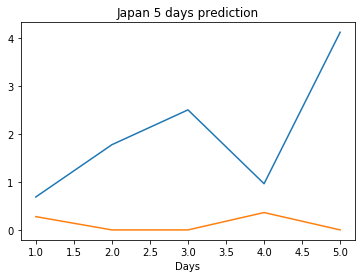

In [30]:
pred, loss = test_model(test_loader,model,device,criterion)
graph_country(81,pred.tolist(),graph_dir)

In [31]:
diffData[81].shape

(73,)

Directory ./offline8/Egypt/training/ exists
Egypt
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1363
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1288
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1261
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1255
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1251
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1250
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1249
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1249
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1249
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1249
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1249
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1248
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1247
Saving the best model weights at Epoch [22], Best Valid Los

Saving the best model weights at Epoch [50], Best Valid Loss: 0.0555
train error: 0.06773166606823604
0.05545545369386673
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0630
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0624
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0606
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0602
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0599
train error: 0.056741636556883655
0.05994433909654617
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1047
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0938
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0908
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0877
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0869
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0864
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0861
Savin

Saving the best model weights at Epoch [5], Best Valid Loss: 0.0569
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0562
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0553
train error: 0.06605173262457052
0.05525531992316246
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1060
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1031
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1020
train error: 0.08560600814719994
0.10203112661838531
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1130
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1090
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1084
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1080
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1079
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1077
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1076
Saving

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0709
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0696
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0694
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0694
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0684
train error: 0.07399136970440547
0.06842445582151413
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0958
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0949
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0926
train error: 0.08190089613199233
0.09261232614517212
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0840
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0707
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0654
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0632
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0613
Saving th

Saving the best model weights at Epoch [5], Best Valid Loss: 0.1399
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1390
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1381
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1374
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1369
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1364
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1359
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1356
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1353
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1350
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1348
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1346
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1345
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1344
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [1], Best Valid Loss: 0.1112
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1064
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1029
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1004
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0980
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0959
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0943
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0930
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0918
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0910
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0901
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0894
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0889
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0884
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [21], Best Valid Loss: 0.0673
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0658
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0643
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0632
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0623
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0613
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0608
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0605
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0600
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0596
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0591
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0590
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0589
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0586
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.1076
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1076
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1076
train error: 0.08626476985712846
0.10759534686803818
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1240
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1067
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1006
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0993
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0982
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0981
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0981
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0975
train error: 0.08760902980963389
0.09746294468641281
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1124
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1070
Savi

Saving the best model weights at Epoch [38], Best Valid Loss: 0.0711
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0710
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0708
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0707
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0706
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0705
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0704
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0703
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0702
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0701
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0701
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0700
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0699
train error: 0.06518502309918403
0.06993661820888519
Saving the best model weights at Epoch [1], Best V

Saving the best model weights at Epoch [16], Best Valid Loss: 0.1016
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1014
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1012
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1008
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1006
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1004
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1003
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1002
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1001
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1000
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0999
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0998
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0997
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0996
Saving the best model weights at E

train error: 0.06472596898674965
0.057555414736270905
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1211
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1039
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0977
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0957
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0954
train error: 0.0860167163113753
0.09538601338863373
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1144
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1100
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1060
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1026
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0996
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0969
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0946
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0925
Saving the

Saving the best model weights at Epoch [24], Best Valid Loss: 0.0927
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0922
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0918
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0914
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0910
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0907
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0904
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0901
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0899
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0896
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0894
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0892
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0890
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0888
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 0.0113
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0110
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0108
train error: 0.03059297731767098
0.010772104375064373
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1254
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1097
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1058
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1046
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1042
train error: 0.08109036640574535
0.10420836508274078
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1248
Sa

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0952
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0945
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0938
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0932
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0927
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0922
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0917
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0913
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0909
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0906
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0903
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0900
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0897
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0895
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.1166
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1114
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1073
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1037
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1010
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0988
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0970
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0955
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0941
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0931
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0922
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0916
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0908
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0902
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [39], Best Valid Loss: 0.0871
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0869
train error: 0.08075165270517269
0.0869111567735672
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1234
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1106
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1056
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1038
train error: 0.08381030081460873
0.1037626639008522
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1390
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1352
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1318
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1288
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1262
Saving t

Saving the best model weights at Epoch [14], Best Valid Loss: 0.0724
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0715
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0706
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0698
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0690
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0683
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0677
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0672
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0667
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0662
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0658
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0654
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0651
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0647
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.1130
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1045
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0971
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0916
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0870
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0835
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0804
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0780
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0761
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0744
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0732
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0719
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0710
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0703
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [29], Best Valid Loss: 0.0665
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0662
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0662
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0661
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0661
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0660
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0659
train error: 0.06251250974213084
0.06588643044233322
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1248
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1106
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1057
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1048
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1043
train error: 0.08114753548676769
0.10426397621631622
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1470
Sav

Saving the best model weights at Epoch [12], Best Valid Loss: 0.0848
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0843
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0838
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0832
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0827
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0822
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0817
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0813
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0808
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0803
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0798
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0794
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0789
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0785
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.0413
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0411
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0410
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0408
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0408
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0407
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0406
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0406
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0404
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0404
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0403
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0403
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0402
train error: 0.04868184644728899
0.04017399623990059
Saving the best model weights at Epoch [1], Best V

Saving the best model weights at Epoch [6], Best Valid Loss: 0.1207
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1183
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1162
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1145
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1131
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1116
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1104
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1092
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1081
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1072
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1064
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1058
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1052
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1045
Saving the best model weights at Epoch

Saving the best model weights at Epoch [29], Best Valid Loss: 0.1086
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1079
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1072
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1065
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1058
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1051
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1044
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1038
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1031
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1025
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1019
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1013
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1008
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1002
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.1058
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1053
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1048
train error: 0.08352576829493046
0.1048426628112793
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1358
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1334
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1307
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1282
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1257
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1233
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1210
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1187
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1163
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1141
Saving the best model weights at Epoch [11], Best Valid Loss

Saving the best model weights at Epoch [18], Best Valid Loss: 0.1313
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1310
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1307
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1304
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1301
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1297
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1294
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1291
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1288
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1285
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1282
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1279
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1277
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1274
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 0.0698
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0698
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0697
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0697
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0696
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0696
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0695
train error: 0.06503286386529604
0.06949508190155029
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1439
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1438
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1436
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1434
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1432
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1430
Saving the best model weights at Epoch [7], Best Valid L

Saving the best model weights at Epoch [12], Best Valid Loss: 0.1081
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1073
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1067
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1062
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1055
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1050
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1045
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1043
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1039
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1035
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1032
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1028
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1025
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1024
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 0.1238
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1234
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1231
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1228
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1224
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1221
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1218
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1215
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1213
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1210
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1207
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1204
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1202
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1199
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.1207
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1154
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1104
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1058
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1015
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0978
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0945
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0914
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0886
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0862
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0841
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0821
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0803
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0786
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [20], Best Valid Loss: 0.1241
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1234
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1228
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1222
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1216
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1210
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1205
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1199
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1194
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1188
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1183
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1178
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1173
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1168
Saving the best model weights at E

Saving the best model weights at Epoch [41], Best Valid Loss: 0.0708
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0705
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0702
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0699
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0696
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0693
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0690
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0687
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0684
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0681
train error: 0.05837340404589971
0.06808271259069443
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1081
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1075
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1068
Saving the best model weights at Epoch [4], Best Vali

Saving the best model weights at Epoch [9], Best Valid Loss: 0.1293
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1289
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1286
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1283
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1280
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1277
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1274
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1271
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1268
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1266
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1263
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1257
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1255
Saving the best model weights at Ep

Saving the best model weights at Epoch [28], Best Valid Loss: 0.0754
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0749
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0747
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0743
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0740
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0738
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0735
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0733
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0730
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0728
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0727
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0725
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0723
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0722
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 0.1088
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1084
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1080
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1076
train error: 0.09080344761411349
0.10764160007238388
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1442
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1403
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1366
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1330
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1298
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1272
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1245
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1225
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1204
Saving the best model weights at Epoch [10], Best Valid Los

Saving the best model weights at Epoch [16], Best Valid Loss: 0.1345
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1345
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1345
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1344
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1344
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1344
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1344
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1344
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1344
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1344
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1343
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1343
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1343
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1343
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.0918
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0914
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0909
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0905
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0901
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0896
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0892
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0888
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0884
train error: 0.06994598925424118
0.0883861631155014
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1307
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1287
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1269
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1251
Saving the best model weights at Epoch [5], Best Valid 

Saving the best model weights at Epoch [15], Best Valid Loss: 0.0993
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0985
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0978
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0971
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0964
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0958
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0951
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0944
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0938
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0931
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0925
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0918
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0912
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0906
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.1340
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1340
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1340
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1339
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1339
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1339
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1339
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1339
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1339
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1339
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1339
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1339
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1339
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1339
train error: 0.09970900425687432
0

Saving the best model weights at Epoch [4], Best Valid Loss: 0.0771
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0770
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0769
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0768
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0767
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0766
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0765
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0764
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0763
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0762
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0761
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0760
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0759
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0759
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [28], Best Valid Loss: 0.1074
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1071
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1067
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1064
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1060
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1057
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1053
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1050
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1046
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1043
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1040
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1037
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1033
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1030
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.0665
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0664
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0664
train error: 0.06243945425376296
0.06636376678943634
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1209
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1204
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1198
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1193
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1188
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1183
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1177
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1172
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1167
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1162
Saving the best model weights at Epoch [11], Best Valid Los

Saving the best model weights at Epoch [15], Best Valid Loss: 0.0601
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0581
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0562
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0549
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0536
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0527
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0514
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0505
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0496
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0488
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0482
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0476
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0468
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0464
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.0841
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0832
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0824
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0817
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0809
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0801
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0793
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0786
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0779
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0772
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0765
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0758
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0752
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0745
Saving the best model weights at E

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0987
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0987
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0987
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0987
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0987
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0987
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0987
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0987
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0987
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0987
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0987
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0987
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0987
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0987
Saving the best model weights at Epoch

Saving the best model weights at Epoch [24], Best Valid Loss: 0.1288
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1287
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1287
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1287
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1286
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1285
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1285
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1284
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1283
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1283
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1282
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1281
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1281
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1280
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.1149
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1147
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1145
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1143
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1141
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1139
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1137
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1135
train error: 0.0878936264043053
0.11347190290689468
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1148
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1148
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1147
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1147
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1146
Saving the best model weights at Epoch [6], Best Valid L

Saving the best model weights at Epoch [10], Best Valid Loss: 0.1509
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1507
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1505
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1502
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1500
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1498
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1496
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1494
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1492
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1489
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1488
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1485
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1483
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1482
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.1401
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1400
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1399
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1398
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1397
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1396
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1395
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1394
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1393
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1392
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1391
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1390
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1390
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1389
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.1450
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1450
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1449
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1449
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1448
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1448
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1448
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1447
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1447
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1447
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1446
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1446
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1445
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1445
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [20], Best Valid Loss: 0.1430
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1429
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1429
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1429
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1429
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1429
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1428
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1428
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1428
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1428
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1428
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1428
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1427
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1427
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 0.1185
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1183
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1182
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1180
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1178
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1177
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1175
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1174
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1172
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1170
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1169
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1167
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1166
train error: 0.0972359744211038
0.1165611520409584
Saving the best model weights at Epoch [1], Best Val

Saving the best model weights at Epoch [5], Best Valid Loss: 0.1418
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1414
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1410
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1407
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1403
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1398
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1394
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1391
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1387
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1383
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1379
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1376
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1372
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1369
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [23], Best Valid Loss: 0.1238
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1237
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1235
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1233
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1231
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1230
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1228
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1226
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1224
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1223
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1221
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1219
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1217
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1216
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.0669
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0669
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0669
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0669
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0668
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0668
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0668
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0668
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0668
train error: 0.059893137340744335
0.0667664036154747
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1040
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1039
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1039
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1039
Saving the best model weights at Epoch [5], Best Valid

Saving the best model weights at Epoch [13], Best Valid Loss: 0.1267
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1266
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1265
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1264
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1264
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1263
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1262
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1262
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1261
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1259
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1259
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1258
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1257
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.1352
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1349
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1346
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1344
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1341
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1338
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1335
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1333
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1330
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1327
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1324
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1322
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1319
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1317
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.1211
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1206
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1201
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1197
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1192
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1188
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1183
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1178
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1174
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1169
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1165
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1161
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1156
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1152
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [19], Best Valid Loss: 0.1319
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1318
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1317
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1316
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1316
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1315
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1314
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1313
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1312
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1311
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1310
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1309
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1309
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1308
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 0.1324
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1324
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1324
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1324
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1324
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1324
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1324
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1324
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1324
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1323
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1323
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1323
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1323
train error: 0.10462812917927901
0.13232314586639404
Saving the best model weights at Epoch [1], Best V

Saving the best model weights at Epoch [6], Best Valid Loss: 0.1520
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1520
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1520
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1520
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1519
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1519
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1519
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1519
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1518
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1518
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1518
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1518
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1517
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1517
Saving the best model weights at Epoch

Saving the best model weights at Epoch [24], Best Valid Loss: 0.1118
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1114
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1111
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1107
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1103
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1100
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1097
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1093
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1090
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1087
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1083
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1080
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1077
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1074
Saving the best model weights at E

Saving the best model weights at Epoch [45], Best Valid Loss: 0.1379
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1378
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1378
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1377
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1376
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1376
train error: 0.10518621516724427
0.13756386935710907
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1438
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1437
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1436
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1435
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1433
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1432
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1431
Saving the best model weights at Epoch [8], Best Valid Lo

Saving the best model weights at Epoch [12], Best Valid Loss: 0.1383
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1383
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1382
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1381
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1380
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1379
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1379
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1378
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1377
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1376
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1376
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1375
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1374
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1373
Saving the best model weights at E

Saving the best model weights at Epoch [31], Best Valid Loss: 0.1339
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1339
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1339
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1338
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1338
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1337
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1337
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1337
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1336
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1336
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1335
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1335
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1335
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1334
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 0.1044
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1044
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1043
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1043
train error: 0.08424809239804745
0.10429663956165314
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1175
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1174
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1172
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1171
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1169
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1167
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1166
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1164
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1163
Saving the best model weights at Epoch [10], Best Valid Los

Saving the best model weights at Epoch [15], Best Valid Loss: 0.1280
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1280
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1279
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1279
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1279
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1278
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1278
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1278
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1277
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1277
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1277
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1276
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1276
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1276
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 0.0965
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0959
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0953
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0947
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0941
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0935
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0929
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0923
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0917
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0912
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0906
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0900
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0895
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0889
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.1228
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1221
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1215
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1209
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1202
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1196
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1190
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1184
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1178
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1172
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1166
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1160
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1155
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1149
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [19], Best Valid Loss: 0.0659
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0659
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0659
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0659
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0659
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0658
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0658
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0658
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0658
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0657
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0657
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0657
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0657
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0656
Saving the best model weights at E

Saving the best model weights at Epoch [37], Best Valid Loss: 0.1092
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1092
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1092
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1091
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1090
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1090
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1090
train error: 0.08969278130680322
0

Saving the best model weights at Epoch [4], Best Valid Loss: 0.1432
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1432
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1432
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1432
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1432
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1432
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1431
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1431
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1431
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1431
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1431
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1431
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1431
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1431
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [22], Best Valid Loss: 0.1353
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1352
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1352
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1352
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1352
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1352
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1352
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1352
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1352
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1352
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1352
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1352
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1352
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1352
Saving the best model weights at E

Saving the best model weights at Epoch [41], Best Valid Loss: 0.1528
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1527
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1527
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1527
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1526
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1526
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1526
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1525
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1525
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1524
train error: 0.11867946945130825
0.15244050323963165
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1326
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1326
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1326
Saving the best model weights at Epoch [4], Best Vali

Saving the best model weights at Epoch [8], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1260
Saving the best model weights at Epo

Saving the best model weights at Epoch [31], Best Valid Loss: 0.1246
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1246
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1246
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1246
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1246
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1245
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1245
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1245
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1245
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1245
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1245
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1245
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1245
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1244
Saving the best model weights at E

Saving the best model weights at Epoch [50], Best Valid Loss: 0.1370
train error: 0.10820626008013884
0.1370178759098053
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1063
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1063
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1063
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1062
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1062
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1062
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1062
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1062
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1062
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1062
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1062
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1062
Saving the best model weights at Epoch [13], Best Valid Loss

Saving the best model weights at Epoch [17], Best Valid Loss: 0.1414
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1414
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1414
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1414
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1414
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1414
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1414
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1414
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1414
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1414
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1414
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1413
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1413
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1413
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 0.1265
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1264
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1264
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1263
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1263
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1262
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1262
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1261
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1261
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1259
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1259
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1258
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0996
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0995
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0995
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0994
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0994
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0993
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0993
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0992
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0992
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0991
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0991
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0990
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0990
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0989
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [20], Best Valid Loss: 0.1263
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1263
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1263
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1263
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1263
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1263
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1262
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1262
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1262
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1262
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1262
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1262
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1262
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1262
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 0.1024
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1024
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1024
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1024
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1024
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1024
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1024
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1023
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1023
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1023
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1023
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1023
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1023
train error: 0.08182058352977037
0.10231943428516388
Saving the best model weights at Epoch [1], Best V

Saving the best model weights at Epoch [5], Best Valid Loss: 0.1347
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1347
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1347
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1346
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1346
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1346
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1346
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1346
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1346
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1346
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1346
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1346
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1346
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1346
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [24], Best Valid Loss: 0.1480
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1480
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1479
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1479
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1479
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1478
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1478
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1478
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1478
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1477
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1477
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1477
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1476
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1476
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.1234
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1234
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1234
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1234
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1234
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1234
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1234
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1234
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1234
train error: 0.10449684460957845
0.12339828163385391
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0923
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0923
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0922
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0922
Saving the best model weights at Epoch [5], Best Valid

Saving the best model weights at Epoch [10], Best Valid Loss: 0.1390
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1390
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1389
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1389
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1389
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1388
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1388
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1387
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1387
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1387
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1386
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1386
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1386
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1385
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 0.1003
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1003
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1003
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1003
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1003
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1003
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1002
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1002
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1002
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1002
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1002
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1002
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1002
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1002
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.1481
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1481
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1481
train error: 0.11599335273106894
0.1481180340051651
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1286
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1286
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1286
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1286
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1285
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1285
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1285
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1285
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1285
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1284
Saving the best model weights at Epoch [11], Best Valid Loss

Saving the best model weights at Epoch [16], Best Valid Loss: 0.0925
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0925
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0925
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0925
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0925
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0925
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0925
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0925
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0924
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0924
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0924
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0924
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0924
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0924
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.1077
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1077
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1076
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1076
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1076
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1075
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1075
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1075
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1074
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1074
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1074
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1073
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1073
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1073
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.1179
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1179
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1179
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1179
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1178
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1178
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1178
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1178
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1178
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1177
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1177
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1177
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1177
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1177
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [20], Best Valid Loss: 0.1290
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1290
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1290
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1290
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1290
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1290
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1290
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1290
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1290
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1290
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1289
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1289
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1289
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1289
Saving the best model weights at E

Saving the best model weights at Epoch [36], Best Valid Loss: 0.1334
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1334
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1334
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1333
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1333
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1333
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1333
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1333
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1333
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1333
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1332
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1332
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1332
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1332
Saving the best model weights at E

Saving the best model weights at Epoch [7], Best Valid Loss: 0.1477
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1477
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1477
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1477
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1477
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1477
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1477
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1477
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1477
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1477
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1477
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1477
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1477
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1477
Saving the best model weights at Epoc

Saving the best model weights at Epoch [25], Best Valid Loss: 0.1313
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1313
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1313
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1313
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1313
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1313
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1313
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1313
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1313
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1313
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1313
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1313
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1313
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1313
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.1383
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1383
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1383
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1383
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1383
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1383
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1383
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1383
train error: 0.1089991162220637
0.1382586807012558
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1255
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1255
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1255
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1255
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1255
Saving the best model weights at Epoch [6], Best Valid Lo

Saving the best model weights at Epoch [11], Best Valid Loss: 0.1163
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1163
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1163
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1163
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1163
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1163
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1163
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1163
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1163
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1163
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1163
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1163
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1163
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1163
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 0.1499
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1499
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1499
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1499
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1499
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1499
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1499
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1499
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1499
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1499
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1499
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1499
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1499
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1499
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 0.0970
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0970
train error: 0.08233151050905387
0.09704553335905075
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0627
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0627
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0627
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0627
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0627
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0627
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0627
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0627
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0627
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0627
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0627
Saving the best model weights at Epoch [12], Best Valid Los

Saving the best model weights at Epoch [17], Best Valid Loss: 0.1468
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1468
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1468
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1468
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1468
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1468
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1468
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1468
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1468
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1468
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1468
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1468
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1468
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1468
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 0.1244
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1244
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1244
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1244
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1244
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1244
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1244
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1244
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1244
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1244
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1244
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1244
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1244
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1244
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.1496
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1496
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1496
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1496
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1496
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1496
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1496
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1496
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1495
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1495
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1495
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1495
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1495
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1495
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [20], Best Valid Loss: 0.1247
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1247
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1247
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1247
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1247
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1247
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1247
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1247
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1247
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1247
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1247
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1247
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1247
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1247
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 0.1471
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1471
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1471
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1471
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1471
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1471
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1471
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1471
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1471
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1471
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1471
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1471
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1471
train error: 0.11561095702151457
0.14710457623004913
Saving the best model weights at Epoch [1], Best V

Saving the best model weights at Epoch [6], Best Valid Loss: 0.1280
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1280
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1280
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1280
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1280
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1280
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1280
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1280
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1280
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1280
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1280
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1280
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1280
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1280
Saving the best model weights at Epoch

Saving the best model weights at Epoch [25], Best Valid Loss: 0.1477
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1477
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1477
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1477
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1477
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1477
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1477
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1476
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1476
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1476
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1476
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1476
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1476
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1476
Saving the best model weights at E

Saving the best model weights at Epoch [46], Best Valid Loss: 0.1051
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1051
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1051
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1051
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1051
train error: 0.08202604549005628
0.10509929805994034
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1350
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1350
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1350
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1350
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1349
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1349
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1349
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1349
Saving the best model weights at Epoch [9], Best Valid Los

Saving the best model weights at Epoch [13], Best Valid Loss: 0.1335
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1335
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1335
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1335
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1335
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1335
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1335
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1335
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1335
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1335
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1335
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1335
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1335
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1335
Saving the best model weights at E

Saving the best model weights at Epoch [31], Best Valid Loss: 0.1216
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1216
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1216
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1216
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1216
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1216
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1216
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1216
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1216
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1216
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1216
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1216
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1216
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1216
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 0.1112
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1112
train error: 0.08556796330958605
0.1111755520105362
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1228
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1228
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1228
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1228
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1228
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1227
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1227
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1227
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1227
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1227
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1227
Saving the best model weights at Epoch [12], Best Valid Loss

Saving the best model weights at Epoch [16], Best Valid Loss: 0.1251
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1251
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1251
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1251
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1251
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1251
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1251
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1251
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1251
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1251
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1251
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1251
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1251
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1251
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [40], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [41], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [42], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [43], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [44], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1260
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1260
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.1528
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1528
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1528
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1528
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1528
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1528
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1528
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1528
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1528
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1528
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1528
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1528
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1528
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1528
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [21], Best Valid Loss: 0.1160
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1160
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1160
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1160
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1160
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1160
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1160
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1160
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1160
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1160
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1160
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1160
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1160
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1160
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 0.0839
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0839
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0839
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0839
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0839
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0839
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0839
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0839
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0839
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0839
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0839
train error: 0.07448791886369387
0.08385361731052399
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1103
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1103
Saving the best model weights at Epoch [3], Best Val

Saving the best model weights at Epoch [8], Best Valid Loss: 0.1277
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1277
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1277
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1277
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1277
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1277
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1277
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1277
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1277
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1277
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1277
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1277
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1277
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1277
Saving the best model weights at Epo

Saving the best model weights at Epoch [26], Best Valid Loss: 0.1076
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1076
Saving the best model weights at Epoch [28], Best Valid Loss: 0.1076
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1076
Saving the best model weights at Epoch [30], Best Valid Loss: 0.1076
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1076
Saving the best model weights at Epoch [32], Best Valid Loss: 0.1076
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1076
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1076
Saving the best model weights at Epoch [35], Best Valid Loss: 0.1076
Saving the best model weights at Epoch [36], Best Valid Loss: 0.1076
Saving the best model weights at Epoch [37], Best Valid Loss: 0.1076
Saving the best model weights at Epoch [38], Best Valid Loss: 0.1076
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1076
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 0.1399
Saving the best model weights at Epoch [45], Best Valid Loss: 0.1399
Saving the best model weights at Epoch [46], Best Valid Loss: 0.1399
Saving the best model weights at Epoch [47], Best Valid Loss: 0.1399
Saving the best model weights at Epoch [48], Best Valid Loss: 0.1399
Saving the best model weights at Epoch [49], Best Valid Loss: 0.1399
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1399
train error: 0.11032554643849532
0.1399022787809372
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1357
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1357
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1357
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1357
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1357
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1357
Saving the best model weights at Epoch [7], Best Valid Lo

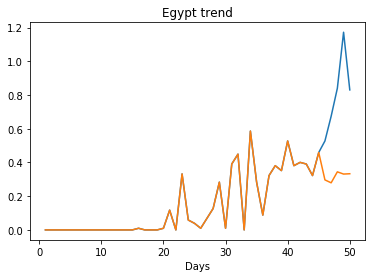

Creating directory ./offline8/United Arab Emirates/training/
United Arab Emirates
Saving the best model weights at Epoch [1], Best Valid Loss: 41.6195
Saving the best model weights at Epoch [2], Best Valid Loss: 41.1917
Saving the best model weights at Epoch [3], Best Valid Loss: 39.9439
Saving the best model weights at Epoch [4], Best Valid Loss: 37.5130
Saving the best model weights at Epoch [5], Best Valid Loss: 33.1217
Saving the best model weights at Epoch [7], Best Valid Loss: 31.8725
Saving the best model weights at Epoch [10], Best Valid Loss: 25.2128
Saving the best model weights at Epoch [11], Best Valid Loss: 24.8411
Saving the best model weights at Epoch [12], Best Valid Loss: 22.6612
Saving the best model weights at Epoch [13], Best Valid Loss: 19.3069
Saving the best model weights at Epoch [15], Best Valid Loss: 19.1961
Saving the best model weights at Epoch [19], Best Valid Loss: 14.1276
train error: 0.19367500550992367
14.127580642700195
Saving the best model weights at

Saving the best model weights at Epoch [2], Best Valid Loss: 31.9279
Saving the best model weights at Epoch [3], Best Valid Loss: 31.7389
Saving the best model weights at Epoch [4], Best Valid Loss: 31.3048
Saving the best model weights at Epoch [5], Best Valid Loss: 28.1026
Saving the best model weights at Epoch [6], Best Valid Loss: 22.6407
Saving the best model weights at Epoch [7], Best Valid Loss: 20.3412
Saving the best model weights at Epoch [13], Best Valid Loss: 20.0228
Saving the best model weights at Epoch [14], Best Valid Loss: 17.3563
Saving the best model weights at Epoch [16], Best Valid Loss: 13.5365
Saving the best model weights at Epoch [24], Best Valid Loss: 7.9329
train error: 0.32644233436534004
7.932904243469238
Saving the best model weights at Epoch [1], Best Valid Loss: 43.5861
Saving the best model weights at Epoch [8], Best Valid Loss: 43.4498
Saving the best model weights at Epoch [9], Best Valid Loss: 40.8889
Saving the best model weights at Epoch [10], Best

train error: 6.964338148313184
42.0716438293457
Saving the best model weights at Epoch [1], Best Valid Loss: 38.8240
Saving the best model weights at Epoch [2], Best Valid Loss: 38.5256
Saving the best model weights at Epoch [3], Best Valid Loss: 38.4727
Saving the best model weights at Epoch [5], Best Valid Loss: 38.3697
Saving the best model weights at Epoch [7], Best Valid Loss: 38.0463
Saving the best model weights at Epoch [22], Best Valid Loss: 37.2361
Saving the best model weights at Epoch [23], Best Valid Loss: 35.7438
Saving the best model weights at Epoch [24], Best Valid Loss: 26.9091
Saving the best model weights at Epoch [25], Best Valid Loss: 26.6805
Saving the best model weights at Epoch [27], Best Valid Loss: 25.3186
Saving the best model weights at Epoch [28], Best Valid Loss: 23.7719
Saving the best model weights at Epoch [30], Best Valid Loss: 17.6931
Saving the best model weights at Epoch [32], Best Valid Loss: 17.2809
Saving the best model weights at Epoch [33], Be

Saving the best model weights at Epoch [46], Best Valid Loss: 28.1497
train error: 5.260787588934744
28.14969253540039
Saving the best model weights at Epoch [1], Best Valid Loss: 40.6040
Saving the best model weights at Epoch [2], Best Valid Loss: 40.1840
Saving the best model weights at Epoch [12], Best Valid Loss: 40.1014
Saving the best model weights at Epoch [14], Best Valid Loss: 39.8379
train error: 6.5255582616213825
39.83786392211914
Saving the best model weights at Epoch [1], Best Valid Loss: 38.4610
Saving the best model weights at Epoch [2], Best Valid Loss: 35.1447
train error: 6.964338148313184
35.144657135009766
Saving the best model weights at Epoch [1], Best Valid Loss: 39.6622
Saving the best model weights at Epoch [2], Best Valid Loss: 38.9414
Saving the best model weights at Epoch [3], Best Valid Loss: 38.2462
Saving the best model weights at Epoch [4], Best Valid Loss: 37.8364
Saving the best model weights at Epoch [5], Best Valid Loss: 37.7900
Saving the best mode

train error: 0.1481552486037535
8.87909984588623
Saving the best model weights at Epoch [1], Best Valid Loss: 42.0552
Saving the best model weights at Epoch [2], Best Valid Loss: 39.9526
Saving the best model weights at Epoch [3], Best Valid Loss: 37.9193
Saving the best model weights at Epoch [4], Best Valid Loss: 35.8105
Saving the best model weights at Epoch [5], Best Valid Loss: 33.7924
Saving the best model weights at Epoch [6], Best Valid Loss: 31.6996
Saving the best model weights at Epoch [7], Best Valid Loss: 29.0283
Saving the best model weights at Epoch [8], Best Valid Loss: 26.4707
Saving the best model weights at Epoch [9], Best Valid Loss: 24.2128
Saving the best model weights at Epoch [10], Best Valid Loss: 22.1090
Saving the best model weights at Epoch [11], Best Valid Loss: 20.2320
Saving the best model weights at Epoch [12], Best Valid Loss: 18.6228
Saving the best model weights at Epoch [13], Best Valid Loss: 17.1764
Saving the best model weights at Epoch [14], Best 

train error: 0.4599082318825661
14.12609577178955
Saving the best model weights at Epoch [1], Best Valid Loss: 42.1078
Saving the best model weights at Epoch [2], Best Valid Loss: 41.0587
Saving the best model weights at Epoch [3], Best Valid Loss: 40.1507
Saving the best model weights at Epoch [4], Best Valid Loss: 39.3739
Saving the best model weights at Epoch [5], Best Valid Loss: 38.7510
Saving the best model weights at Epoch [6], Best Valid Loss: 38.1734
Saving the best model weights at Epoch [7], Best Valid Loss: 37.7155
Saving the best model weights at Epoch [8], Best Valid Loss: 37.3231
Saving the best model weights at Epoch [9], Best Valid Loss: 36.9969
Saving the best model weights at Epoch [10], Best Valid Loss: 36.7009
Saving the best model weights at Epoch [11], Best Valid Loss: 36.4263
Saving the best model weights at Epoch [12], Best Valid Loss: 36.2088
Saving the best model weights at Epoch [13], Best Valid Loss: 36.0514
Saving the best model weights at Epoch [14], Best

train error: 1.0397605351623027
12.728946685791016
Saving the best model weights at Epoch [1], Best Valid Loss: 41.1291
Saving the best model weights at Epoch [2], Best Valid Loss: 39.8321
Saving the best model weights at Epoch [3], Best Valid Loss: 38.7154
Saving the best model weights at Epoch [4], Best Valid Loss: 37.7536
Saving the best model weights at Epoch [5], Best Valid Loss: 36.9519
Saving the best model weights at Epoch [6], Best Valid Loss: 36.2715
Saving the best model weights at Epoch [7], Best Valid Loss: 35.7101
Saving the best model weights at Epoch [8], Best Valid Loss: 35.1668
Saving the best model weights at Epoch [9], Best Valid Loss: 34.7663
Saving the best model weights at Epoch [10], Best Valid Loss: 34.3973
Saving the best model weights at Epoch [11], Best Valid Loss: 34.0363
Saving the best model weights at Epoch [12], Best Valid Loss: 33.7504
Saving the best model weights at Epoch [13], Best Valid Loss: 33.5053
Saving the best model weights at Epoch [14], Bes

Saving the best model weights at Epoch [10], Best Valid Loss: 38.8123
Saving the best model weights at Epoch [11], Best Valid Loss: 38.6617
Saving the best model weights at Epoch [12], Best Valid Loss: 38.5249
Saving the best model weights at Epoch [13], Best Valid Loss: 38.4255
Saving the best model weights at Epoch [14], Best Valid Loss: 38.3364
Saving the best model weights at Epoch [15], Best Valid Loss: 38.2249
Saving the best model weights at Epoch [16], Best Valid Loss: 38.1397
Saving the best model weights at Epoch [17], Best Valid Loss: 38.0585
Saving the best model weights at Epoch [18], Best Valid Loss: 37.9982
Saving the best model weights at Epoch [19], Best Valid Loss: 37.9193
Saving the best model weights at Epoch [20], Best Valid Loss: 37.8830
Saving the best model weights at Epoch [21], Best Valid Loss: 37.8358
Saving the best model weights at Epoch [22], Best Valid Loss: 37.8180
Saving the best model weights at Epoch [23], Best Valid Loss: 37.7638
Saving the best mode

Saving the best model weights at Epoch [19], Best Valid Loss: 34.8498
Saving the best model weights at Epoch [20], Best Valid Loss: 34.7614
Saving the best model weights at Epoch [21], Best Valid Loss: 34.6673
Saving the best model weights at Epoch [22], Best Valid Loss: 34.5400
Saving the best model weights at Epoch [23], Best Valid Loss: 34.4641
Saving the best model weights at Epoch [24], Best Valid Loss: 34.3636
Saving the best model weights at Epoch [25], Best Valid Loss: 34.2409
Saving the best model weights at Epoch [26], Best Valid Loss: 34.1695
Saving the best model weights at Epoch [27], Best Valid Loss: 34.0707
Saving the best model weights at Epoch [28], Best Valid Loss: 33.9861
Saving the best model weights at Epoch [29], Best Valid Loss: 33.8766
Saving the best model weights at Epoch [30], Best Valid Loss: 33.7550
Saving the best model weights at Epoch [31], Best Valid Loss: 33.6206
Saving the best model weights at Epoch [32], Best Valid Loss: 33.5147
Saving the best mode

Saving the best model weights at Epoch [12], Best Valid Loss: 30.0882
Saving the best model weights at Epoch [13], Best Valid Loss: 30.0788
Saving the best model weights at Epoch [14], Best Valid Loss: 29.8955
Saving the best model weights at Epoch [15], Best Valid Loss: 29.8537
Saving the best model weights at Epoch [16], Best Valid Loss: 29.7970
Saving the best model weights at Epoch [19], Best Valid Loss: 29.7918
Saving the best model weights at Epoch [20], Best Valid Loss: 29.7517
Saving the best model weights at Epoch [21], Best Valid Loss: 29.7487
Saving the best model weights at Epoch [23], Best Valid Loss: 29.7328
Saving the best model weights at Epoch [37], Best Valid Loss: 29.7173
Saving the best model weights at Epoch [38], Best Valid Loss: 29.6462
Saving the best model weights at Epoch [39], Best Valid Loss: 29.6073
Saving the best model weights at Epoch [40], Best Valid Loss: 29.5730
train error: 5.131070015891906
29.572965621948242
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [22], Best Valid Loss: 38.0997
Saving the best model weights at Epoch [23], Best Valid Loss: 38.0660
Saving the best model weights at Epoch [24], Best Valid Loss: 38.0530
Saving the best model weights at Epoch [25], Best Valid Loss: 38.0264
Saving the best model weights at Epoch [26], Best Valid Loss: 38.0048
Saving the best model weights at Epoch [27], Best Valid Loss: 37.9857
Saving the best model weights at Epoch [28], Best Valid Loss: 37.9808
Saving the best model weights at Epoch [30], Best Valid Loss: 37.9734
Saving the best model weights at Epoch [32], Best Valid Loss: 37.9684
Saving the best model weights at Epoch [36], Best Valid Loss: 37.9643
Saving the best model weights at Epoch [37], Best Valid Loss: 37.9531
Saving the best model weights at Epoch [41], Best Valid Loss: 37.9512
Saving the best model weights at Epoch [42], Best Valid Loss: 37.9437
train error: 6.312903773490219
37.943729400634766
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [6], Best Valid Loss: 41.6140
Saving the best model weights at Epoch [7], Best Valid Loss: 41.4909
Saving the best model weights at Epoch [8], Best Valid Loss: 41.3902
Saving the best model weights at Epoch [9], Best Valid Loss: 41.3145
Saving the best model weights at Epoch [10], Best Valid Loss: 41.2352
Saving the best model weights at Epoch [11], Best Valid Loss: 41.1789
Saving the best model weights at Epoch [12], Best Valid Loss: 41.1287
Saving the best model weights at Epoch [13], Best Valid Loss: 41.0929
Saving the best model weights at Epoch [14], Best Valid Loss: 41.0562
Saving the best model weights at Epoch [15], Best Valid Loss: 41.0257
Saving the best model weights at Epoch [16], Best Valid Loss: 40.9904
Saving the best model weights at Epoch [17], Best Valid Loss: 40.9641
Saving the best model weights at Epoch [18], Best Valid Loss: 40.9458
Saving the best model weights at Epoch [19], Best Valid Loss: 40.9194
Saving the best model we

Saving the best model weights at Epoch [14], Best Valid Loss: 37.9324
train error: 5.789632370395045
37.9323844909668
Saving the best model weights at Epoch [1], Best Valid Loss: 41.6932
Saving the best model weights at Epoch [2], Best Valid Loss: 40.6824
Saving the best model weights at Epoch [3], Best Valid Loss: 39.8416
Saving the best model weights at Epoch [4], Best Valid Loss: 39.1456
Saving the best model weights at Epoch [5], Best Valid Loss: 38.5254
Saving the best model weights at Epoch [6], Best Valid Loss: 38.0068
Saving the best model weights at Epoch [7], Best Valid Loss: 37.5783
Saving the best model weights at Epoch [8], Best Valid Loss: 37.2086
Saving the best model weights at Epoch [9], Best Valid Loss: 36.8737
Saving the best model weights at Epoch [10], Best Valid Loss: 36.6006
Saving the best model weights at Epoch [11], Best Valid Loss: 36.3754
Saving the best model weights at Epoch [12], Best Valid Loss: 36.1835
Saving the best model weights at Epoch [13], Best V

Saving the best model weights at Epoch [9], Best Valid Loss: 34.3266
Saving the best model weights at Epoch [10], Best Valid Loss: 33.9906
Saving the best model weights at Epoch [11], Best Valid Loss: 33.7110
Saving the best model weights at Epoch [12], Best Valid Loss: 33.4798
Saving the best model weights at Epoch [13], Best Valid Loss: 33.2961
Saving the best model weights at Epoch [14], Best Valid Loss: 33.1228
Saving the best model weights at Epoch [15], Best Valid Loss: 32.9800
Saving the best model weights at Epoch [16], Best Valid Loss: 32.8542
Saving the best model weights at Epoch [17], Best Valid Loss: 32.7246
Saving the best model weights at Epoch [18], Best Valid Loss: 32.6128
Saving the best model weights at Epoch [19], Best Valid Loss: 32.5318
Saving the best model weights at Epoch [20], Best Valid Loss: 32.4628
Saving the best model weights at Epoch [21], Best Valid Loss: 32.4014
Saving the best model weights at Epoch [22], Best Valid Loss: 32.3492
Saving the best model

Saving the best model weights at Epoch [37], Best Valid Loss: 32.5779
train error: 5.352409806943709
32.577857971191406
Saving the best model weights at Epoch [1], Best Valid Loss: 35.3850
Saving the best model weights at Epoch [2], Best Valid Loss: 30.9498
Saving the best model weights at Epoch [3], Best Valid Loss: 30.1155
Saving the best model weights at Epoch [4], Best Valid Loss: 29.9240
Saving the best model weights at Epoch [5], Best Valid Loss: 28.8329
train error: 5.281110277098994
28.832910537719727
Saving the best model weights at Epoch [1], Best Valid Loss: 41.8423
Saving the best model weights at Epoch [2], Best Valid Loss: 40.8785
Saving the best model weights at Epoch [3], Best Valid Loss: 40.0737
Saving the best model weights at Epoch [4], Best Valid Loss: 39.3843
Saving the best model weights at Epoch [5], Best Valid Loss: 38.8206
Saving the best model weights at Epoch [6], Best Valid Loss: 38.3473
Saving the best model weights at Epoch [7], Best Valid Loss: 37.9584
Sa

Saving the best model weights at Epoch [15], Best Valid Loss: 39.7760
Saving the best model weights at Epoch [16], Best Valid Loss: 39.5926
Saving the best model weights at Epoch [17], Best Valid Loss: 39.4135
Saving the best model weights at Epoch [18], Best Valid Loss: 39.2373
Saving the best model weights at Epoch [19], Best Valid Loss: 39.0619
Saving the best model weights at Epoch [20], Best Valid Loss: 38.8899
Saving the best model weights at Epoch [21], Best Valid Loss: 38.7188
Saving the best model weights at Epoch [22], Best Valid Loss: 38.5507
Saving the best model weights at Epoch [23], Best Valid Loss: 38.3840
Saving the best model weights at Epoch [24], Best Valid Loss: 38.2194
Saving the best model weights at Epoch [25], Best Valid Loss: 38.0566
Saving the best model weights at Epoch [26], Best Valid Loss: 37.8974
Saving the best model weights at Epoch [27], Best Valid Loss: 37.7354
Saving the best model weights at Epoch [28], Best Valid Loss: 37.5782
Saving the best mode

Saving the best model weights at Epoch [7], Best Valid Loss: 39.9940
Saving the best model weights at Epoch [8], Best Valid Loss: 39.7407
Saving the best model weights at Epoch [9], Best Valid Loss: 39.4890
Saving the best model weights at Epoch [10], Best Valid Loss: 39.2373
Saving the best model weights at Epoch [11], Best Valid Loss: 38.9907
Saving the best model weights at Epoch [12], Best Valid Loss: 38.7393
Saving the best model weights at Epoch [13], Best Valid Loss: 38.4910
Saving the best model weights at Epoch [14], Best Valid Loss: 38.2449
Saving the best model weights at Epoch [15], Best Valid Loss: 38.0009
Saving the best model weights at Epoch [16], Best Valid Loss: 37.7594
Saving the best model weights at Epoch [17], Best Valid Loss: 37.5206
Saving the best model weights at Epoch [18], Best Valid Loss: 37.2878
Saving the best model weights at Epoch [19], Best Valid Loss: 37.0467
Saving the best model weights at Epoch [20], Best Valid Loss: 36.8131
Saving the best model w

Saving the best model weights at Epoch [23], Best Valid Loss: 12.1821
Saving the best model weights at Epoch [24], Best Valid Loss: 11.7196
Saving the best model weights at Epoch [25], Best Valid Loss: 11.0950
Saving the best model weights at Epoch [26], Best Valid Loss: 10.9019
Saving the best model weights at Epoch [27], Best Valid Loss: 10.5633
Saving the best model weights at Epoch [28], Best Valid Loss: 10.5284
Saving the best model weights at Epoch [29], Best Valid Loss: 10.3667
Saving the best model weights at Epoch [30], Best Valid Loss: 9.8871
Saving the best model weights at Epoch [31], Best Valid Loss: 9.7865
Saving the best model weights at Epoch [32], Best Valid Loss: 9.4674
Saving the best model weights at Epoch [33], Best Valid Loss: 9.2902
Saving the best model weights at Epoch [34], Best Valid Loss: 8.7332
Saving the best model weights at Epoch [35], Best Valid Loss: 8.6291
train error: 1.4946836909699825
8.629051208496094
Saving the best model weights at Epoch [1], Be

Saving the best model weights at Epoch [4], Best Valid Loss: 36.8777
Saving the best model weights at Epoch [5], Best Valid Loss: 35.6815
Saving the best model weights at Epoch [6], Best Valid Loss: 34.4914
Saving the best model weights at Epoch [7], Best Valid Loss: 33.6362
Saving the best model weights at Epoch [8], Best Valid Loss: 32.4681
Saving the best model weights at Epoch [9], Best Valid Loss: 31.7031
Saving the best model weights at Epoch [10], Best Valid Loss: 31.2714
Saving the best model weights at Epoch [11], Best Valid Loss: 30.7983
Saving the best model weights at Epoch [12], Best Valid Loss: 30.3539
Saving the best model weights at Epoch [13], Best Valid Loss: 30.3224
Saving the best model weights at Epoch [14], Best Valid Loss: 30.1527
train error: 2.4959524073788235
30.152740478515625
Saving the best model weights at Epoch [1], Best Valid Loss: 42.3897
Saving the best model weights at Epoch [2], Best Valid Loss: 42.0900
Saving the best model weights at Epoch [3], Bes

Saving the best model weights at Epoch [7], Best Valid Loss: 22.6681
Saving the best model weights at Epoch [8], Best Valid Loss: 20.6592
Saving the best model weights at Epoch [9], Best Valid Loss: 17.7626
Saving the best model weights at Epoch [10], Best Valid Loss: 16.1536
Saving the best model weights at Epoch [11], Best Valid Loss: 15.1112
Saving the best model weights at Epoch [12], Best Valid Loss: 14.1807
Saving the best model weights at Epoch [13], Best Valid Loss: 13.5847
Saving the best model weights at Epoch [14], Best Valid Loss: 12.7013
train error: 1.3180585688640993
12.701324462890625
Saving the best model weights at Epoch [1], Best Valid Loss: 42.7231
Saving the best model weights at Epoch [2], Best Valid Loss: 42.6449
Saving the best model weights at Epoch [3], Best Valid Loss: 42.5675
Saving the best model weights at Epoch [4], Best Valid Loss: 42.4920
Saving the best model weights at Epoch [5], Best Valid Loss: 42.4178
Saving the best model weights at Epoch [6], Bes

Saving the best model weights at Epoch [9], Best Valid Loss: 39.2837
Saving the best model weights at Epoch [10], Best Valid Loss: 39.0703
Saving the best model weights at Epoch [11], Best Valid Loss: 39.0609
Saving the best model weights at Epoch [12], Best Valid Loss: 38.9794
Saving the best model weights at Epoch [13], Best Valid Loss: 38.8460
Saving the best model weights at Epoch [14], Best Valid Loss: 38.8246
Saving the best model weights at Epoch [15], Best Valid Loss: 38.6130
Saving the best model weights at Epoch [16], Best Valid Loss: 38.5689
Saving the best model weights at Epoch [20], Best Valid Loss: 38.5209
Saving the best model weights at Epoch [21], Best Valid Loss: 38.4748
Saving the best model weights at Epoch [22], Best Valid Loss: 38.4225
Saving the best model weights at Epoch [24], Best Valid Loss: 38.4136
Saving the best model weights at Epoch [27], Best Valid Loss: 38.3879
Saving the best model weights at Epoch [30], Best Valid Loss: 38.2810
Saving the best model

Saving the best model weights at Epoch [3], Best Valid Loss: 43.0181
Saving the best model weights at Epoch [4], Best Valid Loss: 42.9473
Saving the best model weights at Epoch [5], Best Valid Loss: 42.8718
Saving the best model weights at Epoch [6], Best Valid Loss: 42.8040
Saving the best model weights at Epoch [7], Best Valid Loss: 42.7393
Saving the best model weights at Epoch [8], Best Valid Loss: 42.6748
Saving the best model weights at Epoch [9], Best Valid Loss: 42.6222
Saving the best model weights at Epoch [10], Best Valid Loss: 42.5547
Saving the best model weights at Epoch [11], Best Valid Loss: 42.4985
Saving the best model weights at Epoch [12], Best Valid Loss: 42.4424
Saving the best model weights at Epoch [13], Best Valid Loss: 42.3884
Saving the best model weights at Epoch [14], Best Valid Loss: 42.3449
Saving the best model weights at Epoch [15], Best Valid Loss: 42.2875
Saving the best model weights at Epoch [16], Best Valid Loss: 42.2408
Saving the best model weigh

Saving the best model weights at Epoch [22], Best Valid Loss: 39.9059
Saving the best model weights at Epoch [23], Best Valid Loss: 39.7804
Saving the best model weights at Epoch [24], Best Valid Loss: 39.6585
Saving the best model weights at Epoch [25], Best Valid Loss: 39.5359
Saving the best model weights at Epoch [26], Best Valid Loss: 39.4165
Saving the best model weights at Epoch [27], Best Valid Loss: 39.2993
Saving the best model weights at Epoch [28], Best Valid Loss: 39.1845
Saving the best model weights at Epoch [29], Best Valid Loss: 39.0708
Saving the best model weights at Epoch [30], Best Valid Loss: 38.9589
Saving the best model weights at Epoch [31], Best Valid Loss: 38.8495
Saving the best model weights at Epoch [32], Best Valid Loss: 38.7411
Saving the best model weights at Epoch [33], Best Valid Loss: 38.6376
Saving the best model weights at Epoch [34], Best Valid Loss: 38.5320
Saving the best model weights at Epoch [35], Best Valid Loss: 38.4300
Saving the best mode

Saving the best model weights at Epoch [44], Best Valid Loss: 28.0747
Saving the best model weights at Epoch [45], Best Valid Loss: 27.8305
Saving the best model weights at Epoch [46], Best Valid Loss: 27.6258
Saving the best model weights at Epoch [47], Best Valid Loss: 26.9964
Saving the best model weights at Epoch [48], Best Valid Loss: 26.5785
Saving the best model weights at Epoch [49], Best Valid Loss: 26.2743
Saving the best model weights at Epoch [50], Best Valid Loss: 25.6328
train error: 5.302833057218982
25.632755279541016
Saving the best model weights at Epoch [1], Best Valid Loss: 41.8606
Saving the best model weights at Epoch [2], Best Valid Loss: 41.7505
Saving the best model weights at Epoch [3], Best Valid Loss: 41.6442
Saving the best model weights at Epoch [4], Best Valid Loss: 41.5394
Saving the best model weights at Epoch [5], Best Valid Loss: 41.4366
Saving the best model weights at Epoch [6], Best Valid Loss: 41.3355
Saving the best model weights at Epoch [7], Be

Saving the best model weights at Epoch [10], Best Valid Loss: 34.3920
Saving the best model weights at Epoch [11], Best Valid Loss: 34.2172
Saving the best model weights at Epoch [12], Best Valid Loss: 33.9612
Saving the best model weights at Epoch [13], Best Valid Loss: 33.7168
Saving the best model weights at Epoch [14], Best Valid Loss: 33.5937
Saving the best model weights at Epoch [15], Best Valid Loss: 33.4188
Saving the best model weights at Epoch [16], Best Valid Loss: 33.2867
Saving the best model weights at Epoch [17], Best Valid Loss: 33.2440
Saving the best model weights at Epoch [18], Best Valid Loss: 33.0167
Saving the best model weights at Epoch [19], Best Valid Loss: 32.9586
Saving the best model weights at Epoch [20], Best Valid Loss: 32.7733
Saving the best model weights at Epoch [21], Best Valid Loss: 32.6857
Saving the best model weights at Epoch [23], Best Valid Loss: 32.6596
Saving the best model weights at Epoch [25], Best Valid Loss: 32.6139
Saving the best mode

Saving the best model weights at Epoch [50], Best Valid Loss: 34.9426
train error: 5.509890922615605
34.942623138427734
Saving the best model weights at Epoch [1], Best Valid Loss: 42.9184
Saving the best model weights at Epoch [2], Best Valid Loss: 42.6407
Saving the best model weights at Epoch [3], Best Valid Loss: 42.4055
Saving the best model weights at Epoch [4], Best Valid Loss: 42.1924
Saving the best model weights at Epoch [5], Best Valid Loss: 42.0048
Saving the best model weights at Epoch [6], Best Valid Loss: 41.9206
Saving the best model weights at Epoch [7], Best Valid Loss: 41.7702
Saving the best model weights at Epoch [8], Best Valid Loss: 41.6538
Saving the best model weights at Epoch [9], Best Valid Loss: 41.5756
Saving the best model weights at Epoch [10], Best Valid Loss: 41.4874
Saving the best model weights at Epoch [11], Best Valid Loss: 41.4592
Saving the best model weights at Epoch [12], Best Valid Loss: 41.4022
Saving the best model weights at Epoch [13], Best

Saving the best model weights at Epoch [39], Best Valid Loss: 39.5298
Saving the best model weights at Epoch [40], Best Valid Loss: 39.4884
Saving the best model weights at Epoch [41], Best Valid Loss: 39.4386
Saving the best model weights at Epoch [42], Best Valid Loss: 39.4005
Saving the best model weights at Epoch [43], Best Valid Loss: 39.3567
Saving the best model weights at Epoch [44], Best Valid Loss: 39.3183
Saving the best model weights at Epoch [45], Best Valid Loss: 39.2798
Saving the best model weights at Epoch [46], Best Valid Loss: 39.2408
Saving the best model weights at Epoch [47], Best Valid Loss: 39.2090
Saving the best model weights at Epoch [48], Best Valid Loss: 39.1691
Saving the best model weights at Epoch [49], Best Valid Loss: 39.1356
Saving the best model weights at Epoch [50], Best Valid Loss: 39.1069
train error: 6.344004648166798
39.10691452026367
Saving the best model weights at Epoch [1], Best Valid Loss: 43.0041
Saving the best model weights at Epoch [2]

Saving the best model weights at Epoch [32], Best Valid Loss: 36.6624
Saving the best model weights at Epoch [33], Best Valid Loss: 36.5438
Saving the best model weights at Epoch [34], Best Valid Loss: 36.4294
Saving the best model weights at Epoch [35], Best Valid Loss: 36.3179
Saving the best model weights at Epoch [36], Best Valid Loss: 36.2092
Saving the best model weights at Epoch [37], Best Valid Loss: 36.1037
Saving the best model weights at Epoch [38], Best Valid Loss: 36.0163
Saving the best model weights at Epoch [39], Best Valid Loss: 35.9151
Saving the best model weights at Epoch [40], Best Valid Loss: 35.8209
Saving the best model weights at Epoch [41], Best Valid Loss: 35.7261
Saving the best model weights at Epoch [42], Best Valid Loss: 35.6444
Saving the best model weights at Epoch [43], Best Valid Loss: 35.5458
Saving the best model weights at Epoch [44], Best Valid Loss: 35.4532
Saving the best model weights at Epoch [45], Best Valid Loss: 35.3771
Saving the best mode

Saving the best model weights at Epoch [47], Best Valid Loss: 34.8588
Saving the best model weights at Epoch [48], Best Valid Loss: 34.7970
Saving the best model weights at Epoch [49], Best Valid Loss: 34.7299
Saving the best model weights at Epoch [50], Best Valid Loss: 34.6898
train error: 5.397576601274552
34.68981170654297
Saving the best model weights at Epoch [1], Best Valid Loss: 41.8466
Saving the best model weights at Epoch [2], Best Valid Loss: 40.8480
Saving the best model weights at Epoch [3], Best Valid Loss: 40.1302
Saving the best model weights at Epoch [4], Best Valid Loss: 39.5047
Saving the best model weights at Epoch [5], Best Valid Loss: 38.8220
Saving the best model weights at Epoch [6], Best Valid Loss: 38.5189
Saving the best model weights at Epoch [7], Best Valid Loss: 38.1168
Saving the best model weights at Epoch [8], Best Valid Loss: 37.7823
Saving the best model weights at Epoch [9], Best Valid Loss: 37.3476
Saving the best model weights at Epoch [10], Best 

Saving the best model weights at Epoch [35], Best Valid Loss: 39.9220
Saving the best model weights at Epoch [36], Best Valid Loss: 39.8596
Saving the best model weights at Epoch [37], Best Valid Loss: 39.8120
Saving the best model weights at Epoch [38], Best Valid Loss: 39.7602
Saving the best model weights at Epoch [39], Best Valid Loss: 39.7058
Saving the best model weights at Epoch [40], Best Valid Loss: 39.6600
Saving the best model weights at Epoch [41], Best Valid Loss: 39.6109
Saving the best model weights at Epoch [42], Best Valid Loss: 39.5648
Saving the best model weights at Epoch [43], Best Valid Loss: 39.5215
Saving the best model weights at Epoch [44], Best Valid Loss: 39.4785
Saving the best model weights at Epoch [45], Best Valid Loss: 39.4466
Saving the best model weights at Epoch [46], Best Valid Loss: 39.3961
Saving the best model weights at Epoch [47], Best Valid Loss: 39.3604
Saving the best model weights at Epoch [48], Best Valid Loss: 39.3198
Saving the best mode

Saving the best model weights at Epoch [24], Best Valid Loss: 36.1635
Saving the best model weights at Epoch [25], Best Valid Loss: 35.9775
Saving the best model weights at Epoch [26], Best Valid Loss: 35.8035
Saving the best model weights at Epoch [27], Best Valid Loss: 35.6364
Saving the best model weights at Epoch [28], Best Valid Loss: 35.4699
Saving the best model weights at Epoch [29], Best Valid Loss: 35.3118
Saving the best model weights at Epoch [30], Best Valid Loss: 35.1698
Saving the best model weights at Epoch [31], Best Valid Loss: 35.0059
Saving the best model weights at Epoch [32], Best Valid Loss: 34.8792
Saving the best model weights at Epoch [33], Best Valid Loss: 34.7306
Saving the best model weights at Epoch [34], Best Valid Loss: 34.5992
Saving the best model weights at Epoch [35], Best Valid Loss: 34.4453
Saving the best model weights at Epoch [36], Best Valid Loss: 34.3151
Saving the best model weights at Epoch [37], Best Valid Loss: 34.1904
Saving the best mode

Saving the best model weights at Epoch [17], Best Valid Loss: 42.1677
Saving the best model weights at Epoch [18], Best Valid Loss: 42.1228
Saving the best model weights at Epoch [19], Best Valid Loss: 42.0730
Saving the best model weights at Epoch [20], Best Valid Loss: 42.0250
Saving the best model weights at Epoch [21], Best Valid Loss: 41.9810
Saving the best model weights at Epoch [22], Best Valid Loss: 41.9419
Saving the best model weights at Epoch [23], Best Valid Loss: 41.9009
Saving the best model weights at Epoch [24], Best Valid Loss: 41.8645
Saving the best model weights at Epoch [25], Best Valid Loss: 41.8170
Saving the best model weights at Epoch [26], Best Valid Loss: 41.7796
Saving the best model weights at Epoch [27], Best Valid Loss: 41.7447
Saving the best model weights at Epoch [28], Best Valid Loss: 41.7088
Saving the best model weights at Epoch [29], Best Valid Loss: 41.6727
Saving the best model weights at Epoch [30], Best Valid Loss: 41.6390
Saving the best mode

Saving the best model weights at Epoch [6], Best Valid Loss: 41.3973
Saving the best model weights at Epoch [7], Best Valid Loss: 41.2133
Saving the best model weights at Epoch [8], Best Valid Loss: 41.0326
Saving the best model weights at Epoch [9], Best Valid Loss: 40.8610
Saving the best model weights at Epoch [10], Best Valid Loss: 40.6929
Saving the best model weights at Epoch [11], Best Valid Loss: 40.5439
Saving the best model weights at Epoch [12], Best Valid Loss: 40.3860
Saving the best model weights at Epoch [13], Best Valid Loss: 40.2229
Saving the best model weights at Epoch [14], Best Valid Loss: 40.0756
Saving the best model weights at Epoch [15], Best Valid Loss: 39.9532
Saving the best model weights at Epoch [16], Best Valid Loss: 39.7884
Saving the best model weights at Epoch [17], Best Valid Loss: 39.6534
Saving the best model weights at Epoch [18], Best Valid Loss: 39.5239
Saving the best model weights at Epoch [19], Best Valid Loss: 39.3969
Saving the best model we

Saving the best model weights at Epoch [41], Best Valid Loss: 40.6169
Saving the best model weights at Epoch [42], Best Valid Loss: 40.5807
Saving the best model weights at Epoch [43], Best Valid Loss: 40.5456
Saving the best model weights at Epoch [44], Best Valid Loss: 40.5110
Saving the best model weights at Epoch [45], Best Valid Loss: 40.4766
Saving the best model weights at Epoch [46], Best Valid Loss: 40.4431
Saving the best model weights at Epoch [47], Best Valid Loss: 40.4101
Saving the best model weights at Epoch [48], Best Valid Loss: 40.3782
Saving the best model weights at Epoch [49], Best Valid Loss: 40.3467
Saving the best model weights at Epoch [50], Best Valid Loss: 40.3144
train error: 6.074519200911445
40.314353942871094
Saving the best model weights at Epoch [1], Best Valid Loss: 42.8395
Saving the best model weights at Epoch [2], Best Valid Loss: 42.6140
Saving the best model weights at Epoch [3], Best Valid Loss: 42.3957
Saving the best model weights at Epoch [4],

Saving the best model weights at Epoch [30], Best Valid Loss: 41.1126
Saving the best model weights at Epoch [31], Best Valid Loss: 41.0650
Saving the best model weights at Epoch [32], Best Valid Loss: 41.0192
Saving the best model weights at Epoch [33], Best Valid Loss: 40.9726
Saving the best model weights at Epoch [34], Best Valid Loss: 40.9281
Saving the best model weights at Epoch [35], Best Valid Loss: 40.8851
Saving the best model weights at Epoch [36], Best Valid Loss: 40.8405
Saving the best model weights at Epoch [37], Best Valid Loss: 40.7980
Saving the best model weights at Epoch [38], Best Valid Loss: 40.7564
Saving the best model weights at Epoch [39], Best Valid Loss: 40.7154
Saving the best model weights at Epoch [40], Best Valid Loss: 40.6754
Saving the best model weights at Epoch [41], Best Valid Loss: 40.6363
Saving the best model weights at Epoch [42], Best Valid Loss: 40.5973
Saving the best model weights at Epoch [43], Best Valid Loss: 40.5591
Saving the best mode

Saving the best model weights at Epoch [17], Best Valid Loss: 41.7463
Saving the best model weights at Epoch [18], Best Valid Loss: 41.6821
Saving the best model weights at Epoch [19], Best Valid Loss: 41.6185
Saving the best model weights at Epoch [20], Best Valid Loss: 41.5557
Saving the best model weights at Epoch [21], Best Valid Loss: 41.4945
Saving the best model weights at Epoch [22], Best Valid Loss: 41.4351
Saving the best model weights at Epoch [23], Best Valid Loss: 41.3748
Saving the best model weights at Epoch [24], Best Valid Loss: 41.3167
Saving the best model weights at Epoch [25], Best Valid Loss: 41.2590
Saving the best model weights at Epoch [26], Best Valid Loss: 41.2025
Saving the best model weights at Epoch [27], Best Valid Loss: 41.1469
Saving the best model weights at Epoch [28], Best Valid Loss: 41.0933
Saving the best model weights at Epoch [29], Best Valid Loss: 41.0384
Saving the best model weights at Epoch [30], Best Valid Loss: 40.9857
Saving the best mode

Saving the best model weights at Epoch [7], Best Valid Loss: 42.0568
Saving the best model weights at Epoch [8], Best Valid Loss: 42.0465
Saving the best model weights at Epoch [9], Best Valid Loss: 42.0355
Saving the best model weights at Epoch [10], Best Valid Loss: 42.0250
Saving the best model weights at Epoch [11], Best Valid Loss: 42.0144
Saving the best model weights at Epoch [12], Best Valid Loss: 42.0039
Saving the best model weights at Epoch [13], Best Valid Loss: 41.9934
Saving the best model weights at Epoch [14], Best Valid Loss: 41.9829
Saving the best model weights at Epoch [15], Best Valid Loss: 41.9724
Saving the best model weights at Epoch [16], Best Valid Loss: 41.9620
Saving the best model weights at Epoch [17], Best Valid Loss: 41.9516
Saving the best model weights at Epoch [18], Best Valid Loss: 41.9413
Saving the best model weights at Epoch [19], Best Valid Loss: 41.9309
Saving the best model weights at Epoch [20], Best Valid Loss: 41.9206
Saving the best model w

Saving the best model weights at Epoch [24], Best Valid Loss: 39.4909
Saving the best model weights at Epoch [25], Best Valid Loss: 39.3910
Saving the best model weights at Epoch [26], Best Valid Loss: 39.3058
Saving the best model weights at Epoch [27], Best Valid Loss: 39.2020
Saving the best model weights at Epoch [28], Best Valid Loss: 39.1460
Saving the best model weights at Epoch [29], Best Valid Loss: 39.0492
Saving the best model weights at Epoch [30], Best Valid Loss: 38.9584
Saving the best model weights at Epoch [31], Best Valid Loss: 38.8603
Saving the best model weights at Epoch [32], Best Valid Loss: 38.7928
Saving the best model weights at Epoch [33], Best Valid Loss: 38.6975
Saving the best model weights at Epoch [34], Best Valid Loss: 38.6273
Saving the best model weights at Epoch [35], Best Valid Loss: 38.5363
Saving the best model weights at Epoch [36], Best Valid Loss: 38.4588
Saving the best model weights at Epoch [37], Best Valid Loss: 38.3668
Saving the best mode

Saving the best model weights at Epoch [40], Best Valid Loss: 41.3816
Saving the best model weights at Epoch [41], Best Valid Loss: 41.3507
Saving the best model weights at Epoch [42], Best Valid Loss: 41.3194
Saving the best model weights at Epoch [43], Best Valid Loss: 41.2880
Saving the best model weights at Epoch [44], Best Valid Loss: 41.2557
Saving the best model weights at Epoch [45], Best Valid Loss: 41.2250
Saving the best model weights at Epoch [46], Best Valid Loss: 41.1933
Saving the best model weights at Epoch [47], Best Valid Loss: 41.1608
Saving the best model weights at Epoch [48], Best Valid Loss: 41.1292
Saving the best model weights at Epoch [49], Best Valid Loss: 41.0980
Saving the best model weights at Epoch [50], Best Valid Loss: 41.0667
train error: 6.492719709392516
41.06666946411133
Saving the best model weights at Epoch [1], Best Valid Loss: 42.1946
Saving the best model weights at Epoch [2], Best Valid Loss: 42.0369
Saving the best model weights at Epoch [3],

Saving the best model weights at Epoch [16], Best Valid Loss: 43.3310
Saving the best model weights at Epoch [17], Best Valid Loss: 43.3131
Saving the best model weights at Epoch [18], Best Valid Loss: 43.2870
Saving the best model weights at Epoch [19], Best Valid Loss: 43.2540
Saving the best model weights at Epoch [20], Best Valid Loss: 43.2223
Saving the best model weights at Epoch [21], Best Valid Loss: 43.1912
Saving the best model weights at Epoch [22], Best Valid Loss: 43.1536
Saving the best model weights at Epoch [23], Best Valid Loss: 43.1158
Saving the best model weights at Epoch [24], Best Valid Loss: 43.0798
Saving the best model weights at Epoch [25], Best Valid Loss: 43.0415
Saving the best model weights at Epoch [26], Best Valid Loss: 43.0028
Saving the best model weights at Epoch [27], Best Valid Loss: 42.9640
Saving the best model weights at Epoch [28], Best Valid Loss: 42.9264
Saving the best model weights at Epoch [29], Best Valid Loss: 42.8863
Saving the best mode

Saving the best model weights at Epoch [34], Best Valid Loss: 42.3423
Saving the best model weights at Epoch [35], Best Valid Loss: 42.3203
Saving the best model weights at Epoch [36], Best Valid Loss: 42.2984
Saving the best model weights at Epoch [37], Best Valid Loss: 42.2757
Saving the best model weights at Epoch [38], Best Valid Loss: 42.2522
Saving the best model weights at Epoch [39], Best Valid Loss: 42.2289
Saving the best model weights at Epoch [40], Best Valid Loss: 42.2053
Saving the best model weights at Epoch [41], Best Valid Loss: 42.1817
Saving the best model weights at Epoch [42], Best Valid Loss: 42.1580
Saving the best model weights at Epoch [43], Best Valid Loss: 42.1342
Saving the best model weights at Epoch [44], Best Valid Loss: 42.1100
Saving the best model weights at Epoch [45], Best Valid Loss: 42.0859
Saving the best model weights at Epoch [46], Best Valid Loss: 42.0623
Saving the best model weights at Epoch [47], Best Valid Loss: 42.0379
Saving the best mode

Saving the best model weights at Epoch [2], Best Valid Loss: 40.7222
Saving the best model weights at Epoch [3], Best Valid Loss: 40.7037
Saving the best model weights at Epoch [4], Best Valid Loss: 40.6854
Saving the best model weights at Epoch [5], Best Valid Loss: 40.6671
Saving the best model weights at Epoch [6], Best Valid Loss: 40.6489
Saving the best model weights at Epoch [7], Best Valid Loss: 40.6307
Saving the best model weights at Epoch [8], Best Valid Loss: 40.6128
Saving the best model weights at Epoch [9], Best Valid Loss: 40.5945
Saving the best model weights at Epoch [10], Best Valid Loss: 40.5765
Saving the best model weights at Epoch [11], Best Valid Loss: 40.5585
Saving the best model weights at Epoch [12], Best Valid Loss: 40.5403
Saving the best model weights at Epoch [13], Best Valid Loss: 40.5224
Saving the best model weights at Epoch [14], Best Valid Loss: 40.5044
Saving the best model weights at Epoch [15], Best Valid Loss: 40.4865
Saving the best model weight

Saving the best model weights at Epoch [15], Best Valid Loss: 43.0334
Saving the best model weights at Epoch [16], Best Valid Loss: 43.0259
Saving the best model weights at Epoch [17], Best Valid Loss: 43.0184
Saving the best model weights at Epoch [18], Best Valid Loss: 43.0111
Saving the best model weights at Epoch [19], Best Valid Loss: 43.0036
Saving the best model weights at Epoch [20], Best Valid Loss: 42.9963
Saving the best model weights at Epoch [21], Best Valid Loss: 42.9892
Saving the best model weights at Epoch [22], Best Valid Loss: 42.9815
Saving the best model weights at Epoch [23], Best Valid Loss: 42.9739
Saving the best model weights at Epoch [24], Best Valid Loss: 42.9666
Saving the best model weights at Epoch [25], Best Valid Loss: 42.9598
Saving the best model weights at Epoch [26], Best Valid Loss: 42.9521
Saving the best model weights at Epoch [27], Best Valid Loss: 42.9448
Saving the best model weights at Epoch [28], Best Valid Loss: 42.9376
Saving the best mode

Saving the best model weights at Epoch [31], Best Valid Loss: 42.9100
Saving the best model weights at Epoch [32], Best Valid Loss: 42.9017
Saving the best model weights at Epoch [33], Best Valid Loss: 42.8935
Saving the best model weights at Epoch [34], Best Valid Loss: 42.8853
Saving the best model weights at Epoch [35], Best Valid Loss: 42.8770
Saving the best model weights at Epoch [36], Best Valid Loss: 42.8689
Saving the best model weights at Epoch [37], Best Valid Loss: 42.8607
Saving the best model weights at Epoch [38], Best Valid Loss: 42.8525
Saving the best model weights at Epoch [39], Best Valid Loss: 42.8443
Saving the best model weights at Epoch [40], Best Valid Loss: 42.8362
Saving the best model weights at Epoch [41], Best Valid Loss: 42.8281
Saving the best model weights at Epoch [42], Best Valid Loss: 42.8200
Saving the best model weights at Epoch [43], Best Valid Loss: 42.8118
Saving the best model weights at Epoch [44], Best Valid Loss: 42.8038
Saving the best mode

Saving the best model weights at Epoch [47], Best Valid Loss: 42.0846
Saving the best model weights at Epoch [48], Best Valid Loss: 42.0706
Saving the best model weights at Epoch [49], Best Valid Loss: 42.0518
Saving the best model weights at Epoch [50], Best Valid Loss: 42.0346
train error: 6.304367159883822
42.034576416015625
Saving the best model weights at Epoch [1], Best Valid Loss: 43.3514
Saving the best model weights at Epoch [2], Best Valid Loss: 43.3407
Saving the best model weights at Epoch [3], Best Valid Loss: 43.3299
Saving the best model weights at Epoch [4], Best Valid Loss: 43.3153
Saving the best model weights at Epoch [5], Best Valid Loss: 43.2990
Saving the best model weights at Epoch [6], Best Valid Loss: 43.2817
Saving the best model weights at Epoch [7], Best Valid Loss: 43.2644
Saving the best model weights at Epoch [8], Best Valid Loss: 43.2470
Saving the best model weights at Epoch [9], Best Valid Loss: 43.2292
Saving the best model weights at Epoch [10], Best

Saving the best model weights at Epoch [13], Best Valid Loss: 42.1253
Saving the best model weights at Epoch [14], Best Valid Loss: 42.0642
Saving the best model weights at Epoch [15], Best Valid Loss: 41.9903
Saving the best model weights at Epoch [16], Best Valid Loss: 41.9358
Saving the best model weights at Epoch [17], Best Valid Loss: 41.8615
Saving the best model weights at Epoch [18], Best Valid Loss: 41.7944
Saving the best model weights at Epoch [19], Best Valid Loss: 41.7423
Saving the best model weights at Epoch [20], Best Valid Loss: 41.6882
Saving the best model weights at Epoch [21], Best Valid Loss: 41.6198
Saving the best model weights at Epoch [22], Best Valid Loss: 41.5592
Saving the best model weights at Epoch [23], Best Valid Loss: 41.5007
Saving the best model weights at Epoch [24], Best Valid Loss: 41.4423
Saving the best model weights at Epoch [25], Best Valid Loss: 41.3867
Saving the best model weights at Epoch [26], Best Valid Loss: 41.3405
Saving the best mode

Saving the best model weights at Epoch [29], Best Valid Loss: 42.3256
Saving the best model weights at Epoch [30], Best Valid Loss: 42.3205
Saving the best model weights at Epoch [31], Best Valid Loss: 42.3159
Saving the best model weights at Epoch [32], Best Valid Loss: 42.3114
Saving the best model weights at Epoch [33], Best Valid Loss: 42.3074
Saving the best model weights at Epoch [34], Best Valid Loss: 42.3024
Saving the best model weights at Epoch [35], Best Valid Loss: 42.2986
Saving the best model weights at Epoch [36], Best Valid Loss: 42.2940
Saving the best model weights at Epoch [37], Best Valid Loss: 42.2891
Saving the best model weights at Epoch [38], Best Valid Loss: 42.2857
Saving the best model weights at Epoch [39], Best Valid Loss: 42.2803
Saving the best model weights at Epoch [40], Best Valid Loss: 42.2759
Saving the best model weights at Epoch [41], Best Valid Loss: 42.2715
Saving the best model weights at Epoch [42], Best Valid Loss: 42.2673
Saving the best mode

Saving the best model weights at Epoch [45], Best Valid Loss: 42.1626
Saving the best model weights at Epoch [46], Best Valid Loss: 42.1514
Saving the best model weights at Epoch [47], Best Valid Loss: 42.1401
Saving the best model weights at Epoch [48], Best Valid Loss: 42.1289
Saving the best model weights at Epoch [49], Best Valid Loss: 42.1177
Saving the best model weights at Epoch [50], Best Valid Loss: 42.1066
train error: 6.609787471952938
42.106590270996094
Saving the best model weights at Epoch [1], Best Valid Loss: 42.9152
Saving the best model weights at Epoch [2], Best Valid Loss: 42.9091
Saving the best model weights at Epoch [3], Best Valid Loss: 42.9025
Saving the best model weights at Epoch [4], Best Valid Loss: 42.8961
Saving the best model weights at Epoch [5], Best Valid Loss: 42.8894
Saving the best model weights at Epoch [6], Best Valid Loss: 42.8831
Saving the best model weights at Epoch [7], Best Valid Loss: 42.8768
Saving the best model weights at Epoch [8], Bes

Saving the best model weights at Epoch [11], Best Valid Loss: 43.2256
Saving the best model weights at Epoch [12], Best Valid Loss: 43.2210
Saving the best model weights at Epoch [13], Best Valid Loss: 43.2165
Saving the best model weights at Epoch [14], Best Valid Loss: 43.2121
Saving the best model weights at Epoch [15], Best Valid Loss: 43.2075
Saving the best model weights at Epoch [16], Best Valid Loss: 43.2030
Saving the best model weights at Epoch [17], Best Valid Loss: 43.1985
Saving the best model weights at Epoch [18], Best Valid Loss: 43.1941
Saving the best model weights at Epoch [19], Best Valid Loss: 43.1896
Saving the best model weights at Epoch [20], Best Valid Loss: 43.1852
Saving the best model weights at Epoch [21], Best Valid Loss: 43.1807
Saving the best model weights at Epoch [22], Best Valid Loss: 43.1763
Saving the best model weights at Epoch [23], Best Valid Loss: 43.1719
Saving the best model weights at Epoch [24], Best Valid Loss: 43.1674
Saving the best mode

Saving the best model weights at Epoch [27], Best Valid Loss: 40.5064
Saving the best model weights at Epoch [28], Best Valid Loss: 40.4384
Saving the best model weights at Epoch [29], Best Valid Loss: 40.3532
Saving the best model weights at Epoch [30], Best Valid Loss: 40.2739
Saving the best model weights at Epoch [31], Best Valid Loss: 40.2014
Saving the best model weights at Epoch [32], Best Valid Loss: 40.1128
Saving the best model weights at Epoch [33], Best Valid Loss: 40.0484
Saving the best model weights at Epoch [34], Best Valid Loss: 39.9688
Saving the best model weights at Epoch [35], Best Valid Loss: 39.8869
Saving the best model weights at Epoch [36], Best Valid Loss: 39.8201
Saving the best model weights at Epoch [37], Best Valid Loss: 39.7506
Saving the best model weights at Epoch [38], Best Valid Loss: 39.6891
Saving the best model weights at Epoch [39], Best Valid Loss: 39.6220
Saving the best model weights at Epoch [40], Best Valid Loss: 39.5418
Saving the best mode

Saving the best model weights at Epoch [45], Best Valid Loss: 42.8793
Saving the best model weights at Epoch [46], Best Valid Loss: 42.8736
Saving the best model weights at Epoch [47], Best Valid Loss: 42.8663
Saving the best model weights at Epoch [48], Best Valid Loss: 42.8597
Saving the best model weights at Epoch [49], Best Valid Loss: 42.8534
Saving the best model weights at Epoch [50], Best Valid Loss: 42.8473
train error: 6.817130188307455
42.847259521484375
Saving the best model weights at Epoch [1], Best Valid Loss: 43.2696
Saving the best model weights at Epoch [2], Best Valid Loss: 43.2303
Saving the best model weights at Epoch [3], Best Valid Loss: 43.1928
Saving the best model weights at Epoch [4], Best Valid Loss: 43.1586
Saving the best model weights at Epoch [5], Best Valid Loss: 43.1204
Saving the best model weights at Epoch [6], Best Valid Loss: 43.0884
Saving the best model weights at Epoch [7], Best Valid Loss: 43.0528
Saving the best model weights at Epoch [8], Bes

Saving the best model weights at Epoch [11], Best Valid Loss: 41.8020
Saving the best model weights at Epoch [12], Best Valid Loss: 41.7824
Saving the best model weights at Epoch [13], Best Valid Loss: 41.7630
Saving the best model weights at Epoch [14], Best Valid Loss: 41.7435
Saving the best model weights at Epoch [15], Best Valid Loss: 41.7248
Saving the best model weights at Epoch [16], Best Valid Loss: 41.7053
Saving the best model weights at Epoch [17], Best Valid Loss: 41.6859
Saving the best model weights at Epoch [18], Best Valid Loss: 41.6663
Saving the best model weights at Epoch [19], Best Valid Loss: 41.6481
Saving the best model weights at Epoch [20], Best Valid Loss: 41.6280
Saving the best model weights at Epoch [21], Best Valid Loss: 41.6099
Saving the best model weights at Epoch [22], Best Valid Loss: 41.5903
Saving the best model weights at Epoch [23], Best Valid Loss: 41.5715
Saving the best model weights at Epoch [24], Best Valid Loss: 41.5530
Saving the best mode

Saving the best model weights at Epoch [27], Best Valid Loss: 41.8874
Saving the best model weights at Epoch [28], Best Valid Loss: 41.8767
Saving the best model weights at Epoch [29], Best Valid Loss: 41.8660
Saving the best model weights at Epoch [30], Best Valid Loss: 41.8552
Saving the best model weights at Epoch [31], Best Valid Loss: 41.8445
Saving the best model weights at Epoch [32], Best Valid Loss: 41.8338
Saving the best model weights at Epoch [33], Best Valid Loss: 41.8232
Saving the best model weights at Epoch [34], Best Valid Loss: 41.8125
Saving the best model weights at Epoch [35], Best Valid Loss: 41.8019
Saving the best model weights at Epoch [36], Best Valid Loss: 41.7912
Saving the best model weights at Epoch [37], Best Valid Loss: 41.7807
Saving the best model weights at Epoch [38], Best Valid Loss: 41.7701
Saving the best model weights at Epoch [39], Best Valid Loss: 41.7596
Saving the best model weights at Epoch [40], Best Valid Loss: 41.7490
Saving the best mode

Saving the best model weights at Epoch [44], Best Valid Loss: 42.1567
Saving the best model weights at Epoch [45], Best Valid Loss: 42.1321
Saving the best model weights at Epoch [46], Best Valid Loss: 42.1140
Saving the best model weights at Epoch [47], Best Valid Loss: 42.1059
Saving the best model weights at Epoch [48], Best Valid Loss: 42.0853
Saving the best model weights at Epoch [49], Best Valid Loss: 42.0671
Saving the best model weights at Epoch [50], Best Valid Loss: 42.0516
train error: 6.463804823136138
42.051605224609375
Saving the best model weights at Epoch [1], Best Valid Loss: 42.5625
Saving the best model weights at Epoch [2], Best Valid Loss: 42.5457
Saving the best model weights at Epoch [3], Best Valid Loss: 42.5286
Saving the best model weights at Epoch [4], Best Valid Loss: 42.5117
Saving the best model weights at Epoch [5], Best Valid Loss: 42.4948
Saving the best model weights at Epoch [6], Best Valid Loss: 42.4779
Saving the best model weights at Epoch [7], Be

Saving the best model weights at Epoch [10], Best Valid Loss: 42.9729
Saving the best model weights at Epoch [11], Best Valid Loss: 42.9428
Saving the best model weights at Epoch [12], Best Valid Loss: 42.9149
Saving the best model weights at Epoch [13], Best Valid Loss: 42.8815
Saving the best model weights at Epoch [14], Best Valid Loss: 42.8539
Saving the best model weights at Epoch [15], Best Valid Loss: 42.8209
Saving the best model weights at Epoch [16], Best Valid Loss: 42.7969
Saving the best model weights at Epoch [17], Best Valid Loss: 42.7703
Saving the best model weights at Epoch [18], Best Valid Loss: 42.7369
Saving the best model weights at Epoch [19], Best Valid Loss: 42.7168
Saving the best model weights at Epoch [20], Best Valid Loss: 42.6895
Saving the best model weights at Epoch [21], Best Valid Loss: 42.6638
Saving the best model weights at Epoch [22], Best Valid Loss: 42.6355
Saving the best model weights at Epoch [23], Best Valid Loss: 42.6139
Saving the best mode

Saving the best model weights at Epoch [26], Best Valid Loss: 42.8147
Saving the best model weights at Epoch [27], Best Valid Loss: 42.8007
Saving the best model weights at Epoch [28], Best Valid Loss: 42.7868
Saving the best model weights at Epoch [29], Best Valid Loss: 42.7728
Saving the best model weights at Epoch [30], Best Valid Loss: 42.7593
Saving the best model weights at Epoch [31], Best Valid Loss: 42.7462
Saving the best model weights at Epoch [32], Best Valid Loss: 42.7321
Saving the best model weights at Epoch [33], Best Valid Loss: 42.7176
Saving the best model weights at Epoch [34], Best Valid Loss: 42.7041
Saving the best model weights at Epoch [35], Best Valid Loss: 42.6902
Saving the best model weights at Epoch [36], Best Valid Loss: 42.6760
Saving the best model weights at Epoch [37], Best Valid Loss: 42.6631
Saving the best model weights at Epoch [38], Best Valid Loss: 42.6492
Saving the best model weights at Epoch [39], Best Valid Loss: 42.6370
Saving the best mode

Saving the best model weights at Epoch [42], Best Valid Loss: 42.0945
Saving the best model weights at Epoch [43], Best Valid Loss: 42.0878
Saving the best model weights at Epoch [44], Best Valid Loss: 42.0811
Saving the best model weights at Epoch [45], Best Valid Loss: 42.0744
Saving the best model weights at Epoch [46], Best Valid Loss: 42.0677
Saving the best model weights at Epoch [47], Best Valid Loss: 42.0611
Saving the best model weights at Epoch [48], Best Valid Loss: 42.0544
Saving the best model weights at Epoch [49], Best Valid Loss: 42.0478
Saving the best model weights at Epoch [50], Best Valid Loss: 42.0412
train error: 6.5965442909228225
42.041168212890625
Saving the best model weights at Epoch [1], Best Valid Loss: 41.8926
Saving the best model weights at Epoch [2], Best Valid Loss: 41.8727
Saving the best model weights at Epoch [3], Best Valid Loss: 41.8530
Saving the best model weights at Epoch [4], Best Valid Loss: 41.8333
Saving the best model weights at Epoch [5],

Saving the best model weights at Epoch [8], Best Valid Loss: 42.8079
Saving the best model weights at Epoch [9], Best Valid Loss: 42.7954
Saving the best model weights at Epoch [10], Best Valid Loss: 42.7829
Saving the best model weights at Epoch [11], Best Valid Loss: 42.7704
Saving the best model weights at Epoch [12], Best Valid Loss: 42.7580
Saving the best model weights at Epoch [13], Best Valid Loss: 42.7456
Saving the best model weights at Epoch [14], Best Valid Loss: 42.7332
Saving the best model weights at Epoch [15], Best Valid Loss: 42.7208
Saving the best model weights at Epoch [16], Best Valid Loss: 42.7084
Saving the best model weights at Epoch [17], Best Valid Loss: 42.6961
Saving the best model weights at Epoch [18], Best Valid Loss: 42.6839
Saving the best model weights at Epoch [19], Best Valid Loss: 42.6715
Saving the best model weights at Epoch [20], Best Valid Loss: 42.6592
Saving the best model weights at Epoch [21], Best Valid Loss: 42.6469
Saving the best model 

Saving the best model weights at Epoch [24], Best Valid Loss: 42.4703
Saving the best model weights at Epoch [25], Best Valid Loss: 42.4516
Saving the best model weights at Epoch [26], Best Valid Loss: 42.4287
Saving the best model weights at Epoch [27], Best Valid Loss: 42.4106
Saving the best model weights at Epoch [28], Best Valid Loss: 42.3886
Saving the best model weights at Epoch [29], Best Valid Loss: 42.3688
Saving the best model weights at Epoch [30], Best Valid Loss: 42.3488
Saving the best model weights at Epoch [31], Best Valid Loss: 42.3313
Saving the best model weights at Epoch [32], Best Valid Loss: 42.3126
Saving the best model weights at Epoch [33], Best Valid Loss: 42.2974
Saving the best model weights at Epoch [34], Best Valid Loss: 42.2763
Saving the best model weights at Epoch [35], Best Valid Loss: 42.2611
Saving the best model weights at Epoch [36], Best Valid Loss: 42.2459
Saving the best model weights at Epoch [37], Best Valid Loss: 42.2281
Saving the best mode

Saving the best model weights at Epoch [40], Best Valid Loss: 43.0497
Saving the best model weights at Epoch [41], Best Valid Loss: 43.0431
Saving the best model weights at Epoch [42], Best Valid Loss: 43.0354
Saving the best model weights at Epoch [43], Best Valid Loss: 43.0283
Saving the best model weights at Epoch [44], Best Valid Loss: 43.0217
Saving the best model weights at Epoch [45], Best Valid Loss: 43.0144
Saving the best model weights at Epoch [46], Best Valid Loss: 43.0074
Saving the best model weights at Epoch [47], Best Valid Loss: 43.0015
Saving the best model weights at Epoch [48], Best Valid Loss: 42.9939
Saving the best model weights at Epoch [49], Best Valid Loss: 42.9868
Saving the best model weights at Epoch [50], Best Valid Loss: 42.9798
train error: 6.905422365352992
42.979835510253906
Saving the best model weights at Epoch [1], Best Valid Loss: 42.7298
Saving the best model weights at Epoch [2], Best Valid Loss: 42.6232
Saving the best model weights at Epoch [3]

Saving the best model weights at Epoch [6], Best Valid Loss: 43.0462
Saving the best model weights at Epoch [7], Best Valid Loss: 43.0300
Saving the best model weights at Epoch [8], Best Valid Loss: 43.0147
Saving the best model weights at Epoch [9], Best Valid Loss: 43.0005
Saving the best model weights at Epoch [10], Best Valid Loss: 42.9841
Saving the best model weights at Epoch [11], Best Valid Loss: 42.9685
Saving the best model weights at Epoch [12], Best Valid Loss: 42.9537
Saving the best model weights at Epoch [13], Best Valid Loss: 42.9382
Saving the best model weights at Epoch [14], Best Valid Loss: 42.9230
Saving the best model weights at Epoch [15], Best Valid Loss: 42.9092
Saving the best model weights at Epoch [16], Best Valid Loss: 42.8933
Saving the best model weights at Epoch [17], Best Valid Loss: 42.8778
Saving the best model weights at Epoch [18], Best Valid Loss: 42.8641
Saving the best model weights at Epoch [19], Best Valid Loss: 42.8491
Saving the best model we

Saving the best model weights at Epoch [22], Best Valid Loss: 43.0187
Saving the best model weights at Epoch [23], Best Valid Loss: 43.0183
Saving the best model weights at Epoch [24], Best Valid Loss: 43.0178
Saving the best model weights at Epoch [25], Best Valid Loss: 43.0174
Saving the best model weights at Epoch [26], Best Valid Loss: 43.0170
Saving the best model weights at Epoch [27], Best Valid Loss: 43.0166
Saving the best model weights at Epoch [28], Best Valid Loss: 43.0161
Saving the best model weights at Epoch [29], Best Valid Loss: 43.0157
Saving the best model weights at Epoch [30], Best Valid Loss: 43.0153
Saving the best model weights at Epoch [31], Best Valid Loss: 43.0149
Saving the best model weights at Epoch [32], Best Valid Loss: 43.0145
Saving the best model weights at Epoch [33], Best Valid Loss: 43.0140
Saving the best model weights at Epoch [34], Best Valid Loss: 43.0136
Saving the best model weights at Epoch [35], Best Valid Loss: 43.0132
Saving the best mode

Saving the best model weights at Epoch [40], Best Valid Loss: 41.7094
Saving the best model weights at Epoch [41], Best Valid Loss: 41.6979
Saving the best model weights at Epoch [42], Best Valid Loss: 41.6865
Saving the best model weights at Epoch [43], Best Valid Loss: 41.6748
Saving the best model weights at Epoch [44], Best Valid Loss: 41.6627
Saving the best model weights at Epoch [45], Best Valid Loss: 41.6526
Saving the best model weights at Epoch [46], Best Valid Loss: 41.6410
Saving the best model weights at Epoch [47], Best Valid Loss: 41.6310
Saving the best model weights at Epoch [48], Best Valid Loss: 41.6192
Saving the best model weights at Epoch [49], Best Valid Loss: 41.6078
Saving the best model weights at Epoch [50], Best Valid Loss: 41.5950
train error: 6.644741689065291
41.59500503540039
Saving the best model weights at Epoch [1], Best Valid Loss: 43.0875
Saving the best model weights at Epoch [2], Best Valid Loss: 43.0866
Saving the best model weights at Epoch [3],

Saving the best model weights at Epoch [7], Best Valid Loss: 43.1425
Saving the best model weights at Epoch [8], Best Valid Loss: 43.1416
Saving the best model weights at Epoch [9], Best Valid Loss: 43.1407
Saving the best model weights at Epoch [10], Best Valid Loss: 43.1398
Saving the best model weights at Epoch [11], Best Valid Loss: 43.1389
Saving the best model weights at Epoch [12], Best Valid Loss: 43.1380
Saving the best model weights at Epoch [13], Best Valid Loss: 43.1371
Saving the best model weights at Epoch [14], Best Valid Loss: 43.1362
Saving the best model weights at Epoch [15], Best Valid Loss: 43.1353
Saving the best model weights at Epoch [16], Best Valid Loss: 43.1344
Saving the best model weights at Epoch [17], Best Valid Loss: 43.1334
Saving the best model weights at Epoch [18], Best Valid Loss: 43.1324
Saving the best model weights at Epoch [19], Best Valid Loss: 43.1314
Saving the best model weights at Epoch [20], Best Valid Loss: 43.1305
Saving the best model w

Saving the best model weights at Epoch [24], Best Valid Loss: 42.8242
Saving the best model weights at Epoch [25], Best Valid Loss: 42.8096
Saving the best model weights at Epoch [26], Best Valid Loss: 42.7879
Saving the best model weights at Epoch [27], Best Valid Loss: 42.7701
Saving the best model weights at Epoch [28], Best Valid Loss: 42.7542
Saving the best model weights at Epoch [29], Best Valid Loss: 42.7348
Saving the best model weights at Epoch [30], Best Valid Loss: 42.7112
Saving the best model weights at Epoch [31], Best Valid Loss: 42.6930
Saving the best model weights at Epoch [32], Best Valid Loss: 42.6726
Saving the best model weights at Epoch [33], Best Valid Loss: 42.6519
Saving the best model weights at Epoch [34], Best Valid Loss: 42.6272
Saving the best model weights at Epoch [35], Best Valid Loss: 42.6022
Saving the best model weights at Epoch [36], Best Valid Loss: 42.5736
Saving the best model weights at Epoch [37], Best Valid Loss: 42.5510
Saving the best mode

Saving the best model weights at Epoch [40], Best Valid Loss: 42.6016
Saving the best model weights at Epoch [41], Best Valid Loss: 42.5958
Saving the best model weights at Epoch [42], Best Valid Loss: 42.5894
Saving the best model weights at Epoch [43], Best Valid Loss: 42.5836
Saving the best model weights at Epoch [44], Best Valid Loss: 42.5773
Saving the best model weights at Epoch [45], Best Valid Loss: 42.5711
Saving the best model weights at Epoch [46], Best Valid Loss: 42.5651
Saving the best model weights at Epoch [47], Best Valid Loss: 42.5592
Saving the best model weights at Epoch [48], Best Valid Loss: 42.5529
Saving the best model weights at Epoch [49], Best Valid Loss: 42.5469
Saving the best model weights at Epoch [50], Best Valid Loss: 42.5408
train error: 6.760190550598406
42.540767669677734
Saving the best model weights at Epoch [1], Best Valid Loss: 42.3288
Saving the best model weights at Epoch [2], Best Valid Loss: 42.3166
Saving the best model weights at Epoch [3]

Saving the best model weights at Epoch [4], Best Valid Loss: 42.1319
Saving the best model weights at Epoch [5], Best Valid Loss: 42.1219
Saving the best model weights at Epoch [6], Best Valid Loss: 42.1121
Saving the best model weights at Epoch [7], Best Valid Loss: 42.1020
Saving the best model weights at Epoch [8], Best Valid Loss: 42.0905
Saving the best model weights at Epoch [9], Best Valid Loss: 42.0809
Saving the best model weights at Epoch [10], Best Valid Loss: 42.0699
Saving the best model weights at Epoch [11], Best Valid Loss: 42.0588
Saving the best model weights at Epoch [12], Best Valid Loss: 42.0493
Saving the best model weights at Epoch [13], Best Valid Loss: 42.0384
Saving the best model weights at Epoch [14], Best Valid Loss: 42.0277
Saving the best model weights at Epoch [15], Best Valid Loss: 42.0184
Saving the best model weights at Epoch [16], Best Valid Loss: 42.0088
Saving the best model weights at Epoch [17], Best Valid Loss: 41.9970
Saving the best model weig

Saving the best model weights at Epoch [27], Best Valid Loss: 43.4235
Saving the best model weights at Epoch [28], Best Valid Loss: 43.4233
Saving the best model weights at Epoch [29], Best Valid Loss: 43.4231
Saving the best model weights at Epoch [30], Best Valid Loss: 43.4228
Saving the best model weights at Epoch [31], Best Valid Loss: 43.4226
Saving the best model weights at Epoch [32], Best Valid Loss: 43.4224
Saving the best model weights at Epoch [33], Best Valid Loss: 43.4222
Saving the best model weights at Epoch [34], Best Valid Loss: 43.4220
Saving the best model weights at Epoch [35], Best Valid Loss: 43.4217
Saving the best model weights at Epoch [36], Best Valid Loss: 43.4215
Saving the best model weights at Epoch [37], Best Valid Loss: 43.4213
Saving the best model weights at Epoch [38], Best Valid Loss: 43.4211
Saving the best model weights at Epoch [39], Best Valid Loss: 43.4208
Saving the best model weights at Epoch [40], Best Valid Loss: 43.4204
Saving the best mode

Saving the best model weights at Epoch [43], Best Valid Loss: 43.0065
Saving the best model weights at Epoch [44], Best Valid Loss: 43.0051
Saving the best model weights at Epoch [45], Best Valid Loss: 43.0038
Saving the best model weights at Epoch [46], Best Valid Loss: 43.0025
Saving the best model weights at Epoch [47], Best Valid Loss: 43.0012
Saving the best model weights at Epoch [48], Best Valid Loss: 42.9999
Saving the best model weights at Epoch [49], Best Valid Loss: 42.9986
Saving the best model weights at Epoch [50], Best Valid Loss: 42.9973
train error: 6.882457754905185
42.99726486206055
Saving the best model weights at Epoch [1], Best Valid Loss: 43.1822
Saving the best model weights at Epoch [2], Best Valid Loss: 43.1814
Saving the best model weights at Epoch [3], Best Valid Loss: 43.1807
Saving the best model weights at Epoch [4], Best Valid Loss: 43.1800
Saving the best model weights at Epoch [5], Best Valid Loss: 43.1793
Saving the best model weights at Epoch [6], Be

Saving the best model weights at Epoch [9], Best Valid Loss: 42.9832
Saving the best model weights at Epoch [10], Best Valid Loss: 42.9819
Saving the best model weights at Epoch [11], Best Valid Loss: 42.9806
Saving the best model weights at Epoch [12], Best Valid Loss: 42.9793
Saving the best model weights at Epoch [13], Best Valid Loss: 42.9780
Saving the best model weights at Epoch [14], Best Valid Loss: 42.9767
Saving the best model weights at Epoch [15], Best Valid Loss: 42.9753
Saving the best model weights at Epoch [16], Best Valid Loss: 42.9740
Saving the best model weights at Epoch [17], Best Valid Loss: 42.9727
Saving the best model weights at Epoch [18], Best Valid Loss: 42.9714
Saving the best model weights at Epoch [19], Best Valid Loss: 42.9701
Saving the best model weights at Epoch [20], Best Valid Loss: 42.9688
Saving the best model weights at Epoch [21], Best Valid Loss: 42.9674
Saving the best model weights at Epoch [22], Best Valid Loss: 42.9661
Saving the best model

Saving the best model weights at Epoch [25], Best Valid Loss: 42.5793
Saving the best model weights at Epoch [26], Best Valid Loss: 42.5642
Saving the best model weights at Epoch [27], Best Valid Loss: 42.5464
Saving the best model weights at Epoch [28], Best Valid Loss: 42.5328
Saving the best model weights at Epoch [29], Best Valid Loss: 42.5186
Saving the best model weights at Epoch [30], Best Valid Loss: 42.5024
Saving the best model weights at Epoch [31], Best Valid Loss: 42.4856
Saving the best model weights at Epoch [32], Best Valid Loss: 42.4708
Saving the best model weights at Epoch [33], Best Valid Loss: 42.4573
Saving the best model weights at Epoch [34], Best Valid Loss: 42.4420
Saving the best model weights at Epoch [35], Best Valid Loss: 42.4274
Saving the best model weights at Epoch [36], Best Valid Loss: 42.4128
Saving the best model weights at Epoch [37], Best Valid Loss: 42.3954
Saving the best model weights at Epoch [38], Best Valid Loss: 42.3804
Saving the best mode

Saving the best model weights at Epoch [41], Best Valid Loss: 41.9985
Saving the best model weights at Epoch [42], Best Valid Loss: 41.9963
Saving the best model weights at Epoch [43], Best Valid Loss: 41.9941
Saving the best model weights at Epoch [44], Best Valid Loss: 41.9920
Saving the best model weights at Epoch [45], Best Valid Loss: 41.9899
Saving the best model weights at Epoch [46], Best Valid Loss: 41.9878
Saving the best model weights at Epoch [47], Best Valid Loss: 41.9858
Saving the best model weights at Epoch [48], Best Valid Loss: 41.9836
Saving the best model weights at Epoch [49], Best Valid Loss: 41.9814
Saving the best model weights at Epoch [50], Best Valid Loss: 41.9792
train error: 6.6499648791167045
41.97922134399414
Saving the best model weights at Epoch [1], Best Valid Loss: 43.2943
Saving the best model weights at Epoch [2], Best Valid Loss: 43.2861
Saving the best model weights at Epoch [3], Best Valid Loss: 43.2793
Saving the best model weights at Epoch [4],

Saving the best model weights at Epoch [7], Best Valid Loss: 43.0071
Saving the best model weights at Epoch [8], Best Valid Loss: 43.0055
Saving the best model weights at Epoch [9], Best Valid Loss: 43.0039
Saving the best model weights at Epoch [10], Best Valid Loss: 43.0025
Saving the best model weights at Epoch [11], Best Valid Loss: 43.0008
Saving the best model weights at Epoch [12], Best Valid Loss: 42.9992
Saving the best model weights at Epoch [13], Best Valid Loss: 42.9977
Saving the best model weights at Epoch [14], Best Valid Loss: 42.9961
Saving the best model weights at Epoch [15], Best Valid Loss: 42.9945
Saving the best model weights at Epoch [16], Best Valid Loss: 42.9930
Saving the best model weights at Epoch [17], Best Valid Loss: 42.9915
Saving the best model weights at Epoch [18], Best Valid Loss: 42.9900
Saving the best model weights at Epoch [19], Best Valid Loss: 42.9882
Saving the best model weights at Epoch [20], Best Valid Loss: 42.9867
Saving the best model w

Saving the best model weights at Epoch [25], Best Valid Loss: 43.0162
Saving the best model weights at Epoch [26], Best Valid Loss: 43.0144
Saving the best model weights at Epoch [27], Best Valid Loss: 43.0126
Saving the best model weights at Epoch [28], Best Valid Loss: 43.0108
Saving the best model weights at Epoch [29], Best Valid Loss: 43.0091
Saving the best model weights at Epoch [30], Best Valid Loss: 43.0073
Saving the best model weights at Epoch [31], Best Valid Loss: 43.0055
Saving the best model weights at Epoch [32], Best Valid Loss: 43.0038
Saving the best model weights at Epoch [33], Best Valid Loss: 43.0020
Saving the best model weights at Epoch [34], Best Valid Loss: 43.0002
Saving the best model weights at Epoch [35], Best Valid Loss: 42.9984
Saving the best model weights at Epoch [36], Best Valid Loss: 42.9967
Saving the best model weights at Epoch [37], Best Valid Loss: 42.9949
Saving the best model weights at Epoch [38], Best Valid Loss: 42.9931
Saving the best mode

Saving the best model weights at Epoch [41], Best Valid Loss: 42.5637
Saving the best model weights at Epoch [42], Best Valid Loss: 42.5540
Saving the best model weights at Epoch [43], Best Valid Loss: 42.5401
Saving the best model weights at Epoch [44], Best Valid Loss: 42.5304
Saving the best model weights at Epoch [45], Best Valid Loss: 42.5201
Saving the best model weights at Epoch [46], Best Valid Loss: 42.5077
Saving the best model weights at Epoch [47], Best Valid Loss: 42.4985
Saving the best model weights at Epoch [48], Best Valid Loss: 42.4861
Saving the best model weights at Epoch [49], Best Valid Loss: 42.4750
Saving the best model weights at Epoch [50], Best Valid Loss: 42.4642
train error: 6.80577780991312
42.464229583740234
Saving the best model weights at Epoch [1], Best Valid Loss: 43.1557
Saving the best model weights at Epoch [2], Best Valid Loss: 43.1544
Saving the best model weights at Epoch [3], Best Valid Loss: 43.1531
Saving the best model weights at Epoch [4], 

Saving the best model weights at Epoch [7], Best Valid Loss: 42.6617
Saving the best model weights at Epoch [8], Best Valid Loss: 42.6500
Saving the best model weights at Epoch [9], Best Valid Loss: 42.6395
Saving the best model weights at Epoch [10], Best Valid Loss: 42.6273
Saving the best model weights at Epoch [11], Best Valid Loss: 42.6166
Saving the best model weights at Epoch [12], Best Valid Loss: 42.6055
Saving the best model weights at Epoch [13], Best Valid Loss: 42.5956
Saving the best model weights at Epoch [14], Best Valid Loss: 42.5833
Saving the best model weights at Epoch [15], Best Valid Loss: 42.5723
Saving the best model weights at Epoch [16], Best Valid Loss: 42.5606
Saving the best model weights at Epoch [17], Best Valid Loss: 42.5497
Saving the best model weights at Epoch [18], Best Valid Loss: 42.5380
Saving the best model weights at Epoch [19], Best Valid Loss: 42.5268
Saving the best model weights at Epoch [20], Best Valid Loss: 42.5153
Saving the best model w

Saving the best model weights at Epoch [23], Best Valid Loss: 41.7444
Saving the best model weights at Epoch [24], Best Valid Loss: 41.7415
Saving the best model weights at Epoch [25], Best Valid Loss: 41.7388
Saving the best model weights at Epoch [26], Best Valid Loss: 41.7359
Saving the best model weights at Epoch [27], Best Valid Loss: 41.7331
Saving the best model weights at Epoch [28], Best Valid Loss: 41.7303
Saving the best model weights at Epoch [29], Best Valid Loss: 41.7275
Saving the best model weights at Epoch [30], Best Valid Loss: 41.7247
Saving the best model weights at Epoch [31], Best Valid Loss: 41.7219
Saving the best model weights at Epoch [32], Best Valid Loss: 41.7192
Saving the best model weights at Epoch [33], Best Valid Loss: 41.7165
Saving the best model weights at Epoch [34], Best Valid Loss: 41.7135
Saving the best model weights at Epoch [35], Best Valid Loss: 41.7108
Saving the best model weights at Epoch [36], Best Valid Loss: 41.7079
Saving the best mode

Saving the best model weights at Epoch [38], Best Valid Loss: 42.4033
Saving the best model weights at Epoch [39], Best Valid Loss: 42.3993
Saving the best model weights at Epoch [40], Best Valid Loss: 42.3956
Saving the best model weights at Epoch [41], Best Valid Loss: 42.3916
Saving the best model weights at Epoch [42], Best Valid Loss: 42.3878
Saving the best model weights at Epoch [43], Best Valid Loss: 42.3839
Saving the best model weights at Epoch [44], Best Valid Loss: 42.3802
Saving the best model weights at Epoch [45], Best Valid Loss: 42.3764
Saving the best model weights at Epoch [46], Best Valid Loss: 42.3725
Saving the best model weights at Epoch [47], Best Valid Loss: 42.3684
Saving the best model weights at Epoch [48], Best Valid Loss: 42.3645
Saving the best model weights at Epoch [49], Best Valid Loss: 42.3608
Saving the best model weights at Epoch [50], Best Valid Loss: 42.3569
train error: 6.784422149821635
42.35688018798828
Saving the best model weights at Epoch [1

Saving the best model weights at Epoch [2], Best Valid Loss: 42.8669
Saving the best model weights at Epoch [3], Best Valid Loss: 42.8548
Saving the best model weights at Epoch [4], Best Valid Loss: 42.8442
Saving the best model weights at Epoch [5], Best Valid Loss: 42.8329
Saving the best model weights at Epoch [6], Best Valid Loss: 42.8220
Saving the best model weights at Epoch [7], Best Valid Loss: 42.8097
Saving the best model weights at Epoch [8], Best Valid Loss: 42.7974
Saving the best model weights at Epoch [9], Best Valid Loss: 42.7868
Saving the best model weights at Epoch [10], Best Valid Loss: 42.7749
Saving the best model weights at Epoch [11], Best Valid Loss: 42.7630
Saving the best model weights at Epoch [12], Best Valid Loss: 42.7522
Saving the best model weights at Epoch [13], Best Valid Loss: 42.7401
Saving the best model weights at Epoch [14], Best Valid Loss: 42.7283
Saving the best model weights at Epoch [15], Best Valid Loss: 42.7175
Saving the best model weight

Saving the best model weights at Epoch [19], Best Valid Loss: 43.0905
Saving the best model weights at Epoch [20], Best Valid Loss: 43.0882
Saving the best model weights at Epoch [21], Best Valid Loss: 43.0857
Saving the best model weights at Epoch [22], Best Valid Loss: 43.0835
Saving the best model weights at Epoch [23], Best Valid Loss: 43.0810
Saving the best model weights at Epoch [24], Best Valid Loss: 43.0788
Saving the best model weights at Epoch [25], Best Valid Loss: 43.0762
Saving the best model weights at Epoch [26], Best Valid Loss: 43.0738
Saving the best model weights at Epoch [27], Best Valid Loss: 43.0715
Saving the best model weights at Epoch [28], Best Valid Loss: 43.0691
Saving the best model weights at Epoch [29], Best Valid Loss: 43.0667
Saving the best model weights at Epoch [30], Best Valid Loss: 43.0644
Saving the best model weights at Epoch [31], Best Valid Loss: 43.0619
Saving the best model weights at Epoch [32], Best Valid Loss: 43.0595
Saving the best mode

Saving the best model weights at Epoch [35], Best Valid Loss: 42.0556
Saving the best model weights at Epoch [36], Best Valid Loss: 42.0544
Saving the best model weights at Epoch [37], Best Valid Loss: 42.0532
Saving the best model weights at Epoch [38], Best Valid Loss: 42.0520
Saving the best model weights at Epoch [39], Best Valid Loss: 42.0509
Saving the best model weights at Epoch [40], Best Valid Loss: 42.0497
Saving the best model weights at Epoch [41], Best Valid Loss: 42.0485
Saving the best model weights at Epoch [42], Best Valid Loss: 42.0474
Saving the best model weights at Epoch [43], Best Valid Loss: 42.0462
Saving the best model weights at Epoch [44], Best Valid Loss: 42.0450
Saving the best model weights at Epoch [45], Best Valid Loss: 42.0438
Saving the best model weights at Epoch [46], Best Valid Loss: 42.0427
Saving the best model weights at Epoch [47], Best Valid Loss: 42.0415
Saving the best model weights at Epoch [48], Best Valid Loss: 42.0403
Saving the best mode

Saving the best model weights at Epoch [1], Best Valid Loss: 42.4339
Saving the best model weights at Epoch [2], Best Valid Loss: 42.4323
Saving the best model weights at Epoch [3], Best Valid Loss: 42.4306
Saving the best model weights at Epoch [4], Best Valid Loss: 42.4289
Saving the best model weights at Epoch [5], Best Valid Loss: 42.4272
Saving the best model weights at Epoch [6], Best Valid Loss: 42.4255
Saving the best model weights at Epoch [7], Best Valid Loss: 42.4239
Saving the best model weights at Epoch [8], Best Valid Loss: 42.4222
Saving the best model weights at Epoch [9], Best Valid Loss: 42.4205
Saving the best model weights at Epoch [10], Best Valid Loss: 42.4188
Saving the best model weights at Epoch [11], Best Valid Loss: 42.4172
Saving the best model weights at Epoch [12], Best Valid Loss: 42.4155
Saving the best model weights at Epoch [13], Best Valid Loss: 42.4138
Saving the best model weights at Epoch [14], Best Valid Loss: 42.4122
Saving the best model weights

Saving the best model weights at Epoch [16], Best Valid Loss: 43.0294
Saving the best model weights at Epoch [17], Best Valid Loss: 43.0281
Saving the best model weights at Epoch [18], Best Valid Loss: 43.0268
Saving the best model weights at Epoch [19], Best Valid Loss: 43.0255
Saving the best model weights at Epoch [20], Best Valid Loss: 43.0242
Saving the best model weights at Epoch [21], Best Valid Loss: 43.0229
Saving the best model weights at Epoch [22], Best Valid Loss: 43.0216
Saving the best model weights at Epoch [23], Best Valid Loss: 43.0203
Saving the best model weights at Epoch [24], Best Valid Loss: 43.0190
Saving the best model weights at Epoch [25], Best Valid Loss: 43.0177
Saving the best model weights at Epoch [26], Best Valid Loss: 43.0164
Saving the best model weights at Epoch [27], Best Valid Loss: 43.0151
Saving the best model weights at Epoch [28], Best Valid Loss: 43.0138
Saving the best model weights at Epoch [29], Best Valid Loss: 43.0125
Saving the best mode

Saving the best model weights at Epoch [32], Best Valid Loss: 43.0971
Saving the best model weights at Epoch [33], Best Valid Loss: 43.0942
Saving the best model weights at Epoch [34], Best Valid Loss: 43.0908
Saving the best model weights at Epoch [35], Best Valid Loss: 43.0875
Saving the best model weights at Epoch [36], Best Valid Loss: 43.0840
Saving the best model weights at Epoch [37], Best Valid Loss: 43.0811
Saving the best model weights at Epoch [38], Best Valid Loss: 43.0775
Saving the best model weights at Epoch [39], Best Valid Loss: 43.0739
Saving the best model weights at Epoch [40], Best Valid Loss: 43.0707
Saving the best model weights at Epoch [41], Best Valid Loss: 43.0676
Saving the best model weights at Epoch [42], Best Valid Loss: 43.0646
Saving the best model weights at Epoch [43], Best Valid Loss: 43.0610
Saving the best model weights at Epoch [44], Best Valid Loss: 43.0577
Saving the best model weights at Epoch [45], Best Valid Loss: 43.0545
Saving the best mode

Saving the best model weights at Epoch [48], Best Valid Loss: 42.9638
Saving the best model weights at Epoch [49], Best Valid Loss: 42.9622
Saving the best model weights at Epoch [50], Best Valid Loss: 42.9608
train error: 6.892558489355348
42.96079635620117
Saving the best model weights at Epoch [1], Best Valid Loss: 43.0251
Saving the best model weights at Epoch [2], Best Valid Loss: 43.0179
Saving the best model weights at Epoch [3], Best Valid Loss: 43.0103
Saving the best model weights at Epoch [4], Best Valid Loss: 43.0022
Saving the best model weights at Epoch [5], Best Valid Loss: 42.9942
Saving the best model weights at Epoch [6], Best Valid Loss: 42.9874
Saving the best model weights at Epoch [7], Best Valid Loss: 42.9796
Saving the best model weights at Epoch [8], Best Valid Loss: 42.9723
Saving the best model weights at Epoch [9], Best Valid Loss: 42.9659
Saving the best model weights at Epoch [10], Best Valid Loss: 42.9588
Saving the best model weights at Epoch [11], Best 

Saving the best model weights at Epoch [14], Best Valid Loss: 43.0328
Saving the best model weights at Epoch [15], Best Valid Loss: 43.0326
Saving the best model weights at Epoch [16], Best Valid Loss: 43.0324
Saving the best model weights at Epoch [17], Best Valid Loss: 43.0321
Saving the best model weights at Epoch [18], Best Valid Loss: 43.0319
Saving the best model weights at Epoch [19], Best Valid Loss: 43.0316
Saving the best model weights at Epoch [20], Best Valid Loss: 43.0314
Saving the best model weights at Epoch [21], Best Valid Loss: 43.0312
Saving the best model weights at Epoch [22], Best Valid Loss: 43.0309
Saving the best model weights at Epoch [23], Best Valid Loss: 43.0307
Saving the best model weights at Epoch [24], Best Valid Loss: 43.0305
Saving the best model weights at Epoch [25], Best Valid Loss: 43.0302
Saving the best model weights at Epoch [26], Best Valid Loss: 43.0300
Saving the best model weights at Epoch [27], Best Valid Loss: 43.0298
Saving the best mode

Saving the best model weights at Epoch [31], Best Valid Loss: 43.0175
Saving the best model weights at Epoch [32], Best Valid Loss: 43.0175
Saving the best model weights at Epoch [33], Best Valid Loss: 43.0174
Saving the best model weights at Epoch [34], Best Valid Loss: 43.0173
Saving the best model weights at Epoch [35], Best Valid Loss: 43.0172
Saving the best model weights at Epoch [36], Best Valid Loss: 43.0171
Saving the best model weights at Epoch [37], Best Valid Loss: 43.0170
Saving the best model weights at Epoch [38], Best Valid Loss: 43.0170
Saving the best model weights at Epoch [39], Best Valid Loss: 43.0169
Saving the best model weights at Epoch [40], Best Valid Loss: 43.0168
Saving the best model weights at Epoch [41], Best Valid Loss: 43.0167
Saving the best model weights at Epoch [42], Best Valid Loss: 43.0166
Saving the best model weights at Epoch [43], Best Valid Loss: 43.0166
Saving the best model weights at Epoch [44], Best Valid Loss: 43.0165
Saving the best mode

Saving the best model weights at Epoch [47], Best Valid Loss: 42.6899
Saving the best model weights at Epoch [48], Best Valid Loss: 42.6887
Saving the best model weights at Epoch [49], Best Valid Loss: 42.6874
Saving the best model weights at Epoch [50], Best Valid Loss: 42.6862
train error: 6.800014538029509
42.686161041259766
Saving the best model weights at Epoch [1], Best Valid Loss: 43.0795
Saving the best model weights at Epoch [2], Best Valid Loss: 43.0794
Saving the best model weights at Epoch [3], Best Valid Loss: 43.0793
Saving the best model weights at Epoch [4], Best Valid Loss: 43.0791
Saving the best model weights at Epoch [5], Best Valid Loss: 43.0790
Saving the best model weights at Epoch [6], Best Valid Loss: 43.0789
Saving the best model weights at Epoch [7], Best Valid Loss: 43.0788
Saving the best model weights at Epoch [8], Best Valid Loss: 43.0787
Saving the best model weights at Epoch [9], Best Valid Loss: 43.0786
Saving the best model weights at Epoch [10], Best

Saving the best model weights at Epoch [21], Best Valid Loss: 43.4178
Saving the best model weights at Epoch [22], Best Valid Loss: 43.4175
Saving the best model weights at Epoch [23], Best Valid Loss: 43.4170
Saving the best model weights at Epoch [24], Best Valid Loss: 43.4166
Saving the best model weights at Epoch [25], Best Valid Loss: 43.4162
Saving the best model weights at Epoch [26], Best Valid Loss: 43.4158
Saving the best model weights at Epoch [27], Best Valid Loss: 43.4153
Saving the best model weights at Epoch [28], Best Valid Loss: 43.4148
Saving the best model weights at Epoch [29], Best Valid Loss: 43.4144
Saving the best model weights at Epoch [30], Best Valid Loss: 43.4139
Saving the best model weights at Epoch [31], Best Valid Loss: 43.4136
Saving the best model weights at Epoch [32], Best Valid Loss: 43.4131
Saving the best model weights at Epoch [33], Best Valid Loss: 43.4127
Saving the best model weights at Epoch [34], Best Valid Loss: 43.4123
Saving the best mode

Saving the best model weights at Epoch [37], Best Valid Loss: 42.4603
Saving the best model weights at Epoch [38], Best Valid Loss: 42.4599
Saving the best model weights at Epoch [39], Best Valid Loss: 42.4595
Saving the best model weights at Epoch [40], Best Valid Loss: 42.4591
Saving the best model weights at Epoch [41], Best Valid Loss: 42.4586
Saving the best model weights at Epoch [42], Best Valid Loss: 42.4582
Saving the best model weights at Epoch [43], Best Valid Loss: 42.4578
Saving the best model weights at Epoch [44], Best Valid Loss: 42.4574
Saving the best model weights at Epoch [45], Best Valid Loss: 42.4570
Saving the best model weights at Epoch [46], Best Valid Loss: 42.4565
Saving the best model weights at Epoch [47], Best Valid Loss: 42.4561
Saving the best model weights at Epoch [48], Best Valid Loss: 42.4557
Saving the best model weights at Epoch [49], Best Valid Loss: 42.4553
Saving the best model weights at Epoch [50], Best Valid Loss: 42.4548
train error: 6.82601

Saving the best model weights at Epoch [3], Best Valid Loss: 42.5341
Saving the best model weights at Epoch [4], Best Valid Loss: 42.5339
Saving the best model weights at Epoch [5], Best Valid Loss: 42.5337
Saving the best model weights at Epoch [6], Best Valid Loss: 42.5335
Saving the best model weights at Epoch [7], Best Valid Loss: 42.5332
Saving the best model weights at Epoch [8], Best Valid Loss: 42.5330
Saving the best model weights at Epoch [9], Best Valid Loss: 42.5328
Saving the best model weights at Epoch [10], Best Valid Loss: 42.5326
Saving the best model weights at Epoch [11], Best Valid Loss: 42.5324
Saving the best model weights at Epoch [12], Best Valid Loss: 42.5322
Saving the best model weights at Epoch [13], Best Valid Loss: 42.5319
Saving the best model weights at Epoch [14], Best Valid Loss: 42.5317
Saving the best model weights at Epoch [15], Best Valid Loss: 42.5315
Saving the best model weights at Epoch [16], Best Valid Loss: 42.5313
Saving the best model weigh

Saving the best model weights at Epoch [19], Best Valid Loss: 42.9956
Saving the best model weights at Epoch [20], Best Valid Loss: 42.9955
Saving the best model weights at Epoch [21], Best Valid Loss: 42.9954
Saving the best model weights at Epoch [22], Best Valid Loss: 42.9952
Saving the best model weights at Epoch [23], Best Valid Loss: 42.9951
Saving the best model weights at Epoch [24], Best Valid Loss: 42.9950
Saving the best model weights at Epoch [25], Best Valid Loss: 42.9948
Saving the best model weights at Epoch [26], Best Valid Loss: 42.9947
Saving the best model weights at Epoch [27], Best Valid Loss: 42.9946
Saving the best model weights at Epoch [28], Best Valid Loss: 42.9944
Saving the best model weights at Epoch [29], Best Valid Loss: 42.9943
Saving the best model weights at Epoch [30], Best Valid Loss: 42.9942
Saving the best model weights at Epoch [31], Best Valid Loss: 42.9940
Saving the best model weights at Epoch [32], Best Valid Loss: 42.9939
Saving the best mode

Saving the best model weights at Epoch [35], Best Valid Loss: 42.6263
Saving the best model weights at Epoch [36], Best Valid Loss: 42.6251
Saving the best model weights at Epoch [37], Best Valid Loss: 42.6240
Saving the best model weights at Epoch [38], Best Valid Loss: 42.6231
Saving the best model weights at Epoch [39], Best Valid Loss: 42.6219
Saving the best model weights at Epoch [40], Best Valid Loss: 42.6208
Saving the best model weights at Epoch [41], Best Valid Loss: 42.6198
Saving the best model weights at Epoch [42], Best Valid Loss: 42.6186
Saving the best model weights at Epoch [43], Best Valid Loss: 42.6175
Saving the best model weights at Epoch [44], Best Valid Loss: 42.6164
Saving the best model weights at Epoch [45], Best Valid Loss: 42.6155
Saving the best model weights at Epoch [46], Best Valid Loss: 42.6144
Saving the best model weights at Epoch [47], Best Valid Loss: 42.6131
Saving the best model weights at Epoch [48], Best Valid Loss: 42.6123
Saving the best mode

Saving the best model weights at Epoch [1], Best Valid Loss: 42.5295
Saving the best model weights at Epoch [2], Best Valid Loss: 42.5275
Saving the best model weights at Epoch [3], Best Valid Loss: 42.5253
Saving the best model weights at Epoch [4], Best Valid Loss: 42.5234
Saving the best model weights at Epoch [5], Best Valid Loss: 42.5215
Saving the best model weights at Epoch [6], Best Valid Loss: 42.5196
Saving the best model weights at Epoch [7], Best Valid Loss: 42.5172
Saving the best model weights at Epoch [8], Best Valid Loss: 42.5154
Saving the best model weights at Epoch [9], Best Valid Loss: 42.5137
Saving the best model weights at Epoch [10], Best Valid Loss: 42.5113
Saving the best model weights at Epoch [11], Best Valid Loss: 42.5094
Saving the best model weights at Epoch [12], Best Valid Loss: 42.5073
Saving the best model weights at Epoch [13], Best Valid Loss: 42.5053
Saving the best model weights at Epoch [14], Best Valid Loss: 42.5033
Saving the best model weights

Saving the best model weights at Epoch [17], Best Valid Loss: 43.0181
Saving the best model weights at Epoch [18], Best Valid Loss: 43.0178
Saving the best model weights at Epoch [19], Best Valid Loss: 43.0175
Saving the best model weights at Epoch [20], Best Valid Loss: 43.0173
Saving the best model weights at Epoch [21], Best Valid Loss: 43.0170
Saving the best model weights at Epoch [22], Best Valid Loss: 43.0168
Saving the best model weights at Epoch [23], Best Valid Loss: 43.0165
Saving the best model weights at Epoch [24], Best Valid Loss: 43.0163
Saving the best model weights at Epoch [25], Best Valid Loss: 43.0160
Saving the best model weights at Epoch [26], Best Valid Loss: 43.0157
Saving the best model weights at Epoch [27], Best Valid Loss: 43.0155
Saving the best model weights at Epoch [28], Best Valid Loss: 43.0152
Saving the best model weights at Epoch [29], Best Valid Loss: 43.0150
Saving the best model weights at Epoch [30], Best Valid Loss: 43.0147
Saving the best mode

Saving the best model weights at Epoch [33], Best Valid Loss: 43.2848
Saving the best model weights at Epoch [34], Best Valid Loss: 43.2847
Saving the best model weights at Epoch [35], Best Valid Loss: 43.2846
Saving the best model weights at Epoch [36], Best Valid Loss: 43.2845
Saving the best model weights at Epoch [37], Best Valid Loss: 43.2844
Saving the best model weights at Epoch [38], Best Valid Loss: 43.2843
Saving the best model weights at Epoch [39], Best Valid Loss: 43.2842
Saving the best model weights at Epoch [40], Best Valid Loss: 43.2841
Saving the best model weights at Epoch [41], Best Valid Loss: 43.2841
Saving the best model weights at Epoch [42], Best Valid Loss: 43.2840
Saving the best model weights at Epoch [43], Best Valid Loss: 43.2839
Saving the best model weights at Epoch [44], Best Valid Loss: 43.2838
Saving the best model weights at Epoch [45], Best Valid Loss: 43.2837
Saving the best model weights at Epoch [46], Best Valid Loss: 43.2836
Saving the best mode

Saving the best model weights at Epoch [49], Best Valid Loss: 42.7163
Saving the best model weights at Epoch [50], Best Valid Loss: 42.7151
train error: 6.808948592793557
42.71505355834961
Saving the best model weights at Epoch [1], Best Valid Loss: 42.6127
Saving the best model weights at Epoch [2], Best Valid Loss: 42.6126
Saving the best model weights at Epoch [3], Best Valid Loss: 42.6125
Saving the best model weights at Epoch [4], Best Valid Loss: 42.6123
Saving the best model weights at Epoch [5], Best Valid Loss: 42.6122
Saving the best model weights at Epoch [6], Best Valid Loss: 42.6121
Saving the best model weights at Epoch [7], Best Valid Loss: 42.6120
Saving the best model weights at Epoch [8], Best Valid Loss: 42.6118
Saving the best model weights at Epoch [9], Best Valid Loss: 42.6117
Saving the best model weights at Epoch [10], Best Valid Loss: 42.6116
Saving the best model weights at Epoch [11], Best Valid Loss: 42.6115
Saving the best model weights at Epoch [12], Best 

Saving the best model weights at Epoch [16], Best Valid Loss: 42.3842
Saving the best model weights at Epoch [17], Best Valid Loss: 42.3828
Saving the best model weights at Epoch [18], Best Valid Loss: 42.3813
Saving the best model weights at Epoch [19], Best Valid Loss: 42.3799
Saving the best model weights at Epoch [20], Best Valid Loss: 42.3782
Saving the best model weights at Epoch [21], Best Valid Loss: 42.3766
Saving the best model weights at Epoch [22], Best Valid Loss: 42.3753
Saving the best model weights at Epoch [23], Best Valid Loss: 42.3736
Saving the best model weights at Epoch [24], Best Valid Loss: 42.3721
Saving the best model weights at Epoch [25], Best Valid Loss: 42.3706
Saving the best model weights at Epoch [26], Best Valid Loss: 42.3691
Saving the best model weights at Epoch [27], Best Valid Loss: 42.3676
Saving the best model weights at Epoch [28], Best Valid Loss: 42.3660
Saving the best model weights at Epoch [29], Best Valid Loss: 42.3647
Saving the best mode

Saving the best model weights at Epoch [34], Best Valid Loss: 43.0129
Saving the best model weights at Epoch [35], Best Valid Loss: 43.0127
Saving the best model weights at Epoch [36], Best Valid Loss: 43.0124
Saving the best model weights at Epoch [37], Best Valid Loss: 43.0122
Saving the best model weights at Epoch [38], Best Valid Loss: 43.0120
Saving the best model weights at Epoch [39], Best Valid Loss: 43.0117
Saving the best model weights at Epoch [40], Best Valid Loss: 43.0115
Saving the best model weights at Epoch [41], Best Valid Loss: 43.0113
Saving the best model weights at Epoch [42], Best Valid Loss: 43.0110
Saving the best model weights at Epoch [43], Best Valid Loss: 43.0108
Saving the best model weights at Epoch [44], Best Valid Loss: 43.0106
Saving the best model weights at Epoch [45], Best Valid Loss: 43.0103
Saving the best model weights at Epoch [46], Best Valid Loss: 43.0101
Saving the best model weights at Epoch [47], Best Valid Loss: 43.0099
Saving the best mode

Saving the best model weights at Epoch [50], Best Valid Loss: 43.3536
train error: 6.944067466643549
43.35355758666992
Saving the best model weights at Epoch [1], Best Valid Loss: 43.0837
Saving the best model weights at Epoch [2], Best Valid Loss: 43.0834
Saving the best model weights at Epoch [3], Best Valid Loss: 43.0832
Saving the best model weights at Epoch [4], Best Valid Loss: 43.0830
Saving the best model weights at Epoch [5], Best Valid Loss: 43.0827
Saving the best model weights at Epoch [6], Best Valid Loss: 43.0825
Saving the best model weights at Epoch [7], Best Valid Loss: 43.0822
Saving the best model weights at Epoch [8], Best Valid Loss: 43.0820
Saving the best model weights at Epoch [9], Best Valid Loss: 43.0818
Saving the best model weights at Epoch [10], Best Valid Loss: 43.0816
Saving the best model weights at Epoch [11], Best Valid Loss: 43.0813
Saving the best model weights at Epoch [12], Best Valid Loss: 43.0811
Saving the best model weights at Epoch [13], Best 

Saving the best model weights at Epoch [16], Best Valid Loss: 42.8593
Saving the best model weights at Epoch [17], Best Valid Loss: 42.8592
Saving the best model weights at Epoch [18], Best Valid Loss: 42.8591
Saving the best model weights at Epoch [19], Best Valid Loss: 42.8590
Saving the best model weights at Epoch [20], Best Valid Loss: 42.8588
Saving the best model weights at Epoch [21], Best Valid Loss: 42.8587
Saving the best model weights at Epoch [22], Best Valid Loss: 42.8586
Saving the best model weights at Epoch [23], Best Valid Loss: 42.8584
Saving the best model weights at Epoch [24], Best Valid Loss: 42.8583
Saving the best model weights at Epoch [25], Best Valid Loss: 42.8582
Saving the best model weights at Epoch [26], Best Valid Loss: 42.8581
Saving the best model weights at Epoch [27], Best Valid Loss: 42.8579
Saving the best model weights at Epoch [28], Best Valid Loss: 42.8578
Saving the best model weights at Epoch [29], Best Valid Loss: 42.8577
Saving the best mode

Saving the best model weights at Epoch [31], Best Valid Loss: 43.1532
Saving the best model weights at Epoch [32], Best Valid Loss: 43.1532
Saving the best model weights at Epoch [33], Best Valid Loss: 43.1531
Saving the best model weights at Epoch [34], Best Valid Loss: 43.1531
Saving the best model weights at Epoch [35], Best Valid Loss: 43.1531
Saving the best model weights at Epoch [36], Best Valid Loss: 43.1530
Saving the best model weights at Epoch [37], Best Valid Loss: 43.1530
Saving the best model weights at Epoch [38], Best Valid Loss: 43.1529
Saving the best model weights at Epoch [39], Best Valid Loss: 43.1529
Saving the best model weights at Epoch [40], Best Valid Loss: 43.1529
Saving the best model weights at Epoch [41], Best Valid Loss: 43.1528
Saving the best model weights at Epoch [42], Best Valid Loss: 43.1528
Saving the best model weights at Epoch [43], Best Valid Loss: 43.1527
Saving the best model weights at Epoch [44], Best Valid Loss: 43.1527
Saving the best mode

Saving the best model weights at Epoch [47], Best Valid Loss: 43.3678
Saving the best model weights at Epoch [48], Best Valid Loss: 43.3674
Saving the best model weights at Epoch [49], Best Valid Loss: 43.3670
Saving the best model weights at Epoch [50], Best Valid Loss: 43.3666
train error: 6.953442797545464
43.36655044555664
Saving the best model weights at Epoch [1], Best Valid Loss: 43.4226
train error: 6.96136782198183
43.4226188659668
Saving the best model weights at Epoch [1], Best Valid Loss: 42.8139
Saving the best model weights at Epoch [2], Best Valid Loss: 42.8136
Saving the best model weights at Epoch [3], Best Valid Loss: 42.8133
Saving the best model weights at Epoch [4], Best Valid Loss: 42.8129
Saving the best model weights at Epoch [5], Best Valid Loss: 42.8126
Saving the best model weights at Epoch [6], Best Valid Loss: 42.8123
Saving the best model weights at Epoch [7], Best Valid Loss: 42.8120
Saving the best model weights at Epoch [8], Best Valid Loss: 42.8116
Sav

Saving the best model weights at Epoch [11], Best Valid Loss: 43.2136
Saving the best model weights at Epoch [12], Best Valid Loss: 43.2135
Saving the best model weights at Epoch [13], Best Valid Loss: 43.2134
Saving the best model weights at Epoch [14], Best Valid Loss: 43.2133
Saving the best model weights at Epoch [15], Best Valid Loss: 43.2132
Saving the best model weights at Epoch [16], Best Valid Loss: 43.2131
Saving the best model weights at Epoch [17], Best Valid Loss: 43.2130
Saving the best model weights at Epoch [18], Best Valid Loss: 43.2130
Saving the best model weights at Epoch [19], Best Valid Loss: 43.2129
Saving the best model weights at Epoch [20], Best Valid Loss: 43.2128
Saving the best model weights at Epoch [21], Best Valid Loss: 43.2127
Saving the best model weights at Epoch [22], Best Valid Loss: 43.2126
Saving the best model weights at Epoch [23], Best Valid Loss: 43.2125
Saving the best model weights at Epoch [24], Best Valid Loss: 43.2124
Saving the best mode

Saving the best model weights at Epoch [27], Best Valid Loss: 42.7209
Saving the best model weights at Epoch [28], Best Valid Loss: 42.7189
Saving the best model weights at Epoch [29], Best Valid Loss: 42.7170
Saving the best model weights at Epoch [30], Best Valid Loss: 42.7151
Saving the best model weights at Epoch [31], Best Valid Loss: 42.7132
Saving the best model weights at Epoch [32], Best Valid Loss: 42.7112
Saving the best model weights at Epoch [33], Best Valid Loss: 42.7093
Saving the best model weights at Epoch [34], Best Valid Loss: 42.7073
Saving the best model weights at Epoch [35], Best Valid Loss: 42.7052
Saving the best model weights at Epoch [36], Best Valid Loss: 42.7033
Saving the best model weights at Epoch [37], Best Valid Loss: 42.7014
Saving the best model weights at Epoch [38], Best Valid Loss: 42.6995
Saving the best model weights at Epoch [39], Best Valid Loss: 42.6976
Saving the best model weights at Epoch [40], Best Valid Loss: 42.6958
Saving the best mode

Saving the best model weights at Epoch [43], Best Valid Loss: 43.2525
Saving the best model weights at Epoch [44], Best Valid Loss: 43.2523
Saving the best model weights at Epoch [45], Best Valid Loss: 43.2521
Saving the best model weights at Epoch [46], Best Valid Loss: 43.2520
Saving the best model weights at Epoch [47], Best Valid Loss: 43.2518
Saving the best model weights at Epoch [48], Best Valid Loss: 43.2517
Saving the best model weights at Epoch [49], Best Valid Loss: 43.2515
Saving the best model weights at Epoch [50], Best Valid Loss: 43.2514
train error: 6.917180913590616
43.25136184692383
Saving the best model weights at Epoch [1], Best Valid Loss: 42.7423
Saving the best model weights at Epoch [2], Best Valid Loss: 42.7417
Saving the best model weights at Epoch [3], Best Valid Loss: 42.7410
Saving the best model weights at Epoch [4], Best Valid Loss: 42.7403
Saving the best model weights at Epoch [5], Best Valid Loss: 42.7396
Saving the best model weights at Epoch [6], Be

Saving the best model weights at Epoch [9], Best Valid Loss: 42.7696
Saving the best model weights at Epoch [10], Best Valid Loss: 42.7694
Saving the best model weights at Epoch [11], Best Valid Loss: 42.7691
Saving the best model weights at Epoch [12], Best Valid Loss: 42.7689
Saving the best model weights at Epoch [13], Best Valid Loss: 42.7687
Saving the best model weights at Epoch [14], Best Valid Loss: 42.7684
Saving the best model weights at Epoch [15], Best Valid Loss: 42.7682
Saving the best model weights at Epoch [16], Best Valid Loss: 42.7679
Saving the best model weights at Epoch [17], Best Valid Loss: 42.7677
Saving the best model weights at Epoch [18], Best Valid Loss: 42.7675
Saving the best model weights at Epoch [19], Best Valid Loss: 42.7672
Saving the best model weights at Epoch [20], Best Valid Loss: 42.7670
Saving the best model weights at Epoch [21], Best Valid Loss: 42.7668
Saving the best model weights at Epoch [22], Best Valid Loss: 42.7665
Saving the best model

Saving the best model weights at Epoch [26], Best Valid Loss: 42.7978
Saving the best model weights at Epoch [27], Best Valid Loss: 42.7976
Saving the best model weights at Epoch [28], Best Valid Loss: 42.7974
Saving the best model weights at Epoch [29], Best Valid Loss: 42.7973
Saving the best model weights at Epoch [30], Best Valid Loss: 42.7971
Saving the best model weights at Epoch [31], Best Valid Loss: 42.7969
Saving the best model weights at Epoch [32], Best Valid Loss: 42.7968
Saving the best model weights at Epoch [33], Best Valid Loss: 42.7966
Saving the best model weights at Epoch [34], Best Valid Loss: 42.7964
Saving the best model weights at Epoch [35], Best Valid Loss: 42.7962
Saving the best model weights at Epoch [36], Best Valid Loss: 42.7961
Saving the best model weights at Epoch [37], Best Valid Loss: 42.7959
Saving the best model weights at Epoch [38], Best Valid Loss: 42.7957
Saving the best model weights at Epoch [39], Best Valid Loss: 42.7956
Saving the best mode

Saving the best model weights at Epoch [42], Best Valid Loss: 42.8562
Saving the best model weights at Epoch [43], Best Valid Loss: 42.8551
Saving the best model weights at Epoch [44], Best Valid Loss: 42.8539
Saving the best model weights at Epoch [45], Best Valid Loss: 42.8528
Saving the best model weights at Epoch [46], Best Valid Loss: 42.8518
Saving the best model weights at Epoch [47], Best Valid Loss: 42.8504
Saving the best model weights at Epoch [48], Best Valid Loss: 42.8495
Saving the best model weights at Epoch [49], Best Valid Loss: 42.8484
Saving the best model weights at Epoch [50], Best Valid Loss: 42.8470
train error: 6.883971843988665
42.846961975097656
Saving the best model weights at Epoch [1], Best Valid Loss: 43.3960
Saving the best model weights at Epoch [2], Best Valid Loss: 43.3960
Saving the best model weights at Epoch [3], Best Valid Loss: 43.3959
Saving the best model weights at Epoch [4], Best Valid Loss: 43.3959
Saving the best model weights at Epoch [5], 

Saving the best model weights at Epoch [8], Best Valid Loss: 43.1887
Saving the best model weights at Epoch [9], Best Valid Loss: 43.1875
Saving the best model weights at Epoch [10], Best Valid Loss: 43.1862
Saving the best model weights at Epoch [11], Best Valid Loss: 43.1851
Saving the best model weights at Epoch [12], Best Valid Loss: 43.1840
Saving the best model weights at Epoch [13], Best Valid Loss: 43.1828
Saving the best model weights at Epoch [14], Best Valid Loss: 43.1816
Saving the best model weights at Epoch [15], Best Valid Loss: 43.1804
Saving the best model weights at Epoch [16], Best Valid Loss: 43.1793
Saving the best model weights at Epoch [17], Best Valid Loss: 43.1782
Saving the best model weights at Epoch [18], Best Valid Loss: 43.1768
Saving the best model weights at Epoch [19], Best Valid Loss: 43.1759
Saving the best model weights at Epoch [20], Best Valid Loss: 43.1746
Saving the best model weights at Epoch [21], Best Valid Loss: 43.1734
Saving the best model 

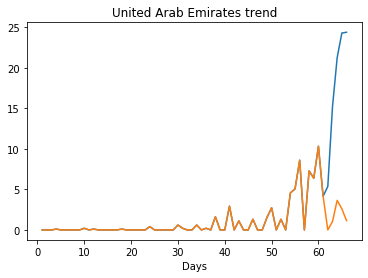

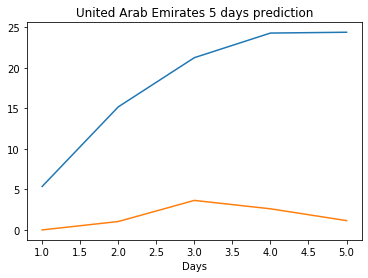

Creating directory ./offline8/India/training/
India
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0062
train error: 0.0010872444391376726
0.006177885457873344
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0077
train error: 0.0010804453447538739
0.007742566522210836
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0098
train error: 0.0011927705451379703
0.009808591566979885
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0084
train error: 0.0010634301937291941
0.008438161574304104
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0065
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0065
train error: 0.0008923305624193745
0.006453871726989746
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0098
train error: 0.0011927705451379703
0.009808591566979885
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0083
train error: 0.0011313118957597605
0.008329144679009914
Saving the b

Saving the best model weights at Epoch [1], Best Valid Loss: 0.0071
train error: 0.0011927705451379703
0.007127617485821247
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0098
train error: 0.0011927705451379703
0.009808591566979885
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0077
train error: 0.0009542505036127598
0.007743106223642826
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0098
train error: 0.0011927705451379703
0.009808591566979885
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0076
train error: 0.0009044179816555698
0.0076155886054039
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0057
train error: 0.0008915683871236979
0.0056872800923883915
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0098
train error: 0.0011927705451379703
0.009808591566979885
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0082
train error: 0.0011366313724465726
0.008151515386998653
Saving th

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0091
train error: 0.001133983331340005
0.00

Saving the best model weights at Epoch [4], Best Valid Loss: 0.0093
train error: 0.0011438554893478188
0.009296323172748089
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0100
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0097
train error: 0.0010905043225648114
0.009664828889071941
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0085
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0084
Sa

Saving the best model weights at Epoch [38], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0089
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0089
train error: 0.002690342627465725
0.008908654563128948
Saving the best model weights at Epoch [1], Best

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0087
Saving the best model weights at Epoch

Saving the best model weights at Epoch [26], Best Valid Loss: 0.0094
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0094
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0091
Saving the best model weights at E

Saving the best model weights at Epoch [23], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0090
Saving the best model weights at E

Saving the best model weights at Epoch [4], Best Valid Loss: 0.0047
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0042
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0035
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0034
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [

train error: 0.000991356388112763
0.005782017018646002
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0042
train error: 0.0014461338423037281
0.004226227756589651
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0072
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0072
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0072
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0072
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0072
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0072
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0072
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0071
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0071
Sa

Saving the best model weights at Epoch [30], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0053
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0052
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0050
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0050
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0049
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0049
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0049
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0048
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0085
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0082
train error: 0.0009288476091266299
0.008219546638429165
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0065
train error: 0.0012310533250759665
0.0064671896398067474
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0069
train error: 0.0011721345887053757
0.006865916308015585
Saving the bes

Saving the best model weights at Epoch [3], Best Valid Loss: 0.0019
train error: 0.00089775856504275
0.0019217977533116937
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0045
train error: 0.001776028391517078
0.004482582677155733
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0088
train error: 0.0011264607152649357
0.008786343038082123
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0113
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0101
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0098
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0095
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0094
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0092
Saving the best mo

Saving the best model weights at Epoch [28], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0233
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0233
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0230
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 0.0102
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0101
train error: 0.007627113458390037
0.010076157748699188
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [12], Best Valid L

Saving the best model weights at Epoch [9], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0096
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0096
Saving the best model weights at Ep

Saving the best model weights at Epoch [23], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0093
train error: 0.0013675501293619163
0.009293997660279274
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0080
Saving the best model weights at Epoch [2], Best

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0067
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0067
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0067
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0067
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0067
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0067
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0066
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0066
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0066
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0066
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0066
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0066
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0066
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0066
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [25], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0046
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.0063
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0063
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0063
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0063
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0063
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0063
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0063
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0063
train error: 0.0034773927181959152
0.006263829302042723
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0110
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0110
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0110
Saving the best model weights at Epoch [6], Best Val

Saving the best model weights at Epoch [8], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0092
Saving the best model weights at Epo

Saving the best model weights at Epoch [20], Best Valid Loss: 0.0114
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0114
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0114
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0113
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0113
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0113
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0113
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0111
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 0.0099
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0099
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0099
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0099
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0098
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0098
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0098
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0098
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0098
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0098
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0098
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0097
train error: 0.00806869858254989
0.009735836647450924
Saving the best model weights at Epoch [1], Best 

Saving the best model weights at Epoch [43], Best Valid Loss: 0.0102
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0102
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0102
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0102
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0102
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0102
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0102
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0102
train error: 0.001649458199972287
0.010170496068894863
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0047
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0047
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0047
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0047
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0047
Saving the best model weights at Epoch [6], Best Vali

Saving the best model weights at Epoch [5], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0086
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [23], Best Valid Loss: 0.0098
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0095
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0094
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0093
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0089
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0085
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0085
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0084
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0069
Saving the best model weights at E

Saving the best model weights at Epoch [26], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0131
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 0.0177
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0177
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0176
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0176
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0176
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0176
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0175
train error: 0.012552168965339661
0.017531782388687134
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [7], Best Valid

Saving the best model weights at Epoch [11], Best Valid Loss: 0.0105
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0104
Saving the best model weights at E

Saving the best model weights at Epoch [27], Best Valid Loss: 0.0099
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0098
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0098
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0098
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0098
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0098
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0098
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0098
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0098
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0098
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0098
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0098
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0098
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0098
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.0061
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0061
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0061
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0061
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0061
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0061
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0061
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0061
train error: 0.003393499126347403
0.006117044482380152
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [6], Best Vali

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0116
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0116
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0116
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0115
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0115
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0115
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0115
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0114
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0114
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0114
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0113
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0113
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0113
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0112
Saving the best model weights at E

Saving the best model weights at Epoch [26], Best Valid Loss: 0.0070
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0070
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0070
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0070
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0070
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0070
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0070
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0070
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0070
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0070
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0070
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0070
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0070
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0070
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0108
train error: 0.0033756256918422876
0.010818826965987682
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0042
train error: 0.00213840784272179
0.0042140306904911995
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0059
train error: 0.0020064198838857313
0.005890291184186935
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0068
Saving the

Saving the best model weights at Epoch [8], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0214
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0214
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0214
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0214
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0214
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0214
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0214
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0214
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0214
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0214
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0214
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0214
Saving the best model weights at Epo

Saving the best model weights at Epoch [26], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0108
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 0.0042
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0042
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0042
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0042
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0042
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0042
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0042
train error: 0.004395458979221682
0.004202204756438732
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [7], Best Valid

Saving the best model weights at Epoch [11], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0084
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0077
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.0160
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0160
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0160
train error: 0.036644618523617584
0.015972057357430458
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0141
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0140
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0140
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0140
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0140
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0140
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0140
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0140
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0139
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0139
Saving the best model weights at Epoch [11], Best Valid L

Saving the best model weights at Epoch [14], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0119
Saving the best model weights at E

Saving the best model weights at Epoch [28], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0068
Saving the best model weights at E

Saving the best model weights at Epoch [45], Best Valid Loss: 0.0284
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0284
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0283
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0283
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0283
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0283
train error: 0.033163809403777125
0.02832549624145031
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [8], Best Valid L

Saving the best model weights at Epoch [13], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0056
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0090
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [15], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0058
Saving the best model weights at E

Saving the best model weights at Epoch [31], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0076
Saving the best model weights at E

train error: 0.004394011835878094
0.0014098206302151084
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [14], Best Valid 

Saving the best model weights at Epoch [13], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0303
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0043
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0083
train error: 0.0057195407260830205
0.008252996951341629
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0028
train error: 0.0030927749583497645
0.0027698755729943514
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0051
train error: 0.001958675797019775
0.005103850271552801
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0082
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0082
Saving t

Saving the best model weights at Epoch [7], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0168
Saving the best model weights at Epoc

Saving the best model weights at Epoch [25], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0084
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0084
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.0105
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0105
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0105
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0105
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0105
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0105
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0105
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0105
train error: 0.0051595055653403206
0.010489041917026043
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [6], Best Val

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0086
Saving the best model weights at E

Saving the best model weights at Epoch [24], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0086
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0111
train error: 0.007582526211626828
0.011149226687848568
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0139
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0139
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0139
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0139
Saving the best model weights at Epoch [5], Best Val

Saving the best model weights at Epoch [9], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0106
Saving the best model weights at Ep

Saving the best model weights at Epoch [27], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0074
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.0071
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0071
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0071
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0071
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0071
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0071
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0071
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0071
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0071
train error: 0.002306489277786265
0.007076237350702286
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0046
train error: 0.002970643089308093
0.004608625546097755
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0135
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0135
Saving the best model weights at Epoch [3], Best Valid Loss: 0.01

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0083
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0083
Saving the best model weights at Epoch

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0033
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0092
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0092
train error: 0.002746983190687994
0.009207637049257755
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [3], Best V

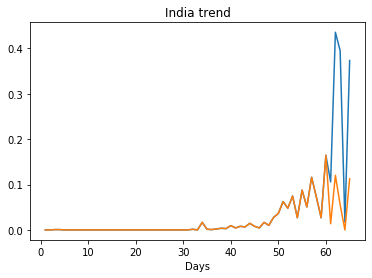

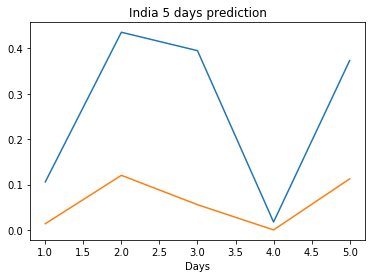

Creating directory ./offline8/Nepal/training/
Nepal
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0005
train error: 9.837974707644597e-05
0.00047319428995251656
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0004
train error: 9.821796413364479e-05
0.0004314969410188496
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0005
train error: 0.00010096461379102298
0.0004711681976914406
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0005
Saving the best model weig

Saving the best model weights at Epoch [5], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0004
train error: 9.788560744579756e-05
0.00041362197953276336
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0005
train error: 0.00010122963337327714
0.00047119110240601003
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0005
train error: 0.00010096461379102298
0.0004711681976914406
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0005
Savin

train error: 9.986303813970413e-05
0.00047183511196635664
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0071
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0004
train error: 9.432402488788025e-05
0.00039439304964616895
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0005
train error: 9.827708200386302e-05
0.00047199364053085446
Saving th

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0185
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0135
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0099
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [37], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0005
train error: 9.729674265405006e-05
0.00047499057836830616
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [4], Best

Saving the best model weights at Epoch [5], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0004
train error: 9.763908624985821e-05
0.00044093243195675313
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [9], Best Valid 

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0107
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0002
train error: 9.576078104406146e-05
0.00015861017163842916
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [8], Best Valid Los

Saving the best model weights at Epoch [9], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0004
Saving the best model weights at Ep

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [19

Saving the best model weights at Epoch [28], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0003
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0004
Saving the best model weights at E

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0050
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0047
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0042
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0034
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0024
Saving the best model weights at E

Saving the best model weights at Epoch [12], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0006
Saving the best model weights at E

Saving the best model weights at Epoch [14], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0005
Saving the best model weights at E

Saving the best model weights at Epoch [39], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0009
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0008
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0007
train error: 0.0004201846864556761
0.0006662405212409794
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [2], Bes

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0023
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0023
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0019
Saving the best model weights at E

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0065
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0063
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0061
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0060
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0053
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0049
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0047
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0044
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 0.0004
train error: 9.556043448485849e-05
0.0004357675206847489
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0023
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0020
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [13], Best Valid

Saving the best model weights at Epoch [17], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0004
train error: 9.34093917489268e-05
0.0004041228094138205
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0049
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0044
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0042
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [11], Best Valid 

Saving the best model weights at Epoch [13], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0035
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0034
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0034
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0027
Saving the best model weights at E

Saving the best model weights at Epoch [36], Best Valid Loss: 0.0047
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0043
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0035
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0027
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0004
train error: 0.0004231690350154947
0.00041242424049414694
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0126
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0100
Saving the best model weights at Epoch [6], Best V

Saving the best model weights at Epoch [12], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0005
Saving the best model weights at E

Saving the best model weights at Epoch [8], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0002
train error: 0.00013445009878653634


Saving the best model weights at Epoch [46], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0014
train error: 0.0011468423613613206
0.0013750930083915591
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0127
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0064
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [9], Best Valid

Saving the best model weights at Epoch [47], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0002
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0002
train error: 0.0004716695124183648
0.0001839311298681423
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0005
train error: 0.00010096461379102298
0.0004711681976914406
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0035
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0034
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [8], Best Valid Loss: 0.00

Saving the best model weights at Epoch [12], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0005
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0004
train error: 0.00021810461309671933
0.0003541430633049458
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0004
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0003
train error: 9.855034732026979e-05
0.00027223696815781295
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0

Saving the best model weights at Epoch [5], Best Valid Loss: 0.0138
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0134
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0130
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0126
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0118
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0114
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0111
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0108
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0101
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0098
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0095
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0092
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [26], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0072
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0072
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0072
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0071
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0071
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0070
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0070
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0070
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0068
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0068
Saving the best model weights at E

Saving the best model weights at Epoch [46], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0006
train error: 0.0004931605304591358
0.0005507168243639171
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0046
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0044
Saving the best model weights at Epoch [9], Best Valid

Saving the best model weights at Epoch [13], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0029
Saving the best model weights at E

Saving the best model weights at Epoch [31], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0005
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 0.0081
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0081
train error: 0.008366165948765618
0.008067202754318714
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0124
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0116
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0112
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0109
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0105
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0101
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0098
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0095
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [12], Best Valid L

Saving the best model weights at Epoch [17], Best Valid Loss: 0.0076
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0075
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0075
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0072
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0072
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0071
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0071
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0070
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0070
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0069
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 0.0042
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0038
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [20], Best Valid Loss: 0.0222
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0221
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0220
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0219
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0219
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0217
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0216
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0216
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0214
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0214
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0212
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 0.0073
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0071
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0069
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0067
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0065
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0063
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0060
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0058
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0057
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0055
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0053
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0052
train error: 0.005089072557166219
0.005197868682444096
Saving the best model weights at Epoch [1], Best

Saving the best model weights at Epoch [5], Best Valid Loss: 0.0034
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0023
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0023
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0021
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [23], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0010
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0010
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0023
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0023
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0023
train error: 0.003587693641228335
0.0023241890594363213
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0005
Saving the best model weights at Epoch [5], Best Va

Saving the best model weights at Epoch [9], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0088
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0087
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0086
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0085
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0085
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0085
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0084
Saving the best model weights at Ep

Saving the best model weights at Epoch [27], Best Valid Loss: 0.0035
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0034
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0025
Saving the best model weights at E

Saving the best model weights at Epoch [46], Best Valid Loss: 0.0047
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0047
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0047
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0047
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0046
train error: 0.004058437674705471
0.004644565284252167
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0061
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0059
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0057
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0056
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0053
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0050
Saving the best model weights at Epoch [9], Best Valid L

Saving the best model weights at Epoch [13], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0018
Saving the best model weights at E

Saving the best model weights at Epoch [31], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0027
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.0178
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0178
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0177
train error: 0.019332502888781685
0.017700275406241417
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0405
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0403
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0400
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0398
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0395
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0393
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0390
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0388
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0386
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0383
Saving the best model weights at Epoch [11], Best Valid L

Saving the best model weights at Epoch [15], Best Valid Loss: 0.0055
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0055
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0055
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0054
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0053
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0053
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0053
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0053
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0053
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0052
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0003
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.0038
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0035
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0034
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0033
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0032
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0031
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0030
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [20], Best Valid Loss: 0.0023
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0023
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0023
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0023
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0023
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0022
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0021
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0021
Saving the best model weights at E

Saving the best model weights at Epoch [39], Best Valid Loss: 0.0345
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0345
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0344
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0344
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0344
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0344
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0344
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0344
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0344
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0344
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0344
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0343
train error: 0.037171931192278865
0.03434009104967117
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [2], Best V

Saving the best model weights at Epoch [8], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0024
Saving the best model weights at Epo

Saving the best model weights at Epoch [27], Best Valid Loss: 0.0066
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0066
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0066
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0065
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0065
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0065
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0065
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0064
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0064
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0064
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0064
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0063
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0063
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0063
Saving the best model weights at E

Saving the best model weights at Epoch [45], Best Valid Loss: 0.0075
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0075
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0075
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0075
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0075
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0075
train error: 0.008968453774494784
0.007491108030080795
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0029
Saving the best model weights at Epoch [8], Best Valid 

Saving the best model weights at Epoch [12], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0014
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0013
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 0.0348
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0348
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0348
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0348
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0348
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0348
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0348
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0347
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0347
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0347
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0347
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0347
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0347
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0347
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0039
train error: 0.0034597149251827173
0.003931332845240831
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0166
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0166
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0166
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0166
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0166
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0165
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0165
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0165
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0165
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0165
Saving the best model weights at Epoch [11], Best Valid 

Saving the best model weights at Epoch [15], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0045
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0044
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0044
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0044
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0044
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0044
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0044
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0044
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0044
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0023
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0023
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0023
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0023
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0023
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0023
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0024
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [20], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0074
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0074
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 0.0123
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0122
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0119
train error: 0.012135053372808865
0.011908655054867268
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0052
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0052
Saving the best model weights at Epoch [3], Best V

Saving the best model weights at Epoch [7], Best Valid Loss: 0.0052
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0052
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0052
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0052
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0052
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0052
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0052
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0051
Saving the best model weights at Epoc

Saving the best model weights at Epoch [26], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0041
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0041
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0018
train error: 0.00133657587243111
0.0018360101385042071
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0039
Saving the best model weights at Epoch [7], Best Valid

Saving the best model weights at Epoch [11], Best Valid Loss: 0.0115
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0115
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0115
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0115
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0115
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0115
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0115
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0115
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0115
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0115
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0115
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0115
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0115
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0115
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 0.0117
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0117
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0116
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0116
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0116
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0115
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0115
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0115
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0114
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0114
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0114
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0113
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0113
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0113
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0017
train error: 0.0013068247079250535
0.0017056772485375404
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0003
Saving the best model weights at Epoch [10], Best Valid

Saving the best model weights at Epoch [14], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0048
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0048
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0011
Saving the best model weights at E

Saving the best model weights at Epoch [50], Best Valid Loss: 0.0002
train error: 0.0012495950795710087
0.00019895598234143108
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0078
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0077
Saving the best model weights at Epoch [13], Best Vali

Saving the best model weights at Epoch [15], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0050
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0050
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0050
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0050
Saving the best model weights at E

Saving the best model weights at Epoch [31], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0051
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0051
Saving the best model weights at E

Saving the best model weights at Epoch [50], Best Valid Loss: 0.0018
train error: 0.0017947489844768174
0.0018321126699447632
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0013
Saving the best model weights at Epoch [13], Best Valid

Saving the best model weights at Epoch [17], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0027
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0026
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 0.0391
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0391
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0391
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0391
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0391
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0391
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0391
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0391
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0391
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0391
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0391
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0391
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0391
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0391
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0106
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [20], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0018
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0018
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0019
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0019
train error: 0.00255560643438782
0.0019161247182637453
Saving the best model weights at Epoch [1], Best

Saving the best model weights at Epoch [1], Best Valid Loss: 0.0175
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0175
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0175
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0175
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0175
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0175
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0175
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0175
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0175
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0175
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0175
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0175
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0175
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0175
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [19], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0012
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0012
Saving the best model weights at E

Saving the best model weights at Epoch [37], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0028
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0028
train error: 0.0022939789541331786

Saving the best model weights at Epoch [4], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0007
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0006
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0011
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0097
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0097
train error: 0.00915001251601747
0.00968526303768158
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0493
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0493
Saving the best model weights at Epoch [3], Best Val

Saving the best model weights at Epoch [7], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0091
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0091
Saving the best model weights at Epoc

Saving the best model weights at Epoch [25], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0090
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0090
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0036
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0036
train error: 0.005635864946192929
0.003610240761190653
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [5], Best Val

Saving the best model weights at Epoch [9], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0025
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0025
Saving the best model weights at Ep

Saving the best model weights at Epoch [27], Best Valid Loss: 0.0207
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0207
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0207
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0207
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0207
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0207
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0207
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0207
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0207
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0207
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0207
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0207
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0207
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0207
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0131
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0131
train error: 0.013434665543692452
0.013118579983711243
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0062
Saving the best model weights at Epoch [6], Best Vali

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0011
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0011
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0017
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0017
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0016
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0016
train error: 0.0012574515529974763
0.0016416761791333556
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0156
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0156
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0156
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0156
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0156
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0156
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0156
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0156
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0156
Saving the best model weights at Epoch [10], Best Valid

Saving the best model weights at Epoch [15], Best Valid Loss: 0.0034
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0034
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0034
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0034
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0034
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0034
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0034
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0034
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0034
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0034
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0034
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0034
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0034
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0034
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0015
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0015
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0026
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [19], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0037
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0037
Saving the best model weights at E

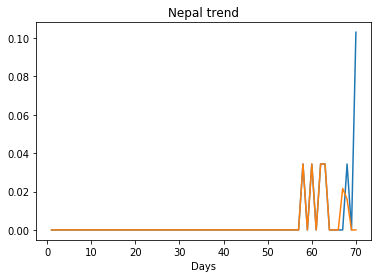

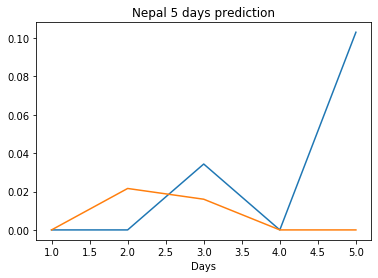

Creating directory ./offline8/Sri Lanka/training/
Sri Lanka
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0283
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0264
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0256
train error: 0.04341574097193326
0.025562971830368042
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0386
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0351
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0348
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0343
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0339
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0335
train error: 0.047836460938428485
0.03345007821917534
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0328
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0223
train error: 0

Saving the best model weights at Epoch [3], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0286
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0285
train error: 0.06285011510816262
0.028541196137666702
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0333
train error: 0.07128223511355111
0.033257972449064255
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0337
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0333
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0332
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0332
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0329
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0329
train error: 0.05758931193585423
0.03290022164583206
Saving the best 

Saving the best model weights at Epoch [5], Best Valid Loss: 0.0245
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0224
train error: 0.0635227938464871
0.022398177534341812
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0308
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0254
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0201
train error: 0.06403702081209331
0.020088357850909233
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0228
train error: 0.07128223511355111
0.022806977853178978
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0121
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0120
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0119
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0119
train error: 0.0534289

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0136
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0113
train error: 0.035910187656003414
0.011315315961837769
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0279
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0265
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0256
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0249
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0244
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0231
Saving the best model weights at Epoch [12], Best Valid Los

Saving the best model weights at Epoch [28], Best Valid Loss: 0.0121
train error: 0.04826431168299733
0.012067373842000961
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0182
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0179
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0177
train error: 0.05332447088916193
0.01770230568945408
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0161
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0151
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0144
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0139
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0135
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0132
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0130
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0128
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0127
Saving t

Saving the best model weights at Epoch [26], Best Valid Loss: 0.0148
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0148
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0148
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0146
train error: 0.05754543081716155
0.014633421786129475
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0397
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0397
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0397
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0397
Saving the best model weights at Epoch [5], Best Vali

Saving the best model weights at Epoch [16], Best Valid Loss: 0.0188
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0186
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0185
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0184
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0184
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0183
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0182
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0182
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0181
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0181
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0181
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0180
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0180
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0179
Saving the best model weights at E

Saving the best model weights at Epoch [19], Best Valid Loss: 0.0190
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0190
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0190
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0190
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0189
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0189
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0189
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0189
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0188
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0188
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0188
train error: 0.0522139681164514
0.01883234642446041
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0275
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [3], Best Vali

Saving the best model weights at Epoch [12], Best Valid Loss: 0.0335
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0333
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0327
train error: 0.05706479110416363
0.03273021802306175
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0383
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0376
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0372
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0370
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0368
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0367
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0367
train error: 0.057888684483865895
0.036678701639175415
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0374
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0371
Savi

Saving the best model weights at Epoch [23], Best Valid Loss: 0.0359
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0356
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0353
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0350
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0347
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0345
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0342
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0340
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0337
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0335
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0332
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0328
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0326
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 0.0399
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0399
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0399
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0398
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0398
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0398
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0398
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0397
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0397
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0397
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0397
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0396
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0396
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0396
Saving the best model weights at E

Saving the best model weights at Epoch [23], Best Valid Loss: 0.0432
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0432
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0431
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0431
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0430
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0430
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0429
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0429
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0429
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0428
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0428
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0427
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0427
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0427
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0339
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0337
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0336
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0335
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0334
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0332
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0331
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0329
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0328
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0327
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0326
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0325
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0324
Saving the best model weights at E

Saving the best model weights at Epoch [16], Best Valid Loss: 0.0206
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0206
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0205
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0205
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0205
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0205
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0205
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0205
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0204
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0204
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0204
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0204
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0204
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0204
Saving the best model weights at E

Saving the best model weights at Epoch [20], Best Valid Loss: 0.0321
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0320
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0319
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0318
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0317
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0314
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0310
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0310
Saving the best model weights at E

Saving the best model weights at Epoch [25], Best Valid Loss: 0.0274
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0273
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0271
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0271
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0270
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0270
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0268
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0268
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0267
Saving the best model weights at E

Saving the best model weights at Epoch [41], Best Valid Loss: 0.0154
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0153
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0152
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0151
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0151
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0150
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0149
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0148
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0147
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0147
train error: 0.0501599429372811
0.014663797803223133
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0286
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0284
Saving the best model weights at Epoch [4], Best Vali

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0391
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0387
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0384
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0380
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0376
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0373
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0370
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0367
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0364
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0361
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0359
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0356
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0353
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0351
Saving the best model weights at Epoch

Saving the best model weights at Epoch [48], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0337
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0337
train error: 0.06708317604903696
0.033693838864564896
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0449
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0448
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0446
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0445
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0444
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0443
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0442
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0441
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0440
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0439
Saving the best model weights at Epoch [11], Best Valid Lo

Saving the best model weights at Epoch [23], Best Valid Loss: 0.0296
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0294
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0292
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0291
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0286
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0285
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0283
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0282
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0281
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0279
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0278
Saving the best model weights at E

Saving the best model weights at Epoch [13], Best Valid Loss: 0.0290
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0285
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0280
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0275
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0271
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0266
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0262
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0257
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0254
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0249
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0246
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0236
Saving the best model weights at E

Saving the best model weights at Epoch [7], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0266
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0262
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0259
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0256
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0253
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0245
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0243
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0241
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0235
Saving the best model weights at Epoc

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0364
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0364
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0364
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0364
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0364
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0364
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0364
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0364
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0364
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0364
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0364
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0364
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0364
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0364
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.0341
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0340
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0339
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0337
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0337
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0336
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0335
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0335
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0334
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0333
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0333
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0332
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0331
Saving the best model weights at E

Saving the best model weights at Epoch [27], Best Valid Loss: 0.0170
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0167
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0165
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0164
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0162
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0161
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0159
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0158
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0157
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0156
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0155
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0154
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0152
Saving the best model weights at E

Saving the best model weights at Epoch [18], Best Valid Loss: 0.0240
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0238
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0238
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0233
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0233
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0233
Saving the best model weights at E

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0375
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0374
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0371
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0370
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0368
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0367
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0366
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0366
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0365
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0365
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0364
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0364
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0364
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0364
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.0294
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0274
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0258
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0249
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0236
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0226
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0220
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0207
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0205
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0201
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0200
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [45], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0311
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0310
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0310
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0309
train error: 0.06119767481559944
0.030902475118637085
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0327
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0268
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0244
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0232
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0212
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0206
Saving the best model weights at Epoch [8], Best Valid L

Saving the best model weights at Epoch [37], Best Valid Loss: 0.0216
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0214
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0214
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0212
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0212
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0211
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0211
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0211
train error: 0.05688040318306197
0

Saving the best model weights at Epoch [4], Best Valid Loss: 0.0413
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0412
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0411
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0410
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0410
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0409
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0408
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0407
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0407
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0406
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0405
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0404
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0404
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0403
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [38], Best Valid Loss: 0.0442
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0441
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0441
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0441
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0441
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0441
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0441
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0441
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0441
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0440
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0440
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0440
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0440
train error: 0.06964741212648347
0.044012900441884995
Saving the best model weights at Epoch [1], Best 

Saving the best model weights at Epoch [7], Best Valid Loss: 0.0396
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0396
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0395
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0395
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0395
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0395
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0394
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0394
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0394
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0394
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0393
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0393
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0393
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0393
Saving the best model weights at Epoc

Saving the best model weights at Epoch [25], Best Valid Loss: 0.0398
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0397
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0396
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0395
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0394
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0393
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0392
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0391
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0390
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0389
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0388
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0388
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0387
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0386
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.0361
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0361
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0361
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0361
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0360
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0360
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0360
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0359
train error: 0.0636303518955229
0.035942528396844864
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0455
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0454
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0453
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0451
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0450
Saving the best model weights at Epoch [6], Best Valid 

Saving the best model weights at Epoch [11], Best Valid Loss: 0.0331
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0331
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0329
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0329
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0328
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0328
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0327
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0327
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0326
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0326
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0325
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0325
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.0362
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0362
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0362
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0362
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0362
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0362
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0361
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0361
train error: 0.06054093290797689
0.03612769767642021
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0371
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0370
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0370
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0369
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0369
Saving the best model weights at Epoch [6], Best Valid 

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0316
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0314
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0314
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0314
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0313
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0312
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0311
Saving the best model weights at E

Saving the best model weights at Epoch [28], Best Valid Loss: 0.0252
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0250
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0248
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0247
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0245
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0244
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0243
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0241
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0240
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0239
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0238
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0237
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0235
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0234
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.0429
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0429
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0428
train error: 0.060652973892336544
0.04284611716866493
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0325
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0324
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0324
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0324
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0324
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0324
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0323
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0323
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0323
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0323
Saving the best model weights at Epoch [13], Best Valid 

Saving the best model weights at Epoch [20], Best Valid Loss: 0.0271
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0271
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0271
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0270
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0270
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0270
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0270
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0270
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0269
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.0284
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0284
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0284
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0284
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0283
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0283
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0283
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0283
train error: 0.0636048587321332
0.028309941291809082
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0487
train error: 0.06694075600667433
0.04869803413748741
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0294
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0294
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0293
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0293
Sa

Saving the best model weights at Epoch [8], Best Valid Loss: 0.0307
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0303
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0300
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0295
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0292
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0285
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0281
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0278
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0275
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0272
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0269
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0266
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0263
Saving the best model weights at Epo

Saving the best model weights at Epoch [27], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0436
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0436
Saving the best model weights at E

Saving the best model weights at Epoch [17], Best Valid Loss: 0.0465
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0464
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0464
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0464
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0463
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0463
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0463
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0463
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0462
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0462
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0462
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0461
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0461
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0461
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 0.0351
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0351
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0351
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0351
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0351
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0350
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0350
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0350
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0350
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0350
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0350
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0350
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0350
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0349
Saving the best model weights at E

Saving the best model weights at Epoch [4], Best Valid Loss: 0.0318
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0318
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0318
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0318
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0318
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0318
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0318
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0318
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0318
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0318
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0318
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0317
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0317
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0317
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0225
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0222
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0220
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0218
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0216
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0215
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0213
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0211
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0209
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0208
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0206
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0205
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0201
Saving the best model weights at E

Saving the best model weights at Epoch [17], Best Valid Loss: 0.0341
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0340
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0339
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0338
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0337
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0336
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0336
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0335
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0334
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0333
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0333
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0332
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0332
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0331
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 0.0203
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0202
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0201
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0201
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0200
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0200
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0199
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0199
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0199
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0198
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0198
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0197
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0197
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.0420
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0420
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0419
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0419
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0418
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0418
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0417
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0417
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0416
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0416
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0415
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0415
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0414
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0414
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [20], Best Valid Loss: 0.0188
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0188
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0188
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0188
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0188
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0188
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0188
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0188
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0188
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0188
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0188
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0188
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0188
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0188
Saving the best model weights at E

Saving the best model weights at Epoch [36], Best Valid Loss: 0.0305
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0305
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0305
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0305
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0305
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0305
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0305
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0305
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0305
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0305
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0305
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0305
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0305
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0305
Saving the best model weights at E

Saving the best model weights at Epoch [4], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0242
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [25], Best Valid Loss: 0.0169
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0168
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0168
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 0.0285
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0285
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0285
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0285
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0285
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0285
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0285
train error: 0.058464308876092684
0.028521111235022545
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0381
Saving the best model weights at Epoch [7], Best Valid

Saving the best model weights at Epoch [11], Best Valid Loss: 0.0518
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0518
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0518
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0518
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0518
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0518
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0518
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0518
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0518
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0518
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0518
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0518
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0518
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0518
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0330
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0330
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 0.0399
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0399
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0399
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0399
train error: 0.0601397736393141
0.03987548127770424
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0410
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0410
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0410
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0410
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0410
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0410
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0410
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0410
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0410
Saving the best model weights at Epoch [10], Best Valid Loss

Saving the best model weights at Epoch [14], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0287
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0287
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0287
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0287
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0287
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0286
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0286
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0286
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0286
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0286
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0286
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.0374
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0374
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0374
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0374
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0374
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0374
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0374
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0374
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0374
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0374
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0374
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0374
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0374
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0374
Saving the best model weights at E

Saving the best model weights at Epoch [15], Best Valid Loss: 0.0469
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0468
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0468
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0468
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0468
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0468
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0468
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0468
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0468
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0468
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0468
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0468
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0468
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0468
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 0.0369
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0369
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0369
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0369
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0369
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0369
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0369
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0369
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0368
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0368
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0368
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0368
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0368
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0368
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.0471
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0471
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0471
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0470
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0470
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0470
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0470
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0470
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0470
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0470
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0470
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0470
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0470
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0470
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [19], Best Valid Loss: 0.0423
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0423
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0423
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0423
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0423
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0423
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0422
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0422
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0422
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0422
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0422
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0422
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0422
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0422
Saving the best model weights at E

Saving the best model weights at Epoch [37], Best Valid Loss: 0.0428
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0427
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0427
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0427
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0427
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0427
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0427
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0427
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0427
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0427
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0427
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0427
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0427
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0427
train error: 0.06869166711818031
0

Saving the best model weights at Epoch [3], Best Valid Loss: 0.0441
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0441
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0441
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0441
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0441
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0441
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0441
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0441
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0441
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0441
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0441
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0441
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0441
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0441
Saving the best model weights at Epoch [1

Saving the best model weights at Epoch [21], Best Valid Loss: 0.0451
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0451
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0451
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0451
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0451
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0451
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0451
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0451
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0451
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0451
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0451
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0451
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0451
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0451
Saving the best model weights at E

Saving the best model weights at Epoch [39], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [41], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0457
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0457
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0457
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0457
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0457
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0457
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0457
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0457
train error: 0.07070687979795008
0.04571735858917236
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0310
Saving the best model weights at Epoch [2], Best Va

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0289
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0288
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0288
Saving the best model weights at Epoch

Saving the best model weights at Epoch [24], Best Valid Loss: 0.0195
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0195
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0195
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0195
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0195
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0195
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0195
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0195
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0195
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0195
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0195
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0195
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0195
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0195
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.0478
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0478
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0477
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0477
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0476
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0476
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0476
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0475
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0475
train error: 0.06396266702336795
0.047482091933488846
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0329
train error: 0.06268497212140849
0.0328679233789444
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0207
train error: 0.061494021895200465
0.02069522999227047
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0490
Saving the best

Saving the best model weights at Epoch [7], Best Valid Loss: 0.0449
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0449
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0449
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0449
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0449
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0449
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0449
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0449
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0449
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0449
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0449
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0449
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0449
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0449
Saving the best model weights at Epoc

Saving the best model weights at Epoch [25], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0458
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0458
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.0256
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0256
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0256
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0256
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0256
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0256
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0255
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0255
train error: 0.0601669771977785
0.025524133816361427
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0104
Saving the best model weights at Epoch [6], Best Valid 

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0428
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0428
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0428
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0428
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0428
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0428
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0428
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0428
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0428
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0428
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0428
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0428
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0428
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0428
Saving the best model weights at E

Saving the best model weights at Epoch [27], Best Valid Loss: 0.0411
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0411
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0411
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0411
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0411
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0411
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0411
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0411
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0411
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0411
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0411
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0411
Saving the best model weights at Epoch [39], Best Valid Loss: 0.0411
Saving the best model weights at Epoch [40], Best Valid Loss: 0.0411
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 0.0205
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0205
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0205
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0205
train error: 0.05430600241842595
0.02052663080394268
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0402
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0402
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0402
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0402
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0402
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0402
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0402
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0402
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0402
Saving the best model weights at Epoch [10], Best Valid Los

Saving the best model weights at Epoch [13], Best Valid Loss: 0.0385
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0385
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0385
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0385
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0385
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0385
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0385
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0385
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0385
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0385
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0385
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0385
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0385
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0385
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.0504
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0504
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0504
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0504
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0504
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0504
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0504
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0504
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0504
train error: 0.06369547579776157
0.05038950964808464
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0356
train error: 0.06568881765071471
0.03559476137161255
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0315
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0315
S

Saving the best model weights at Epoch [4], Best Valid Loss: 0.0400
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0400
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0400
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0400
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0400
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0400
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0400
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0400
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0400
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0400
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0400
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0400
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0400
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0400
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [22], Best Valid Loss: 0.0296
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0296
Saving the best model weights at Epoch [24], Best Valid Loss: 0.0296
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0296
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0296
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0296
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0296
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0296
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0296
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0296
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0296
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0296
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0296
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0296
Saving the best model weights at E

Saving the best model weights at Epoch [41], Best Valid Loss: 0.0411
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0411
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0411
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0411
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0411
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0411
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0411
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0411
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0411
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0411
train error: 0.06486741690473123
0.0410664826631546
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0383
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0383
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0383
Saving the best model weights at Epoch [4], Best Valid

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0355
Saving the best model weights at Epoch

Saving the best model weights at Epoch [25], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0355
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0355
Saving the best model weights at E

Saving the best model weights at Epoch [6], Best Valid Loss: 0.0423
Saving the best model weights at Epoch [7], Best Valid Loss: 0.0423
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0423
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0423
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0423
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0423
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0423
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0423
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0423
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0423
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0423
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0423
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0423
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0423
Saving the best model weights at Epoch

Saving the best model weights at Epoch [24], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [25], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0040
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0040
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.0438
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0437
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0437
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0437
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0437
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0437
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0437
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0437
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0437
train error: 0.05936952810170072
0.043724846094846725
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0182
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0182
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0182
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0182
Saving the best model weights at Epoch [5], Best Vali

Saving the best model weights at Epoch [9], Best Valid Loss: 0.0475
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0475
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0475
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0475
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0475
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0475
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0475
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0474
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0474
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0474
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0474
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0474
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0474
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0474
Saving the best model weights at Ep

Saving the best model weights at Epoch [25], Best Valid Loss: 0.0403
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0403
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0403
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0403
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0403
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0403
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0403
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0403
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0403
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0403
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0403
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0403
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0403
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0403
Saving the best model weights at E

Saving the best model weights at Epoch [41], Best Valid Loss: 0.0318
Saving the best model weights at Epoch [42], Best Valid Loss: 0.0318
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0318
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0318
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0318
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0318
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0318
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0318
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0318
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0318
train error: 0.05523522827548511
0.031785931438207626
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0363
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0363
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0363
Saving the best model weights at Epoch [4], Best Val

Saving the best model weights at Epoch [7], Best Valid Loss: 0.0299
Saving the best model weights at Epoch [8], Best Valid Loss: 0.0299
Saving the best model weights at Epoch [9], Best Valid Loss: 0.0299
Saving the best model weights at Epoch [10], Best Valid Loss: 0.0299
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0299
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0299
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0299
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0299
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0299
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0299
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0299
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0299
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0299
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0299
Saving the best model weights at Epoc

Saving the best model weights at Epoch [25], Best Valid Loss: 0.0392
Saving the best model weights at Epoch [26], Best Valid Loss: 0.0392
Saving the best model weights at Epoch [27], Best Valid Loss: 0.0392
Saving the best model weights at Epoch [28], Best Valid Loss: 0.0392
Saving the best model weights at Epoch [29], Best Valid Loss: 0.0392
Saving the best model weights at Epoch [30], Best Valid Loss: 0.0392
Saving the best model weights at Epoch [31], Best Valid Loss: 0.0392
Saving the best model weights at Epoch [32], Best Valid Loss: 0.0392
Saving the best model weights at Epoch [33], Best Valid Loss: 0.0392
Saving the best model weights at Epoch [34], Best Valid Loss: 0.0392
Saving the best model weights at Epoch [35], Best Valid Loss: 0.0392
Saving the best model weights at Epoch [36], Best Valid Loss: 0.0392
Saving the best model weights at Epoch [37], Best Valid Loss: 0.0392
Saving the best model weights at Epoch [38], Best Valid Loss: 0.0392
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.0319
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0319
Saving the best model weights at Epoch [45], Best Valid Loss: 0.0319
Saving the best model weights at Epoch [46], Best Valid Loss: 0.0319
Saving the best model weights at Epoch [47], Best Valid Loss: 0.0319
Saving the best model weights at Epoch [48], Best Valid Loss: 0.0319
Saving the best model weights at Epoch [49], Best Valid Loss: 0.0319
Saving the best model weights at Epoch [50], Best Valid Loss: 0.0319
train error: 0.06015690806265356
0.03189779072999954
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0388
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0388
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0388
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0388
Saving the best model weights at Epoch [5], Best Valid Loss: 0.0388
Saving the best model weights at Epoch [6], Best Valid 

Saving the best model weights at Epoch [10], Best Valid Loss: 0.0294
Saving the best model weights at Epoch [11], Best Valid Loss: 0.0294
Saving the best model weights at Epoch [12], Best Valid Loss: 0.0294
Saving the best model weights at Epoch [13], Best Valid Loss: 0.0294
Saving the best model weights at Epoch [14], Best Valid Loss: 0.0294
Saving the best model weights at Epoch [15], Best Valid Loss: 0.0294
Saving the best model weights at Epoch [16], Best Valid Loss: 0.0294
Saving the best model weights at Epoch [17], Best Valid Loss: 0.0294
Saving the best model weights at Epoch [18], Best Valid Loss: 0.0294
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0294
Saving the best model weights at Epoch [20], Best Valid Loss: 0.0294
Saving the best model weights at Epoch [21], Best Valid Loss: 0.0294
Saving the best model weights at Epoch [22], Best Valid Loss: 0.0294
Saving the best model weights at Epoch [23], Best Valid Loss: 0.0294
Saving the best model weights at E

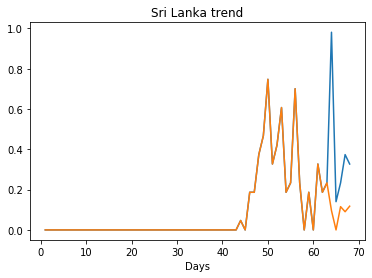

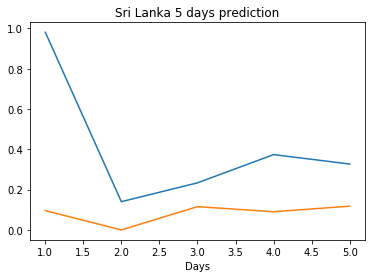

Creating directory ./offline8/Taiwan*/training/
Taiwan*
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1719
Saving the best model weights at Epoch [2], Best Valid Loss: 0.1493
Saving the best model weights at Epoch [3], Best Valid Loss: 0.1460
Saving the best model weights at Epoch [4], Best Valid Loss: 0.1371
Saving the best model weights at Epoch [5], Best Valid Loss: 0.1301
Saving the best model weights at Epoch [6], Best Valid Loss: 0.1262
Saving the best model weights at Epoch [7], Best Valid Loss: 0.1187
Saving the best model weights at Epoch [8], Best Valid Loss: 0.1077
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1053
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1037
train error: 0.06961812562382731
0.10367859899997711
Saving the best model weights at Epoch [1], Best Valid Loss: 0.2348
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2293
Saving the best model weights at Epoch [3], Best Valid Loss: 0.2088
Saving

train error: 0.13343574303067535
0.18207895755767822
Saving the best model weights at Epoch [1], Best Valid Loss: 0.2242
Saving the best model weights at Epoch [9], Best Valid Loss: 0.1988
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1264
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1020
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1014
Saving the best model weights at Epoch [43], Best Valid Loss: 0.0888
Saving the best model weights at Epoch [44], Best Valid Loss: 0.0865
train error: 0.0643367940547729
0.08653353154659271
Saving the best model weights at Epoch [1], Best Valid Loss: 0.2728
Saving the best model weights at Epoch [3], Best Valid Loss: 0.2635
Saving the best model weights at Epoch [4], Best Valid Loss: 0.2597
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2536
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2453
Saving the best model weights at Epoch [17], Best Valid Loss: 0.2447
Savi

Saving the best model weights at Epoch [3], Best Valid Loss: 0.3195
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3083
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3029
train error: 0.17808340955525637
0.30292075872421265
Saving the best model weights at Epoch [1], Best Valid Loss: 0.2899
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2869
train error: 0.19303104096386386
0.2868584990501404
Saving the best model weights at Epoch [1], Best Valid Loss: 0.2698
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2561
Saving the best model weights at Epoch [17], Best Valid Loss: 0.2522
train error: 0.1671305082762908
0.2521889805793762
Saving the best model weights at Epoch [1], Best Valid Loss: 0.1626
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1598
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1446
train error: 0.1366748254207012
0.14464828372001648
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [7], Best Valid Loss: 0.2512
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2476
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2452
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2434
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2415
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2405
Saving the best model weights at Epoch [13], Best Valid Loss: 0.2395
Saving the best model weights at Epoch [14], Best Valid Loss: 0.2387
Saving the best model weights at Epoch [15], Best Valid Loss: 0.2382
Saving the best model weights at Epoch [16], Best Valid Loss: 0.2375
Saving the best model weights at Epoch [17], Best Valid Loss: 0.2373
Saving the best model weights at Epoch [18], Best Valid Loss: 0.2366
Saving the best model weights at Epoch [19], Best Valid Loss: 0.2365
Saving the best model weights at Epoch [20], Best Valid Loss: 0.2362
Saving the best model weights at Epoc

Saving the best model weights at Epoch [9], Best Valid Loss: 0.1842
Saving the best model weights at Epoch [10], Best Valid Loss: 0.1803
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1770
Saving the best model weights at Epoch [12], Best Valid Loss: 0.1741
Saving the best model weights at Epoch [13], Best Valid Loss: 0.1722
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1697
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1675
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1658
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1645
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1631
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1622
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1608
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1597
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1588
Saving the best model weights at Ep

Saving the best model weights at Epoch [49], Best Valid Loss: 0.2832
Saving the best model weights at Epoch [50], Best Valid Loss: 0.2830
train error: 0.1534720399466
0.2830430269241333
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3618
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3318
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3095
Saving the best model weights at Epoch [4], Best Valid Loss: 0.2944
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2834
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2766
Saving the best model weights at Epoch [7], Best Valid Loss: 0.2699
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2661
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2578
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2347
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2177
Saving the best model weights at Epoch [12], Best Valid Loss: 0.

Saving the best model weights at Epoch [1], Best Valid Loss: 0.3146
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2943
Saving the best model weights at Epoch [3], Best Valid Loss: 0.2809
Saving the best model weights at Epoch [4], Best Valid Loss: 0.2714
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2644
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2601
Saving the best model weights at Epoch [7], Best Valid Loss: 0.2565
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2540
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2512
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2499
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2479
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2472
Saving the best model weights at Epoch [13], Best Valid Loss: 0.2464
Saving the best model weights at Epoch [14], Best Valid Loss: 0.2448
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [13], Best Valid Loss: 0.1910
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1901
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1894
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1888
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1885
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1881
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1877
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1873
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1869
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1868
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1866
Saving the best model weights at Epoch [27], Best Valid Loss: 0.1863
Saving the best model weights at Epoch [29], Best Valid Loss: 0.1861
Saving the best model weights at Epoch [34], Best Valid Loss: 0.1857
Saving the best model weights at E

Saving the best model weights at Epoch [5], Best Valid Loss: 0.2684
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2628
Saving the best model weights at Epoch [7], Best Valid Loss: 0.2581
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2543
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2510
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2485
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2464
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2447
Saving the best model weights at Epoch [13], Best Valid Loss: 0.2434
Saving the best model weights at Epoch [14], Best Valid Loss: 0.2422
Saving the best model weights at Epoch [15], Best Valid Loss: 0.2414
Saving the best model weights at Epoch [16], Best Valid Loss: 0.2407
Saving the best model weights at Epoch [17], Best Valid Loss: 0.2401
Saving the best model weights at Epoch [18], Best Valid Loss: 0.2398
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [6], Best Valid Loss: 0.2609
Saving the best model weights at Epoch [7], Best Valid Loss: 0.2559
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2525
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2499
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2474
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2456
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2436
Saving the best model weights at Epoch [13], Best Valid Loss: 0.2423
Saving the best model weights at Epoch [14], Best Valid Loss: 0.2409
Saving the best model weights at Epoch [15], Best Valid Loss: 0.2400
Saving the best model weights at Epoch [16], Best Valid Loss: 0.2397
Saving the best model weights at Epoch [17], Best Valid Loss: 0.2393
Saving the best model weights at Epoch [18], Best Valid Loss: 0.2388
Saving the best model weights at Epoch [19], Best Valid Loss: 0.2385
Saving the best model weights at Epoch

Saving the best model weights at Epoch [13], Best Valid Loss: 0.1987
Saving the best model weights at Epoch [14], Best Valid Loss: 0.1968
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1952
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1945
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1928
Saving the best model weights at Epoch [18], Best Valid Loss: 0.1919
Saving the best model weights at Epoch [19], Best Valid Loss: 0.1913
Saving the best model weights at Epoch [20], Best Valid Loss: 0.1906
Saving the best model weights at Epoch [21], Best Valid Loss: 0.1903
Saving the best model weights at Epoch [22], Best Valid Loss: 0.1900
Saving the best model weights at Epoch [23], Best Valid Loss: 0.1900
Saving the best model weights at Epoch [24], Best Valid Loss: 0.1898
Saving the best model weights at Epoch [25], Best Valid Loss: 0.1893
Saving the best model weights at Epoch [26], Best Valid Loss: 0.1887
Saving the best model weights at E

Saving the best model weights at Epoch [10], Best Valid Loss: 0.1833
Saving the best model weights at Epoch [11], Best Valid Loss: 0.1822
Saving the best model weights at Epoch [15], Best Valid Loss: 0.1822
Saving the best model weights at Epoch [16], Best Valid Loss: 0.1814
Saving the best model weights at Epoch [17], Best Valid Loss: 0.1802
Saving the best model weights at Epoch [31], Best Valid Loss: 0.1801
Saving the best model weights at Epoch [33], Best Valid Loss: 0.1793
Saving the best model weights at Epoch [39], Best Valid Loss: 0.1792
Saving the best model weights at Epoch [50], Best Valid Loss: 0.1782
train error: 0.13317191664521633
0.1782243251800537
Saving the best model weights at Epoch [1], Best Valid Loss: 0.2969
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2935
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2914
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2908
Saving the best model weights at Epoch [15], Best Vali

Saving the best model weights at Epoch [49], Best Valid Loss: 0.1787
train error: 0.15201061498373747
0.17865438759326935
Saving the best model weights at Epoch [1], Best Valid Loss: 0.2603
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2563
Saving the best model weights at Epoch [3], Best Valid Loss: 0.2529
Saving the best model weights at Epoch [4], Best Valid Loss: 0.2501
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2480
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2464
Saving the best model weights at Epoch [7], Best Valid Loss: 0.2447
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2438
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2428
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2424
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2417
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2412
Saving the best model weights at Epoch [13], Best Valid Los

Saving the best model weights at Epoch [25], Best Valid Loss: 0.2934
Saving the best model weights at Epoch [26], Best Valid Loss: 0.2931
Saving the best model weights at Epoch [27], Best Valid Loss: 0.2931
Saving the best model weights at Epoch [28], Best Valid Loss: 0.2930
Saving the best model weights at Epoch [29], Best Valid Loss: 0.2930
Saving the best model weights at Epoch [30], Best Valid Loss: 0.2930
Saving the best model weights at Epoch [34], Best Valid Loss: 0.2929
Saving the best model weights at Epoch [35], Best Valid Loss: 0.2928
Saving the best model weights at Epoch [43], Best Valid Loss: 0.2927
train error: 0.16026542465643664
0.2927266061306
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3282
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3169
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3096
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3056
Saving the best model weights at Epoch [5], Best Valid Los

Saving the best model weights at Epoch [33], Best Valid Loss: 0.2427
Saving the best model weights at Epoch [34], Best Valid Loss: 0.2420
Saving the best model weights at Epoch [35], Best Valid Loss: 0.2413
Saving the best model weights at Epoch [36], Best Valid Loss: 0.2406
Saving the best model weights at Epoch [37], Best Valid Loss: 0.2400
Saving the best model weights at Epoch [38], Best Valid Loss: 0.2394
Saving the best model weights at Epoch [39], Best Valid Loss: 0.2387
Saving the best model weights at Epoch [40], Best Valid Loss: 0.2381
Saving the best model weights at Epoch [41], Best Valid Loss: 0.2375
Saving the best model weights at Epoch [42], Best Valid Loss: 0.2369
Saving the best model weights at Epoch [43], Best Valid Loss: 0.2363
Saving the best model weights at Epoch [44], Best Valid Loss: 0.2357
Saving the best model weights at Epoch [45], Best Valid Loss: 0.2352
Saving the best model weights at Epoch [46], Best Valid Loss: 0.2346
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 0.2821
Saving the best model weights at Epoch [50], Best Valid Loss: 0.2814
train error: 0.1637046778831925
0.2814437448978424
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3147
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3130
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3112
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3093
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3073
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3053
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3030
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3006
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2980
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2954
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2929
Saving the best model weights at Epoch [12], Best Valid Loss:

Saving the best model weights at Epoch [35], Best Valid Loss: 0.2854
Saving the best model weights at Epoch [36], Best Valid Loss: 0.2841
Saving the best model weights at Epoch [37], Best Valid Loss: 0.2829
Saving the best model weights at Epoch [38], Best Valid Loss: 0.2817
Saving the best model weights at Epoch [39], Best Valid Loss: 0.2805
Saving the best model weights at Epoch [40], Best Valid Loss: 0.2794
Saving the best model weights at Epoch [41], Best Valid Loss: 0.2783
Saving the best model weights at Epoch [42], Best Valid Loss: 0.2772
Saving the best model weights at Epoch [43], Best Valid Loss: 0.2761
Saving the best model weights at Epoch [44], Best Valid Loss: 0.2751
Saving the best model weights at Epoch [45], Best Valid Loss: 0.2741
Saving the best model weights at Epoch [46], Best Valid Loss: 0.2731
Saving the best model weights at Epoch [47], Best Valid Loss: 0.2721
Saving the best model weights at Epoch [48], Best Valid Loss: 0.2712
Saving the best model weights at E

Saving the best model weights at Epoch [11], Best Valid Loss: 0.3131
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3107
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3083
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3061
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3038
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3016
Saving the best model weights at Epoch [17], Best Valid Loss: 0.2995
Saving the best model weights at Epoch [18], Best Valid Loss: 0.2974
Saving the best model weights at Epoch [19], Best Valid Loss: 0.2954
Saving the best model weights at Epoch [20], Best Valid Loss: 0.2934
Saving the best model weights at Epoch [21], Best Valid Loss: 0.2914
Saving the best model weights at Epoch [22], Best Valid Loss: 0.2895
Saving the best model weights at Epoch [23], Best Valid Loss: 0.2877
Saving the best model weights at Epoch [24], Best Valid Loss: 0.2858
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 0.2185
Saving the best model weights at Epoch [36], Best Valid Loss: 0.2174
Saving the best model weights at Epoch [37], Best Valid Loss: 0.2170
Saving the best model weights at Epoch [38], Best Valid Loss: 0.2169
Saving the best model weights at Epoch [39], Best Valid Loss: 0.2164
Saving the best model weights at Epoch [40], Best Valid Loss: 0.2159
Saving the best model weights at Epoch [41], Best Valid Loss: 0.2141
Saving the best model weights at Epoch [43], Best Valid Loss: 0.2130
Saving the best model weights at Epoch [45], Best Valid Loss: 0.2128
Saving the best model weights at Epoch [46], Best Valid Loss: 0.2123
Saving the best model weights at Epoch [47], Best Valid Loss: 0.2108
Saving the best model weights at Epoch [49], Best Valid Loss: 0.2104
Saving the best model weights at Epoch [50], Best Valid Loss: 0.2101
train error: 0.1373958498925755
0.21013222634792328
Saving the best model weights at Epoch [1], Best Va

Saving the best model weights at Epoch [5], Best Valid Loss: 0.2462
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2389
Saving the best model weights at Epoch [7], Best Valid Loss: 0.2336
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2306
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2252
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2218
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2215
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2169
Saving the best model weights at Epoch [13], Best Valid Loss: 0.2143
Saving the best model weights at Epoch [15], Best Valid Loss: 0.2132
Saving the best model weights at Epoch [16], Best Valid Loss: 0.2120
Saving the best model weights at Epoch [17], Best Valid Loss: 0.2115
Saving the best model weights at Epoch [18], Best Valid Loss: 0.2105
Saving the best model weights at Epoch [20], Best Valid Loss: 0.2086
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [1], Best Valid Loss: 0.3305
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3179
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3080
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3009
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2937
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2896
Saving the best model weights at Epoch [7], Best Valid Loss: 0.2855
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2812
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2788
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2768
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2756
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2732
Saving the best model weights at Epoch [13], Best Valid Loss: 0.2707
Saving the best model weights at Epoch [14], Best Valid Loss: 0.2689
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [45], Best Valid Loss: 0.2240
Saving the best model weights at Epoch [46], Best Valid Loss: 0.2235
Saving the best model weights at Epoch [47], Best Valid Loss: 0.2230
Saving the best model weights at Epoch [48], Best Valid Loss: 0.2225
Saving the best model weights at Epoch [49], Best Valid Loss: 0.2218
Saving the best model weights at Epoch [50], Best Valid Loss: 0.2215
train error: 0.14933071917805232
0.22153063118457794
Saving the best model weights at Epoch [1], Best Valid Loss: 0.2754
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2590
Saving the best model weights at Epoch [3], Best Valid Loss: 0.2457
Saving the best model weights at Epoch [4], Best Valid Loss: 0.2358
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2281
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2181
Saving the best model weights at Epoch [7], Best Valid Loss: 0.2117
Saving the best model weights at Epoch [8], Best Valid Lo

Saving the best model weights at Epoch [39], Best Valid Loss: 0.2368
Saving the best model weights at Epoch [40], Best Valid Loss: 0.2360
Saving the best model weights at Epoch [41], Best Valid Loss: 0.2350
Saving the best model weights at Epoch [42], Best Valid Loss: 0.2339
Saving the best model weights at Epoch [43], Best Valid Loss: 0.2329
Saving the best model weights at Epoch [44], Best Valid Loss: 0.2321
Saving the best model weights at Epoch [45], Best Valid Loss: 0.2312
Saving the best model weights at Epoch [46], Best Valid Loss: 0.2305
Saving the best model weights at Epoch [47], Best Valid Loss: 0.2296
Saving the best model weights at Epoch [48], Best Valid Loss: 0.2288
Saving the best model weights at Epoch [49], Best Valid Loss: 0.2282
Saving the best model weights at Epoch [50], Best Valid Loss: 0.2276
train error: 0.1500477945235999
0.22761347889900208
Saving the best model weights at Epoch [1], Best Valid Loss: 0.2967
Saving the best model weights at Epoch [2], Best Val

Saving the best model weights at Epoch [34], Best Valid Loss: 0.3073
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3071
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3068
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3065
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3062
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3060
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3057
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3056
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3053
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3051
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3050
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3047
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3046
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3044
Saving the best model weights at E

Saving the best model weights at Epoch [26], Best Valid Loss: 0.2807
Saving the best model weights at Epoch [27], Best Valid Loss: 0.2800
Saving the best model weights at Epoch [28], Best Valid Loss: 0.2793
Saving the best model weights at Epoch [29], Best Valid Loss: 0.2787
Saving the best model weights at Epoch [30], Best Valid Loss: 0.2780
Saving the best model weights at Epoch [31], Best Valid Loss: 0.2773
Saving the best model weights at Epoch [32], Best Valid Loss: 0.2767
Saving the best model weights at Epoch [33], Best Valid Loss: 0.2761
Saving the best model weights at Epoch [34], Best Valid Loss: 0.2756
Saving the best model weights at Epoch [35], Best Valid Loss: 0.2751
Saving the best model weights at Epoch [36], Best Valid Loss: 0.2746
Saving the best model weights at Epoch [37], Best Valid Loss: 0.2741
Saving the best model weights at Epoch [38], Best Valid Loss: 0.2736
Saving the best model weights at Epoch [39], Best Valid Loss: 0.2732
Saving the best model weights at E

Saving the best model weights at Epoch [20], Best Valid Loss: 0.2414
Saving the best model weights at Epoch [21], Best Valid Loss: 0.2394
Saving the best model weights at Epoch [22], Best Valid Loss: 0.2372
Saving the best model weights at Epoch [23], Best Valid Loss: 0.2353
Saving the best model weights at Epoch [24], Best Valid Loss: 0.2335
Saving the best model weights at Epoch [25], Best Valid Loss: 0.2316
Saving the best model weights at Epoch [26], Best Valid Loss: 0.2300
Saving the best model weights at Epoch [27], Best Valid Loss: 0.2284
Saving the best model weights at Epoch [28], Best Valid Loss: 0.2267
Saving the best model weights at Epoch [29], Best Valid Loss: 0.2252
Saving the best model weights at Epoch [30], Best Valid Loss: 0.2239
Saving the best model weights at Epoch [31], Best Valid Loss: 0.2225
Saving the best model weights at Epoch [32], Best Valid Loss: 0.2210
Saving the best model weights at Epoch [33], Best Valid Loss: 0.2198
Saving the best model weights at E

Saving the best model weights at Epoch [13], Best Valid Loss: 0.2807
Saving the best model weights at Epoch [14], Best Valid Loss: 0.2780
Saving the best model weights at Epoch [15], Best Valid Loss: 0.2752
Saving the best model weights at Epoch [16], Best Valid Loss: 0.2728
Saving the best model weights at Epoch [17], Best Valid Loss: 0.2704
Saving the best model weights at Epoch [18], Best Valid Loss: 0.2682
Saving the best model weights at Epoch [19], Best Valid Loss: 0.2658
Saving the best model weights at Epoch [20], Best Valid Loss: 0.2639
Saving the best model weights at Epoch [21], Best Valid Loss: 0.2617
Saving the best model weights at Epoch [22], Best Valid Loss: 0.2598
Saving the best model weights at Epoch [23], Best Valid Loss: 0.2579
Saving the best model weights at Epoch [24], Best Valid Loss: 0.2563
Saving the best model weights at Epoch [25], Best Valid Loss: 0.2543
Saving the best model weights at Epoch [26], Best Valid Loss: 0.2527
Saving the best model weights at E

Saving the best model weights at Epoch [6], Best Valid Loss: 0.2574
Saving the best model weights at Epoch [7], Best Valid Loss: 0.2553
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2537
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2522
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2505
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2490
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2472
Saving the best model weights at Epoch [13], Best Valid Loss: 0.2458
Saving the best model weights at Epoch [14], Best Valid Loss: 0.2444
Saving the best model weights at Epoch [15], Best Valid Loss: 0.2433
Saving the best model weights at Epoch [16], Best Valid Loss: 0.2419
Saving the best model weights at Epoch [17], Best Valid Loss: 0.2406
Saving the best model weights at Epoch [18], Best Valid Loss: 0.2395
Saving the best model weights at Epoch [19], Best Valid Loss: 0.2384
Saving the best model weights at Epoch

Saving the best model weights at Epoch [50], Best Valid Loss: 0.2510
train error: 0.14485411974601448
0.251045823097229
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3257
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3212
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3168
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3126
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3086
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3048
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3012
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2977
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2944
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2913
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2881
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2850
Saving the best model weights at Epoch [13], Best Valid Loss:

Saving the best model weights at Epoch [43], Best Valid Loss: 0.2767
Saving the best model weights at Epoch [44], Best Valid Loss: 0.2758
Saving the best model weights at Epoch [45], Best Valid Loss: 0.2750
Saving the best model weights at Epoch [46], Best Valid Loss: 0.2742
Saving the best model weights at Epoch [47], Best Valid Loss: 0.2734
Saving the best model weights at Epoch [48], Best Valid Loss: 0.2726
Saving the best model weights at Epoch [49], Best Valid Loss: 0.2718
Saving the best model weights at Epoch [50], Best Valid Loss: 0.2711
train error: 0.14871927427961246
0.2710990309715271
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3057
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3032
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3009
Saving the best model weights at Epoch [4], Best Valid Loss: 0.2987
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2966
Saving the best model weights at Epoch [6], Best Valid L

Saving the best model weights at Epoch [33], Best Valid Loss: 0.3004
Saving the best model weights at Epoch [34], Best Valid Loss: 0.2996
Saving the best model weights at Epoch [35], Best Valid Loss: 0.2988
Saving the best model weights at Epoch [36], Best Valid Loss: 0.2981
Saving the best model weights at Epoch [37], Best Valid Loss: 0.2973
Saving the best model weights at Epoch [38], Best Valid Loss: 0.2966
Saving the best model weights at Epoch [39], Best Valid Loss: 0.2959
Saving the best model weights at Epoch [40], Best Valid Loss: 0.2952
Saving the best model weights at Epoch [41], Best Valid Loss: 0.2945
Saving the best model weights at Epoch [42], Best Valid Loss: 0.2938
Saving the best model weights at Epoch [43], Best Valid Loss: 0.2931
Saving the best model weights at Epoch [44], Best Valid Loss: 0.2925
Saving the best model weights at Epoch [45], Best Valid Loss: 0.2919
Saving the best model weights at Epoch [46], Best Valid Loss: 0.2913
Saving the best model weights at E

Saving the best model weights at Epoch [26], Best Valid Loss: 0.2251
Saving the best model weights at Epoch [27], Best Valid Loss: 0.2243
Saving the best model weights at Epoch [28], Best Valid Loss: 0.2236
Saving the best model weights at Epoch [29], Best Valid Loss: 0.2229
Saving the best model weights at Epoch [30], Best Valid Loss: 0.2222
Saving the best model weights at Epoch [31], Best Valid Loss: 0.2215
Saving the best model weights at Epoch [32], Best Valid Loss: 0.2208
Saving the best model weights at Epoch [33], Best Valid Loss: 0.2202
Saving the best model weights at Epoch [34], Best Valid Loss: 0.2195
Saving the best model weights at Epoch [35], Best Valid Loss: 0.2189
Saving the best model weights at Epoch [36], Best Valid Loss: 0.2183
Saving the best model weights at Epoch [37], Best Valid Loss: 0.2177
Saving the best model weights at Epoch [38], Best Valid Loss: 0.2171
Saving the best model weights at Epoch [39], Best Valid Loss: 0.2165
Saving the best model weights at E

Saving the best model weights at Epoch [24], Best Valid Loss: 0.3071
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3067
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3064
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3061
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3058
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3055
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3052
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3050
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3047
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3044
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3042
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3039
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3037
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3034
Saving the best model weights at E

Saving the best model weights at Epoch [17], Best Valid Loss: 0.3340
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3333
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3325
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3318
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3311
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3304
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3297
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3290
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3284
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3278
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3272
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3266
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3260
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3254
Saving the best model weights at E

Saving the best model weights at Epoch [12], Best Valid Loss: 0.3309
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3288
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3268
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3248
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3229
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3210
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3192
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3174
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3156
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3139
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3123
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3106
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3091
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3075
Saving the best model weights at E

Saving the best model weights at Epoch [9], Best Valid Loss: 0.2194
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2194
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2193
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2193
Saving the best model weights at Epoch [13], Best Valid Loss: 0.2192
Saving the best model weights at Epoch [14], Best Valid Loss: 0.2192
Saving the best model weights at Epoch [15], Best Valid Loss: 0.2191
Saving the best model weights at Epoch [16], Best Valid Loss: 0.2191
Saving the best model weights at Epoch [17], Best Valid Loss: 0.2191
Saving the best model weights at Epoch [18], Best Valid Loss: 0.2190
Saving the best model weights at Epoch [19], Best Valid Loss: 0.2190
Saving the best model weights at Epoch [20], Best Valid Loss: 0.2189
Saving the best model weights at Epoch [21], Best Valid Loss: 0.2189
Saving the best model weights at Epoch [22], Best Valid Loss: 0.2188
Saving the best model weights at Ep

Saving the best model weights at Epoch [27], Best Valid Loss: 0.2858
Saving the best model weights at Epoch [28], Best Valid Loss: 0.2851
Saving the best model weights at Epoch [29], Best Valid Loss: 0.2843
Saving the best model weights at Epoch [30], Best Valid Loss: 0.2837
Saving the best model weights at Epoch [31], Best Valid Loss: 0.2828
Saving the best model weights at Epoch [32], Best Valid Loss: 0.2822
Saving the best model weights at Epoch [33], Best Valid Loss: 0.2815
Saving the best model weights at Epoch [34], Best Valid Loss: 0.2808
Saving the best model weights at Epoch [35], Best Valid Loss: 0.2801
Saving the best model weights at Epoch [36], Best Valid Loss: 0.2795
Saving the best model weights at Epoch [37], Best Valid Loss: 0.2788
Saving the best model weights at Epoch [38], Best Valid Loss: 0.2781
Saving the best model weights at Epoch [39], Best Valid Loss: 0.2777
Saving the best model weights at Epoch [40], Best Valid Loss: 0.2771
Saving the best model weights at E

Saving the best model weights at Epoch [45], Best Valid Loss: 0.3113
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3111
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3109
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3107
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3105
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3102
train error: 0.16993510038714463
0.31023719906806946
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3171
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3164
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3156
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3151
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3145
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3136
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3130
Saving the best model weights at Epoch [8], Best Valid Lo

Saving the best model weights at Epoch [12], Best Valid Loss: 0.3503
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3500
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3497
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3494
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3491
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3488
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3485
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3482
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3479
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3476
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3473
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3470
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3468
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3465
Saving the best model weights at E

Saving the best model weights at Epoch [31], Best Valid Loss: 0.3200
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3197
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3194
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3191
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3188
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3185
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3183
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3180
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3177
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3174
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3172
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3169
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3166
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3163
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.2791
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2791
Saving the best model weights at Epoch [3], Best Valid Loss: 0.2791
Saving the best model weights at Epoch [4], Best Valid Loss: 0.2790
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2790
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2790
Saving the best model weights at Epoch [7], Best Valid Loss: 0.2790
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2789
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2789
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2789
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2788
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2788
Saving the best model weights at Epoch [13], Best Valid Loss: 0.2788
Saving the best model weights at Epoch [14], Best Valid Loss: 0.2788
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [19], Best Valid Loss: 0.2382
Saving the best model weights at Epoch [20], Best Valid Loss: 0.2356
Saving the best model weights at Epoch [21], Best Valid Loss: 0.2344
Saving the best model weights at Epoch [22], Best Valid Loss: 0.2321
Saving the best model weights at Epoch [23], Best Valid Loss: 0.2298
Saving the best model weights at Epoch [24], Best Valid Loss: 0.2284
Saving the best model weights at Epoch [25], Best Valid Loss: 0.2260
Saving the best model weights at Epoch [26], Best Valid Loss: 0.2241
Saving the best model weights at Epoch [27], Best Valid Loss: 0.2228
Saving the best model weights at Epoch [28], Best Valid Loss: 0.2210
Saving the best model weights at Epoch [29], Best Valid Loss: 0.2191
Saving the best model weights at Epoch [30], Best Valid Loss: 0.2176
Saving the best model weights at Epoch [31], Best Valid Loss: 0.2160
Saving the best model weights at Epoch [32], Best Valid Loss: 0.2141
Saving the best model weights at E

Saving the best model weights at Epoch [37], Best Valid Loss: 0.3427
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3421
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3416
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3411
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3405
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3400
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3395
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3389
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3384
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3379
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3374
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3369
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3364
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3359
train error: 0.17739141224209512
0

Saving the best model weights at Epoch [5], Best Valid Loss: 0.3552
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3543
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3535
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3529
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3520
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3514
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3507
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3500
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3493
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3487
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3480
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3474
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3468
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3462
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [23], Best Valid Loss: 0.3326
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3324
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3321
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3319
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3316
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3314
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3311
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3309
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3306
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3304
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3301
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3299
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3296
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3294
Saving the best model weights at E

Saving the best model weights at Epoch [41], Best Valid Loss: 0.3322
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3321
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3320
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3319
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3318
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3317
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3316
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3315
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3314
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3313
train error: 0.1778524483701116
0.3313017785549164
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3734
train error: 0.19303104096386386
0.37338757514953613
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3210
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3205
Sa

Saving the best model weights at Epoch [7], Best Valid Loss: 0.3587
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3584
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3581
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3578
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3576
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3573
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3570
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3568
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3565
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3562
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3559
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3557
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3554
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3551
Saving the best model weights at Epoc

Saving the best model weights at Epoch [25], Best Valid Loss: 0.2965
Saving the best model weights at Epoch [26], Best Valid Loss: 0.2963
Saving the best model weights at Epoch [27], Best Valid Loss: 0.2961
Saving the best model weights at Epoch [28], Best Valid Loss: 0.2959
Saving the best model weights at Epoch [29], Best Valid Loss: 0.2957
Saving the best model weights at Epoch [30], Best Valid Loss: 0.2956
Saving the best model weights at Epoch [31], Best Valid Loss: 0.2954
Saving the best model weights at Epoch [32], Best Valid Loss: 0.2952
Saving the best model weights at Epoch [33], Best Valid Loss: 0.2950
Saving the best model weights at Epoch [34], Best Valid Loss: 0.2948
Saving the best model weights at Epoch [35], Best Valid Loss: 0.2946
Saving the best model weights at Epoch [36], Best Valid Loss: 0.2945
Saving the best model weights at Epoch [37], Best Valid Loss: 0.2943
Saving the best model weights at Epoch [38], Best Valid Loss: 0.2941
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 0.2953
Saving the best model weights at Epoch [44], Best Valid Loss: 0.2950
Saving the best model weights at Epoch [45], Best Valid Loss: 0.2944
Saving the best model weights at Epoch [46], Best Valid Loss: 0.2940
Saving the best model weights at Epoch [47], Best Valid Loss: 0.2935
Saving the best model weights at Epoch [48], Best Valid Loss: 0.2928
Saving the best model weights at Epoch [49], Best Valid Loss: 0.2921
Saving the best model weights at Epoch [50], Best Valid Loss: 0.2917
train error: 0.16825600817039804
0.29170385003089905
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3492
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3488
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3485
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3482
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3479
Saving the best model weights at Epoch [6], Best Valid 

Saving the best model weights at Epoch [10], Best Valid Loss: 0.2848
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2827
Saving the best model weights at Epoch [12], Best Valid Loss: 0.2808
Saving the best model weights at Epoch [13], Best Valid Loss: 0.2790
Saving the best model weights at Epoch [14], Best Valid Loss: 0.2772
Saving the best model weights at Epoch [15], Best Valid Loss: 0.2753
Saving the best model weights at Epoch [16], Best Valid Loss: 0.2736
Saving the best model weights at Epoch [17], Best Valid Loss: 0.2718
Saving the best model weights at Epoch [18], Best Valid Loss: 0.2700
Saving the best model weights at Epoch [19], Best Valid Loss: 0.2683
Saving the best model weights at Epoch [20], Best Valid Loss: 0.2667
Saving the best model weights at Epoch [21], Best Valid Loss: 0.2650
Saving the best model weights at Epoch [22], Best Valid Loss: 0.2636
Saving the best model weights at Epoch [23], Best Valid Loss: 0.2621
Saving the best model weights at E

Saving the best model weights at Epoch [26], Best Valid Loss: 0.3168
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3164
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3162
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3159
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3156
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3153
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3150
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3147
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3144
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3141
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3139
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3137
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3134
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3131
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 0.2875
Saving the best model weights at Epoch [45], Best Valid Loss: 0.2873
Saving the best model weights at Epoch [46], Best Valid Loss: 0.2869
Saving the best model weights at Epoch [47], Best Valid Loss: 0.2867
Saving the best model weights at Epoch [48], Best Valid Loss: 0.2864
Saving the best model weights at Epoch [49], Best Valid Loss: 0.2861
Saving the best model weights at Epoch [50], Best Valid Loss: 0.2858
train error: 0.16601790264432661
0.2857728600502014
Saving the best model weights at Epoch [1], Best Valid Loss: 0.2910
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2892
Saving the best model weights at Epoch [3], Best Valid Loss: 0.2868
Saving the best model weights at Epoch [4], Best Valid Loss: 0.2844
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2825
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2807
Saving the best model weights at Epoch [7], Best Valid Lo

Saving the best model weights at Epoch [11], Best Valid Loss: 0.3388
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3385
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3381
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3378
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3375
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3372
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3369
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3366
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3363
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3360
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3357
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3354
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3351
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3348
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 0.3502
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3501
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3501
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3500
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3499
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3498
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3498
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3497
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3496
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3495
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3495
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3494
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3493
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3493
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 0.3184
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3181
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3176
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3173
train error: 0.16543350487604344
0.31727683544158936
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3734
train error: 0.19303104096386386
0.37338757514953613
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3355
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3354
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3352
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3350
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3349
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3347
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3345
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3343
Saving

Saving the best model weights at Epoch [14], Best Valid Loss: 0.2983
Saving the best model weights at Epoch [15], Best Valid Loss: 0.2981
Saving the best model weights at Epoch [16], Best Valid Loss: 0.2979
Saving the best model weights at Epoch [17], Best Valid Loss: 0.2977
Saving the best model weights at Epoch [18], Best Valid Loss: 0.2975
Saving the best model weights at Epoch [19], Best Valid Loss: 0.2973
Saving the best model weights at Epoch [20], Best Valid Loss: 0.2971
Saving the best model weights at Epoch [21], Best Valid Loss: 0.2969
Saving the best model weights at Epoch [22], Best Valid Loss: 0.2967
Saving the best model weights at Epoch [23], Best Valid Loss: 0.2966
Saving the best model weights at Epoch [24], Best Valid Loss: 0.2964
Saving the best model weights at Epoch [25], Best Valid Loss: 0.2962
Saving the best model weights at Epoch [26], Best Valid Loss: 0.2960
Saving the best model weights at Epoch [27], Best Valid Loss: 0.2958
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.2949
Saving the best model weights at Epoch [33], Best Valid Loss: 0.2946
Saving the best model weights at Epoch [34], Best Valid Loss: 0.2939
Saving the best model weights at Epoch [35], Best Valid Loss: 0.2933
Saving the best model weights at Epoch [36], Best Valid Loss: 0.2927
Saving the best model weights at Epoch [37], Best Valid Loss: 0.2923
Saving the best model weights at Epoch [38], Best Valid Loss: 0.2917
Saving the best model weights at Epoch [39], Best Valid Loss: 0.2914
Saving the best model weights at Epoch [40], Best Valid Loss: 0.2907
Saving the best model weights at Epoch [41], Best Valid Loss: 0.2903
Saving the best model weights at Epoch [42], Best Valid Loss: 0.2899
Saving the best model weights at Epoch [43], Best Valid Loss: 0.2894
Saving the best model weights at Epoch [44], Best Valid Loss: 0.2889
Saving the best model weights at Epoch [45], Best Valid Loss: 0.2886
Saving the best model weights at E

Saving the best model weights at Epoch [50], Best Valid Loss: 0.2928
train error: 0.15844240673131457
0.2927960753440857
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3734
train error: 0.19303104096386386
0.37338757514953613
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3386
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3383
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3381
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3379
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3377
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3374
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3372
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3370
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3368
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3366
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3364
Saving t

Saving the best model weights at Epoch [16], Best Valid Loss: 0.3490
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3485
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3477
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3473
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3467
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3461
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3454
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3450
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3444
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3439
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3435
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3430
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3425
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3420
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.3533
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3533
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3533
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3533
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3533
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3533
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3533
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3533
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3533
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3533
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3533
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3533
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3533
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3533
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.3340
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3340
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3340
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3339
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3339
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3339
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3339
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3338
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3338
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3338
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3338
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3338
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3337
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3337
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [19], Best Valid Loss: 0.3555
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3555
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3554
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3554
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3554
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3553
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3553
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3553
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3553
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3552
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3552
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3552
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3551
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3551
Saving the best model weights at E

Saving the best model weights at Epoch [39], Best Valid Loss: 0.3182
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3182
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3182
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3181
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3181
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3181
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3181
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3180
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3180
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3180
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3180
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3179
train error: 0.17398815040207027
0.3179377019405365
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3368
Saving the best model weights at Epoch [2], Best Val

Saving the best model weights at Epoch [6], Best Valid Loss: 0.3193
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3193
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3193
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3193
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3193
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3193
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3193
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3193
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3193
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3192
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3192
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3192
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3192
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3192
Saving the best model weights at Epoch

Saving the best model weights at Epoch [24], Best Valid Loss: 0.2789
Saving the best model weights at Epoch [25], Best Valid Loss: 0.2788
Saving the best model weights at Epoch [26], Best Valid Loss: 0.2787
Saving the best model weights at Epoch [27], Best Valid Loss: 0.2786
Saving the best model weights at Epoch [28], Best Valid Loss: 0.2785
Saving the best model weights at Epoch [29], Best Valid Loss: 0.2784
Saving the best model weights at Epoch [30], Best Valid Loss: 0.2783
Saving the best model weights at Epoch [31], Best Valid Loss: 0.2782
Saving the best model weights at Epoch [32], Best Valid Loss: 0.2781
Saving the best model weights at Epoch [33], Best Valid Loss: 0.2780
Saving the best model weights at Epoch [34], Best Valid Loss: 0.2779
Saving the best model weights at Epoch [35], Best Valid Loss: 0.2778
Saving the best model weights at Epoch [36], Best Valid Loss: 0.2777
Saving the best model weights at Epoch [37], Best Valid Loss: 0.2776
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.3497
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3497
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3497
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3497
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3496
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3496
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3496
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3496
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3496
train error: 0.18445814007013964
0.34960660338401794
Saving the best model weights at Epoch [1], Best Valid Loss: 0.2865
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2861
Saving the best model weights at Epoch [3], Best Valid Loss: 0.2858
Saving the best model weights at Epoch [4], Best Valid Loss: 0.2855
Saving the best model weights at Epoch [5], Best Valid

Saving the best model weights at Epoch [9], Best Valid Loss: 0.3641
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3640
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3640
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3640
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3640
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3640
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3639
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3639
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3639
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3639
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3639
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3638
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3638
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3638
Saving the best model weights at Ep

Saving the best model weights at Epoch [27], Best Valid Loss: 0.3100
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3099
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3099
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3098
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3098
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3098
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3097
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3097
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3096
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3096
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3095
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3095
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3095
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3094
Saving the best model weights at E

Saving the best model weights at Epoch [45], Best Valid Loss: 0.3690
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3690
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3689
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3689
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3688
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3688
train error: 0.18898162564207605
0.36876553297042847
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3538
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3538
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3537
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3537
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3537
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3537
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3537
Saving the best model weights at Epoch [8], Best Valid Lo

Saving the best model weights at Epoch [12], Best Valid Loss: 0.3054
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3052
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3050
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3048
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3045
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3042
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3040
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3038
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3035
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3033
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3031
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3028
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3026
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3024
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 0.3335
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3335
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3335
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3335
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3335
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3335
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3335
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3335
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3335
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3335
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3335
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3335
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3335
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3335
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 0.3596
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3596
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3596
train error: 0.18138833325754508
0.35958969593048096
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3665
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3665
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3665
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3665
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3664
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3664
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3664
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3664
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3664
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3664
Saving the best model weights at Epoch [11], Best Valid Los

Saving the best model weights at Epoch [15], Best Valid Loss: 0.3280
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3280
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3280
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3279
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3279
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3279
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3279
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3279
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3279
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3278
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3278
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3278
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3278
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3278
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 0.3103
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3100
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3097
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3095
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3092
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3090
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3087
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3084
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3082
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3080
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3077
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3074
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3072
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3069
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 0.2081
Saving the best model weights at Epoch [50], Best Valid Loss: 0.2080
train error: 0.14406774656258917
0.2080308496952057
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3427
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3427
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3426
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3426
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3426
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3425
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3425
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3425
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3424
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3424
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3424
Saving the best model weights at Epoch [12], Best Valid Loss

Saving the best model weights at Epoch [16], Best Valid Loss: 0.3554
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3554
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3554
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3554
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3554
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3554
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3553
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3553
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3553
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3553
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3553
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3553
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3553
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3553
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.3268
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3268
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3267
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3267
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3267
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3267
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3266
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3266
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3266
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3266
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3265
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3265
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3265
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3265
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.3734
train error: 0.19303104096386386
0.37338757514953613
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3428
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3425
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3422
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3420
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3417
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3415
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3412
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3410
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3407
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3404
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3401
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3399
Saving the best model weights at Epoch [13], Best Valid Loss

Saving the best model weights at Epoch [17], Best Valid Loss: 0.2021
Saving the best model weights at Epoch [18], Best Valid Loss: 0.2021
Saving the best model weights at Epoch [19], Best Valid Loss: 0.2021
Saving the best model weights at Epoch [20], Best Valid Loss: 0.2021
Saving the best model weights at Epoch [21], Best Valid Loss: 0.2020
Saving the best model weights at Epoch [22], Best Valid Loss: 0.2020
Saving the best model weights at Epoch [23], Best Valid Loss: 0.2020
Saving the best model weights at Epoch [24], Best Valid Loss: 0.2020
Saving the best model weights at Epoch [25], Best Valid Loss: 0.2020
Saving the best model weights at Epoch [26], Best Valid Loss: 0.2019
Saving the best model weights at Epoch [27], Best Valid Loss: 0.2019
Saving the best model weights at Epoch [28], Best Valid Loss: 0.2019
Saving the best model weights at Epoch [29], Best Valid Loss: 0.2019
Saving the best model weights at Epoch [30], Best Valid Loss: 0.2018
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 0.3381
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3381
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3380
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3380
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3380
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3380
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3380
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3380
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3380
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3379
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3379
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3379
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3379
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3379
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.3019
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3018
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3017
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3016
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3016
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3015
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3014
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3014
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3013
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3012
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3012
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3011
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3010
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3010
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [19], Best Valid Loss: 0.3286
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3286
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3286
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3285
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3285
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3285
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3285
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3284
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3284
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3284
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3283
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3283
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3283
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3283
Saving the best model weights at E

Saving the best model weights at Epoch [36], Best Valid Loss: 0.3060
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3060
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3060
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3060
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3060
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3060
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3060
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3060
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3060
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3060
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3060
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3060
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3060
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3060
Saving the best model weights at E

Saving the best model weights at Epoch [3], Best Valid Loss: 0.3480
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3480
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3480
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3480
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3480
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3480
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3480
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3480
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3480
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3480
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3480
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3480
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3480
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3480
Saving the best model weights at Epoch [1

Saving the best model weights at Epoch [21], Best Valid Loss: 0.2901
Saving the best model weights at Epoch [22], Best Valid Loss: 0.2901
Saving the best model weights at Epoch [23], Best Valid Loss: 0.2900
Saving the best model weights at Epoch [24], Best Valid Loss: 0.2900
Saving the best model weights at Epoch [25], Best Valid Loss: 0.2900
Saving the best model weights at Epoch [26], Best Valid Loss: 0.2900
Saving the best model weights at Epoch [27], Best Valid Loss: 0.2899
Saving the best model weights at Epoch [28], Best Valid Loss: 0.2899
Saving the best model weights at Epoch [29], Best Valid Loss: 0.2899
Saving the best model weights at Epoch [30], Best Valid Loss: 0.2899
Saving the best model weights at Epoch [31], Best Valid Loss: 0.2898
Saving the best model weights at Epoch [32], Best Valid Loss: 0.2898
Saving the best model weights at Epoch [33], Best Valid Loss: 0.2898
Saving the best model weights at Epoch [34], Best Valid Loss: 0.2898
Saving the best model weights at E

Saving the best model weights at Epoch [39], Best Valid Loss: 0.3622
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3622
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3622
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3622
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3622
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3622
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3622
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3622
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3622
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3622
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3622
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3622
train error: 0.18771371379721372
0.36219629645347595
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3127
Saving the best model weights at Epoch [2], Best Va

Saving the best model weights at Epoch [9], Best Valid Loss: 0.3558
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3558
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3558
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3558
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3558
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3558
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3558
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3558
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3558
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3558
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3558
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3558
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3558
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3557
Saving the best model weights at Ep

Saving the best model weights at Epoch [29], Best Valid Loss: 0.2181
Saving the best model weights at Epoch [30], Best Valid Loss: 0.2181
Saving the best model weights at Epoch [31], Best Valid Loss: 0.2181
Saving the best model weights at Epoch [32], Best Valid Loss: 0.2181
Saving the best model weights at Epoch [33], Best Valid Loss: 0.2181
Saving the best model weights at Epoch [34], Best Valid Loss: 0.2181
Saving the best model weights at Epoch [35], Best Valid Loss: 0.2181
Saving the best model weights at Epoch [36], Best Valid Loss: 0.2181
Saving the best model weights at Epoch [37], Best Valid Loss: 0.2181
Saving the best model weights at Epoch [38], Best Valid Loss: 0.2181
Saving the best model weights at Epoch [39], Best Valid Loss: 0.2181
Saving the best model weights at Epoch [40], Best Valid Loss: 0.2181
Saving the best model weights at Epoch [41], Best Valid Loss: 0.2181
Saving the best model weights at Epoch [42], Best Valid Loss: 0.2181
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 0.2699
Saving the best model weights at Epoch [48], Best Valid Loss: 0.2699
Saving the best model weights at Epoch [49], Best Valid Loss: 0.2699
Saving the best model weights at Epoch [50], Best Valid Loss: 0.2699
train error: 0.1535167816144071
0.269853413105011
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3734
train error: 0.19303104096386386
0.37338757514953613
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3502
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3502
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3502
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3502
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3502
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3502
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3502
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3502
Saving th

Saving the best model weights at Epoch [11], Best Valid Loss: 0.3540
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3540
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3540
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3540
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3540
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3540
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3540
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3540
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3540
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3540
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3540
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3540
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3540
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3540
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 0.3192
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3192
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3192
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3192
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3192
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3192
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3192
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3192
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3192
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3192
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3192
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3192
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3192
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3192
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 0.3529
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3529
train error: 0.18421705658271859
0.35286831855773926
Saving the best model weights at Epoch [1], Best Valid Loss: 0.2870
Saving the best model weights at Epoch [2], Best Valid Loss: 0.2870
Saving the best model weights at Epoch [3], Best Valid Loss: 0.2870
Saving the best model weights at Epoch [4], Best Valid Loss: 0.2870
Saving the best model weights at Epoch [5], Best Valid Loss: 0.2870
Saving the best model weights at Epoch [6], Best Valid Loss: 0.2870
Saving the best model weights at Epoch [7], Best Valid Loss: 0.2870
Saving the best model weights at Epoch [8], Best Valid Loss: 0.2870
Saving the best model weights at Epoch [9], Best Valid Loss: 0.2870
Saving the best model weights at Epoch [10], Best Valid Loss: 0.2870
Saving the best model weights at Epoch [11], Best Valid Loss: 0.2870
Saving the best model weights at Epoch [12], Best Valid Los

Saving the best model weights at Epoch [16], Best Valid Loss: 0.3280
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3280
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3280
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3280
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3280
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3280
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3280
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3279
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3279
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3279
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3279
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3279
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3279
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3279
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 0.3329
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3329
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3329
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3329
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3329
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3329
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3329
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3328
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3328
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3328
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3328
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3328
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3328
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3328
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 0.3500
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3500
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3500
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3500
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3499
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3499
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3499
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3499
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3499
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3499
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3499
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3499
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3499
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3499
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [19], Best Valid Loss: 0.3092
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3092
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3092
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3092
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3092
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3092
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3091
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3091
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3091
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3091
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3091
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3091
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3091
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3091
Saving the best model weights at E

Saving the best model weights at Epoch [37], Best Valid Loss: 0.3564
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3564
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3563
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3563
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3563
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3563
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3563
Saving the best model weights at Epoch [44], Best Valid Loss: 0.3563
Saving the best model weights at Epoch [45], Best Valid Loss: 0.3563
Saving the best model weights at Epoch [46], Best Valid Loss: 0.3563
Saving the best model weights at Epoch [47], Best Valid Loss: 0.3563
Saving the best model weights at Epoch [48], Best Valid Loss: 0.3563
Saving the best model weights at Epoch [49], Best Valid Loss: 0.3563
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3563
train error: 0.1866754084690719
0.

Saving the best model weights at Epoch [5], Best Valid Loss: 0.3259
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3259
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3259
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3259
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3259
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3259
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3259
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3259
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3259
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3259
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3259
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3259
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3259
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3259
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [23], Best Valid Loss: 0.3494
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3494
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3494
Saving the best model weights at Epoch [26], Best Valid Loss: 0.3494
Saving the best model weights at Epoch [27], Best Valid Loss: 0.3494
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3494
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3494
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3494
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3494
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3494
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3494
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3494
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3494
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3494
Saving the best model weights at E

Saving the best model weights at Epoch [41], Best Valid Loss: 0.2968
Saving the best model weights at Epoch [42], Best Valid Loss: 0.2968
Saving the best model weights at Epoch [43], Best Valid Loss: 0.2968
Saving the best model weights at Epoch [44], Best Valid Loss: 0.2968
Saving the best model weights at Epoch [45], Best Valid Loss: 0.2968
Saving the best model weights at Epoch [46], Best Valid Loss: 0.2968
Saving the best model weights at Epoch [47], Best Valid Loss: 0.2968
Saving the best model weights at Epoch [48], Best Valid Loss: 0.2968
Saving the best model weights at Epoch [49], Best Valid Loss: 0.2968
Saving the best model weights at Epoch [50], Best Valid Loss: 0.2968
train error: 0.1680879134770581
0.29681578278541565
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3179
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3179
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3178
Saving the best model weights at Epoch [4], Best Valid

Saving the best model weights at Epoch [9], Best Valid Loss: 0.3444
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3444
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3444
Saving the best model weights at Epoch [12], Best Valid Loss: 0.3444
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3444
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3444
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3444
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3444
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3444
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3444
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3444
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3444
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3444
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3444
Saving the best model weights at Ep

Saving the best model weights at Epoch [27], Best Valid Loss: 0.3375
Saving the best model weights at Epoch [28], Best Valid Loss: 0.3375
Saving the best model weights at Epoch [29], Best Valid Loss: 0.3375
Saving the best model weights at Epoch [30], Best Valid Loss: 0.3375
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3375
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3375
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3375
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3375
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3375
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3375
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3375
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3375
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3375
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3375
Saving the best model weights at E

Saving the best model weights at Epoch [45], Best Valid Loss: 0.2107
Saving the best model weights at Epoch [46], Best Valid Loss: 0.2107
Saving the best model weights at Epoch [47], Best Valid Loss: 0.2107
Saving the best model weights at Epoch [48], Best Valid Loss: 0.2107
Saving the best model weights at Epoch [49], Best Valid Loss: 0.2107
Saving the best model weights at Epoch [50], Best Valid Loss: 0.2107
train error: 0.1456586736450462
0.21068024635314941
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3560
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3560
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3560
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3560
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3560
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3560
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3560
Saving the best model weights at Epoch [8], Best Valid Los

Saving the best model weights at Epoch [12], Best Valid Loss: 0.3055
Saving the best model weights at Epoch [13], Best Valid Loss: 0.3054
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3054
Saving the best model weights at Epoch [15], Best Valid Loss: 0.3054
Saving the best model weights at Epoch [16], Best Valid Loss: 0.3054
Saving the best model weights at Epoch [17], Best Valid Loss: 0.3053
Saving the best model weights at Epoch [18], Best Valid Loss: 0.3053
Saving the best model weights at Epoch [19], Best Valid Loss: 0.3053
Saving the best model weights at Epoch [20], Best Valid Loss: 0.3053
Saving the best model weights at Epoch [21], Best Valid Loss: 0.3052
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3052
Saving the best model weights at Epoch [23], Best Valid Loss: 0.3052
Saving the best model weights at Epoch [24], Best Valid Loss: 0.3052
Saving the best model weights at Epoch [25], Best Valid Loss: 0.3051
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 0.3418
Saving the best model weights at Epoch [31], Best Valid Loss: 0.3418
Saving the best model weights at Epoch [32], Best Valid Loss: 0.3418
Saving the best model weights at Epoch [33], Best Valid Loss: 0.3418
Saving the best model weights at Epoch [34], Best Valid Loss: 0.3418
Saving the best model weights at Epoch [35], Best Valid Loss: 0.3418
Saving the best model weights at Epoch [36], Best Valid Loss: 0.3418
Saving the best model weights at Epoch [37], Best Valid Loss: 0.3418
Saving the best model weights at Epoch [38], Best Valid Loss: 0.3418
Saving the best model weights at Epoch [39], Best Valid Loss: 0.3418
Saving the best model weights at Epoch [40], Best Valid Loss: 0.3418
Saving the best model weights at Epoch [41], Best Valid Loss: 0.3418
Saving the best model weights at Epoch [42], Best Valid Loss: 0.3418
Saving the best model weights at Epoch [43], Best Valid Loss: 0.3418
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 0.3517
Saving the best model weights at Epoch [50], Best Valid Loss: 0.3517
train error: 0.1780959097545986
0.35169824957847595
Saving the best model weights at Epoch [1], Best Valid Loss: 0.3564
Saving the best model weights at Epoch [2], Best Valid Loss: 0.3564
Saving the best model weights at Epoch [3], Best Valid Loss: 0.3564
Saving the best model weights at Epoch [4], Best Valid Loss: 0.3564
Saving the best model weights at Epoch [5], Best Valid Loss: 0.3564
Saving the best model weights at Epoch [6], Best Valid Loss: 0.3564
Saving the best model weights at Epoch [7], Best Valid Loss: 0.3564
Saving the best model weights at Epoch [8], Best Valid Loss: 0.3564
Saving the best model weights at Epoch [9], Best Valid Loss: 0.3564
Saving the best model weights at Epoch [10], Best Valid Loss: 0.3564
Saving the best model weights at Epoch [11], Best Valid Loss: 0.3564
Saving the best model weights at Epoch [12], Best Valid Loss

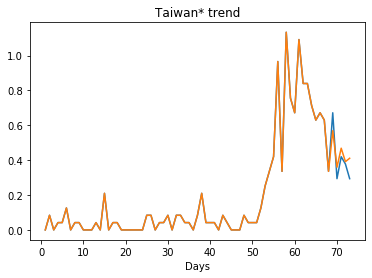

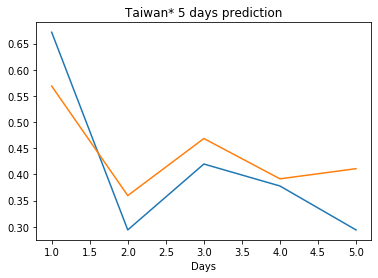

Creating directory ./offline8/Korea, South/training/
Korea, South
Saving the best model weights at Epoch [1], Best Valid Loss: 3.1189
Saving the best model weights at Epoch [3], Best Valid Loss: 2.2252
Saving the best model weights at Epoch [4], Best Valid Loss: 0.9584
Saving the best model weights at Epoch [13], Best Valid Loss: 0.8317
Saving the best model weights at Epoch [24], Best Valid Loss: 0.8142
Saving the best model weights at Epoch [27], Best Valid Loss: 0.7997
Saving the best model weights at Epoch [30], Best Valid Loss: 0.7957
Saving the best model weights at Epoch [32], Best Valid Loss: 0.6767
train error: 38.96461068956476
0.6766676306724548
Saving the best model weights at Epoch [1], Best Valid Loss: 2.5210
Saving the best model weights at Epoch [9], Best Valid Loss: 1.2731
Saving the best model weights at Epoch [34], Best Valid Loss: 1.0191
Saving the best model weights at Epoch [40], Best Valid Loss: 0.9077
train error: 28.57484728725333
0.9076828360557556
Saving the 

Saving the best model weights at Epoch [6], Best Valid Loss: 1.1025
Saving the best model weights at Epoch [14], Best Valid Loss: 0.3915
train error: 51.918048695514074
0.3914612829685211
Saving the best model weights at Epoch [1], Best Valid Loss: 20.6492
Saving the best model weights at Epoch [2], Best Valid Loss: 17.3116
train error: 163.34285581739326
17.311628341674805
Saving the best model weights at Epoch [1], Best Valid Loss: 20.6545
Saving the best model weights at Epoch [2], Best Valid Loss: 16.5016
Saving the best model weights at Epoch [3], Best Valid Loss: 13.1417
Saving the best model weights at Epoch [7], Best Valid Loss: 9.0683
Saving the best model weights at Epoch [12], Best Valid Loss: 6.8233
Saving the best model weights at Epoch [13], Best Valid Loss: 5.9585
Saving the best model weights at Epoch [16], Best Valid Loss: 3.6043
Saving the best model weights at Epoch [18], Best Valid Loss: 3.4930
Saving the best model weights at Epoch [22], Best Valid Loss: 3.4614
Sav

train error: 163.34285581739326
17.311628341674805
Saving the best model weights at Epoch [1], Best Valid Loss: 17.3116
train error: 163.34285581739326
17.311628341674805
Saving the best model weights at Epoch [1], Best Valid Loss: 43.4545
Saving the best model weights at Epoch [4], Best Valid Loss: 17.7378
Saving the best model weights at Epoch [9], Best Valid Loss: 14.9110
Saving the best model weights at Epoch [29], Best Valid Loss: 13.5846
Saving the best model weights at Epoch [40], Best Valid Loss: 13.2166
train error: 163.34285581739326
13.216644287109375
Saving the best model weights at Epoch [1], Best Valid Loss: 18.9529
Saving the best model weights at Epoch [2], Best Valid Loss: 18.1839
Saving the best model weights at Epoch [3], Best Valid Loss: 15.5402
Saving the best model weights at Epoch [5], Best Valid Loss: 7.1499
Saving the best model weights at Epoch [7], Best Valid Loss: 1.8000
Saving the best model weights at Epoch [18], Best Valid Loss: 1.4499
Saving the best mod

Saving the best model weights at Epoch [1], Best Valid Loss: 0.6316
Saving the best model weights at Epoch [28], Best Valid Loss: 0.5425
train error: 8.970100306342111
0.5424502491950989
Saving the best model weights at Epoch [1], Best Valid Loss: 26.6828
Saving the best model weights at Epoch [2], Best Valid Loss: 9.5472
Saving the best model weights at Epoch [3], Best Valid Loss: 9.0078
Saving the best model weights at Epoch [6], Best Valid Loss: 1.6703
Saving the best model weights at Epoch [44], Best Valid Loss: 1.2180
train error: 16.868592390888615
1.2179781198501587
Saving the best model weights at Epoch [1], Best Valid Loss: 6.5788
Saving the best model weights at Epoch [2], Best Valid Loss: 2.3994
Saving the best model weights at Epoch [3], Best Valid Loss: 2.3009
Saving the best model weights at Epoch [5], Best Valid Loss: 1.9306
Saving the best model weights at Epoch [6], Best Valid Loss: 0.8540
Saving the best model weights at Epoch [7], Best Valid Loss: 0.5531
train error:

train error: 24.05650034076289
0.6950157284736633
Saving the best model weights at Epoch [1], Best Valid Loss: 19.9535
Saving the best model weights at Epoch [2], Best Valid Loss: 17.5481
Saving the best model weights at Epoch [5], Best Valid Loss: 2.3837
Saving the best model weights at Epoch [7], Best Valid Loss: 2.1640
Saving the best model weights at Epoch [10], Best Valid Loss: 2.0666
Saving the best model weights at Epoch [11], Best Valid Loss: 1.1418
Saving the best model weights at Epoch [19], Best Valid Loss: 0.9952
Saving the best model weights at Epoch [22], Best Valid Loss: 0.3648
train error: 33.13624805212021
0.36481502652168274
Saving the best model weights at Epoch [1], Best Valid Loss: 6.6277
Saving the best model weights at Epoch [2], Best Valid Loss: 0.8857
Saving the best model weights at Epoch [5], Best Valid Loss: 0.8026
train error: 18.606272786071425
0.8025667071342468
Saving the best model weights at Epoch [1], Best Valid Loss: 4.7549
Saving the best model weig

Saving the best model weights at Epoch [7], Best Valid Loss: 0.9593
train error: 19.42322585614104
0.959251344203949
Saving the best model weights at Epoch [1], Best Valid Loss: 18.0956
Saving the best model weights at Epoch [5], Best Valid Loss: 11.9802
Saving the best model weights at Epoch [18], Best Valid Loss: 4.5586
Saving the best model weights at Epoch [20], Best Valid Loss: 2.5945
Saving the best model weights at Epoch [21], Best Valid Loss: 1.3782
Saving the best model weights at Epoch [25], Best Valid Loss: 1.3182
Saving the best model weights at Epoch [30], Best Valid Loss: 0.9773
train error: 22.959469114479266
0.9773320555686951
Saving the best model weights at Epoch [1], Best Valid Loss: 6.2452
Saving the best model weights at Epoch [2], Best Valid Loss: 1.3111
train error: 74.2154616431186
1.311087727546692
Saving the best model weights at Epoch [1], Best Valid Loss: 11.7536
train error: 127.512822402151
11.753560066223145
Saving the best model weights at Epoch [1], Bes

Saving the best model weights at Epoch [2], Best Valid Loss: 1.2940
Saving the best model weights at Epoch [3], Best Valid Loss: 0.7952
train error: 9.76447242576825
0.7951682209968567
Saving the best model weights at Epoch [1], Best Valid Loss: 16.1049
Saving the best model weights at Epoch [2], Best Valid Loss: 12.9180
Saving the best model weights at Epoch [3], Best Valid Loss: 8.6338
Saving the best model weights at Epoch [4], Best Valid Loss: 5.3078
Saving the best model weights at Epoch [5], Best Valid Loss: 3.2863
Saving the best model weights at Epoch [6], Best Valid Loss: 1.5901
Saving the best model weights at Epoch [7], Best Valid Loss: 1.2801
Saving the best model weights at Epoch [8], Best Valid Loss: 0.9348
Saving the best model weights at Epoch [9], Best Valid Loss: 0.7881
Saving the best model weights at Epoch [10], Best Valid Loss: 0.7669
train error: 14.459580414781446
0.7669030427932739
Saving the best model weights at Epoch [1], Best Valid Loss: 11.1420
Saving the b

Saving the best model weights at Epoch [22], Best Valid Loss: 11.6023
Saving the best model weights at Epoch [23], Best Valid Loss: 11.1348
Saving the best model weights at Epoch [24], Best Valid Loss: 10.7028
Saving the best model weights at Epoch [25], Best Valid Loss: 10.3085
Saving the best model weights at Epoch [26], Best Valid Loss: 9.9581
Saving the best model weights at Epoch [27], Best Valid Loss: 9.6546
Saving the best model weights at Epoch [28], Best Valid Loss: 9.3881
Saving the best model weights at Epoch [29], Best Valid Loss: 9.1705
Saving the best model weights at Epoch [30], Best Valid Loss: 8.9878
Saving the best model weights at Epoch [31], Best Valid Loss: 8.8385
Saving the best model weights at Epoch [32], Best Valid Loss: 8.7143
Saving the best model weights at Epoch [33], Best Valid Loss: 8.6107
Saving the best model weights at Epoch [34], Best Valid Loss: 8.5281
Saving the best model weights at Epoch [35], Best Valid Loss: 8.4422
Saving the best model weights 

Saving the best model weights at Epoch [4], Best Valid Loss: 14.5844
Saving the best model weights at Epoch [5], Best Valid Loss: 13.9849
Saving the best model weights at Epoch [6], Best Valid Loss: 13.2648
Saving the best model weights at Epoch [7], Best Valid Loss: 12.3014
Saving the best model weights at Epoch [8], Best Valid Loss: 11.2890
Saving the best model weights at Epoch [9], Best Valid Loss: 10.2082
Saving the best model weights at Epoch [10], Best Valid Loss: 9.0564
Saving the best model weights at Epoch [11], Best Valid Loss: 7.8557
Saving the best model weights at Epoch [12], Best Valid Loss: 6.7115
Saving the best model weights at Epoch [13], Best Valid Loss: 5.7162
Saving the best model weights at Epoch [14], Best Valid Loss: 5.0111
Saving the best model weights at Epoch [15], Best Valid Loss: 4.6730
Saving the best model weights at Epoch [16], Best Valid Loss: 4.6370
train error: 74.07767498493195
4.637042045593262
Saving the best model weights at Epoch [1], Best Valid

Saving the best model weights at Epoch [41], Best Valid Loss: 9.8870
Saving the best model weights at Epoch [42], Best Valid Loss: 9.1534
Saving the best model weights at Epoch [43], Best Valid Loss: 8.5930
Saving the best model weights at Epoch [44], Best Valid Loss: 8.1129
Saving the best model weights at Epoch [45], Best Valid Loss: 7.7381
Saving the best model weights at Epoch [46], Best Valid Loss: 7.4121
Saving the best model weights at Epoch [47], Best Valid Loss: 7.1251
Saving the best model weights at Epoch [48], Best Valid Loss: 6.8756
Saving the best model weights at Epoch [49], Best Valid Loss: 6.6482
Saving the best model weights at Epoch [50], Best Valid Loss: 6.4471
train error: 53.768022283127436
6.447078227996826
Saving the best model weights at Epoch [1], Best Valid Loss: 17.3116
train error: 163.34285581739326
17.311628341674805
Saving the best model weights at Epoch [1], Best Valid Loss: 16.5973
Saving the best model weights at Epoch [2], Best Valid Loss: 16.1192
Sa

Saving the best model weights at Epoch [8], Best Valid Loss: 7.3805
Saving the best model weights at Epoch [9], Best Valid Loss: 6.3093
Saving the best model weights at Epoch [10], Best Valid Loss: 6.1970
Saving the best model weights at Epoch [12], Best Valid Loss: 4.1754
Saving the best model weights at Epoch [14], Best Valid Loss: 3.7008
train error: 46.873823749391654
3.7008137702941895
Saving the best model weights at Epoch [1], Best Valid Loss: 15.9473
Saving the best model weights at Epoch [2], Best Valid Loss: 15.1595
Saving the best model weights at Epoch [3], Best Valid Loss: 14.4143
Saving the best model weights at Epoch [4], Best Valid Loss: 13.7113
Saving the best model weights at Epoch [5], Best Valid Loss: 13.0403
Saving the best model weights at Epoch [6], Best Valid Loss: 12.4085
Saving the best model weights at Epoch [7], Best Valid Loss: 11.8045
Saving the best model weights at Epoch [8], Best Valid Loss: 11.2364
Saving the best model weights at Epoch [9], Best Valid

Saving the best model weights at Epoch [22], Best Valid Loss: 3.8657
train error: 57.40794415615107
3.8656532764434814
Saving the best model weights at Epoch [1], Best Valid Loss: 16.4007
Saving the best model weights at Epoch [2], Best Valid Loss: 15.7947
Saving the best model weights at Epoch [3], Best Valid Loss: 15.2167
Saving the best model weights at Epoch [4], Best Valid Loss: 14.6709
Saving the best model weights at Epoch [5], Best Valid Loss: 14.1536
Saving the best model weights at Epoch [6], Best Valid Loss: 13.6629
Saving the best model weights at Epoch [7], Best Valid Loss: 13.1989
Saving the best model weights at Epoch [8], Best Valid Loss: 12.7575
Saving the best model weights at Epoch [9], Best Valid Loss: 12.3375
Saving the best model weights at Epoch [10], Best Valid Loss: 11.9410
Saving the best model weights at Epoch [11], Best Valid Loss: 11.5649
Saving the best model weights at Epoch [12], Best Valid Loss: 11.2096
Saving the best model weights at Epoch [13], Best 

Saving the best model weights at Epoch [11], Best Valid Loss: 11.3253
Saving the best model weights at Epoch [12], Best Valid Loss: 11.0456
Saving the best model weights at Epoch [13], Best Valid Loss: 10.7973
Saving the best model weights at Epoch [14], Best Valid Loss: 10.5789
Saving the best model weights at Epoch [15], Best Valid Loss: 10.3866
Saving the best model weights at Epoch [16], Best Valid Loss: 10.2246
Saving the best model weights at Epoch [17], Best Valid Loss: 10.0924
Saving the best model weights at Epoch [18], Best Valid Loss: 9.9905
Saving the best model weights at Epoch [19], Best Valid Loss: 9.9175
Saving the best model weights at Epoch [20], Best Valid Loss: 9.8744
Saving the best model weights at Epoch [21], Best Valid Loss: 9.8623
train error: 111.91353372523659
9.862292289733887
Saving the best model weights at Epoch [1], Best Valid Loss: 16.6753
Saving the best model weights at Epoch [2], Best Valid Loss: 16.4008
Saving the best model weights at Epoch [3], Be

Saving the best model weights at Epoch [24], Best Valid Loss: 14.0228
Saving the best model weights at Epoch [25], Best Valid Loss: 14.0053
Saving the best model weights at Epoch [26], Best Valid Loss: 13.7880
Saving the best model weights at Epoch [27], Best Valid Loss: 13.4875
Saving the best model weights at Epoch [28], Best Valid Loss: 13.2093
Saving the best model weights at Epoch [29], Best Valid Loss: 12.9566
Saving the best model weights at Epoch [30], Best Valid Loss: 12.7236
Saving the best model weights at Epoch [31], Best Valid Loss: 12.5152
Saving the best model weights at Epoch [32], Best Valid Loss: 12.3306
Saving the best model weights at Epoch [33], Best Valid Loss: 12.1694
Saving the best model weights at Epoch [34], Best Valid Loss: 12.0326
Saving the best model weights at Epoch [35], Best Valid Loss: 11.9197
Saving the best model weights at Epoch [36], Best Valid Loss: 11.8306
Saving the best model weights at Epoch [37], Best Valid Loss: 11.7685
Saving the best mode

Saving the best model weights at Epoch [31], Best Valid Loss: 9.6281
Saving the best model weights at Epoch [32], Best Valid Loss: 9.4804
Saving the best model weights at Epoch [33], Best Valid Loss: 9.3446
Saving the best model weights at Epoch [34], Best Valid Loss: 9.2282
Saving the best model weights at Epoch [35], Best Valid Loss: 9.1070
Saving the best model weights at Epoch [36], Best Valid Loss: 9.0142
Saving the best model weights at Epoch [37], Best Valid Loss: 8.9196
Saving the best model weights at Epoch [38], Best Valid Loss: 8.8381
Saving the best model weights at Epoch [39], Best Valid Loss: 8.7602
Saving the best model weights at Epoch [40], Best Valid Loss: 8.6926
Saving the best model weights at Epoch [41], Best Valid Loss: 8.5842
Saving the best model weights at Epoch [42], Best Valid Loss: 8.4792
Saving the best model weights at Epoch [43], Best Valid Loss: 8.3493
Saving the best model weights at Epoch [44], Best Valid Loss: 8.1672
Saving the best model weights at E

Saving the best model weights at Epoch [22], Best Valid Loss: 8.6797
Saving the best model weights at Epoch [23], Best Valid Loss: 7.9583
Saving the best model weights at Epoch [24], Best Valid Loss: 7.2220
Saving the best model weights at Epoch [25], Best Valid Loss: 6.4957
Saving the best model weights at Epoch [26], Best Valid Loss: 5.7896
Saving the best model weights at Epoch [27], Best Valid Loss: 5.0975
Saving the best model weights at Epoch [28], Best Valid Loss: 4.4386
Saving the best model weights at Epoch [29], Best Valid Loss: 3.8516
Saving the best model weights at Epoch [30], Best Valid Loss: 3.3462
Saving the best model weights at Epoch [31], Best Valid Loss: 2.9268
Saving the best model weights at Epoch [32], Best Valid Loss: 2.5900
Saving the best model weights at Epoch [33], Best Valid Loss: 2.3118
Saving the best model weights at Epoch [34], Best Valid Loss: 2.0783
Saving the best model weights at Epoch [35], Best Valid Loss: 1.8775
Saving the best model weights at E

Saving the best model weights at Epoch [11], Best Valid Loss: 10.9908
Saving the best model weights at Epoch [12], Best Valid Loss: 9.9420
Saving the best model weights at Epoch [13], Best Valid Loss: 8.7835
Saving the best model weights at Epoch [14], Best Valid Loss: 7.6394
Saving the best model weights at Epoch [15], Best Valid Loss: 6.5817
Saving the best model weights at Epoch [16], Best Valid Loss: 5.6543
Saving the best model weights at Epoch [17], Best Valid Loss: 4.8564
Saving the best model weights at Epoch [18], Best Valid Loss: 4.1666
Saving the best model weights at Epoch [19], Best Valid Loss: 3.5638
Saving the best model weights at Epoch [20], Best Valid Loss: 3.0510
Saving the best model weights at Epoch [21], Best Valid Loss: 2.6292
Saving the best model weights at Epoch [22], Best Valid Loss: 2.2611
Saving the best model weights at Epoch [23], Best Valid Loss: 1.9427
Saving the best model weights at Epoch [24], Best Valid Loss: 1.6883
Saving the best model weights at 

Saving the best model weights at Epoch [3], Best Valid Loss: 17.1811
Saving the best model weights at Epoch [4], Best Valid Loss: 17.1321
Saving the best model weights at Epoch [5], Best Valid Loss: 17.0818
Saving the best model weights at Epoch [6], Best Valid Loss: 17.0318
Saving the best model weights at Epoch [7], Best Valid Loss: 16.9485
Saving the best model weights at Epoch [8], Best Valid Loss: 16.8601
Saving the best model weights at Epoch [9], Best Valid Loss: 16.7695
Saving the best model weights at Epoch [10], Best Valid Loss: 16.6817
Saving the best model weights at Epoch [11], Best Valid Loss: 16.5959
Saving the best model weights at Epoch [12], Best Valid Loss: 16.5112
Saving the best model weights at Epoch [13], Best Valid Loss: 16.4257
Saving the best model weights at Epoch [14], Best Valid Loss: 16.3442
Saving the best model weights at Epoch [15], Best Valid Loss: 16.2612
Saving the best model weights at Epoch [16], Best Valid Loss: 16.1808
Saving the best model weigh

Saving the best model weights at Epoch [46], Best Valid Loss: 13.4255
Saving the best model weights at Epoch [47], Best Valid Loss: 13.3577
Saving the best model weights at Epoch [48], Best Valid Loss: 13.2896
Saving the best model weights at Epoch [49], Best Valid Loss: 13.2220
Saving the best model weights at Epoch [50], Best Valid Loss: 13.1548
train error: 152.87152966072685
13.1548433303833
Saving the best model weights at Epoch [1], Best Valid Loss: 17.3116
train error: 163.34285581739326
17.311628341674805
Saving the best model weights at Epoch [1], Best Valid Loss: 16.0489
Saving the best model weights at Epoch [2], Best Valid Loss: 15.0023
Saving the best model weights at Epoch [3], Best Valid Loss: 14.0778
Saving the best model weights at Epoch [4], Best Valid Loss: 13.1426
Saving the best model weights at Epoch [5], Best Valid Loss: 12.3115
Saving the best model weights at Epoch [6], Best Valid Loss: 11.3981
Saving the best model weights at Epoch [7], Best Valid Loss: 10.580

Saving the best model weights at Epoch [40], Best Valid Loss: 14.2621
Saving the best model weights at Epoch [41], Best Valid Loss: 14.2071
Saving the best model weights at Epoch [42], Best Valid Loss: 14.1544
Saving the best model weights at Epoch [43], Best Valid Loss: 14.1034
Saving the best model weights at Epoch [44], Best Valid Loss: 14.0503
Saving the best model weights at Epoch [45], Best Valid Loss: 13.9990
Saving the best model weights at Epoch [46], Best Valid Loss: 13.9479
Saving the best model weights at Epoch [47], Best Valid Loss: 13.8978
Saving the best model weights at Epoch [48], Best Valid Loss: 13.8500
Saving the best model weights at Epoch [49], Best Valid Loss: 13.7992
Saving the best model weights at Epoch [50], Best Valid Loss: 13.7505
train error: 151.48271714386186
13.750534057617188
Saving the best model weights at Epoch [1], Best Valid Loss: 16.0505
Saving the best model weights at Epoch [2], Best Valid Loss: 14.9650
Saving the best model weights at Epoch [3

Saving the best model weights at Epoch [23], Best Valid Loss: 14.3686
Saving the best model weights at Epoch [24], Best Valid Loss: 14.2133
Saving the best model weights at Epoch [25], Best Valid Loss: 14.0518
Saving the best model weights at Epoch [26], Best Valid Loss: 13.8950
Saving the best model weights at Epoch [27], Best Valid Loss: 13.7394
Saving the best model weights at Epoch [28], Best Valid Loss: 13.5774
Saving the best model weights at Epoch [29], Best Valid Loss: 13.4223
Saving the best model weights at Epoch [30], Best Valid Loss: 13.2565
Saving the best model weights at Epoch [31], Best Valid Loss: 13.0945
Saving the best model weights at Epoch [32], Best Valid Loss: 12.9331
Saving the best model weights at Epoch [33], Best Valid Loss: 12.7608
Saving the best model weights at Epoch [34], Best Valid Loss: 12.6004
Saving the best model weights at Epoch [35], Best Valid Loss: 12.4235
Saving the best model weights at Epoch [36], Best Valid Loss: 12.2476
Saving the best mode

Saving the best model weights at Epoch [26], Best Valid Loss: 13.3239
Saving the best model weights at Epoch [27], Best Valid Loss: 13.2241
Saving the best model weights at Epoch [28], Best Valid Loss: 13.1245
Saving the best model weights at Epoch [29], Best Valid Loss: 13.0253
Saving the best model weights at Epoch [30], Best Valid Loss: 12.9260
Saving the best model weights at Epoch [31], Best Valid Loss: 12.8302
Saving the best model weights at Epoch [32], Best Valid Loss: 12.7365
Saving the best model weights at Epoch [33], Best Valid Loss: 12.6391
Saving the best model weights at Epoch [34], Best Valid Loss: 12.5450
Saving the best model weights at Epoch [35], Best Valid Loss: 12.4511
Saving the best model weights at Epoch [36], Best Valid Loss: 12.3595
Saving the best model weights at Epoch [37], Best Valid Loss: 12.2715
Saving the best model weights at Epoch [38], Best Valid Loss: 12.1811
Saving the best model weights at Epoch [39], Best Valid Loss: 12.0916
Saving the best mode

Saving the best model weights at Epoch [8], Best Valid Loss: 15.9461
Saving the best model weights at Epoch [9], Best Valid Loss: 15.8040
Saving the best model weights at Epoch [10], Best Valid Loss: 15.6644
Saving the best model weights at Epoch [11], Best Valid Loss: 15.5311
Saving the best model weights at Epoch [12], Best Valid Loss: 15.3937
Saving the best model weights at Epoch [13], Best Valid Loss: 15.2596
Saving the best model weights at Epoch [14], Best Valid Loss: 15.1292
Saving the best model weights at Epoch [15], Best Valid Loss: 14.9952
Saving the best model weights at Epoch [16], Best Valid Loss: 14.8652
Saving the best model weights at Epoch [17], Best Valid Loss: 14.7362
Saving the best model weights at Epoch [18], Best Valid Loss: 14.6092
Saving the best model weights at Epoch [19], Best Valid Loss: 14.4870
Saving the best model weights at Epoch [20], Best Valid Loss: 14.3586
Saving the best model weights at Epoch [21], Best Valid Loss: 14.2388
Saving the best model 

Saving the best model weights at Epoch [48], Best Valid Loss: 14.2704
Saving the best model weights at Epoch [49], Best Valid Loss: 14.1875
Saving the best model weights at Epoch [50], Best Valid Loss: 14.1052
train error: 153.99790418775459
14.105224609375
Saving the best model weights at Epoch [1], Best Valid Loss: 17.1973
Saving the best model weights at Epoch [2], Best Valid Loss: 17.1598
Saving the best model weights at Epoch [3], Best Valid Loss: 17.1243
Saving the best model weights at Epoch [4], Best Valid Loss: 17.0890
Saving the best model weights at Epoch [5], Best Valid Loss: 17.0545
Saving the best model weights at Epoch [6], Best Valid Loss: 17.0200
Saving the best model weights at Epoch [7], Best Valid Loss: 16.9863
Saving the best model weights at Epoch [8], Best Valid Loss: 16.9528
Saving the best model weights at Epoch [9], Best Valid Loss: 16.9205
Saving the best model weights at Epoch [10], Best Valid Loss: 16.8885
Saving the best model weights at Epoch [11], Best V

Saving the best model weights at Epoch [39], Best Valid Loss: 14.9491
Saving the best model weights at Epoch [40], Best Valid Loss: 14.9019
Saving the best model weights at Epoch [41], Best Valid Loss: 14.8550
Saving the best model weights at Epoch [42], Best Valid Loss: 14.8086
Saving the best model weights at Epoch [43], Best Valid Loss: 14.7621
Saving the best model weights at Epoch [44], Best Valid Loss: 14.7160
Saving the best model weights at Epoch [45], Best Valid Loss: 14.6701
Saving the best model weights at Epoch [46], Best Valid Loss: 14.6248
Saving the best model weights at Epoch [47], Best Valid Loss: 14.5792
Saving the best model weights at Epoch [48], Best Valid Loss: 14.5343
Saving the best model weights at Epoch [49], Best Valid Loss: 14.4894
Saving the best model weights at Epoch [50], Best Valid Loss: 14.4448
train error: 156.62029609554693
14.44480037689209
Saving the best model weights at Epoch [1], Best Valid Loss: 17.3116
train error: 163.34285581739326
17.311628

Saving the best model weights at Epoch [9], Best Valid Loss: 15.4303
Saving the best model weights at Epoch [10], Best Valid Loss: 15.2913
Saving the best model weights at Epoch [11], Best Valid Loss: 15.1572
Saving the best model weights at Epoch [12], Best Valid Loss: 15.0271
Saving the best model weights at Epoch [13], Best Valid Loss: 14.8910
Saving the best model weights at Epoch [14], Best Valid Loss: 14.7630
Saving the best model weights at Epoch [15], Best Valid Loss: 14.6327
Saving the best model weights at Epoch [16], Best Valid Loss: 14.5055
Saving the best model weights at Epoch [17], Best Valid Loss: 14.3798
Saving the best model weights at Epoch [18], Best Valid Loss: 14.2546
Saving the best model weights at Epoch [19], Best Valid Loss: 14.1338
Saving the best model weights at Epoch [20], Best Valid Loss: 14.0067
Saving the best model weights at Epoch [21], Best Valid Loss: 13.8854
Saving the best model weights at Epoch [22], Best Valid Loss: 13.7651
Saving the best model

Saving the best model weights at Epoch [4], Best Valid Loss: 16.8767
Saving the best model weights at Epoch [5], Best Valid Loss: 16.8295
Saving the best model weights at Epoch [6], Best Valid Loss: 16.7838
Saving the best model weights at Epoch [7], Best Valid Loss: 16.7392
Saving the best model weights at Epoch [8], Best Valid Loss: 16.6934
Saving the best model weights at Epoch [9], Best Valid Loss: 16.6499
Saving the best model weights at Epoch [10], Best Valid Loss: 16.6071
Saving the best model weights at Epoch [11], Best Valid Loss: 16.5627
Saving the best model weights at Epoch [12], Best Valid Loss: 16.5198
Saving the best model weights at Epoch [13], Best Valid Loss: 16.4786
Saving the best model weights at Epoch [14], Best Valid Loss: 16.4352
Saving the best model weights at Epoch [15], Best Valid Loss: 16.3940
Saving the best model weights at Epoch [16], Best Valid Loss: 16.3528
Saving the best model weights at Epoch [17], Best Valid Loss: 16.3143
Saving the best model weig

Saving the best model weights at Epoch [44], Best Valid Loss: 13.1190
Saving the best model weights at Epoch [45], Best Valid Loss: 13.0254
Saving the best model weights at Epoch [46], Best Valid Loss: 12.9326
Saving the best model weights at Epoch [47], Best Valid Loss: 12.8403
Saving the best model weights at Epoch [48], Best Valid Loss: 12.7491
Saving the best model weights at Epoch [49], Best Valid Loss: 12.6572
Saving the best model weights at Epoch [50], Best Valid Loss: 12.5670
train error: 151.2815691985582
12.56696605682373
Saving the best model weights at Epoch [1], Best Valid Loss: 17.1447
Saving the best model weights at Epoch [2], Best Valid Loss: 17.0580
Saving the best model weights at Epoch [3], Best Valid Loss: 16.9745
Saving the best model weights at Epoch [4], Best Valid Loss: 16.8905
Saving the best model weights at Epoch [5], Best Valid Loss: 16.8087
Saving the best model weights at Epoch [6], Best Valid Loss: 16.7280
Saving the best model weights at Epoch [7], Bes

Saving the best model weights at Epoch [26], Best Valid Loss: 16.2275
Saving the best model weights at Epoch [27], Best Valid Loss: 16.1932
Saving the best model weights at Epoch [28], Best Valid Loss: 16.1590
Saving the best model weights at Epoch [29], Best Valid Loss: 16.1251
Saving the best model weights at Epoch [30], Best Valid Loss: 16.0912
Saving the best model weights at Epoch [31], Best Valid Loss: 16.0577
Saving the best model weights at Epoch [32], Best Valid Loss: 16.0242
Saving the best model weights at Epoch [33], Best Valid Loss: 15.9906
Saving the best model weights at Epoch [34], Best Valid Loss: 15.9573
Saving the best model weights at Epoch [35], Best Valid Loss: 15.9242
Saving the best model weights at Epoch [36], Best Valid Loss: 15.8914
Saving the best model weights at Epoch [37], Best Valid Loss: 15.8586
Saving the best model weights at Epoch [38], Best Valid Loss: 15.8260
Saving the best model weights at Epoch [39], Best Valid Loss: 15.7936
Saving the best mode

Saving the best model weights at Epoch [18], Best Valid Loss: 13.9418
Saving the best model weights at Epoch [19], Best Valid Loss: 13.8430
Saving the best model weights at Epoch [20], Best Valid Loss: 13.7442
Saving the best model weights at Epoch [21], Best Valid Loss: 13.6466
Saving the best model weights at Epoch [22], Best Valid Loss: 13.5488
Saving the best model weights at Epoch [23], Best Valid Loss: 13.4517
Saving the best model weights at Epoch [24], Best Valid Loss: 13.3555
Saving the best model weights at Epoch [25], Best Valid Loss: 13.2596
Saving the best model weights at Epoch [26], Best Valid Loss: 13.1639
Saving the best model weights at Epoch [27], Best Valid Loss: 13.0693
Saving the best model weights at Epoch [28], Best Valid Loss: 12.9750
Saving the best model weights at Epoch [29], Best Valid Loss: 12.8806
Saving the best model weights at Epoch [30], Best Valid Loss: 12.7872
Saving the best model weights at Epoch [31], Best Valid Loss: 12.6947
Saving the best mode

Saving the best model weights at Epoch [6], Best Valid Loss: 16.5367
Saving the best model weights at Epoch [7], Best Valid Loss: 16.4667
Saving the best model weights at Epoch [8], Best Valid Loss: 16.3954
Saving the best model weights at Epoch [9], Best Valid Loss: 16.3267
Saving the best model weights at Epoch [10], Best Valid Loss: 16.2594
Saving the best model weights at Epoch [11], Best Valid Loss: 16.1924
Saving the best model weights at Epoch [12], Best Valid Loss: 16.1249
Saving the best model weights at Epoch [13], Best Valid Loss: 16.0591
Saving the best model weights at Epoch [14], Best Valid Loss: 15.9957
Saving the best model weights at Epoch [15], Best Valid Loss: 15.9303
Saving the best model weights at Epoch [16], Best Valid Loss: 15.8685
Saving the best model weights at Epoch [17], Best Valid Loss: 15.8058
Saving the best model weights at Epoch [18], Best Valid Loss: 15.7459
Saving the best model weights at Epoch [19], Best Valid Loss: 15.6840
Saving the best model we

Saving the best model weights at Epoch [46], Best Valid Loss: 13.4129
Saving the best model weights at Epoch [47], Best Valid Loss: 13.3457
Saving the best model weights at Epoch [48], Best Valid Loss: 13.2788
Saving the best model weights at Epoch [49], Best Valid Loss: 13.2125
Saving the best model weights at Epoch [50], Best Valid Loss: 13.1465
train error: 153.47897035197207
13.146498680114746
Saving the best model weights at Epoch [1], Best Valid Loss: 16.8872
Saving the best model weights at Epoch [2], Best Valid Loss: 16.7315
Saving the best model weights at Epoch [3], Best Valid Loss: 16.5768
Saving the best model weights at Epoch [4], Best Valid Loss: 16.4234
Saving the best model weights at Epoch [5], Best Valid Loss: 16.2771
Saving the best model weights at Epoch [6], Best Valid Loss: 16.1294
Saving the best model weights at Epoch [7], Best Valid Loss: 15.9764
Saving the best model weights at Epoch [8], Best Valid Loss: 15.8309
Saving the best model weights at Epoch [9], Bes

Saving the best model weights at Epoch [35], Best Valid Loss: 13.4492
Saving the best model weights at Epoch [36], Best Valid Loss: 13.3628
Saving the best model weights at Epoch [37], Best Valid Loss: 13.2797
Saving the best model weights at Epoch [38], Best Valid Loss: 13.1914
Saving the best model weights at Epoch [39], Best Valid Loss: 13.1070
Saving the best model weights at Epoch [40], Best Valid Loss: 13.0248
Saving the best model weights at Epoch [41], Best Valid Loss: 12.9405
Saving the best model weights at Epoch [42], Best Valid Loss: 12.8603
Saving the best model weights at Epoch [43], Best Valid Loss: 12.7759
Saving the best model weights at Epoch [44], Best Valid Loss: 12.7000
Saving the best model weights at Epoch [45], Best Valid Loss: 12.6187
Saving the best model weights at Epoch [46], Best Valid Loss: 12.5392
Saving the best model weights at Epoch [47], Best Valid Loss: 12.4576
Saving the best model weights at Epoch [48], Best Valid Loss: 12.3789
Saving the best mode

Saving the best model weights at Epoch [29], Best Valid Loss: 15.9822
Saving the best model weights at Epoch [30], Best Valid Loss: 15.9738
Saving the best model weights at Epoch [31], Best Valid Loss: 15.9662
Saving the best model weights at Epoch [32], Best Valid Loss: 15.9577
Saving the best model weights at Epoch [33], Best Valid Loss: 15.9496
Saving the best model weights at Epoch [34], Best Valid Loss: 15.9419
Saving the best model weights at Epoch [35], Best Valid Loss: 15.9343
Saving the best model weights at Epoch [36], Best Valid Loss: 15.9265
Saving the best model weights at Epoch [37], Best Valid Loss: 15.9189
Saving the best model weights at Epoch [38], Best Valid Loss: 15.9110
Saving the best model weights at Epoch [39], Best Valid Loss: 15.9038
Saving the best model weights at Epoch [40], Best Valid Loss: 15.8968
Saving the best model weights at Epoch [41], Best Valid Loss: 15.8898
Saving the best model weights at Epoch [42], Best Valid Loss: 15.8834
Saving the best mode

Saving the best model weights at Epoch [3], Best Valid Loss: 16.7442
Saving the best model weights at Epoch [4], Best Valid Loss: 16.7350
Saving the best model weights at Epoch [5], Best Valid Loss: 16.7255
Saving the best model weights at Epoch [6], Best Valid Loss: 16.7166
Saving the best model weights at Epoch [7], Best Valid Loss: 16.7076
Saving the best model weights at Epoch [8], Best Valid Loss: 16.6991
Saving the best model weights at Epoch [9], Best Valid Loss: 16.6898
Saving the best model weights at Epoch [10], Best Valid Loss: 16.6805
Saving the best model weights at Epoch [11], Best Valid Loss: 16.6714
Saving the best model weights at Epoch [12], Best Valid Loss: 16.6624
Saving the best model weights at Epoch [13], Best Valid Loss: 16.6533
Saving the best model weights at Epoch [14], Best Valid Loss: 16.6444
Saving the best model weights at Epoch [15], Best Valid Loss: 16.6358
Saving the best model weights at Epoch [16], Best Valid Loss: 16.6267
Saving the best model weigh

Saving the best model weights at Epoch [20], Best Valid Loss: 16.6783
Saving the best model weights at Epoch [21], Best Valid Loss: 16.6682
Saving the best model weights at Epoch [22], Best Valid Loss: 16.6582
Saving the best model weights at Epoch [23], Best Valid Loss: 16.6477
Saving the best model weights at Epoch [24], Best Valid Loss: 16.6369
Saving the best model weights at Epoch [25], Best Valid Loss: 16.6259
Saving the best model weights at Epoch [26], Best Valid Loss: 16.6150
Saving the best model weights at Epoch [27], Best Valid Loss: 16.6033
Saving the best model weights at Epoch [28], Best Valid Loss: 16.5918
Saving the best model weights at Epoch [29], Best Valid Loss: 16.5803
Saving the best model weights at Epoch [30], Best Valid Loss: 16.5687
Saving the best model weights at Epoch [31], Best Valid Loss: 16.5568
Saving the best model weights at Epoch [32], Best Valid Loss: 16.5449
Saving the best model weights at Epoch [33], Best Valid Loss: 16.5332
Saving the best mode

Saving the best model weights at Epoch [45], Best Valid Loss: 3.7242
Saving the best model weights at Epoch [46], Best Valid Loss: 3.4943
Saving the best model weights at Epoch [47], Best Valid Loss: 3.2684
Saving the best model weights at Epoch [48], Best Valid Loss: 3.0679
Saving the best model weights at Epoch [49], Best Valid Loss: 2.8875
Saving the best model weights at Epoch [50], Best Valid Loss: 2.7122
train error: 90.8963450805137
2.712179183959961
Saving the best model weights at Epoch [1], Best Valid Loss: 16.9600
Saving the best model weights at Epoch [2], Best Valid Loss: 16.9501
Saving the best model weights at Epoch [3], Best Valid Loss: 16.9400
Saving the best model weights at Epoch [4], Best Valid Loss: 16.9296
Saving the best model weights at Epoch [5], Best Valid Loss: 16.9188
Saving the best model weights at Epoch [6], Best Valid Loss: 16.9077
Saving the best model weights at Epoch [7], Best Valid Loss: 16.8966
Saving the best model weights at Epoch [8], Best Valid 

Saving the best model weights at Epoch [11], Best Valid Loss: 14.7188
Saving the best model weights at Epoch [12], Best Valid Loss: 14.3270
Saving the best model weights at Epoch [13], Best Valid Loss: 13.9378
Saving the best model weights at Epoch [14], Best Valid Loss: 13.5759
Saving the best model weights at Epoch [15], Best Valid Loss: 13.1559
Saving the best model weights at Epoch [16], Best Valid Loss: 12.7835
Saving the best model weights at Epoch [17], Best Valid Loss: 12.3911
Saving the best model weights at Epoch [18], Best Valid Loss: 12.0133
Saving the best model weights at Epoch [19], Best Valid Loss: 11.6438
Saving the best model weights at Epoch [20], Best Valid Loss: 11.2765
Saving the best model weights at Epoch [21], Best Valid Loss: 10.9483
Saving the best model weights at Epoch [22], Best Valid Loss: 10.5536
Saving the best model weights at Epoch [23], Best Valid Loss: 10.2088
Saving the best model weights at Epoch [24], Best Valid Loss: 9.8862
Saving the best model

Saving the best model weights at Epoch [28], Best Valid Loss: 16.5305
Saving the best model weights at Epoch [29], Best Valid Loss: 16.5203
Saving the best model weights at Epoch [30], Best Valid Loss: 16.5097
Saving the best model weights at Epoch [31], Best Valid Loss: 16.4993
Saving the best model weights at Epoch [32], Best Valid Loss: 16.4885
Saving the best model weights at Epoch [33], Best Valid Loss: 16.4780
Saving the best model weights at Epoch [34], Best Valid Loss: 16.4671
Saving the best model weights at Epoch [35], Best Valid Loss: 16.4566
Saving the best model weights at Epoch [36], Best Valid Loss: 16.4458
Saving the best model weights at Epoch [37], Best Valid Loss: 16.4354
Saving the best model weights at Epoch [38], Best Valid Loss: 16.4248
Saving the best model weights at Epoch [39], Best Valid Loss: 16.4139
Saving the best model weights at Epoch [40], Best Valid Loss: 16.4032
Saving the best model weights at Epoch [41], Best Valid Loss: 16.3922
Saving the best mode

Saving the best model weights at Epoch [44], Best Valid Loss: 17.1385
Saving the best model weights at Epoch [45], Best Valid Loss: 17.1361
Saving the best model weights at Epoch [46], Best Valid Loss: 17.1337
Saving the best model weights at Epoch [47], Best Valid Loss: 17.1314
Saving the best model weights at Epoch [48], Best Valid Loss: 17.1290
Saving the best model weights at Epoch [49], Best Valid Loss: 17.1266
Saving the best model weights at Epoch [50], Best Valid Loss: 17.1243
train error: 162.86122294476158
17.1242733001709
Saving the best model weights at Epoch [1], Best Valid Loss: 16.8629
Saving the best model weights at Epoch [2], Best Valid Loss: 16.8463
Saving the best model weights at Epoch [3], Best Valid Loss: 16.8302
Saving the best model weights at Epoch [4], Best Valid Loss: 16.8141
Saving the best model weights at Epoch [5], Best Valid Loss: 16.7979
Saving the best model weights at Epoch [6], Best Valid Loss: 16.7823
Saving the best model weights at Epoch [7], Bes

Saving the best model weights at Epoch [10], Best Valid Loss: 16.7730
Saving the best model weights at Epoch [11], Best Valid Loss: 16.7660
Saving the best model weights at Epoch [12], Best Valid Loss: 16.7590
Saving the best model weights at Epoch [13], Best Valid Loss: 16.7519
Saving the best model weights at Epoch [14], Best Valid Loss: 16.7449
Saving the best model weights at Epoch [15], Best Valid Loss: 16.7379
Saving the best model weights at Epoch [16], Best Valid Loss: 16.7309
Saving the best model weights at Epoch [17], Best Valid Loss: 16.7238
Saving the best model weights at Epoch [18], Best Valid Loss: 16.7168
Saving the best model weights at Epoch [19], Best Valid Loss: 16.7098
Saving the best model weights at Epoch [20], Best Valid Loss: 16.7029
Saving the best model weights at Epoch [21], Best Valid Loss: 16.6958
Saving the best model weights at Epoch [22], Best Valid Loss: 16.6889
Saving the best model weights at Epoch [23], Best Valid Loss: 16.6819
Saving the best mode

Saving the best model weights at Epoch [26], Best Valid Loss: 14.8597
Saving the best model weights at Epoch [27], Best Valid Loss: 14.7851
Saving the best model weights at Epoch [28], Best Valid Loss: 14.7055
Saving the best model weights at Epoch [29], Best Valid Loss: 14.6285
Saving the best model weights at Epoch [30], Best Valid Loss: 14.5572
Saving the best model weights at Epoch [31], Best Valid Loss: 14.4707
Saving the best model weights at Epoch [32], Best Valid Loss: 14.3955
Saving the best model weights at Epoch [33], Best Valid Loss: 14.3208
Saving the best model weights at Epoch [34], Best Valid Loss: 14.2476
Saving the best model weights at Epoch [35], Best Valid Loss: 14.1714
Saving the best model weights at Epoch [36], Best Valid Loss: 14.0938
Saving the best model weights at Epoch [37], Best Valid Loss: 14.0174
Saving the best model weights at Epoch [38], Best Valid Loss: 13.9465
Saving the best model weights at Epoch [39], Best Valid Loss: 13.8735
Saving the best mode

Saving the best model weights at Epoch [42], Best Valid Loss: 16.7171
Saving the best model weights at Epoch [43], Best Valid Loss: 16.7005
Saving the best model weights at Epoch [44], Best Valid Loss: 16.6841
Saving the best model weights at Epoch [45], Best Valid Loss: 16.6678
Saving the best model weights at Epoch [46], Best Valid Loss: 16.6519
Saving the best model weights at Epoch [47], Best Valid Loss: 16.6343
Saving the best model weights at Epoch [48], Best Valid Loss: 16.6175
Saving the best model weights at Epoch [49], Best Valid Loss: 16.5998
Saving the best model weights at Epoch [50], Best Valid Loss: 16.5816
train error: 161.1498685259568
16.581571578979492
Saving the best model weights at Epoch [1], Best Valid Loss: 17.0590
Saving the best model weights at Epoch [2], Best Valid Loss: 17.0057
Saving the best model weights at Epoch [3], Best Valid Loss: 16.9503
Saving the best model weights at Epoch [4], Best Valid Loss: 16.8943
Saving the best model weights at Epoch [5], 

Saving the best model weights at Epoch [8], Best Valid Loss: 16.9061
Saving the best model weights at Epoch [9], Best Valid Loss: 16.8930
Saving the best model weights at Epoch [10], Best Valid Loss: 16.8804
Saving the best model weights at Epoch [11], Best Valid Loss: 16.8676
Saving the best model weights at Epoch [12], Best Valid Loss: 16.8549
Saving the best model weights at Epoch [13], Best Valid Loss: 16.8427
Saving the best model weights at Epoch [14], Best Valid Loss: 16.8301
Saving the best model weights at Epoch [15], Best Valid Loss: 16.8172
Saving the best model weights at Epoch [16], Best Valid Loss: 16.8048
Saving the best model weights at Epoch [17], Best Valid Loss: 16.7922
Saving the best model weights at Epoch [18], Best Valid Loss: 16.7796
Saving the best model weights at Epoch [19], Best Valid Loss: 16.7673
Saving the best model weights at Epoch [20], Best Valid Loss: 16.7544
Saving the best model weights at Epoch [21], Best Valid Loss: 16.7421
Saving the best model 

Saving the best model weights at Epoch [24], Best Valid Loss: 16.7534
Saving the best model weights at Epoch [25], Best Valid Loss: 16.7480
Saving the best model weights at Epoch [26], Best Valid Loss: 16.7427
Saving the best model weights at Epoch [27], Best Valid Loss: 16.7373
Saving the best model weights at Epoch [28], Best Valid Loss: 16.7319
Saving the best model weights at Epoch [29], Best Valid Loss: 16.7266
Saving the best model weights at Epoch [30], Best Valid Loss: 16.7212
Saving the best model weights at Epoch [31], Best Valid Loss: 16.7158
Saving the best model weights at Epoch [32], Best Valid Loss: 16.7104
Saving the best model weights at Epoch [33], Best Valid Loss: 16.7051
Saving the best model weights at Epoch [34], Best Valid Loss: 16.6998
Saving the best model weights at Epoch [35], Best Valid Loss: 16.6944
Saving the best model weights at Epoch [36], Best Valid Loss: 16.6890
Saving the best model weights at Epoch [37], Best Valid Loss: 16.6837
Saving the best mode

Saving the best model weights at Epoch [40], Best Valid Loss: 13.1760
Saving the best model weights at Epoch [41], Best Valid Loss: 13.0848
Saving the best model weights at Epoch [42], Best Valid Loss: 13.0045
Saving the best model weights at Epoch [43], Best Valid Loss: 12.9167
Saving the best model weights at Epoch [44], Best Valid Loss: 12.8342
Saving the best model weights at Epoch [45], Best Valid Loss: 12.7499
Saving the best model weights at Epoch [46], Best Valid Loss: 12.6703
Saving the best model weights at Epoch [47], Best Valid Loss: 12.5762
Saving the best model weights at Epoch [48], Best Valid Loss: 12.4906
Saving the best model weights at Epoch [49], Best Valid Loss: 12.4118
Saving the best model weights at Epoch [50], Best Valid Loss: 12.3269
train error: 151.97625692267167
12.326865196228027
Saving the best model weights at Epoch [1], Best Valid Loss: 16.8974
Saving the best model weights at Epoch [2], Best Valid Loss: 16.8903
Saving the best model weights at Epoch [3

Saving the best model weights at Epoch [6], Best Valid Loss: 16.4191
Saving the best model weights at Epoch [7], Best Valid Loss: 16.3366
Saving the best model weights at Epoch [8], Best Valid Loss: 16.2564
Saving the best model weights at Epoch [9], Best Valid Loss: 16.1799
Saving the best model weights at Epoch [10], Best Valid Loss: 16.0932
Saving the best model weights at Epoch [11], Best Valid Loss: 16.0161
Saving the best model weights at Epoch [12], Best Valid Loss: 15.9388
Saving the best model weights at Epoch [13], Best Valid Loss: 15.8583
Saving the best model weights at Epoch [14], Best Valid Loss: 15.7791
Saving the best model weights at Epoch [15], Best Valid Loss: 15.7014
Saving the best model weights at Epoch [16], Best Valid Loss: 15.6219
Saving the best model weights at Epoch [17], Best Valid Loss: 15.5484
Saving the best model weights at Epoch [18], Best Valid Loss: 15.4645
Saving the best model weights at Epoch [19], Best Valid Loss: 15.3940
Saving the best model we

Saving the best model weights at Epoch [22], Best Valid Loss: 16.7007
Saving the best model weights at Epoch [23], Best Valid Loss: 16.6809
Saving the best model weights at Epoch [24], Best Valid Loss: 16.6612
Saving the best model weights at Epoch [25], Best Valid Loss: 16.6415
Saving the best model weights at Epoch [26], Best Valid Loss: 16.6221
Saving the best model weights at Epoch [27], Best Valid Loss: 16.6025
Saving the best model weights at Epoch [28], Best Valid Loss: 16.5830
Saving the best model weights at Epoch [29], Best Valid Loss: 16.5633
Saving the best model weights at Epoch [30], Best Valid Loss: 16.5438
Saving the best model weights at Epoch [31], Best Valid Loss: 16.5245
Saving the best model weights at Epoch [32], Best Valid Loss: 16.5050
Saving the best model weights at Epoch [33], Best Valid Loss: 16.4856
Saving the best model weights at Epoch [34], Best Valid Loss: 16.4661
Saving the best model weights at Epoch [35], Best Valid Loss: 16.4467
Saving the best mode

Saving the best model weights at Epoch [38], Best Valid Loss: 16.0060
Saving the best model weights at Epoch [39], Best Valid Loss: 15.9988
Saving the best model weights at Epoch [40], Best Valid Loss: 15.9917
Saving the best model weights at Epoch [41], Best Valid Loss: 15.9846
Saving the best model weights at Epoch [42], Best Valid Loss: 15.9775
Saving the best model weights at Epoch [43], Best Valid Loss: 15.9703
Saving the best model weights at Epoch [44], Best Valid Loss: 15.9632
Saving the best model weights at Epoch [45], Best Valid Loss: 15.9561
Saving the best model weights at Epoch [46], Best Valid Loss: 15.9490
Saving the best model weights at Epoch [47], Best Valid Loss: 15.9419
Saving the best model weights at Epoch [48], Best Valid Loss: 15.9348
Saving the best model weights at Epoch [49], Best Valid Loss: 15.9277
Saving the best model weights at Epoch [50], Best Valid Loss: 15.9206
train error: 159.90031597488806
15.920623779296875
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [2], Best Valid Loss: 17.1482
Saving the best model weights at Epoch [3], Best Valid Loss: 17.1374
Saving the best model weights at Epoch [4], Best Valid Loss: 17.1268
Saving the best model weights at Epoch [5], Best Valid Loss: 17.1162
Saving the best model weights at Epoch [6], Best Valid Loss: 17.1055
Saving the best model weights at Epoch [7], Best Valid Loss: 17.0950
Saving the best model weights at Epoch [8], Best Valid Loss: 17.0844
Saving the best model weights at Epoch [9], Best Valid Loss: 17.0738
Saving the best model weights at Epoch [10], Best Valid Loss: 17.0631
Saving the best model weights at Epoch [11], Best Valid Loss: 17.0529
Saving the best model weights at Epoch [12], Best Valid Loss: 17.0420
Saving the best model weights at Epoch [13], Best Valid Loss: 17.0315
Saving the best model weights at Epoch [14], Best Valid Loss: 17.0213
Saving the best model weights at Epoch [15], Best Valid Loss: 17.0109
Saving the best model weight

Saving the best model weights at Epoch [18], Best Valid Loss: 17.0064
Saving the best model weights at Epoch [19], Best Valid Loss: 16.9991
Saving the best model weights at Epoch [20], Best Valid Loss: 16.9919
Saving the best model weights at Epoch [21], Best Valid Loss: 16.9846
Saving the best model weights at Epoch [22], Best Valid Loss: 16.9774
Saving the best model weights at Epoch [23], Best Valid Loss: 16.9702
Saving the best model weights at Epoch [24], Best Valid Loss: 16.9630
Saving the best model weights at Epoch [25], Best Valid Loss: 16.9557
Saving the best model weights at Epoch [26], Best Valid Loss: 16.9485
Saving the best model weights at Epoch [27], Best Valid Loss: 16.9413
Saving the best model weights at Epoch [28], Best Valid Loss: 16.9341
Saving the best model weights at Epoch [29], Best Valid Loss: 16.9270
Saving the best model weights at Epoch [30], Best Valid Loss: 16.9197
Saving the best model weights at Epoch [31], Best Valid Loss: 16.9125
Saving the best mode

Saving the best model weights at Epoch [34], Best Valid Loss: 15.8153
Saving the best model weights at Epoch [35], Best Valid Loss: 15.7802
Saving the best model weights at Epoch [36], Best Valid Loss: 15.7457
Saving the best model weights at Epoch [37], Best Valid Loss: 15.7104
Saving the best model weights at Epoch [38], Best Valid Loss: 15.6780
Saving the best model weights at Epoch [39], Best Valid Loss: 15.6417
Saving the best model weights at Epoch [40], Best Valid Loss: 15.6109
Saving the best model weights at Epoch [41], Best Valid Loss: 15.5774
Saving the best model weights at Epoch [42], Best Valid Loss: 15.5412
Saving the best model weights at Epoch [43], Best Valid Loss: 15.5081
Saving the best model weights at Epoch [44], Best Valid Loss: 15.4785
Saving the best model weights at Epoch [45], Best Valid Loss: 15.4449
Saving the best model weights at Epoch [46], Best Valid Loss: 15.4103
Saving the best model weights at Epoch [47], Best Valid Loss: 15.3805
Saving the best mode

Saving the best model weights at Epoch [50], Best Valid Loss: 16.9939
train error: 162.58649980394463
16.9938907623291
Saving the best model weights at Epoch [1], Best Valid Loss: 17.0866
Saving the best model weights at Epoch [2], Best Valid Loss: 17.0219
Saving the best model weights at Epoch [3], Best Valid Loss: 16.9528
Saving the best model weights at Epoch [4], Best Valid Loss: 16.8891
Saving the best model weights at Epoch [5], Best Valid Loss: 16.8302
Saving the best model weights at Epoch [6], Best Valid Loss: 16.7652
Saving the best model weights at Epoch [7], Best Valid Loss: 16.6993
Saving the best model weights at Epoch [8], Best Valid Loss: 16.6394
Saving the best model weights at Epoch [9], Best Valid Loss: 16.5784
Saving the best model weights at Epoch [10], Best Valid Loss: 16.5147
Saving the best model weights at Epoch [11], Best Valid Loss: 16.4568
Saving the best model weights at Epoch [12], Best Valid Loss: 16.3934
Saving the best model weights at Epoch [13], Best 

Saving the best model weights at Epoch [16], Best Valid Loss: 16.3810
Saving the best model weights at Epoch [17], Best Valid Loss: 16.3688
Saving the best model weights at Epoch [18], Best Valid Loss: 16.3564
Saving the best model weights at Epoch [19], Best Valid Loss: 16.3443
Saving the best model weights at Epoch [20], Best Valid Loss: 16.3316
Saving the best model weights at Epoch [21], Best Valid Loss: 16.3195
Saving the best model weights at Epoch [22], Best Valid Loss: 16.3068
Saving the best model weights at Epoch [23], Best Valid Loss: 16.2946
Saving the best model weights at Epoch [24], Best Valid Loss: 16.2824
Saving the best model weights at Epoch [25], Best Valid Loss: 16.2699
Saving the best model weights at Epoch [26], Best Valid Loss: 16.2575
Saving the best model weights at Epoch [27], Best Valid Loss: 16.2455
Saving the best model weights at Epoch [28], Best Valid Loss: 16.2332
Saving the best model weights at Epoch [29], Best Valid Loss: 16.2211
Saving the best mode

Saving the best model weights at Epoch [32], Best Valid Loss: 16.8334
Saving the best model weights at Epoch [33], Best Valid Loss: 16.8288
Saving the best model weights at Epoch [34], Best Valid Loss: 16.8243
Saving the best model weights at Epoch [35], Best Valid Loss: 16.8197
Saving the best model weights at Epoch [36], Best Valid Loss: 16.8151
Saving the best model weights at Epoch [37], Best Valid Loss: 16.8106
Saving the best model weights at Epoch [38], Best Valid Loss: 16.8060
Saving the best model weights at Epoch [39], Best Valid Loss: 16.8015
Saving the best model weights at Epoch [40], Best Valid Loss: 16.7969
Saving the best model weights at Epoch [41], Best Valid Loss: 16.7924
Saving the best model weights at Epoch [42], Best Valid Loss: 16.7878
Saving the best model weights at Epoch [43], Best Valid Loss: 16.7833
Saving the best model weights at Epoch [44], Best Valid Loss: 16.7788
Saving the best model weights at Epoch [45], Best Valid Loss: 16.7742
Saving the best mode

Saving the best model weights at Epoch [48], Best Valid Loss: 15.2144
Saving the best model weights at Epoch [49], Best Valid Loss: 15.1850
Saving the best model weights at Epoch [50], Best Valid Loss: 15.1538
train error: 157.01720337491287
15.153820991516113
Saving the best model weights at Epoch [1], Best Valid Loss: 16.9184
Saving the best model weights at Epoch [2], Best Valid Loss: 16.9100
Saving the best model weights at Epoch [3], Best Valid Loss: 16.9015
Saving the best model weights at Epoch [4], Best Valid Loss: 16.8930
Saving the best model weights at Epoch [5], Best Valid Loss: 16.8845
Saving the best model weights at Epoch [6], Best Valid Loss: 16.8761
Saving the best model weights at Epoch [7], Best Valid Loss: 16.8676
Saving the best model weights at Epoch [8], Best Valid Loss: 16.8592
Saving the best model weights at Epoch [9], Best Valid Loss: 16.8507
Saving the best model weights at Epoch [10], Best Valid Loss: 16.8423
Saving the best model weights at Epoch [11], Bes

Saving the best model weights at Epoch [14], Best Valid Loss: 16.5893
Saving the best model weights at Epoch [15], Best Valid Loss: 16.5576
Saving the best model weights at Epoch [16], Best Valid Loss: 16.5231
Saving the best model weights at Epoch [17], Best Valid Loss: 16.4907
Saving the best model weights at Epoch [18], Best Valid Loss: 16.4598
Saving the best model weights at Epoch [19], Best Valid Loss: 16.4291
Saving the best model weights at Epoch [20], Best Valid Loss: 16.3945
Saving the best model weights at Epoch [21], Best Valid Loss: 16.3659
Saving the best model weights at Epoch [22], Best Valid Loss: 16.3354
Saving the best model weights at Epoch [23], Best Valid Loss: 16.3050
Saving the best model weights at Epoch [24], Best Valid Loss: 16.2725
Saving the best model weights at Epoch [25], Best Valid Loss: 16.2424
Saving the best model weights at Epoch [26], Best Valid Loss: 16.2094
Saving the best model weights at Epoch [27], Best Valid Loss: 16.1790
Saving the best mode

Saving the best model weights at Epoch [30], Best Valid Loss: 17.0806
Saving the best model weights at Epoch [31], Best Valid Loss: 17.0766
Saving the best model weights at Epoch [32], Best Valid Loss: 17.0724
Saving the best model weights at Epoch [33], Best Valid Loss: 17.0683
Saving the best model weights at Epoch [34], Best Valid Loss: 17.0643
Saving the best model weights at Epoch [35], Best Valid Loss: 17.0602
Saving the best model weights at Epoch [36], Best Valid Loss: 17.0563
Saving the best model weights at Epoch [37], Best Valid Loss: 17.0521
Saving the best model weights at Epoch [38], Best Valid Loss: 17.0481
Saving the best model weights at Epoch [39], Best Valid Loss: 17.0442
Saving the best model weights at Epoch [40], Best Valid Loss: 17.0400
Saving the best model weights at Epoch [41], Best Valid Loss: 17.0361
Saving the best model weights at Epoch [42], Best Valid Loss: 17.0320
Saving the best model weights at Epoch [43], Best Valid Loss: 17.0280
Saving the best mode

Saving the best model weights at Epoch [46], Best Valid Loss: 16.8524
Saving the best model weights at Epoch [47], Best Valid Loss: 16.8518
Saving the best model weights at Epoch [48], Best Valid Loss: 16.8512
Saving the best model weights at Epoch [49], Best Valid Loss: 16.8506
Saving the best model weights at Epoch [50], Best Valid Loss: 16.8500
train error: 162.03758010111358
16.849979400634766
Saving the best model weights at Epoch [1], Best Valid Loss: 17.3116
train error: 162.19593769625612
17.311628341674805
Saving the best model weights at Epoch [1], Best Valid Loss: 16.9381
Saving the best model weights at Epoch [2], Best Valid Loss: 16.9291
Saving the best model weights at Epoch [3], Best Valid Loss: 16.9211
Saving the best model weights at Epoch [4], Best Valid Loss: 16.9120
Saving the best model weights at Epoch [5], Best Valid Loss: 16.9032
Saving the best model weights at Epoch [6], Best Valid Loss: 16.8945
Saving the best model weights at Epoch [7], Best Valid Loss: 16.8

Saving the best model weights at Epoch [11], Best Valid Loss: 17.0542
Saving the best model weights at Epoch [12], Best Valid Loss: 17.0535
Saving the best model weights at Epoch [13], Best Valid Loss: 17.0528
Saving the best model weights at Epoch [14], Best Valid Loss: 17.0521
Saving the best model weights at Epoch [15], Best Valid Loss: 17.0514
Saving the best model weights at Epoch [16], Best Valid Loss: 17.0508
Saving the best model weights at Epoch [17], Best Valid Loss: 17.0501
Saving the best model weights at Epoch [18], Best Valid Loss: 17.0494
Saving the best model weights at Epoch [19], Best Valid Loss: 17.0488
Saving the best model weights at Epoch [20], Best Valid Loss: 17.0482
Saving the best model weights at Epoch [21], Best Valid Loss: 17.0475
Saving the best model weights at Epoch [22], Best Valid Loss: 17.0469
Saving the best model weights at Epoch [23], Best Valid Loss: 17.0463
Saving the best model weights at Epoch [24], Best Valid Loss: 17.0457
Saving the best mode

Saving the best model weights at Epoch [27], Best Valid Loss: 16.5955
Saving the best model weights at Epoch [28], Best Valid Loss: 16.5946
Saving the best model weights at Epoch [29], Best Valid Loss: 16.5937
Saving the best model weights at Epoch [30], Best Valid Loss: 16.5927
Saving the best model weights at Epoch [31], Best Valid Loss: 16.5918
Saving the best model weights at Epoch [32], Best Valid Loss: 16.5908
Saving the best model weights at Epoch [33], Best Valid Loss: 16.5899
Saving the best model weights at Epoch [34], Best Valid Loss: 16.5890
Saving the best model weights at Epoch [35], Best Valid Loss: 16.5880
Saving the best model weights at Epoch [36], Best Valid Loss: 16.5871
Saving the best model weights at Epoch [37], Best Valid Loss: 16.5861
Saving the best model weights at Epoch [38], Best Valid Loss: 16.5852
Saving the best model weights at Epoch [39], Best Valid Loss: 16.5843
Saving the best model weights at Epoch [40], Best Valid Loss: 16.5833
Saving the best mode

Saving the best model weights at Epoch [43], Best Valid Loss: 17.2260
Saving the best model weights at Epoch [44], Best Valid Loss: 17.2259
Saving the best model weights at Epoch [45], Best Valid Loss: 17.2258
Saving the best model weights at Epoch [46], Best Valid Loss: 17.2256
Saving the best model weights at Epoch [47], Best Valid Loss: 17.2255
Saving the best model weights at Epoch [48], Best Valid Loss: 17.2253
Saving the best model weights at Epoch [49], Best Valid Loss: 17.2252
Saving the best model weights at Epoch [50], Best Valid Loss: 17.2251
train error: 158.59103536605835
17.22508430480957
Saving the best model weights at Epoch [1], Best Valid Loss: 16.1324
Saving the best model weights at Epoch [2], Best Valid Loss: 16.1310
Saving the best model weights at Epoch [3], Best Valid Loss: 16.1296
Saving the best model weights at Epoch [4], Best Valid Loss: 16.1281
Saving the best model weights at Epoch [5], Best Valid Loss: 16.1267
Saving the best model weights at Epoch [6], B

Saving the best model weights at Epoch [10], Best Valid Loss: 16.6945
Saving the best model weights at Epoch [11], Best Valid Loss: 16.6822
Saving the best model weights at Epoch [12], Best Valid Loss: 16.6692
Saving the best model weights at Epoch [13], Best Valid Loss: 16.6561
Saving the best model weights at Epoch [14], Best Valid Loss: 16.6438
Saving the best model weights at Epoch [15], Best Valid Loss: 16.6313
Saving the best model weights at Epoch [16], Best Valid Loss: 16.6184
Saving the best model weights at Epoch [17], Best Valid Loss: 16.6045
Saving the best model weights at Epoch [18], Best Valid Loss: 16.5898
Saving the best model weights at Epoch [19], Best Valid Loss: 16.5752
Saving the best model weights at Epoch [20], Best Valid Loss: 16.5608
Saving the best model weights at Epoch [21], Best Valid Loss: 16.5454
Saving the best model weights at Epoch [22], Best Valid Loss: 16.5282
Saving the best model weights at Epoch [23], Best Valid Loss: 16.5125
Saving the best mode

Saving the best model weights at Epoch [28], Best Valid Loss: 16.5562
Saving the best model weights at Epoch [29], Best Valid Loss: 16.5546
Saving the best model weights at Epoch [30], Best Valid Loss: 16.5529
Saving the best model weights at Epoch [31], Best Valid Loss: 16.5513
Saving the best model weights at Epoch [32], Best Valid Loss: 16.5496
Saving the best model weights at Epoch [33], Best Valid Loss: 16.5480
Saving the best model weights at Epoch [34], Best Valid Loss: 16.5463
Saving the best model weights at Epoch [35], Best Valid Loss: 16.5447
Saving the best model weights at Epoch [36], Best Valid Loss: 16.5430
Saving the best model weights at Epoch [37], Best Valid Loss: 16.5413
Saving the best model weights at Epoch [38], Best Valid Loss: 16.5396
Saving the best model weights at Epoch [39], Best Valid Loss: 16.5380
Saving the best model weights at Epoch [40], Best Valid Loss: 16.5363
Saving the best model weights at Epoch [41], Best Valid Loss: 16.5347
Saving the best mode

Saving the best model weights at Epoch [20], Best Valid Loss: 16.6465
Saving the best model weights at Epoch [21], Best Valid Loss: 16.6449
Saving the best model weights at Epoch [22], Best Valid Loss: 16.6434
Saving the best model weights at Epoch [23], Best Valid Loss: 16.6418
Saving the best model weights at Epoch [24], Best Valid Loss: 16.6403
Saving the best model weights at Epoch [25], Best Valid Loss: 16.6388
Saving the best model weights at Epoch [26], Best Valid Loss: 16.6372
Saving the best model weights at Epoch [27], Best Valid Loss: 16.6357
Saving the best model weights at Epoch [28], Best Valid Loss: 16.6342
Saving the best model weights at Epoch [29], Best Valid Loss: 16.6327
Saving the best model weights at Epoch [30], Best Valid Loss: 16.6311
Saving the best model weights at Epoch [31], Best Valid Loss: 16.6296
Saving the best model weights at Epoch [32], Best Valid Loss: 16.6280
Saving the best model weights at Epoch [33], Best Valid Loss: 16.6265
Saving the best mode

Saving the best model weights at Epoch [36], Best Valid Loss: 17.2002
Saving the best model weights at Epoch [37], Best Valid Loss: 17.1998
Saving the best model weights at Epoch [38], Best Valid Loss: 17.1994
Saving the best model weights at Epoch [39], Best Valid Loss: 17.1990
Saving the best model weights at Epoch [40], Best Valid Loss: 17.1987
Saving the best model weights at Epoch [41], Best Valid Loss: 17.1983
Saving the best model weights at Epoch [42], Best Valid Loss: 17.1979
Saving the best model weights at Epoch [43], Best Valid Loss: 17.1975
Saving the best model weights at Epoch [44], Best Valid Loss: 17.1971
Saving the best model weights at Epoch [45], Best Valid Loss: 17.1968
Saving the best model weights at Epoch [46], Best Valid Loss: 17.1964
Saving the best model weights at Epoch [47], Best Valid Loss: 17.1960
Saving the best model weights at Epoch [48], Best Valid Loss: 17.1956
Saving the best model weights at Epoch [49], Best Valid Loss: 17.1953
Saving the best mode

Saving the best model weights at Epoch [2], Best Valid Loss: 17.0118
Saving the best model weights at Epoch [3], Best Valid Loss: 17.0110
Saving the best model weights at Epoch [4], Best Valid Loss: 17.0102
Saving the best model weights at Epoch [5], Best Valid Loss: 17.0095
Saving the best model weights at Epoch [6], Best Valid Loss: 17.0087
Saving the best model weights at Epoch [7], Best Valid Loss: 17.0080
Saving the best model weights at Epoch [8], Best Valid Loss: 17.0072
Saving the best model weights at Epoch [9], Best Valid Loss: 17.0064
Saving the best model weights at Epoch [10], Best Valid Loss: 17.0057
Saving the best model weights at Epoch [11], Best Valid Loss: 17.0049
Saving the best model weights at Epoch [12], Best Valid Loss: 17.0041
Saving the best model weights at Epoch [13], Best Valid Loss: 17.0034
Saving the best model weights at Epoch [14], Best Valid Loss: 17.0026
Saving the best model weights at Epoch [15], Best Valid Loss: 17.0018
Saving the best model weight

Saving the best model weights at Epoch [18], Best Valid Loss: 16.8300
Saving the best model weights at Epoch [19], Best Valid Loss: 16.8198
Saving the best model weights at Epoch [20], Best Valid Loss: 16.8084
Saving the best model weights at Epoch [21], Best Valid Loss: 16.7982
Saving the best model weights at Epoch [22], Best Valid Loss: 16.7882
Saving the best model weights at Epoch [23], Best Valid Loss: 16.7774
Saving the best model weights at Epoch [24], Best Valid Loss: 16.7668
Saving the best model weights at Epoch [25], Best Valid Loss: 16.7572
Saving the best model weights at Epoch [26], Best Valid Loss: 16.7464
Saving the best model weights at Epoch [27], Best Valid Loss: 16.7358
Saving the best model weights at Epoch [28], Best Valid Loss: 16.7259
Saving the best model weights at Epoch [29], Best Valid Loss: 16.7146
Saving the best model weights at Epoch [30], Best Valid Loss: 16.7041
Saving the best model weights at Epoch [31], Best Valid Loss: 16.6940
Saving the best mode

Saving the best model weights at Epoch [34], Best Valid Loss: 16.8296
Saving the best model weights at Epoch [35], Best Valid Loss: 16.8286
Saving the best model weights at Epoch [36], Best Valid Loss: 16.8277
Saving the best model weights at Epoch [37], Best Valid Loss: 16.8267
Saving the best model weights at Epoch [38], Best Valid Loss: 16.8257
Saving the best model weights at Epoch [39], Best Valid Loss: 16.8248
Saving the best model weights at Epoch [40], Best Valid Loss: 16.8239
Saving the best model weights at Epoch [41], Best Valid Loss: 16.8229
Saving the best model weights at Epoch [42], Best Valid Loss: 16.8219
Saving the best model weights at Epoch [43], Best Valid Loss: 16.8210
Saving the best model weights at Epoch [44], Best Valid Loss: 16.8201
Saving the best model weights at Epoch [45], Best Valid Loss: 16.8191
Saving the best model weights at Epoch [46], Best Valid Loss: 16.8181
Saving the best model weights at Epoch [47], Best Valid Loss: 16.8172
Saving the best mode

Saving the best model weights at Epoch [50], Best Valid Loss: 16.9139
train error: 162.19542961371573
16.91389274597168
Saving the best model weights at Epoch [1], Best Valid Loss: 16.5592
Saving the best model weights at Epoch [2], Best Valid Loss: 16.5577
Saving the best model weights at Epoch [3], Best Valid Loss: 16.5561
Saving the best model weights at Epoch [4], Best Valid Loss: 16.5546
Saving the best model weights at Epoch [5], Best Valid Loss: 16.5531
Saving the best model weights at Epoch [6], Best Valid Loss: 16.5516
Saving the best model weights at Epoch [7], Best Valid Loss: 16.5501
Saving the best model weights at Epoch [8], Best Valid Loss: 16.5485
Saving the best model weights at Epoch [9], Best Valid Loss: 16.5470
Saving the best model weights at Epoch [10], Best Valid Loss: 16.5455
Saving the best model weights at Epoch [11], Best Valid Loss: 16.5440
Saving the best model weights at Epoch [12], Best Valid Loss: 16.5425
Saving the best model weights at Epoch [13], Best

Saving the best model weights at Epoch [14], Best Valid Loss: 17.0267
Saving the best model weights at Epoch [15], Best Valid Loss: 17.0251
Saving the best model weights at Epoch [16], Best Valid Loss: 17.0235
Saving the best model weights at Epoch [17], Best Valid Loss: 17.0217
Saving the best model weights at Epoch [18], Best Valid Loss: 17.0200
Saving the best model weights at Epoch [19], Best Valid Loss: 17.0184
Saving the best model weights at Epoch [20], Best Valid Loss: 17.0167
Saving the best model weights at Epoch [21], Best Valid Loss: 17.0150
Saving the best model weights at Epoch [22], Best Valid Loss: 17.0134
Saving the best model weights at Epoch [23], Best Valid Loss: 17.0117
Saving the best model weights at Epoch [24], Best Valid Loss: 17.0100
Saving the best model weights at Epoch [25], Best Valid Loss: 17.0084
Saving the best model weights at Epoch [26], Best Valid Loss: 17.0067
Saving the best model weights at Epoch [27], Best Valid Loss: 17.0050
Saving the best mode

Saving the best model weights at Epoch [29], Best Valid Loss: 16.7667
Saving the best model weights at Epoch [30], Best Valid Loss: 16.7648
Saving the best model weights at Epoch [31], Best Valid Loss: 16.7627
Saving the best model weights at Epoch [32], Best Valid Loss: 16.7607
Saving the best model weights at Epoch [33], Best Valid Loss: 16.7588
Saving the best model weights at Epoch [34], Best Valid Loss: 16.7568
Saving the best model weights at Epoch [35], Best Valid Loss: 16.7548
Saving the best model weights at Epoch [36], Best Valid Loss: 16.7528
Saving the best model weights at Epoch [37], Best Valid Loss: 16.7508
Saving the best model weights at Epoch [38], Best Valid Loss: 16.7488
Saving the best model weights at Epoch [39], Best Valid Loss: 16.7469
Saving the best model weights at Epoch [40], Best Valid Loss: 16.7448
Saving the best model weights at Epoch [41], Best Valid Loss: 16.7428
Saving the best model weights at Epoch [42], Best Valid Loss: 16.7409
Saving the best mode

Saving the best model weights at Epoch [45], Best Valid Loss: 16.3410
Saving the best model weights at Epoch [46], Best Valid Loss: 16.3404
Saving the best model weights at Epoch [47], Best Valid Loss: 16.3397
Saving the best model weights at Epoch [48], Best Valid Loss: 16.3391
Saving the best model weights at Epoch [49], Best Valid Loss: 16.3384
Saving the best model weights at Epoch [50], Best Valid Loss: 16.3378
train error: 161.4483144910712
16.337793350219727
Saving the best model weights at Epoch [1], Best Valid Loss: 15.9883
Saving the best model weights at Epoch [2], Best Valid Loss: 15.9865
Saving the best model weights at Epoch [3], Best Valid Loss: 15.9848
Saving the best model weights at Epoch [4], Best Valid Loss: 15.9831
Saving the best model weights at Epoch [5], Best Valid Loss: 15.9814
Saving the best model weights at Epoch [6], Best Valid Loss: 15.9797
Saving the best model weights at Epoch [7], Best Valid Loss: 15.9780
Saving the best model weights at Epoch [8], Bes

Saving the best model weights at Epoch [11], Best Valid Loss: 16.8801
Saving the best model weights at Epoch [12], Best Valid Loss: 16.8792
Saving the best model weights at Epoch [13], Best Valid Loss: 16.8784
Saving the best model weights at Epoch [14], Best Valid Loss: 16.8775
Saving the best model weights at Epoch [15], Best Valid Loss: 16.8767
Saving the best model weights at Epoch [16], Best Valid Loss: 16.8758
Saving the best model weights at Epoch [17], Best Valid Loss: 16.8750
Saving the best model weights at Epoch [18], Best Valid Loss: 16.8741
Saving the best model weights at Epoch [19], Best Valid Loss: 16.8733
Saving the best model weights at Epoch [20], Best Valid Loss: 16.8724
Saving the best model weights at Epoch [21], Best Valid Loss: 16.8716
Saving the best model weights at Epoch [22], Best Valid Loss: 16.8707
Saving the best model weights at Epoch [23], Best Valid Loss: 16.8699
Saving the best model weights at Epoch [24], Best Valid Loss: 16.8690
Saving the best mode

Saving the best model weights at Epoch [27], Best Valid Loss: 16.4460
Saving the best model weights at Epoch [28], Best Valid Loss: 16.4350
Saving the best model weights at Epoch [29], Best Valid Loss: 16.4254
Saving the best model weights at Epoch [30], Best Valid Loss: 16.4146
Saving the best model weights at Epoch [31], Best Valid Loss: 16.4048
Saving the best model weights at Epoch [32], Best Valid Loss: 16.3945
Saving the best model weights at Epoch [33], Best Valid Loss: 16.3839
Saving the best model weights at Epoch [34], Best Valid Loss: 16.3745
Saving the best model weights at Epoch [35], Best Valid Loss: 16.3640
Saving the best model weights at Epoch [36], Best Valid Loss: 16.3538
Saving the best model weights at Epoch [37], Best Valid Loss: 16.3433
Saving the best model weights at Epoch [38], Best Valid Loss: 16.3325
Saving the best model weights at Epoch [39], Best Valid Loss: 16.3225
Saving the best model weights at Epoch [40], Best Valid Loss: 16.3123
Saving the best mode

Saving the best model weights at Epoch [43], Best Valid Loss: 16.8227
Saving the best model weights at Epoch [44], Best Valid Loss: 16.8214
Saving the best model weights at Epoch [45], Best Valid Loss: 16.8201
Saving the best model weights at Epoch [46], Best Valid Loss: 16.8188
Saving the best model weights at Epoch [47], Best Valid Loss: 16.8175
Saving the best model weights at Epoch [48], Best Valid Loss: 16.8162
Saving the best model weights at Epoch [49], Best Valid Loss: 16.8150
Saving the best model weights at Epoch [50], Best Valid Loss: 16.8137
train error: 162.03328824043274
16.813690185546875
Saving the best model weights at Epoch [1], Best Valid Loss: 17.0058
Saving the best model weights at Epoch [2], Best Valid Loss: 16.9955
Saving the best model weights at Epoch [3], Best Valid Loss: 16.9859
Saving the best model weights at Epoch [4], Best Valid Loss: 16.9748
Saving the best model weights at Epoch [5], Best Valid Loss: 16.9642
Saving the best model weights at Epoch [6], 

Saving the best model weights at Epoch [9], Best Valid Loss: 16.9593
Saving the best model weights at Epoch [10], Best Valid Loss: 16.9578
Saving the best model weights at Epoch [11], Best Valid Loss: 16.9562
Saving the best model weights at Epoch [12], Best Valid Loss: 16.9547
Saving the best model weights at Epoch [13], Best Valid Loss: 16.9531
Saving the best model weights at Epoch [14], Best Valid Loss: 16.9515
Saving the best model weights at Epoch [15], Best Valid Loss: 16.9500
Saving the best model weights at Epoch [16], Best Valid Loss: 16.9485
Saving the best model weights at Epoch [17], Best Valid Loss: 16.9469
Saving the best model weights at Epoch [18], Best Valid Loss: 16.9453
Saving the best model weights at Epoch [19], Best Valid Loss: 16.9438
Saving the best model weights at Epoch [20], Best Valid Loss: 16.9422
Saving the best model weights at Epoch [21], Best Valid Loss: 16.9406
Saving the best model weights at Epoch [22], Best Valid Loss: 16.9391
Saving the best model

Saving the best model weights at Epoch [25], Best Valid Loss: 16.9394
Saving the best model weights at Epoch [26], Best Valid Loss: 16.9389
Saving the best model weights at Epoch [27], Best Valid Loss: 16.9384
Saving the best model weights at Epoch [28], Best Valid Loss: 16.9379
Saving the best model weights at Epoch [29], Best Valid Loss: 16.9374
Saving the best model weights at Epoch [30], Best Valid Loss: 16.9369
Saving the best model weights at Epoch [31], Best Valid Loss: 16.9364
Saving the best model weights at Epoch [32], Best Valid Loss: 16.9360
Saving the best model weights at Epoch [33], Best Valid Loss: 16.9355
Saving the best model weights at Epoch [34], Best Valid Loss: 16.9350
Saving the best model weights at Epoch [35], Best Valid Loss: 16.9345
Saving the best model weights at Epoch [36], Best Valid Loss: 16.9340
Saving the best model weights at Epoch [37], Best Valid Loss: 16.9335
Saving the best model weights at Epoch [38], Best Valid Loss: 16.9330
Saving the best mode

Saving the best model weights at Epoch [41], Best Valid Loss: 16.2043
Saving the best model weights at Epoch [42], Best Valid Loss: 16.1978
Saving the best model weights at Epoch [43], Best Valid Loss: 16.1915
Saving the best model weights at Epoch [44], Best Valid Loss: 16.1852
Saving the best model weights at Epoch [45], Best Valid Loss: 16.1790
Saving the best model weights at Epoch [46], Best Valid Loss: 16.1727
Saving the best model weights at Epoch [47], Best Valid Loss: 16.1670
Saving the best model weights at Epoch [48], Best Valid Loss: 16.1600
Saving the best model weights at Epoch [49], Best Valid Loss: 16.1536
Saving the best model weights at Epoch [50], Best Valid Loss: 16.1478
train error: 160.2704117549093
16.14775276184082
Saving the best model weights at Epoch [1], Best Valid Loss: 17.0307
Saving the best model weights at Epoch [2], Best Valid Loss: 17.0302
Saving the best model weights at Epoch [3], Best Valid Loss: 17.0297
Saving the best model weights at Epoch [4], 

Saving the best model weights at Epoch [7], Best Valid Loss: 16.8210
Saving the best model weights at Epoch [8], Best Valid Loss: 16.8121
Saving the best model weights at Epoch [9], Best Valid Loss: 16.8029
Saving the best model weights at Epoch [10], Best Valid Loss: 16.7935
Saving the best model weights at Epoch [11], Best Valid Loss: 16.7847
Saving the best model weights at Epoch [12], Best Valid Loss: 16.7754
Saving the best model weights at Epoch [13], Best Valid Loss: 16.7667
Saving the best model weights at Epoch [14], Best Valid Loss: 16.7577
Saving the best model weights at Epoch [15], Best Valid Loss: 16.7484
Saving the best model weights at Epoch [16], Best Valid Loss: 16.7395
Saving the best model weights at Epoch [17], Best Valid Loss: 16.7304
Saving the best model weights at Epoch [18], Best Valid Loss: 16.7214
Saving the best model weights at Epoch [19], Best Valid Loss: 16.7128
Saving the best model weights at Epoch [20], Best Valid Loss: 16.7037
Saving the best model w

Saving the best model weights at Epoch [24], Best Valid Loss: 17.0289
Saving the best model weights at Epoch [25], Best Valid Loss: 17.0280
Saving the best model weights at Epoch [26], Best Valid Loss: 17.0272
Saving the best model weights at Epoch [27], Best Valid Loss: 17.0263
Saving the best model weights at Epoch [28], Best Valid Loss: 17.0254
Saving the best model weights at Epoch [29], Best Valid Loss: 17.0246
Saving the best model weights at Epoch [30], Best Valid Loss: 17.0237
Saving the best model weights at Epoch [31], Best Valid Loss: 17.0228
Saving the best model weights at Epoch [32], Best Valid Loss: 17.0220
Saving the best model weights at Epoch [33], Best Valid Loss: 17.0211
Saving the best model weights at Epoch [34], Best Valid Loss: 17.0203
Saving the best model weights at Epoch [35], Best Valid Loss: 17.0194
Saving the best model weights at Epoch [36], Best Valid Loss: 17.0186
Saving the best model weights at Epoch [37], Best Valid Loss: 17.0177
Saving the best mode

Saving the best model weights at Epoch [40], Best Valid Loss: 17.0605
Saving the best model weights at Epoch [41], Best Valid Loss: 17.0600
Saving the best model weights at Epoch [42], Best Valid Loss: 17.0594
Saving the best model weights at Epoch [43], Best Valid Loss: 17.0589
Saving the best model weights at Epoch [44], Best Valid Loss: 17.0583
Saving the best model weights at Epoch [45], Best Valid Loss: 17.0578
Saving the best model weights at Epoch [46], Best Valid Loss: 17.0572
Saving the best model weights at Epoch [47], Best Valid Loss: 17.0567
Saving the best model weights at Epoch [48], Best Valid Loss: 17.0561
Saving the best model weights at Epoch [49], Best Valid Loss: 17.0556
Saving the best model weights at Epoch [50], Best Valid Loss: 17.0550
train error: 162.74321788235716
17.055036544799805
Saving the best model weights at Epoch [1], Best Valid Loss: 17.0499
Saving the best model weights at Epoch [2], Best Valid Loss: 17.0482
Saving the best model weights at Epoch [3

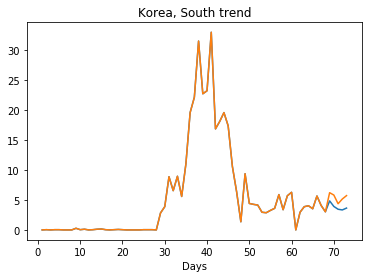

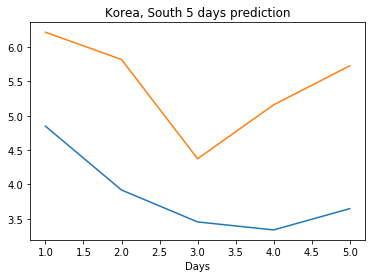

Creating directory ./offline8/Japan/training/
Japan
Saving the best model weights at Epoch [1], Best Valid Loss: 0.8963
Saving the best model weights at Epoch [2], Best Valid Loss: 0.8746
Saving the best model weights at Epoch [3], Best Valid Loss: 0.8629
Saving the best model weights at Epoch [6], Best Valid Loss: 0.8483
Saving the best model weights at Epoch [7], Best Valid Loss: 0.8472
Saving the best model weights at Epoch [8], Best Valid Loss: 0.8435
Saving the best model weights at Epoch [11], Best Valid Loss: 0.8383
Saving the best model weights at Epoch [12], Best Valid Loss: 0.8340
Saving the best model weights at Epoch [14], Best Valid Loss: 0.8281
Saving the best model weights at Epoch [15], Best Valid Loss: 0.8253
Saving the best model weights at Epoch [16], Best Valid Loss: 0.8202
Saving the best model weights at Epoch [19], Best Valid Loss: 0.8142
Saving the best model weights at Epoch [23], Best Valid Loss: 0.8109
Saving the best model weights at Epoch [27], Best Valid L

Saving the best model weights at Epoch [18], Best Valid Loss: 1.1057
Saving the best model weights at Epoch [21], Best Valid Loss: 1.1050
Saving the best model weights at Epoch [22], Best Valid Loss: 1.1044
Saving the best model weights at Epoch [23], Best Valid Loss: 1.1041
Saving the best model weights at Epoch [25], Best Valid Loss: 1.1015
Saving the best model weights at Epoch [27], Best Valid Loss: 1.1012
Saving the best model weights at Epoch [32], Best Valid Loss: 1.1010
Saving the best model weights at Epoch [33], Best Valid Loss: 1.0995
Saving the best model weights at Epoch [35], Best Valid Loss: 1.0990
Saving the best model weights at Epoch [36], Best Valid Loss: 1.0988
Saving the best model weights at Epoch [37], Best Valid Loss: 1.0969
Saving the best model weights at Epoch [38], Best Valid Loss: 1.0961
Saving the best model weights at Epoch [40], Best Valid Loss: 1.0959
Saving the best model weights at Epoch [43], Best Valid Loss: 1.0955
Saving the best model weights at E

Saving the best model weights at Epoch [24], Best Valid Loss: 0.7534
Saving the best model weights at Epoch [26], Best Valid Loss: 0.7512
train error: 0.07077953469400343
0.7512467503547668
Saving the best model weights at Epoch [1], Best Valid Loss: 1.0135
Saving the best model weights at Epoch [3], Best Valid Loss: 1.0119
Saving the best model weights at Epoch [4], Best Valid Loss: 1.0064
Saving the best model weights at Epoch [11], Best Valid Loss: 0.9967
Saving the best model weights at Epoch [16], Best Valid Loss: 0.9958
Saving the best model weights at Epoch [30], Best Valid Loss: 0.9953
Saving the best model weights at Epoch [33], Best Valid Loss: 0.9935
Saving the best model weights at Epoch [41], Best Valid Loss: 0.9925
train error: 0.12617950741887876
0.9924541711807251
Saving the best model weights at Epoch [1], Best Valid Loss: 0.7357
Saving the best model weights at Epoch [8], Best Valid Loss: 0.6978
Saving the best model weights at Epoch [20], Best Valid Loss: 0.6874
Savi

train error: 0.14085224949705757
0.49570557475090027
Saving the best model weights at Epoch [1], Best Valid Loss: 0.8910
Saving the best model weights at Epoch [2], Best Valid Loss: 0.8674
Saving the best model weights at Epoch [3], Best Valid Loss: 0.8332
Saving the best model weights at Epoch [4], Best Valid Loss: 0.8242
Saving the best model weights at Epoch [17], Best Valid Loss: 0.8234
Saving the best model weights at Epoch [20], Best Valid Loss: 0.8159
train error: 0.10522712718107198
0.815946102142334
Saving the best model weights at Epoch [1], Best Valid Loss: 1.1453
Saving the best model weights at Epoch [2], Best Valid Loss: 1.1340
Saving the best model weights at Epoch [24], Best Valid Loss: 1.1330
train error: 0.13049326229252314
1.1329764127731323
Saving the best model weights at Epoch [1], Best Valid Loss: 0.7245
Saving the best model weights at Epoch [5], Best Valid Loss: 0.6152
Saving the best model weights at Epoch [7], Best Valid Loss: 0.4899
train error: 0.1508344951

Saving the best model weights at Epoch [19], Best Valid Loss: 1.0144
Saving the best model weights at Epoch [20], Best Valid Loss: 1.0135
Saving the best model weights at Epoch [21], Best Valid Loss: 1.0131
Saving the best model weights at Epoch [22], Best Valid Loss: 1.0122
Saving the best model weights at Epoch [23], Best Valid Loss: 1.0121
Saving the best model weights at Epoch [24], Best Valid Loss: 1.0111
Saving the best model weights at Epoch [25], Best Valid Loss: 1.0106
Saving the best model weights at Epoch [26], Best Valid Loss: 1.0101
Saving the best model weights at Epoch [27], Best Valid Loss: 1.0099
Saving the best model weights at Epoch [28], Best Valid Loss: 1.0095
Saving the best model weights at Epoch [29], Best Valid Loss: 1.0092
Saving the best model weights at Epoch [31], Best Valid Loss: 1.0091
Saving the best model weights at Epoch [32], Best Valid Loss: 1.0085
Saving the best model weights at Epoch [33], Best Valid Loss: 1.0083
Saving the best model weights at E

Saving the best model weights at Epoch [42], Best Valid Loss: 0.7330
Saving the best model weights at Epoch [43], Best Valid Loss: 0.7321
Saving the best model weights at Epoch [44], Best Valid Loss: 0.7310
Saving the best model weights at Epoch [46], Best Valid Loss: 0.7272
Saving the best model weights at Epoch [49], Best Valid Loss: 0.7229
train error: 0.0784102063380966
0.7229320406913757
Saving the best model weights at Epoch [1], Best Valid Loss: 0.9323
Saving the best model weights at Epoch [2], Best Valid Loss: 0.9306
Saving the best model weights at Epoch [10], Best Valid Loss: 0.9289
Saving the best model weights at Epoch [11], Best Valid Loss: 0.9236
Saving the best model weights at Epoch [14], Best Valid Loss: 0.9182
Saving the best model weights at Epoch [15], Best Valid Loss: 0.9137
Saving the best model weights at Epoch [20], Best Valid Loss: 0.9120
Saving the best model weights at Epoch [22], Best Valid Loss: 0.9105
Saving the best model weights at Epoch [23], Best Vali

Saving the best model weights at Epoch [24], Best Valid Loss: 0.9380
Saving the best model weights at Epoch [25], Best Valid Loss: 0.9324
Saving the best model weights at Epoch [29], Best Valid Loss: 0.9310
Saving the best model weights at Epoch [31], Best Valid Loss: 0.9297
Saving the best model weights at Epoch [34], Best Valid Loss: 0.9256
Saving the best model weights at Epoch [35], Best Valid Loss: 0.9242
train error: 0.07592264304893385
0.9242150187492371
Saving the best model weights at Epoch [1], Best Valid Loss: 1.1363
Saving the best model weights at Epoch [2], Best Valid Loss: 1.1302
Saving the best model weights at Epoch [3], Best Valid Loss: 1.1251
Saving the best model weights at Epoch [4], Best Valid Loss: 1.1207
Saving the best model weights at Epoch [5], Best Valid Loss: 1.1171
Saving the best model weights at Epoch [6], Best Valid Loss: 1.1075
Saving the best model weights at Epoch [7], Best Valid Loss: 1.0776
Saving the best model weights at Epoch [8], Best Valid Los

Saving the best model weights at Epoch [33], Best Valid Loss: 0.5992
Saving the best model weights at Epoch [35], Best Valid Loss: 0.5975
Saving the best model weights at Epoch [36], Best Valid Loss: 0.5850
Saving the best model weights at Epoch [37], Best Valid Loss: 0.5803
Saving the best model weights at Epoch [38], Best Valid Loss: 0.5724
Saving the best model weights at Epoch [40], Best Valid Loss: 0.5643
Saving the best model weights at Epoch [41], Best Valid Loss: 0.5500
Saving the best model weights at Epoch [43], Best Valid Loss: 0.5440
Saving the best model weights at Epoch [46], Best Valid Loss: 0.5433
Saving the best model weights at Epoch [49], Best Valid Loss: 0.5401
Saving the best model weights at Epoch [50], Best Valid Loss: 0.5270
train error: 0.03895446534366592
0.5269798636436462
Saving the best model weights at Epoch [1], Best Valid Loss: 0.9435
Saving the best model weights at Epoch [2], Best Valid Loss: 0.9350
Saving the best model weights at Epoch [3], Best Vali

Saving the best model weights at Epoch [43], Best Valid Loss: 1.0604
Saving the best model weights at Epoch [44], Best Valid Loss: 1.0604
train error: 0.14112469254943885
1.0604313611984253
Saving the best model weights at Epoch [1], Best Valid Loss: 0.7675
Saving the best model weights at Epoch [2], Best Valid Loss: 0.7135
Saving the best model weights at Epoch [3], Best Valid Loss: 0.7123
Saving the best model weights at Epoch [4], Best Valid Loss: 0.6996
Saving the best model weights at Epoch [7], Best Valid Loss: 0.6852
Saving the best model weights at Epoch [28], Best Valid Loss: 0.6829
Saving the best model weights at Epoch [41], Best Valid Loss: 0.6783
train error: 0.10099296592862199
0.6783007979393005
Saving the best model weights at Epoch [1], Best Valid Loss: 1.1745
train error: 0.14228851666772052
1.1744773387908936
Saving the best model weights at Epoch [1], Best Valid Loss: 1.0203
Saving the best model weights at Epoch [2], Best Valid Loss: 0.9855
Saving the best model we

Saving the best model weights at Epoch [18], Best Valid Loss: 1.1150
Saving the best model weights at Epoch [19], Best Valid Loss: 1.1148
Saving the best model weights at Epoch [20], Best Valid Loss: 1.1146
Saving the best model weights at Epoch [21], Best Valid Loss: 1.1145
Saving the best model weights at Epoch [22], Best Valid Loss: 1.1143
Saving the best model weights at Epoch [23], Best Valid Loss: 1.1141
Saving the best model weights at Epoch [24], Best Valid Loss: 1.1139
Saving the best model weights at Epoch [25], Best Valid Loss: 1.1139
Saving the best model weights at Epoch [26], Best Valid Loss: 1.1139
Saving the best model weights at Epoch [27], Best Valid Loss: 1.1138
Saving the best model weights at Epoch [28], Best Valid Loss: 1.1138
Saving the best model weights at Epoch [29], Best Valid Loss: 1.1137
Saving the best model weights at Epoch [30], Best Valid Loss: 1.1137
Saving the best model weights at Epoch [34], Best Valid Loss: 1.1137
Saving the best model weights at E

Saving the best model weights at Epoch [7], Best Valid Loss: 0.9869
Saving the best model weights at Epoch [8], Best Valid Loss: 0.9845
Saving the best model weights at Epoch [9], Best Valid Loss: 0.9835
Saving the best model weights at Epoch [10], Best Valid Loss: 0.9820
Saving the best model weights at Epoch [12], Best Valid Loss: 0.9820
Saving the best model weights at Epoch [13], Best Valid Loss: 0.9803
Saving the best model weights at Epoch [14], Best Valid Loss: 0.9803
Saving the best model weights at Epoch [24], Best Valid Loss: 0.9800
Saving the best model weights at Epoch [34], Best Valid Loss: 0.9800
Saving the best model weights at Epoch [35], Best Valid Loss: 0.9798
Saving the best model weights at Epoch [36], Best Valid Loss: 0.9794
train error: 0.10534511439159121
0.9793767929077148
Saving the best model weights at Epoch [1], Best Valid Loss: 0.8077
Saving the best model weights at Epoch [2], Best Valid Loss: 0.7563
Saving the best model weights at Epoch [3], Best Valid L

Saving the best model weights at Epoch [8], Best Valid Loss: 0.9357
Saving the best model weights at Epoch [9], Best Valid Loss: 0.9330
Saving the best model weights at Epoch [10], Best Valid Loss: 0.9303
Saving the best model weights at Epoch [11], Best Valid Loss: 0.9286
Saving the best model weights at Epoch [12], Best Valid Loss: 0.9274
Saving the best model weights at Epoch [14], Best Valid Loss: 0.9253
Saving the best model weights at Epoch [16], Best Valid Loss: 0.9242
Saving the best model weights at Epoch [19], Best Valid Loss: 0.9233
Saving the best model weights at Epoch [30], Best Valid Loss: 0.9229
Saving the best model weights at Epoch [33], Best Valid Loss: 0.9229
Saving the best model weights at Epoch [50], Best Valid Loss: 0.9223
train error: 0.13784163984421052
0.9223135113716125
Saving the best model weights at Epoch [1], Best Valid Loss: 0.9970
Saving the best model weights at Epoch [2], Best Valid Loss: 0.9894
Saving the best model weights at Epoch [3], Best Valid 

Saving the best model weights at Epoch [1], Best Valid Loss: 1.0234
Saving the best model weights at Epoch [2], Best Valid Loss: 1.0116
Saving the best model weights at Epoch [3], Best Valid Loss: 0.9964
train error: 0.12583883817454702
0.9963647723197937
Saving the best model weights at Epoch [1], Best Valid Loss: 1.1692
train error: 0.16963599217859537
1.1692084074020386
Saving the best model weights at Epoch [1], Best Valid Loss: 0.8905
Saving the best model weights at Epoch [2], Best Valid Loss: 0.8679
Saving the best model weights at Epoch [3], Best Valid Loss: 0.8553
Saving the best model weights at Epoch [4], Best Valid Loss: 0.8436
Saving the best model weights at Epoch [5], Best Valid Loss: 0.8385
Saving the best model weights at Epoch [6], Best Valid Loss: 0.8314
Saving the best model weights at Epoch [7], Best Valid Loss: 0.8267
Saving the best model weights at Epoch [8], Best Valid Loss: 0.8245
Saving the best model weights at Epoch [9], Best Valid Loss: 0.8216
Saving the b

Saving the best model weights at Epoch [31], Best Valid Loss: 0.9243
Saving the best model weights at Epoch [32], Best Valid Loss: 0.9242
train error: 0.13778827378624364
0.9242133498191833
Saving the best model weights at Epoch [1], Best Valid Loss: 1.0442
Saving the best model weights at Epoch [2], Best Valid Loss: 1.0064
Saving the best model weights at Epoch [3], Best Valid Loss: 0.9808
Saving the best model weights at Epoch [4], Best Valid Loss: 0.9650
Saving the best model weights at Epoch [5], Best Valid Loss: 0.9539
Saving the best model weights at Epoch [6], Best Valid Loss: 0.9471
Saving the best model weights at Epoch [7], Best Valid Loss: 0.9418
Saving the best model weights at Epoch [8], Best Valid Loss: 0.9373
Saving the best model weights at Epoch [9], Best Valid Loss: 0.9359
Saving the best model weights at Epoch [10], Best Valid Loss: 0.9338
Saving the best model weights at Epoch [11], Best Valid Loss: 0.9313
Saving the best model weights at Epoch [12], Best Valid Loss

Saving the best model weights at Epoch [6], Best Valid Loss: 1.1529
Saving the best model weights at Epoch [7], Best Valid Loss: 1.1526
Saving the best model weights at Epoch [8], Best Valid Loss: 1.1523
Saving the best model weights at Epoch [9], Best Valid Loss: 1.1520
Saving the best model weights at Epoch [10], Best Valid Loss: 1.1516
Saving the best model weights at Epoch [11], Best Valid Loss: 1.1514
Saving the best model weights at Epoch [12], Best Valid Loss: 1.1511
Saving the best model weights at Epoch [13], Best Valid Loss: 1.1508
Saving the best model weights at Epoch [14], Best Valid Loss: 1.1506
Saving the best model weights at Epoch [15], Best Valid Loss: 1.1504
Saving the best model weights at Epoch [16], Best Valid Loss: 1.1502
Saving the best model weights at Epoch [17], Best Valid Loss: 1.1500
Saving the best model weights at Epoch [18], Best Valid Loss: 1.1497
Saving the best model weights at Epoch [19], Best Valid Loss: 1.1496
Saving the best model weights at Epoch

Saving the best model weights at Epoch [43], Best Valid Loss: 1.0124
Saving the best model weights at Epoch [44], Best Valid Loss: 1.0106
Saving the best model weights at Epoch [45], Best Valid Loss: 1.0090
Saving the best model weights at Epoch [46], Best Valid Loss: 1.0073
Saving the best model weights at Epoch [47], Best Valid Loss: 1.0057
Saving the best model weights at Epoch [48], Best Valid Loss: 1.0042
Saving the best model weights at Epoch [49], Best Valid Loss: 1.0026
Saving the best model weights at Epoch [50], Best Valid Loss: 1.0011
train error: 0.1165359815533616
1.0011274814605713
Saving the best model weights at Epoch [1], Best Valid Loss: 1.1006
Saving the best model weights at Epoch [2], Best Valid Loss: 1.0937
Saving the best model weights at Epoch [3], Best Valid Loss: 1.0872
Saving the best model weights at Epoch [4], Best Valid Loss: 1.0812
Saving the best model weights at Epoch [5], Best Valid Loss: 1.0753
Saving the best model weights at Epoch [6], Best Valid Lo

Saving the best model weights at Epoch [29], Best Valid Loss: 0.9926
Saving the best model weights at Epoch [30], Best Valid Loss: 0.9890
Saving the best model weights at Epoch [31], Best Valid Loss: 0.9857
Saving the best model weights at Epoch [32], Best Valid Loss: 0.9824
Saving the best model weights at Epoch [33], Best Valid Loss: 0.9794
Saving the best model weights at Epoch [34], Best Valid Loss: 0.9764
Saving the best model weights at Epoch [35], Best Valid Loss: 0.9736
Saving the best model weights at Epoch [36], Best Valid Loss: 0.9708
Saving the best model weights at Epoch [37], Best Valid Loss: 0.9683
Saving the best model weights at Epoch [38], Best Valid Loss: 0.9657
Saving the best model weights at Epoch [39], Best Valid Loss: 0.9632
Saving the best model weights at Epoch [40], Best Valid Loss: 0.9606
Saving the best model weights at Epoch [41], Best Valid Loss: 0.9583
Saving the best model weights at Epoch [42], Best Valid Loss: 0.9562
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 0.9209
Saving the best model weights at Epoch [33], Best Valid Loss: 0.9178
Saving the best model weights at Epoch [34], Best Valid Loss: 0.9148
Saving the best model weights at Epoch [35], Best Valid Loss: 0.9115
Saving the best model weights at Epoch [36], Best Valid Loss: 0.9087
Saving the best model weights at Epoch [37], Best Valid Loss: 0.9060
Saving the best model weights at Epoch [38], Best Valid Loss: 0.9032
Saving the best model weights at Epoch [39], Best Valid Loss: 0.9007
Saving the best model weights at Epoch [40], Best Valid Loss: 0.8983
Saving the best model weights at Epoch [41], Best Valid Loss: 0.8961
Saving the best model weights at Epoch [42], Best Valid Loss: 0.8935
Saving the best model weights at Epoch [43], Best Valid Loss: 0.8916
Saving the best model weights at Epoch [44], Best Valid Loss: 0.8892
Saving the best model weights at Epoch [45], Best Valid Loss: 0.8871
Saving the best model weights at E

Saving the best model weights at Epoch [20], Best Valid Loss: 1.0507
Saving the best model weights at Epoch [21], Best Valid Loss: 1.0492
Saving the best model weights at Epoch [22], Best Valid Loss: 1.0478
Saving the best model weights at Epoch [23], Best Valid Loss: 1.0465
Saving the best model weights at Epoch [24], Best Valid Loss: 1.0451
Saving the best model weights at Epoch [25], Best Valid Loss: 1.0438
Saving the best model weights at Epoch [26], Best Valid Loss: 1.0426
Saving the best model weights at Epoch [27], Best Valid Loss: 1.0414
Saving the best model weights at Epoch [28], Best Valid Loss: 1.0402
Saving the best model weights at Epoch [29], Best Valid Loss: 1.0392
Saving the best model weights at Epoch [30], Best Valid Loss: 1.0381
Saving the best model weights at Epoch [31], Best Valid Loss: 1.0370
Saving the best model weights at Epoch [32], Best Valid Loss: 1.0361
Saving the best model weights at Epoch [33], Best Valid Loss: 1.0350
Saving the best model weights at E

Saving the best model weights at Epoch [16], Best Valid Loss: 0.9633
Saving the best model weights at Epoch [17], Best Valid Loss: 0.9600
Saving the best model weights at Epoch [18], Best Valid Loss: 0.9567
Saving the best model weights at Epoch [19], Best Valid Loss: 0.9538
Saving the best model weights at Epoch [20], Best Valid Loss: 0.9507
Saving the best model weights at Epoch [21], Best Valid Loss: 0.9479
Saving the best model weights at Epoch [22], Best Valid Loss: 0.9451
Saving the best model weights at Epoch [23], Best Valid Loss: 0.9425
Saving the best model weights at Epoch [24], Best Valid Loss: 0.9398
Saving the best model weights at Epoch [25], Best Valid Loss: 0.9374
Saving the best model weights at Epoch [26], Best Valid Loss: 0.9350
Saving the best model weights at Epoch [27], Best Valid Loss: 0.9327
Saving the best model weights at Epoch [28], Best Valid Loss: 0.9303
Saving the best model weights at Epoch [29], Best Valid Loss: 0.9282
Saving the best model weights at E

Saving the best model weights at Epoch [7], Best Valid Loss: 0.9889
Saving the best model weights at Epoch [8], Best Valid Loss: 0.9811
Saving the best model weights at Epoch [9], Best Valid Loss: 0.9733
Saving the best model weights at Epoch [10], Best Valid Loss: 0.9659
Saving the best model weights at Epoch [11], Best Valid Loss: 0.9588
Saving the best model weights at Epoch [12], Best Valid Loss: 0.9517
Saving the best model weights at Epoch [13], Best Valid Loss: 0.9453
Saving the best model weights at Epoch [14], Best Valid Loss: 0.9389
Saving the best model weights at Epoch [15], Best Valid Loss: 0.9328
Saving the best model weights at Epoch [16], Best Valid Loss: 0.9267
Saving the best model weights at Epoch [17], Best Valid Loss: 0.9210
Saving the best model weights at Epoch [18], Best Valid Loss: 0.9155
Saving the best model weights at Epoch [19], Best Valid Loss: 0.9103
Saving the best model weights at Epoch [20], Best Valid Loss: 0.9052
Saving the best model weights at Epoc

Saving the best model weights at Epoch [47], Best Valid Loss: 1.1314
Saving the best model weights at Epoch [48], Best Valid Loss: 1.1311
Saving the best model weights at Epoch [49], Best Valid Loss: 1.1308
Saving the best model weights at Epoch [50], Best Valid Loss: 1.1306
train error: 0.15755914269309296
1.1305593252182007
Saving the best model weights at Epoch [1], Best Valid Loss: 1.1713
train error: 0.14305815527117566
1.1713026762008667
Saving the best model weights at Epoch [1], Best Valid Loss: 1.1425
Saving the best model weights at Epoch [2], Best Valid Loss: 1.1377
Saving the best model weights at Epoch [3], Best Valid Loss: 1.1346
Saving the best model weights at Epoch [4], Best Valid Loss: 1.1309
Saving the best model weights at Epoch [5], Best Valid Loss: 1.1286
Saving the best model weights at Epoch [6], Best Valid Loss: 1.1267
Saving the best model weights at Epoch [7], Best Valid Loss: 1.1254
Saving the best model weights at Epoch [8], Best Valid Loss: 1.1237
Saving t

Saving the best model weights at Epoch [41], Best Valid Loss: 0.9926
Saving the best model weights at Epoch [42], Best Valid Loss: 0.9915
Saving the best model weights at Epoch [43], Best Valid Loss: 0.9903
Saving the best model weights at Epoch [44], Best Valid Loss: 0.9893
Saving the best model weights at Epoch [45], Best Valid Loss: 0.9880
Saving the best model weights at Epoch [46], Best Valid Loss: 0.9870
Saving the best model weights at Epoch [47], Best Valid Loss: 0.9860
Saving the best model weights at Epoch [48], Best Valid Loss: 0.9850
Saving the best model weights at Epoch [49], Best Valid Loss: 0.9841
Saving the best model weights at Epoch [50], Best Valid Loss: 0.9832
train error: 0.13449192081431025
0.9832315444946289
Saving the best model weights at Epoch [1], Best Valid Loss: 1.1389
Saving the best model weights at Epoch [2], Best Valid Loss: 1.1351
Saving the best model weights at Epoch [3], Best Valid Loss: 1.1322
Saving the best model weights at Epoch [4], Best Valid

Saving the best model weights at Epoch [32], Best Valid Loss: 0.9119
Saving the best model weights at Epoch [33], Best Valid Loss: 0.9046
Saving the best model weights at Epoch [34], Best Valid Loss: 0.8975
Saving the best model weights at Epoch [35], Best Valid Loss: 0.8911
Saving the best model weights at Epoch [36], Best Valid Loss: 0.8847
Saving the best model weights at Epoch [37], Best Valid Loss: 0.8784
Saving the best model weights at Epoch [38], Best Valid Loss: 0.8726
Saving the best model weights at Epoch [39], Best Valid Loss: 0.8671
Saving the best model weights at Epoch [40], Best Valid Loss: 0.8615
Saving the best model weights at Epoch [41], Best Valid Loss: 0.8568
Saving the best model weights at Epoch [42], Best Valid Loss: 0.8512
Saving the best model weights at Epoch [43], Best Valid Loss: 0.8467
Saving the best model weights at Epoch [44], Best Valid Loss: 0.8417
Saving the best model weights at Epoch [45], Best Valid Loss: 0.8372
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 1.0740
Saving the best model weights at Epoch [49], Best Valid Loss: 1.0737
Saving the best model weights at Epoch [50], Best Valid Loss: 1.0732
train error: 0.14165283396447959
1.0732487440109253
Saving the best model weights at Epoch [1], Best Valid Loss: 1.0685
Saving the best model weights at Epoch [2], Best Valid Loss: 1.0477
Saving the best model weights at Epoch [3], Best Valid Loss: 1.0311
Saving the best model weights at Epoch [4], Best Valid Loss: 1.0167
Saving the best model weights at Epoch [5], Best Valid Loss: 1.0041
Saving the best model weights at Epoch [6], Best Valid Loss: 0.9964
Saving the best model weights at Epoch [7], Best Valid Loss: 0.9892
Saving the best model weights at Epoch [8], Best Valid Loss: 0.9822
Saving the best model weights at Epoch [9], Best Valid Loss: 0.9792
Saving the best model weights at Epoch [10], Best Valid Loss: 0.9742
Saving the best model weights at Epoch [11], Best Valid Loss

Saving the best model weights at Epoch [39], Best Valid Loss: 1.1272
Saving the best model weights at Epoch [40], Best Valid Loss: 1.1269
Saving the best model weights at Epoch [41], Best Valid Loss: 1.1265
Saving the best model weights at Epoch [42], Best Valid Loss: 1.1262
Saving the best model weights at Epoch [43], Best Valid Loss: 1.1259
Saving the best model weights at Epoch [44], Best Valid Loss: 1.1256
Saving the best model weights at Epoch [45], Best Valid Loss: 1.1253
Saving the best model weights at Epoch [46], Best Valid Loss: 1.1250
Saving the best model weights at Epoch [47], Best Valid Loss: 1.1247
Saving the best model weights at Epoch [48], Best Valid Loss: 1.1245
Saving the best model weights at Epoch [49], Best Valid Loss: 1.1242
Saving the best model weights at Epoch [50], Best Valid Loss: 1.1240
train error: 0.1565555523541805
1.123965859413147
Saving the best model weights at Epoch [1], Best Valid Loss: 1.0488
Saving the best model weights at Epoch [2], Best Valid

Saving the best model weights at Epoch [31], Best Valid Loss: 1.0212
Saving the best model weights at Epoch [32], Best Valid Loss: 1.0207
Saving the best model weights at Epoch [33], Best Valid Loss: 1.0203
Saving the best model weights at Epoch [34], Best Valid Loss: 1.0200
Saving the best model weights at Epoch [35], Best Valid Loss: 1.0196
Saving the best model weights at Epoch [36], Best Valid Loss: 1.0192
Saving the best model weights at Epoch [37], Best Valid Loss: 1.0189
Saving the best model weights at Epoch [38], Best Valid Loss: 1.0186
Saving the best model weights at Epoch [39], Best Valid Loss: 1.0183
Saving the best model weights at Epoch [40], Best Valid Loss: 1.0179
Saving the best model weights at Epoch [41], Best Valid Loss: 1.0176
Saving the best model weights at Epoch [42], Best Valid Loss: 1.0173
Saving the best model weights at Epoch [43], Best Valid Loss: 1.0170
Saving the best model weights at Epoch [44], Best Valid Loss: 1.0168
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 1.0250
Saving the best model weights at Epoch [48], Best Valid Loss: 1.0242
Saving the best model weights at Epoch [49], Best Valid Loss: 1.0236
Saving the best model weights at Epoch [50], Best Valid Loss: 1.0231
train error: 0.1268796813674271
1.023073434829712
Saving the best model weights at Epoch [1], Best Valid Loss: 1.0958
Saving the best model weights at Epoch [2], Best Valid Loss: 1.0627
Saving the best model weights at Epoch [3], Best Valid Loss: 1.0316
Saving the best model weights at Epoch [4], Best Valid Loss: 1.0098
Saving the best model weights at Epoch [5], Best Valid Loss: 0.9922
Saving the best model weights at Epoch [6], Best Valid Loss: 0.9774
Saving the best model weights at Epoch [7], Best Valid Loss: 0.9653
Saving the best model weights at Epoch [8], Best Valid Loss: 0.9529
Saving the best model weights at Epoch [9], Best Valid Loss: 0.9460
Saving the best model weights at Epoch [10], Best Valid Loss: 

Saving the best model weights at Epoch [36], Best Valid Loss: 0.8897
Saving the best model weights at Epoch [37], Best Valid Loss: 0.8873
Saving the best model weights at Epoch [38], Best Valid Loss: 0.8850
Saving the best model weights at Epoch [39], Best Valid Loss: 0.8829
Saving the best model weights at Epoch [40], Best Valid Loss: 0.8810
Saving the best model weights at Epoch [41], Best Valid Loss: 0.8786
Saving the best model weights at Epoch [42], Best Valid Loss: 0.8768
Saving the best model weights at Epoch [43], Best Valid Loss: 0.8749
Saving the best model weights at Epoch [44], Best Valid Loss: 0.8730
Saving the best model weights at Epoch [45], Best Valid Loss: 0.8711
Saving the best model weights at Epoch [46], Best Valid Loss: 0.8695
Saving the best model weights at Epoch [47], Best Valid Loss: 0.8680
Saving the best model weights at Epoch [48], Best Valid Loss: 0.8661
Saving the best model weights at Epoch [49], Best Valid Loss: 0.8647
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 0.9593
Saving the best model weights at Epoch [30], Best Valid Loss: 0.9571
Saving the best model weights at Epoch [31], Best Valid Loss: 0.9550
Saving the best model weights at Epoch [32], Best Valid Loss: 0.9529
Saving the best model weights at Epoch [33], Best Valid Loss: 0.9510
Saving the best model weights at Epoch [34], Best Valid Loss: 0.9492
Saving the best model weights at Epoch [35], Best Valid Loss: 0.9474
Saving the best model weights at Epoch [36], Best Valid Loss: 0.9454
Saving the best model weights at Epoch [37], Best Valid Loss: 0.9439
Saving the best model weights at Epoch [38], Best Valid Loss: 0.9423
Saving the best model weights at Epoch [39], Best Valid Loss: 0.9408
Saving the best model weights at Epoch [40], Best Valid Loss: 0.9391
Saving the best model weights at Epoch [41], Best Valid Loss: 0.9377
Saving the best model weights at Epoch [42], Best Valid Loss: 0.9364
Saving the best model weights at E

Saving the best model weights at Epoch [18], Best Valid Loss: 0.9001
Saving the best model weights at Epoch [19], Best Valid Loss: 0.8996
Saving the best model weights at Epoch [20], Best Valid Loss: 0.8994
Saving the best model weights at Epoch [21], Best Valid Loss: 0.8989
Saving the best model weights at Epoch [22], Best Valid Loss: 0.8987
Saving the best model weights at Epoch [23], Best Valid Loss: 0.8984
Saving the best model weights at Epoch [24], Best Valid Loss: 0.8982
Saving the best model weights at Epoch [25], Best Valid Loss: 0.8980
Saving the best model weights at Epoch [26], Best Valid Loss: 0.8979
Saving the best model weights at Epoch [27], Best Valid Loss: 0.8977
Saving the best model weights at Epoch [28], Best Valid Loss: 0.8976
Saving the best model weights at Epoch [29], Best Valid Loss: 0.8974
Saving the best model weights at Epoch [30], Best Valid Loss: 0.8972
Saving the best model weights at Epoch [31], Best Valid Loss: 0.8971
Saving the best model weights at E

Saving the best model weights at Epoch [23], Best Valid Loss: 1.0532
Saving the best model weights at Epoch [24], Best Valid Loss: 1.0518
Saving the best model weights at Epoch [25], Best Valid Loss: 1.0503
Saving the best model weights at Epoch [26], Best Valid Loss: 1.0489
Saving the best model weights at Epoch [27], Best Valid Loss: 1.0477
Saving the best model weights at Epoch [28], Best Valid Loss: 1.0463
Saving the best model weights at Epoch [29], Best Valid Loss: 1.0451
Saving the best model weights at Epoch [30], Best Valid Loss: 1.0438
Saving the best model weights at Epoch [31], Best Valid Loss: 1.0427
Saving the best model weights at Epoch [32], Best Valid Loss: 1.0415
Saving the best model weights at Epoch [33], Best Valid Loss: 1.0404
Saving the best model weights at Epoch [34], Best Valid Loss: 1.0395
Saving the best model weights at Epoch [35], Best Valid Loss: 1.0384
Saving the best model weights at Epoch [36], Best Valid Loss: 1.0374
Saving the best model weights at E

Saving the best model weights at Epoch [8], Best Valid Loss: 1.0304
Saving the best model weights at Epoch [9], Best Valid Loss: 1.0262
Saving the best model weights at Epoch [10], Best Valid Loss: 1.0224
Saving the best model weights at Epoch [11], Best Valid Loss: 1.0185
Saving the best model weights at Epoch [12], Best Valid Loss: 1.0150
Saving the best model weights at Epoch [13], Best Valid Loss: 1.0117
Saving the best model weights at Epoch [14], Best Valid Loss: 1.0083
Saving the best model weights at Epoch [15], Best Valid Loss: 1.0051
Saving the best model weights at Epoch [16], Best Valid Loss: 1.0022
Saving the best model weights at Epoch [17], Best Valid Loss: 0.9994
Saving the best model weights at Epoch [18], Best Valid Loss: 0.9966
Saving the best model weights at Epoch [19], Best Valid Loss: 0.9941
Saving the best model weights at Epoch [20], Best Valid Loss: 0.9915
Saving the best model weights at Epoch [21], Best Valid Loss: 0.9892
Saving the best model weights at Epo

Saving the best model weights at Epoch [17], Best Valid Loss: 1.0429
Saving the best model weights at Epoch [18], Best Valid Loss: 1.0405
Saving the best model weights at Epoch [19], Best Valid Loss: 1.0369
Saving the best model weights at Epoch [20], Best Valid Loss: 1.0326
Saving the best model weights at Epoch [21], Best Valid Loss: 1.0284
Saving the best model weights at Epoch [22], Best Valid Loss: 1.0245
Saving the best model weights at Epoch [23], Best Valid Loss: 1.0207
Saving the best model weights at Epoch [24], Best Valid Loss: 1.0172
Saving the best model weights at Epoch [25], Best Valid Loss: 1.0136
Saving the best model weights at Epoch [26], Best Valid Loss: 1.0103
Saving the best model weights at Epoch [27], Best Valid Loss: 1.0071
Saving the best model weights at Epoch [28], Best Valid Loss: 1.0041
Saving the best model weights at Epoch [29], Best Valid Loss: 1.0012
Saving the best model weights at Epoch [30], Best Valid Loss: 0.9984
Saving the best model weights at E

Saving the best model weights at Epoch [9], Best Valid Loss: 1.0451
Saving the best model weights at Epoch [10], Best Valid Loss: 1.0447
Saving the best model weights at Epoch [11], Best Valid Loss: 1.0443
Saving the best model weights at Epoch [12], Best Valid Loss: 1.0439
Saving the best model weights at Epoch [13], Best Valid Loss: 1.0435
Saving the best model weights at Epoch [14], Best Valid Loss: 1.0432
Saving the best model weights at Epoch [15], Best Valid Loss: 1.0428
Saving the best model weights at Epoch [16], Best Valid Loss: 1.0424
Saving the best model weights at Epoch [17], Best Valid Loss: 1.0420
Saving the best model weights at Epoch [18], Best Valid Loss: 1.0416
Saving the best model weights at Epoch [19], Best Valid Loss: 1.0413
Saving the best model weights at Epoch [20], Best Valid Loss: 1.0409
Saving the best model weights at Epoch [21], Best Valid Loss: 1.0405
Saving the best model weights at Epoch [22], Best Valid Loss: 1.0402
Saving the best model weights at Ep

Saving the best model weights at Epoch [27], Best Valid Loss: 0.9890
Saving the best model weights at Epoch [28], Best Valid Loss: 0.9884
Saving the best model weights at Epoch [29], Best Valid Loss: 0.9878
Saving the best model weights at Epoch [30], Best Valid Loss: 0.9872
Saving the best model weights at Epoch [31], Best Valid Loss: 0.9866
Saving the best model weights at Epoch [32], Best Valid Loss: 0.9861
Saving the best model weights at Epoch [33], Best Valid Loss: 0.9855
Saving the best model weights at Epoch [34], Best Valid Loss: 0.9849
Saving the best model weights at Epoch [35], Best Valid Loss: 0.9843
Saving the best model weights at Epoch [36], Best Valid Loss: 0.9837
Saving the best model weights at Epoch [37], Best Valid Loss: 0.9831
Saving the best model weights at Epoch [38], Best Valid Loss: 0.9825
Saving the best model weights at Epoch [39], Best Valid Loss: 0.9820
Saving the best model weights at Epoch [40], Best Valid Loss: 0.9814
Saving the best model weights at E

Saving the best model weights at Epoch [45], Best Valid Loss: 1.0195
Saving the best model weights at Epoch [46], Best Valid Loss: 1.0182
Saving the best model weights at Epoch [47], Best Valid Loss: 1.0168
Saving the best model weights at Epoch [48], Best Valid Loss: 1.0155
Saving the best model weights at Epoch [49], Best Valid Loss: 1.0140
Saving the best model weights at Epoch [50], Best Valid Loss: 1.0128
train error: 0.11881503766696704
1.0127770900726318
Saving the best model weights at Epoch [1], Best Valid Loss: 1.0604
Saving the best model weights at Epoch [2], Best Valid Loss: 1.0600
Saving the best model weights at Epoch [3], Best Valid Loss: 1.0595
Saving the best model weights at Epoch [4], Best Valid Loss: 1.0591
Saving the best model weights at Epoch [5], Best Valid Loss: 1.0586
Saving the best model weights at Epoch [6], Best Valid Loss: 1.0582
Saving the best model weights at Epoch [7], Best Valid Loss: 1.0578
Saving the best model weights at Epoch [8], Best Valid Los

Saving the best model weights at Epoch [13], Best Valid Loss: 1.0180
Saving the best model weights at Epoch [14], Best Valid Loss: 1.0148
Saving the best model weights at Epoch [15], Best Valid Loss: 1.0119
Saving the best model weights at Epoch [16], Best Valid Loss: 1.0079
Saving the best model weights at Epoch [17], Best Valid Loss: 1.0050
Saving the best model weights at Epoch [18], Best Valid Loss: 1.0016
Saving the best model weights at Epoch [19], Best Valid Loss: 0.9988
Saving the best model weights at Epoch [20], Best Valid Loss: 0.9957
Saving the best model weights at Epoch [21], Best Valid Loss: 0.9923
Saving the best model weights at Epoch [22], Best Valid Loss: 0.9896
Saving the best model weights at Epoch [23], Best Valid Loss: 0.9870
Saving the best model weights at Epoch [24], Best Valid Loss: 0.9841
Saving the best model weights at Epoch [25], Best Valid Loss: 0.9813
Saving the best model weights at Epoch [26], Best Valid Loss: 0.9785
Saving the best model weights at E

Saving the best model weights at Epoch [31], Best Valid Loss: 1.0961
Saving the best model weights at Epoch [32], Best Valid Loss: 1.0952
Saving the best model weights at Epoch [33], Best Valid Loss: 1.0944
Saving the best model weights at Epoch [34], Best Valid Loss: 1.0935
Saving the best model weights at Epoch [35], Best Valid Loss: 1.0926
Saving the best model weights at Epoch [36], Best Valid Loss: 1.0917
Saving the best model weights at Epoch [37], Best Valid Loss: 1.0908
Saving the best model weights at Epoch [38], Best Valid Loss: 1.0900
Saving the best model weights at Epoch [39], Best Valid Loss: 1.0891
Saving the best model weights at Epoch [40], Best Valid Loss: 1.0883
Saving the best model weights at Epoch [41], Best Valid Loss: 1.0874
Saving the best model weights at Epoch [42], Best Valid Loss: 1.0866
Saving the best model weights at Epoch [43], Best Valid Loss: 1.0857
Saving the best model weights at Epoch [44], Best Valid Loss: 1.0849
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 0.8840
Saving the best model weights at Epoch [50], Best Valid Loss: 0.8838
train error: 0.09887396613454544
0.8837848901748657
Saving the best model weights at Epoch [1], Best Valid Loss: 1.0567
Saving the best model weights at Epoch [2], Best Valid Loss: 1.0564
Saving the best model weights at Epoch [3], Best Valid Loss: 1.0561
Saving the best model weights at Epoch [4], Best Valid Loss: 1.0557
Saving the best model weights at Epoch [5], Best Valid Loss: 1.0554
Saving the best model weights at Epoch [6], Best Valid Loss: 1.0551
Saving the best model weights at Epoch [7], Best Valid Loss: 1.0548
Saving the best model weights at Epoch [8], Best Valid Loss: 1.0545
Saving the best model weights at Epoch [9], Best Valid Loss: 1.0542
Saving the best model weights at Epoch [10], Best Valid Loss: 1.0539
Saving the best model weights at Epoch [11], Best Valid Loss: 1.0536
Saving the best model weights at Epoch [12], Best Valid Loss

Saving the best model weights at Epoch [18], Best Valid Loss: 1.0805
Saving the best model weights at Epoch [19], Best Valid Loss: 1.0800
Saving the best model weights at Epoch [20], Best Valid Loss: 1.0795
Saving the best model weights at Epoch [21], Best Valid Loss: 1.0791
Saving the best model weights at Epoch [22], Best Valid Loss: 1.0786
Saving the best model weights at Epoch [23], Best Valid Loss: 1.0781
Saving the best model weights at Epoch [24], Best Valid Loss: 1.0776
Saving the best model weights at Epoch [25], Best Valid Loss: 1.0772
Saving the best model weights at Epoch [26], Best Valid Loss: 1.0767
Saving the best model weights at Epoch [27], Best Valid Loss: 1.0762
Saving the best model weights at Epoch [28], Best Valid Loss: 1.0758
Saving the best model weights at Epoch [29], Best Valid Loss: 1.0753
Saving the best model weights at Epoch [30], Best Valid Loss: 1.0748
Saving the best model weights at Epoch [31], Best Valid Loss: 1.0744
Saving the best model weights at E

Saving the best model weights at Epoch [37], Best Valid Loss: 0.9521
Saving the best model weights at Epoch [38], Best Valid Loss: 0.9490
Saving the best model weights at Epoch [39], Best Valid Loss: 0.9456
Saving the best model weights at Epoch [40], Best Valid Loss: 0.9427
Saving the best model weights at Epoch [41], Best Valid Loss: 0.9398
Saving the best model weights at Epoch [42], Best Valid Loss: 0.9364
Saving the best model weights at Epoch [43], Best Valid Loss: 0.9335
Saving the best model weights at Epoch [44], Best Valid Loss: 0.9308
Saving the best model weights at Epoch [45], Best Valid Loss: 0.9279
Saving the best model weights at Epoch [46], Best Valid Loss: 0.9252
Saving the best model weights at Epoch [47], Best Valid Loss: 0.9225
Saving the best model weights at Epoch [48], Best Valid Loss: 0.9200
Saving the best model weights at Epoch [49], Best Valid Loss: 0.9174
Saving the best model weights at Epoch [50], Best Valid Loss: 0.9143
train error: 0.12480263622771752
0

Saving the best model weights at Epoch [6], Best Valid Loss: 1.0541
Saving the best model weights at Epoch [7], Best Valid Loss: 1.0508
Saving the best model weights at Epoch [8], Best Valid Loss: 1.0479
Saving the best model weights at Epoch [9], Best Valid Loss: 1.0446
Saving the best model weights at Epoch [10], Best Valid Loss: 1.0414
Saving the best model weights at Epoch [11], Best Valid Loss: 1.0382
Saving the best model weights at Epoch [12], Best Valid Loss: 1.0356
Saving the best model weights at Epoch [13], Best Valid Loss: 1.0324
Saving the best model weights at Epoch [14], Best Valid Loss: 1.0294
Saving the best model weights at Epoch [15], Best Valid Loss: 1.0267
Saving the best model weights at Epoch [16], Best Valid Loss: 1.0240
Saving the best model weights at Epoch [17], Best Valid Loss: 1.0213
Saving the best model weights at Epoch [18], Best Valid Loss: 1.0186
Saving the best model weights at Epoch [19], Best Valid Loss: 1.0160
Saving the best model weights at Epoch

Saving the best model weights at Epoch [22], Best Valid Loss: 1.1543
Saving the best model weights at Epoch [23], Best Valid Loss: 1.1539
Saving the best model weights at Epoch [24], Best Valid Loss: 1.1536
Saving the best model weights at Epoch [25], Best Valid Loss: 1.1532
Saving the best model weights at Epoch [26], Best Valid Loss: 1.1529
Saving the best model weights at Epoch [27], Best Valid Loss: 1.1526
Saving the best model weights at Epoch [28], Best Valid Loss: 1.1522
Saving the best model weights at Epoch [29], Best Valid Loss: 1.1519
Saving the best model weights at Epoch [30], Best Valid Loss: 1.1517
Saving the best model weights at Epoch [31], Best Valid Loss: 1.1514
Saving the best model weights at Epoch [32], Best Valid Loss: 1.1511
Saving the best model weights at Epoch [33], Best Valid Loss: 1.1509
Saving the best model weights at Epoch [34], Best Valid Loss: 1.1506
Saving the best model weights at Epoch [35], Best Valid Loss: 1.1504
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 1.1226
Saving the best model weights at Epoch [39], Best Valid Loss: 1.1225
Saving the best model weights at Epoch [40], Best Valid Loss: 1.1224
Saving the best model weights at Epoch [41], Best Valid Loss: 1.1223
Saving the best model weights at Epoch [42], Best Valid Loss: 1.1223
Saving the best model weights at Epoch [43], Best Valid Loss: 1.1222
Saving the best model weights at Epoch [44], Best Valid Loss: 1.1221
Saving the best model weights at Epoch [45], Best Valid Loss: 1.1220
Saving the best model weights at Epoch [46], Best Valid Loss: 1.1219
Saving the best model weights at Epoch [47], Best Valid Loss: 1.1219
Saving the best model weights at Epoch [48], Best Valid Loss: 1.1217
Saving the best model weights at Epoch [49], Best Valid Loss: 1.1217
Saving the best model weights at Epoch [50], Best Valid Loss: 1.1216
train error: 0.15632937123116694
1.121589183807373
Saving the best model weights at Epoch [1], Best Val

Saving the best model weights at Epoch [5], Best Valid Loss: 1.0659
Saving the best model weights at Epoch [6], Best Valid Loss: 1.0600
Saving the best model weights at Epoch [7], Best Valid Loss: 1.0533
Saving the best model weights at Epoch [8], Best Valid Loss: 1.0476
Saving the best model weights at Epoch [9], Best Valid Loss: 1.0417
Saving the best model weights at Epoch [10], Best Valid Loss: 1.0358
Saving the best model weights at Epoch [11], Best Valid Loss: 1.0302
Saving the best model weights at Epoch [12], Best Valid Loss: 1.0249
Saving the best model weights at Epoch [13], Best Valid Loss: 1.0196
Saving the best model weights at Epoch [14], Best Valid Loss: 1.0142
Saving the best model weights at Epoch [15], Best Valid Loss: 1.0090
Saving the best model weights at Epoch [16], Best Valid Loss: 1.0038
Saving the best model weights at Epoch [17], Best Valid Loss: 0.9988
Saving the best model weights at Epoch [18], Best Valid Loss: 0.9941
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [23], Best Valid Loss: 1.1150
Saving the best model weights at Epoch [24], Best Valid Loss: 1.1146
Saving the best model weights at Epoch [25], Best Valid Loss: 1.1141
Saving the best model weights at Epoch [26], Best Valid Loss: 1.1136
Saving the best model weights at Epoch [27], Best Valid Loss: 1.1132
Saving the best model weights at Epoch [28], Best Valid Loss: 1.1127
Saving the best model weights at Epoch [29], Best Valid Loss: 1.1122
Saving the best model weights at Epoch [30], Best Valid Loss: 1.1118
Saving the best model weights at Epoch [31], Best Valid Loss: 1.1113
Saving the best model weights at Epoch [32], Best Valid Loss: 1.1108
Saving the best model weights at Epoch [33], Best Valid Loss: 1.1104
Saving the best model weights at Epoch [34], Best Valid Loss: 1.1099
Saving the best model weights at Epoch [35], Best Valid Loss: 1.1095
Saving the best model weights at Epoch [36], Best Valid Loss: 1.1090
Saving the best model weights at E

Saving the best model weights at Epoch [41], Best Valid Loss: 1.1357
Saving the best model weights at Epoch [42], Best Valid Loss: 1.1353
Saving the best model weights at Epoch [43], Best Valid Loss: 1.1349
Saving the best model weights at Epoch [44], Best Valid Loss: 1.1345
Saving the best model weights at Epoch [45], Best Valid Loss: 1.1341
Saving the best model weights at Epoch [46], Best Valid Loss: 1.1337
Saving the best model weights at Epoch [47], Best Valid Loss: 1.1333
Saving the best model weights at Epoch [48], Best Valid Loss: 1.1329
Saving the best model weights at Epoch [49], Best Valid Loss: 1.1325
Saving the best model weights at Epoch [50], Best Valid Loss: 1.1321
train error: 0.14590158436667958
1.1321250200271606
Saving the best model weights at Epoch [1], Best Valid Loss: 1.0909
Saving the best model weights at Epoch [2], Best Valid Loss: 1.0896
Saving the best model weights at Epoch [3], Best Valid Loss: 1.0882
Saving the best model weights at Epoch [4], Best Valid

Saving the best model weights at Epoch [7], Best Valid Loss: 0.9315
Saving the best model weights at Epoch [8], Best Valid Loss: 0.9309
Saving the best model weights at Epoch [9], Best Valid Loss: 0.9304
Saving the best model weights at Epoch [10], Best Valid Loss: 0.9298
Saving the best model weights at Epoch [11], Best Valid Loss: 0.9293
Saving the best model weights at Epoch [12], Best Valid Loss: 0.9287
Saving the best model weights at Epoch [13], Best Valid Loss: 0.9282
Saving the best model weights at Epoch [14], Best Valid Loss: 0.9277
Saving the best model weights at Epoch [15], Best Valid Loss: 0.9271
Saving the best model weights at Epoch [16], Best Valid Loss: 0.9266
Saving the best model weights at Epoch [17], Best Valid Loss: 0.9261
Saving the best model weights at Epoch [18], Best Valid Loss: 0.9255
Saving the best model weights at Epoch [19], Best Valid Loss: 0.9250
Saving the best model weights at Epoch [20], Best Valid Loss: 0.9245
Saving the best model weights at Epoc

Saving the best model weights at Epoch [26], Best Valid Loss: 1.1413
Saving the best model weights at Epoch [27], Best Valid Loss: 1.1409
Saving the best model weights at Epoch [28], Best Valid Loss: 1.1405
Saving the best model weights at Epoch [29], Best Valid Loss: 1.1402
Saving the best model weights at Epoch [30], Best Valid Loss: 1.1398
Saving the best model weights at Epoch [31], Best Valid Loss: 1.1395
Saving the best model weights at Epoch [32], Best Valid Loss: 1.1391
Saving the best model weights at Epoch [33], Best Valid Loss: 1.1388
Saving the best model weights at Epoch [34], Best Valid Loss: 1.1384
Saving the best model weights at Epoch [35], Best Valid Loss: 1.1380
Saving the best model weights at Epoch [36], Best Valid Loss: 1.1377
Saving the best model weights at Epoch [37], Best Valid Loss: 1.1373
Saving the best model weights at Epoch [38], Best Valid Loss: 1.1370
Saving the best model weights at Epoch [39], Best Valid Loss: 1.1366
Saving the best model weights at E

Saving the best model weights at Epoch [44], Best Valid Loss: 0.9491
Saving the best model weights at Epoch [45], Best Valid Loss: 0.9478
Saving the best model weights at Epoch [46], Best Valid Loss: 0.9463
Saving the best model weights at Epoch [47], Best Valid Loss: 0.9448
Saving the best model weights at Epoch [48], Best Valid Loss: 0.9437
Saving the best model weights at Epoch [49], Best Valid Loss: 0.9424
Saving the best model weights at Epoch [50], Best Valid Loss: 0.9412
train error: 0.1301450449483175
0.9411989450454712
Saving the best model weights at Epoch [1], Best Valid Loss: 1.1122
Saving the best model weights at Epoch [2], Best Valid Loss: 1.1117
Saving the best model weights at Epoch [3], Best Valid Loss: 1.1112
Saving the best model weights at Epoch [4], Best Valid Loss: 1.1107
Saving the best model weights at Epoch [5], Best Valid Loss: 1.1102
Saving the best model weights at Epoch [6], Best Valid Loss: 1.1098
Saving the best model weights at Epoch [7], Best Valid Los

Saving the best model weights at Epoch [11], Best Valid Loss: 1.1332
Saving the best model weights at Epoch [12], Best Valid Loss: 1.1308
Saving the best model weights at Epoch [13], Best Valid Loss: 1.1286
Saving the best model weights at Epoch [14], Best Valid Loss: 1.1265
Saving the best model weights at Epoch [15], Best Valid Loss: 1.1243
Saving the best model weights at Epoch [16], Best Valid Loss: 1.1221
Saving the best model weights at Epoch [17], Best Valid Loss: 1.1204
Saving the best model weights at Epoch [18], Best Valid Loss: 1.1183
Saving the best model weights at Epoch [19], Best Valid Loss: 1.1162
Saving the best model weights at Epoch [20], Best Valid Loss: 1.1142
Saving the best model weights at Epoch [21], Best Valid Loss: 1.1122
Saving the best model weights at Epoch [22], Best Valid Loss: 1.1104
Saving the best model weights at Epoch [23], Best Valid Loss: 1.1086
Saving the best model weights at Epoch [24], Best Valid Loss: 1.1068
Saving the best model weights at E

Saving the best model weights at Epoch [29], Best Valid Loss: 1.1190
Saving the best model weights at Epoch [30], Best Valid Loss: 1.1188
Saving the best model weights at Epoch [31], Best Valid Loss: 1.1186
Saving the best model weights at Epoch [32], Best Valid Loss: 1.1184
Saving the best model weights at Epoch [33], Best Valid Loss: 1.1182
Saving the best model weights at Epoch [34], Best Valid Loss: 1.1179
Saving the best model weights at Epoch [35], Best Valid Loss: 1.1177
Saving the best model weights at Epoch [36], Best Valid Loss: 1.1175
Saving the best model weights at Epoch [37], Best Valid Loss: 1.1173
Saving the best model weights at Epoch [38], Best Valid Loss: 1.1171
Saving the best model weights at Epoch [39], Best Valid Loss: 1.1169
Saving the best model weights at Epoch [40], Best Valid Loss: 1.1166
Saving the best model weights at Epoch [41], Best Valid Loss: 1.1164
Saving the best model weights at Epoch [42], Best Valid Loss: 1.1162
Saving the best model weights at E

Saving the best model weights at Epoch [47], Best Valid Loss: 1.0555
Saving the best model weights at Epoch [48], Best Valid Loss: 1.0555
Saving the best model weights at Epoch [49], Best Valid Loss: 1.0554
Saving the best model weights at Epoch [50], Best Valid Loss: 1.0553
train error: 0.13961693112689413
1.0553150177001953
Saving the best model weights at Epoch [1], Best Valid Loss: 1.0647
Saving the best model weights at Epoch [2], Best Valid Loss: 1.0637
Saving the best model weights at Epoch [3], Best Valid Loss: 1.0626
Saving the best model weights at Epoch [4], Best Valid Loss: 1.0615
Saving the best model weights at Epoch [5], Best Valid Loss: 1.0605
Saving the best model weights at Epoch [6], Best Valid Loss: 1.0594
Saving the best model weights at Epoch [7], Best Valid Loss: 1.0583
Saving the best model weights at Epoch [8], Best Valid Loss: 1.0573
Saving the best model weights at Epoch [9], Best Valid Loss: 1.0562
Saving the best model weights at Epoch [10], Best Valid Loss

Saving the best model weights at Epoch [14], Best Valid Loss: 1.1429
Saving the best model weights at Epoch [15], Best Valid Loss: 1.1428
Saving the best model weights at Epoch [16], Best Valid Loss: 1.1426
Saving the best model weights at Epoch [17], Best Valid Loss: 1.1424
Saving the best model weights at Epoch [18], Best Valid Loss: 1.1422
Saving the best model weights at Epoch [19], Best Valid Loss: 1.1420
Saving the best model weights at Epoch [20], Best Valid Loss: 1.1419
Saving the best model weights at Epoch [21], Best Valid Loss: 1.1417
Saving the best model weights at Epoch [22], Best Valid Loss: 1.1415
Saving the best model weights at Epoch [23], Best Valid Loss: 1.1413
Saving the best model weights at Epoch [24], Best Valid Loss: 1.1411
Saving the best model weights at Epoch [25], Best Valid Loss: 1.1410
Saving the best model weights at Epoch [26], Best Valid Loss: 1.1408
Saving the best model weights at Epoch [27], Best Valid Loss: 1.1406
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 1.0790
Saving the best model weights at Epoch [33], Best Valid Loss: 1.0777
Saving the best model weights at Epoch [34], Best Valid Loss: 1.0765
Saving the best model weights at Epoch [35], Best Valid Loss: 1.0753
Saving the best model weights at Epoch [36], Best Valid Loss: 1.0743
Saving the best model weights at Epoch [37], Best Valid Loss: 1.0731
Saving the best model weights at Epoch [38], Best Valid Loss: 1.0721
Saving the best model weights at Epoch [39], Best Valid Loss: 1.0709
Saving the best model weights at Epoch [40], Best Valid Loss: 1.0699
Saving the best model weights at Epoch [41], Best Valid Loss: 1.0690
Saving the best model weights at Epoch [42], Best Valid Loss: 1.0678
Saving the best model weights at Epoch [43], Best Valid Loss: 1.0667
Saving the best model weights at Epoch [44], Best Valid Loss: 1.0656
Saving the best model weights at Epoch [45], Best Valid Loss: 1.0649
Saving the best model weights at E

Saving the best model weights at Epoch [50], Best Valid Loss: 1.1188
train error: 0.15148537631734812
1.1188039779663086
Saving the best model weights at Epoch [1], Best Valid Loss: 1.1093
Saving the best model weights at Epoch [2], Best Valid Loss: 1.1060
Saving the best model weights at Epoch [3], Best Valid Loss: 1.1022
Saving the best model weights at Epoch [4], Best Valid Loss: 1.0991
Saving the best model weights at Epoch [5], Best Valid Loss: 1.0956
Saving the best model weights at Epoch [6], Best Valid Loss: 1.0920
Saving the best model weights at Epoch [7], Best Valid Loss: 1.0888
Saving the best model weights at Epoch [8], Best Valid Loss: 1.0856
Saving the best model weights at Epoch [9], Best Valid Loss: 1.0825
Saving the best model weights at Epoch [10], Best Valid Loss: 1.0796
Saving the best model weights at Epoch [11], Best Valid Loss: 1.0764
Saving the best model weights at Epoch [12], Best Valid Loss: 1.0737
Saving the best model weights at Epoch [13], Best Valid Loss

Saving the best model weights at Epoch [17], Best Valid Loss: 1.1445
Saving the best model weights at Epoch [18], Best Valid Loss: 1.1444
Saving the best model weights at Epoch [19], Best Valid Loss: 1.1443
Saving the best model weights at Epoch [20], Best Valid Loss: 1.1442
Saving the best model weights at Epoch [21], Best Valid Loss: 1.1441
Saving the best model weights at Epoch [22], Best Valid Loss: 1.1440
Saving the best model weights at Epoch [23], Best Valid Loss: 1.1439
Saving the best model weights at Epoch [24], Best Valid Loss: 1.1438
Saving the best model weights at Epoch [25], Best Valid Loss: 1.1437
Saving the best model weights at Epoch [26], Best Valid Loss: 1.1436
Saving the best model weights at Epoch [27], Best Valid Loss: 1.1435
Saving the best model weights at Epoch [28], Best Valid Loss: 1.1434
Saving the best model weights at Epoch [29], Best Valid Loss: 1.1433
Saving the best model weights at Epoch [30], Best Valid Loss: 1.1432
Saving the best model weights at E

Saving the best model weights at Epoch [35], Best Valid Loss: 1.1477
Saving the best model weights at Epoch [36], Best Valid Loss: 1.1477
Saving the best model weights at Epoch [37], Best Valid Loss: 1.1477
Saving the best model weights at Epoch [38], Best Valid Loss: 1.1477
Saving the best model weights at Epoch [39], Best Valid Loss: 1.1477
Saving the best model weights at Epoch [40], Best Valid Loss: 1.1477
Saving the best model weights at Epoch [41], Best Valid Loss: 1.1477
Saving the best model weights at Epoch [42], Best Valid Loss: 1.1477
Saving the best model weights at Epoch [43], Best Valid Loss: 1.1477
Saving the best model weights at Epoch [44], Best Valid Loss: 1.1477
Saving the best model weights at Epoch [45], Best Valid Loss: 1.1477
Saving the best model weights at Epoch [46], Best Valid Loss: 1.1477
Saving the best model weights at Epoch [47], Best Valid Loss: 1.1477
Saving the best model weights at Epoch [48], Best Valid Loss: 1.1477
Saving the best model weights at E

Saving the best model weights at Epoch [2], Best Valid Loss: 0.9945
Saving the best model weights at Epoch [3], Best Valid Loss: 0.9945
Saving the best model weights at Epoch [4], Best Valid Loss: 0.9945
Saving the best model weights at Epoch [5], Best Valid Loss: 0.9944
Saving the best model weights at Epoch [6], Best Valid Loss: 0.9944
Saving the best model weights at Epoch [7], Best Valid Loss: 0.9944
Saving the best model weights at Epoch [8], Best Valid Loss: 0.9944
Saving the best model weights at Epoch [9], Best Valid Loss: 0.9943
Saving the best model weights at Epoch [10], Best Valid Loss: 0.9943
Saving the best model weights at Epoch [11], Best Valid Loss: 0.9943
Saving the best model weights at Epoch [12], Best Valid Loss: 0.9942
Saving the best model weights at Epoch [13], Best Valid Loss: 0.9942
Saving the best model weights at Epoch [14], Best Valid Loss: 0.9942
Saving the best model weights at Epoch [15], Best Valid Loss: 0.9941
Saving the best model weights at Epoch [16

Saving the best model weights at Epoch [22], Best Valid Loss: 1.1375
Saving the best model weights at Epoch [23], Best Valid Loss: 1.1372
Saving the best model weights at Epoch [24], Best Valid Loss: 1.1369
Saving the best model weights at Epoch [25], Best Valid Loss: 1.1367
Saving the best model weights at Epoch [26], Best Valid Loss: 1.1364
Saving the best model weights at Epoch [27], Best Valid Loss: 1.1361
Saving the best model weights at Epoch [28], Best Valid Loss: 1.1359
Saving the best model weights at Epoch [29], Best Valid Loss: 1.1356
Saving the best model weights at Epoch [30], Best Valid Loss: 1.1353
Saving the best model weights at Epoch [31], Best Valid Loss: 1.1350
Saving the best model weights at Epoch [32], Best Valid Loss: 1.1348
Saving the best model weights at Epoch [33], Best Valid Loss: 1.1345
Saving the best model weights at Epoch [34], Best Valid Loss: 1.1342
Saving the best model weights at Epoch [35], Best Valid Loss: 1.1339
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 1.0278
Saving the best model weights at Epoch [41], Best Valid Loss: 1.0277
Saving the best model weights at Epoch [42], Best Valid Loss: 1.0277
Saving the best model weights at Epoch [43], Best Valid Loss: 1.0276
Saving the best model weights at Epoch [44], Best Valid Loss: 1.0276
Saving the best model weights at Epoch [45], Best Valid Loss: 1.0275
Saving the best model weights at Epoch [46], Best Valid Loss: 1.0274
Saving the best model weights at Epoch [47], Best Valid Loss: 1.0274
Saving the best model weights at Epoch [48], Best Valid Loss: 1.0273
Saving the best model weights at Epoch [49], Best Valid Loss: 1.0273
Saving the best model weights at Epoch [50], Best Valid Loss: 1.0272
train error: 0.1392124941768615
1.0272005796432495
Saving the best model weights at Epoch [1], Best Valid Loss: 1.1541
Saving the best model weights at Epoch [2], Best Valid Loss: 1.1540
Saving the best model weights at Epoch [3], Best Valid

Saving the best model weights at Epoch [7], Best Valid Loss: 1.1550
Saving the best model weights at Epoch [8], Best Valid Loss: 1.1550
Saving the best model weights at Epoch [9], Best Valid Loss: 1.1549
Saving the best model weights at Epoch [10], Best Valid Loss: 1.1549
Saving the best model weights at Epoch [11], Best Valid Loss: 1.1548
Saving the best model weights at Epoch [12], Best Valid Loss: 1.1548
Saving the best model weights at Epoch [13], Best Valid Loss: 1.1548
Saving the best model weights at Epoch [14], Best Valid Loss: 1.1547
Saving the best model weights at Epoch [15], Best Valid Loss: 1.1547
Saving the best model weights at Epoch [16], Best Valid Loss: 1.1546
Saving the best model weights at Epoch [17], Best Valid Loss: 1.1546
Saving the best model weights at Epoch [18], Best Valid Loss: 1.1546
Saving the best model weights at Epoch [19], Best Valid Loss: 1.1545
Saving the best model weights at Epoch [20], Best Valid Loss: 1.1545
Saving the best model weights at Epoc

Saving the best model weights at Epoch [25], Best Valid Loss: 1.1450
Saving the best model weights at Epoch [26], Best Valid Loss: 1.1450
Saving the best model weights at Epoch [27], Best Valid Loss: 1.1450
Saving the best model weights at Epoch [28], Best Valid Loss: 1.1450
Saving the best model weights at Epoch [29], Best Valid Loss: 1.1450
Saving the best model weights at Epoch [30], Best Valid Loss: 1.1449
Saving the best model weights at Epoch [31], Best Valid Loss: 1.1449
Saving the best model weights at Epoch [32], Best Valid Loss: 1.1449
Saving the best model weights at Epoch [33], Best Valid Loss: 1.1449
Saving the best model weights at Epoch [34], Best Valid Loss: 1.1449
Saving the best model weights at Epoch [35], Best Valid Loss: 1.1449
Saving the best model weights at Epoch [36], Best Valid Loss: 1.1449
Saving the best model weights at Epoch [37], Best Valid Loss: 1.1449
Saving the best model weights at Epoch [38], Best Valid Loss: 1.1449
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 1.1185
Saving the best model weights at Epoch [50], Best Valid Loss: 1.1182
train error: 0.13106381589252697
1.1182167530059814
Saving the best model weights at Epoch [1], Best Valid Loss: 1.0555
Saving the best model weights at Epoch [2], Best Valid Loss: 1.0554
Saving the best model weights at Epoch [3], Best Valid Loss: 1.0554
Saving the best model weights at Epoch [4], Best Valid Loss: 1.0554
Saving the best model weights at Epoch [5], Best Valid Loss: 1.0553
Saving the best model weights at Epoch [6], Best Valid Loss: 1.0553
Saving the best model weights at Epoch [7], Best Valid Loss: 1.0553
Saving the best model weights at Epoch [8], Best Valid Loss: 1.0552
Saving the best model weights at Epoch [9], Best Valid Loss: 1.0552
Saving the best model weights at Epoch [10], Best Valid Loss: 1.0552
Saving the best model weights at Epoch [11], Best Valid Loss: 1.0551
Saving the best model weights at Epoch [12], Best Valid Loss

Saving the best model weights at Epoch [16], Best Valid Loss: 1.0210
Saving the best model weights at Epoch [17], Best Valid Loss: 1.0208
Saving the best model weights at Epoch [18], Best Valid Loss: 1.0205
Saving the best model weights at Epoch [19], Best Valid Loss: 1.0202
Saving the best model weights at Epoch [20], Best Valid Loss: 1.0200
Saving the best model weights at Epoch [21], Best Valid Loss: 1.0197
Saving the best model weights at Epoch [22], Best Valid Loss: 1.0194
Saving the best model weights at Epoch [23], Best Valid Loss: 1.0191
Saving the best model weights at Epoch [24], Best Valid Loss: 1.0189
Saving the best model weights at Epoch [25], Best Valid Loss: 1.0186
Saving the best model weights at Epoch [26], Best Valid Loss: 1.0183
Saving the best model weights at Epoch [27], Best Valid Loss: 1.0181
Saving the best model weights at Epoch [28], Best Valid Loss: 1.0178
Saving the best model weights at Epoch [29], Best Valid Loss: 1.0176
Saving the best model weights at E

Saving the best model weights at Epoch [34], Best Valid Loss: 1.1221
Saving the best model weights at Epoch [35], Best Valid Loss: 1.1220
Saving the best model weights at Epoch [36], Best Valid Loss: 1.1220
Saving the best model weights at Epoch [37], Best Valid Loss: 1.1219
Saving the best model weights at Epoch [38], Best Valid Loss: 1.1219
Saving the best model weights at Epoch [39], Best Valid Loss: 1.1218
Saving the best model weights at Epoch [40], Best Valid Loss: 1.1217
Saving the best model weights at Epoch [41], Best Valid Loss: 1.1217
Saving the best model weights at Epoch [42], Best Valid Loss: 1.1216
Saving the best model weights at Epoch [43], Best Valid Loss: 1.1215
Saving the best model weights at Epoch [44], Best Valid Loss: 1.1215
Saving the best model weights at Epoch [45], Best Valid Loss: 1.1214
Saving the best model weights at Epoch [46], Best Valid Loss: 1.1214
Saving the best model weights at Epoch [47], Best Valid Loss: 1.1213
Saving the best model weights at E

Saving the best model weights at Epoch [1], Best Valid Loss: 1.1309
Saving the best model weights at Epoch [2], Best Valid Loss: 1.1308
Saving the best model weights at Epoch [3], Best Valid Loss: 1.1308
Saving the best model weights at Epoch [4], Best Valid Loss: 1.1307
Saving the best model weights at Epoch [5], Best Valid Loss: 1.1307
Saving the best model weights at Epoch [6], Best Valid Loss: 1.1306
Saving the best model weights at Epoch [7], Best Valid Loss: 1.1306
Saving the best model weights at Epoch [8], Best Valid Loss: 1.1305
Saving the best model weights at Epoch [9], Best Valid Loss: 1.1304
Saving the best model weights at Epoch [10], Best Valid Loss: 1.1304
Saving the best model weights at Epoch [11], Best Valid Loss: 1.1303
Saving the best model weights at Epoch [12], Best Valid Loss: 1.1303
Saving the best model weights at Epoch [13], Best Valid Loss: 1.1302
Saving the best model weights at Epoch [14], Best Valid Loss: 1.1302
Saving the best model weights at Epoch [15]

Saving the best model weights at Epoch [19], Best Valid Loss: 1.0756
Saving the best model weights at Epoch [20], Best Valid Loss: 1.0756
Saving the best model weights at Epoch [21], Best Valid Loss: 1.0755
Saving the best model weights at Epoch [22], Best Valid Loss: 1.0755
Saving the best model weights at Epoch [23], Best Valid Loss: 1.0755
Saving the best model weights at Epoch [24], Best Valid Loss: 1.0755
Saving the best model weights at Epoch [25], Best Valid Loss: 1.0754
Saving the best model weights at Epoch [26], Best Valid Loss: 1.0754
Saving the best model weights at Epoch [27], Best Valid Loss: 1.0754
Saving the best model weights at Epoch [28], Best Valid Loss: 1.0754
Saving the best model weights at Epoch [29], Best Valid Loss: 1.0753
Saving the best model weights at Epoch [30], Best Valid Loss: 1.0753
Saving the best model weights at Epoch [31], Best Valid Loss: 1.0753
Saving the best model weights at Epoch [32], Best Valid Loss: 1.0753
Saving the best model weights at E

Saving the best model weights at Epoch [37], Best Valid Loss: 0.9593
Saving the best model weights at Epoch [38], Best Valid Loss: 0.9592
Saving the best model weights at Epoch [39], Best Valid Loss: 0.9590
Saving the best model weights at Epoch [40], Best Valid Loss: 0.9589
Saving the best model weights at Epoch [41], Best Valid Loss: 0.9587
Saving the best model weights at Epoch [42], Best Valid Loss: 0.9586
Saving the best model weights at Epoch [43], Best Valid Loss: 0.9584
Saving the best model weights at Epoch [44], Best Valid Loss: 0.9583
Saving the best model weights at Epoch [45], Best Valid Loss: 0.9581
Saving the best model weights at Epoch [46], Best Valid Loss: 0.9580
Saving the best model weights at Epoch [47], Best Valid Loss: 0.9578
Saving the best model weights at Epoch [48], Best Valid Loss: 0.9577
Saving the best model weights at Epoch [49], Best Valid Loss: 0.9575
Saving the best model weights at Epoch [50], Best Valid Loss: 0.9574
train error: 0.12854692477144694
0

Saving the best model weights at Epoch [4], Best Valid Loss: 1.0567
Saving the best model weights at Epoch [5], Best Valid Loss: 1.0561
Saving the best model weights at Epoch [6], Best Valid Loss: 1.0556
Saving the best model weights at Epoch [7], Best Valid Loss: 1.0551
Saving the best model weights at Epoch [8], Best Valid Loss: 1.0545
Saving the best model weights at Epoch [9], Best Valid Loss: 1.0541
Saving the best model weights at Epoch [10], Best Valid Loss: 1.0535
Saving the best model weights at Epoch [11], Best Valid Loss: 1.0530
Saving the best model weights at Epoch [12], Best Valid Loss: 1.0525
Saving the best model weights at Epoch [13], Best Valid Loss: 1.0520
Saving the best model weights at Epoch [14], Best Valid Loss: 1.0514
Saving the best model weights at Epoch [15], Best Valid Loss: 1.0510
Saving the best model weights at Epoch [16], Best Valid Loss: 1.0504
Saving the best model weights at Epoch [17], Best Valid Loss: 1.0499
Saving the best model weights at Epoch [

Saving the best model weights at Epoch [22], Best Valid Loss: 1.0574
Saving the best model weights at Epoch [23], Best Valid Loss: 1.0573
Saving the best model weights at Epoch [24], Best Valid Loss: 1.0572
Saving the best model weights at Epoch [25], Best Valid Loss: 1.0572
Saving the best model weights at Epoch [26], Best Valid Loss: 1.0571
Saving the best model weights at Epoch [27], Best Valid Loss: 1.0570
Saving the best model weights at Epoch [28], Best Valid Loss: 1.0569
Saving the best model weights at Epoch [29], Best Valid Loss: 1.0568
Saving the best model weights at Epoch [30], Best Valid Loss: 1.0567
Saving the best model weights at Epoch [31], Best Valid Loss: 1.0567
Saving the best model weights at Epoch [32], Best Valid Loss: 1.0566
Saving the best model weights at Epoch [33], Best Valid Loss: 1.0565
Saving the best model weights at Epoch [34], Best Valid Loss: 1.0564
Saving the best model weights at Epoch [35], Best Valid Loss: 1.0563
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 1.1132
Saving the best model weights at Epoch [41], Best Valid Loss: 1.1131
Saving the best model weights at Epoch [42], Best Valid Loss: 1.1131
Saving the best model weights at Epoch [43], Best Valid Loss: 1.1131
Saving the best model weights at Epoch [44], Best Valid Loss: 1.1130
Saving the best model weights at Epoch [45], Best Valid Loss: 1.1130
Saving the best model weights at Epoch [46], Best Valid Loss: 1.1130
Saving the best model weights at Epoch [47], Best Valid Loss: 1.1129
Saving the best model weights at Epoch [48], Best Valid Loss: 1.1129
Saving the best model weights at Epoch [49], Best Valid Loss: 1.1129
Saving the best model weights at Epoch [50], Best Valid Loss: 1.1128
train error: 0.1511137788122716
1.1128344535827637
Saving the best model weights at Epoch [1], Best Valid Loss: 1.1600
Saving the best model weights at Epoch [2], Best Valid Loss: 1.1599
Saving the best model weights at Epoch [3], Best Valid

Saving the best model weights at Epoch [7], Best Valid Loss: 0.9471
Saving the best model weights at Epoch [8], Best Valid Loss: 0.9471
Saving the best model weights at Epoch [9], Best Valid Loss: 0.9470
Saving the best model weights at Epoch [10], Best Valid Loss: 0.9470
Saving the best model weights at Epoch [11], Best Valid Loss: 0.9470
Saving the best model weights at Epoch [12], Best Valid Loss: 0.9470
Saving the best model weights at Epoch [13], Best Valid Loss: 0.9469
Saving the best model weights at Epoch [14], Best Valid Loss: 0.9469
Saving the best model weights at Epoch [15], Best Valid Loss: 0.9469
Saving the best model weights at Epoch [16], Best Valid Loss: 0.9469
Saving the best model weights at Epoch [17], Best Valid Loss: 0.9469
Saving the best model weights at Epoch [18], Best Valid Loss: 0.9468
Saving the best model weights at Epoch [19], Best Valid Loss: 0.9468
Saving the best model weights at Epoch [20], Best Valid Loss: 0.9468
Saving the best model weights at Epoc

Saving the best model weights at Epoch [23], Best Valid Loss: 1.1077
Saving the best model weights at Epoch [24], Best Valid Loss: 1.1076
Saving the best model weights at Epoch [25], Best Valid Loss: 1.1076
Saving the best model weights at Epoch [26], Best Valid Loss: 1.1075
Saving the best model weights at Epoch [27], Best Valid Loss: 1.1075
Saving the best model weights at Epoch [28], Best Valid Loss: 1.1075
Saving the best model weights at Epoch [29], Best Valid Loss: 1.1074
Saving the best model weights at Epoch [30], Best Valid Loss: 1.1074
Saving the best model weights at Epoch [31], Best Valid Loss: 1.1073
Saving the best model weights at Epoch [32], Best Valid Loss: 1.1073
Saving the best model weights at Epoch [33], Best Valid Loss: 1.1072
Saving the best model weights at Epoch [34], Best Valid Loss: 1.1072
Saving the best model weights at Epoch [35], Best Valid Loss: 1.1071
Saving the best model weights at Epoch [36], Best Valid Loss: 1.1071
Saving the best model weights at E

Saving the best model weights at Epoch [38], Best Valid Loss: 1.1071
Saving the best model weights at Epoch [39], Best Valid Loss: 1.1070
Saving the best model weights at Epoch [40], Best Valid Loss: 1.1070
Saving the best model weights at Epoch [41], Best Valid Loss: 1.1069
Saving the best model weights at Epoch [42], Best Valid Loss: 1.1069
Saving the best model weights at Epoch [43], Best Valid Loss: 1.1068
Saving the best model weights at Epoch [44], Best Valid Loss: 1.1068
Saving the best model weights at Epoch [45], Best Valid Loss: 1.1067
Saving the best model weights at Epoch [46], Best Valid Loss: 1.1067
Saving the best model weights at Epoch [47], Best Valid Loss: 1.1066
Saving the best model weights at Epoch [48], Best Valid Loss: 1.1065
Saving the best model weights at Epoch [49], Best Valid Loss: 1.1065
Saving the best model weights at Epoch [50], Best Valid Loss: 1.1064
train error: 0.15301349674547582
1.106429100036621
Saving the best model weights at Epoch [1], Best Val

Saving the best model weights at Epoch [5], Best Valid Loss: 1.1195
Saving the best model weights at Epoch [6], Best Valid Loss: 1.1194
Saving the best model weights at Epoch [7], Best Valid Loss: 1.1194
Saving the best model weights at Epoch [8], Best Valid Loss: 1.1193
Saving the best model weights at Epoch [9], Best Valid Loss: 1.1192
Saving the best model weights at Epoch [10], Best Valid Loss: 1.1192
Saving the best model weights at Epoch [11], Best Valid Loss: 1.1191
Saving the best model weights at Epoch [12], Best Valid Loss: 1.1191
Saving the best model weights at Epoch [13], Best Valid Loss: 1.1190
Saving the best model weights at Epoch [14], Best Valid Loss: 1.1189
Saving the best model weights at Epoch [15], Best Valid Loss: 1.1189
Saving the best model weights at Epoch [16], Best Valid Loss: 1.1188
Saving the best model weights at Epoch [17], Best Valid Loss: 1.1188
Saving the best model weights at Epoch [18], Best Valid Loss: 1.1187
Saving the best model weights at Epoch 

Saving the best model weights at Epoch [23], Best Valid Loss: 0.9549
Saving the best model weights at Epoch [24], Best Valid Loss: 0.9549
Saving the best model weights at Epoch [25], Best Valid Loss: 0.9549
Saving the best model weights at Epoch [26], Best Valid Loss: 0.9548
Saving the best model weights at Epoch [27], Best Valid Loss: 0.9548
Saving the best model weights at Epoch [28], Best Valid Loss: 0.9548
Saving the best model weights at Epoch [29], Best Valid Loss: 0.9548
Saving the best model weights at Epoch [30], Best Valid Loss: 0.9548
Saving the best model weights at Epoch [31], Best Valid Loss: 0.9548
Saving the best model weights at Epoch [32], Best Valid Loss: 0.9547
Saving the best model weights at Epoch [33], Best Valid Loss: 0.9547
Saving the best model weights at Epoch [34], Best Valid Loss: 0.9547
Saving the best model weights at Epoch [35], Best Valid Loss: 0.9547
Saving the best model weights at Epoch [36], Best Valid Loss: 0.9547
Saving the best model weights at E

Saving the best model weights at Epoch [41], Best Valid Loss: 0.8277
Saving the best model weights at Epoch [42], Best Valid Loss: 0.8276
Saving the best model weights at Epoch [43], Best Valid Loss: 0.8275
Saving the best model weights at Epoch [44], Best Valid Loss: 0.8272
Saving the best model weights at Epoch [45], Best Valid Loss: 0.8271
Saving the best model weights at Epoch [46], Best Valid Loss: 0.8270
Saving the best model weights at Epoch [47], Best Valid Loss: 0.8268
Saving the best model weights at Epoch [48], Best Valid Loss: 0.8266
Saving the best model weights at Epoch [49], Best Valid Loss: 0.8265
Saving the best model weights at Epoch [50], Best Valid Loss: 0.8263
train error: 0.08157897741215206
0.8263484835624695
Saving the best model weights at Epoch [1], Best Valid Loss: 1.1051
Saving the best model weights at Epoch [2], Best Valid Loss: 1.1051
Saving the best model weights at Epoch [3], Best Valid Loss: 1.1051
Saving the best model weights at Epoch [4], Best Valid

Saving the best model weights at Epoch [7], Best Valid Loss: 1.0081
Saving the best model weights at Epoch [8], Best Valid Loss: 1.0081
Saving the best model weights at Epoch [9], Best Valid Loss: 1.0080
Saving the best model weights at Epoch [10], Best Valid Loss: 1.0080
Saving the best model weights at Epoch [11], Best Valid Loss: 1.0079
Saving the best model weights at Epoch [12], Best Valid Loss: 1.0078
Saving the best model weights at Epoch [13], Best Valid Loss: 1.0078
Saving the best model weights at Epoch [14], Best Valid Loss: 1.0077
Saving the best model weights at Epoch [15], Best Valid Loss: 1.0077
Saving the best model weights at Epoch [16], Best Valid Loss: 1.0076
Saving the best model weights at Epoch [17], Best Valid Loss: 1.0075
Saving the best model weights at Epoch [18], Best Valid Loss: 1.0075
Saving the best model weights at Epoch [19], Best Valid Loss: 1.0074
Saving the best model weights at Epoch [20], Best Valid Loss: 1.0074
Saving the best model weights at Epoc

Saving the best model weights at Epoch [25], Best Valid Loss: 1.1023
Saving the best model weights at Epoch [26], Best Valid Loss: 1.1022
Saving the best model weights at Epoch [27], Best Valid Loss: 1.1020
Saving the best model weights at Epoch [28], Best Valid Loss: 1.1019
Saving the best model weights at Epoch [29], Best Valid Loss: 1.1017
Saving the best model weights at Epoch [30], Best Valid Loss: 1.1016
Saving the best model weights at Epoch [31], Best Valid Loss: 1.1014
Saving the best model weights at Epoch [32], Best Valid Loss: 1.1013
Saving the best model weights at Epoch [33], Best Valid Loss: 1.1011
Saving the best model weights at Epoch [34], Best Valid Loss: 1.1010
Saving the best model weights at Epoch [35], Best Valid Loss: 1.1008
Saving the best model weights at Epoch [36], Best Valid Loss: 1.1007
Saving the best model weights at Epoch [37], Best Valid Loss: 1.1005
Saving the best model weights at Epoch [38], Best Valid Loss: 1.1004
Saving the best model weights at E

Saving the best model weights at Epoch [43], Best Valid Loss: 1.1097
Saving the best model weights at Epoch [44], Best Valid Loss: 1.1096
Saving the best model weights at Epoch [45], Best Valid Loss: 1.1095
Saving the best model weights at Epoch [46], Best Valid Loss: 1.1094
Saving the best model weights at Epoch [47], Best Valid Loss: 1.1093
Saving the best model weights at Epoch [48], Best Valid Loss: 1.1093
Saving the best model weights at Epoch [49], Best Valid Loss: 1.1092
Saving the best model weights at Epoch [50], Best Valid Loss: 1.1091
train error: 0.14750812290309878
1.109091877937317
Saving the best model weights at Epoch [1], Best Valid Loss: 1.1104
Saving the best model weights at Epoch [2], Best Valid Loss: 1.1101
Saving the best model weights at Epoch [3], Best Valid Loss: 1.1098
Saving the best model weights at Epoch [4], Best Valid Loss: 1.1095
Saving the best model weights at Epoch [5], Best Valid Loss: 1.1093
Saving the best model weights at Epoch [6], Best Valid Lo

Saving the best model weights at Epoch [10], Best Valid Loss: 1.0127
Saving the best model weights at Epoch [11], Best Valid Loss: 1.0127
Saving the best model weights at Epoch [12], Best Valid Loss: 1.0127
Saving the best model weights at Epoch [13], Best Valid Loss: 1.0127
Saving the best model weights at Epoch [14], Best Valid Loss: 1.0127
Saving the best model weights at Epoch [15], Best Valid Loss: 1.0127
Saving the best model weights at Epoch [16], Best Valid Loss: 1.0127
Saving the best model weights at Epoch [17], Best Valid Loss: 1.0127
Saving the best model weights at Epoch [18], Best Valid Loss: 1.0127
Saving the best model weights at Epoch [19], Best Valid Loss: 1.0127
Saving the best model weights at Epoch [20], Best Valid Loss: 1.0127
Saving the best model weights at Epoch [21], Best Valid Loss: 1.0127
Saving the best model weights at Epoch [22], Best Valid Loss: 1.0127
Saving the best model weights at Epoch [23], Best Valid Loss: 1.0127
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 1.1190
Saving the best model weights at Epoch [31], Best Valid Loss: 1.1190
Saving the best model weights at Epoch [32], Best Valid Loss: 1.1190
Saving the best model weights at Epoch [33], Best Valid Loss: 1.1190
Saving the best model weights at Epoch [34], Best Valid Loss: 1.1190
Saving the best model weights at Epoch [35], Best Valid Loss: 1.1190
Saving the best model weights at Epoch [36], Best Valid Loss: 1.1190
Saving the best model weights at Epoch [37], Best Valid Loss: 1.1190
Saving the best model weights at Epoch [38], Best Valid Loss: 1.1190
Saving the best model weights at Epoch [39], Best Valid Loss: 1.1190
Saving the best model weights at Epoch [40], Best Valid Loss: 1.1190
Saving the best model weights at Epoch [41], Best Valid Loss: 1.1190
Saving the best model weights at Epoch [42], Best Valid Loss: 1.1190
Saving the best model weights at Epoch [43], Best Valid Loss: 1.1190
Saving the best model weights at E

Saving the best model weights at Epoch [48], Best Valid Loss: 1.0706
Saving the best model weights at Epoch [49], Best Valid Loss: 1.0706
Saving the best model weights at Epoch [50], Best Valid Loss: 1.0706
train error: 0.1456289280904457
1.070562481880188
Saving the best model weights at Epoch [1], Best Valid Loss: 1.0809
Saving the best model weights at Epoch [2], Best Valid Loss: 1.0809
Saving the best model weights at Epoch [3], Best Valid Loss: 1.0809
Saving the best model weights at Epoch [4], Best Valid Loss: 1.0809
Saving the best model weights at Epoch [5], Best Valid Loss: 1.0809
Saving the best model weights at Epoch [6], Best Valid Loss: 1.0809
Saving the best model weights at Epoch [7], Best Valid Loss: 1.0809
Saving the best model weights at Epoch [8], Best Valid Loss: 1.0809
Saving the best model weights at Epoch [9], Best Valid Loss: 1.0809
Saving the best model weights at Epoch [10], Best Valid Loss: 1.0809
Saving the best model weights at Epoch [11], Best Valid Loss: 

Saving the best model weights at Epoch [15], Best Valid Loss: 1.1385
Saving the best model weights at Epoch [16], Best Valid Loss: 1.1385
Saving the best model weights at Epoch [17], Best Valid Loss: 1.1385
Saving the best model weights at Epoch [18], Best Valid Loss: 1.1385
Saving the best model weights at Epoch [19], Best Valid Loss: 1.1385
Saving the best model weights at Epoch [20], Best Valid Loss: 1.1385
Saving the best model weights at Epoch [21], Best Valid Loss: 1.1385
Saving the best model weights at Epoch [22], Best Valid Loss: 1.1385
Saving the best model weights at Epoch [23], Best Valid Loss: 1.1384
Saving the best model weights at Epoch [24], Best Valid Loss: 1.1384
Saving the best model weights at Epoch [25], Best Valid Loss: 1.1384
Saving the best model weights at Epoch [26], Best Valid Loss: 1.1384
Saving the best model weights at Epoch [27], Best Valid Loss: 1.1384
Saving the best model weights at Epoch [28], Best Valid Loss: 1.1384
Saving the best model weights at E

Saving the best model weights at Epoch [33], Best Valid Loss: 1.0989
Saving the best model weights at Epoch [34], Best Valid Loss: 1.0989
Saving the best model weights at Epoch [35], Best Valid Loss: 1.0989
Saving the best model weights at Epoch [36], Best Valid Loss: 1.0989
Saving the best model weights at Epoch [37], Best Valid Loss: 1.0989
Saving the best model weights at Epoch [38], Best Valid Loss: 1.0989
Saving the best model weights at Epoch [39], Best Valid Loss: 1.0989
Saving the best model weights at Epoch [40], Best Valid Loss: 1.0989
Saving the best model weights at Epoch [41], Best Valid Loss: 1.0989
Saving the best model weights at Epoch [42], Best Valid Loss: 1.0989
Saving the best model weights at Epoch [43], Best Valid Loss: 1.0988
Saving the best model weights at Epoch [44], Best Valid Loss: 1.0988
Saving the best model weights at Epoch [45], Best Valid Loss: 1.0988
Saving the best model weights at Epoch [46], Best Valid Loss: 1.0988
Saving the best model weights at E

Saving the best model weights at Epoch [40], Best Valid Loss: 0.9322
Saving the best model weights at Epoch [41], Best Valid Loss: 0.9322
Saving the best model weights at Epoch [42], Best Valid Loss: 0.9321
Saving the best model weights at Epoch [43], Best Valid Loss: 0.9321
Saving the best model weights at Epoch [44], Best Valid Loss: 0.9321
Saving the best model weights at Epoch [45], Best Valid Loss: 0.9321
Saving the best model weights at Epoch [46], Best Valid Loss: 0.9321
Saving the best model weights at Epoch [47], Best Valid Loss: 0.9321
Saving the best model weights at Epoch [48], Best Valid Loss: 0.9321
Saving the best model weights at Epoch [49], Best Valid Loss: 0.9321
Saving the best model weights at Epoch [50], Best Valid Loss: 0.9321
train error: 0.1308036328685519
0.9320653080940247
Saving the best model weights at Epoch [1], Best Valid Loss: 1.0196
Saving the best model weights at Epoch [2], Best Valid Loss: 1.0196
Saving the best model weights at Epoch [3], Best Valid

Saving the best model weights at Epoch [7], Best Valid Loss: 0.9562
Saving the best model weights at Epoch [8], Best Valid Loss: 0.9561
Saving the best model weights at Epoch [9], Best Valid Loss: 0.9561
Saving the best model weights at Epoch [10], Best Valid Loss: 0.9561
Saving the best model weights at Epoch [11], Best Valid Loss: 0.9560
Saving the best model weights at Epoch [12], Best Valid Loss: 0.9560
Saving the best model weights at Epoch [13], Best Valid Loss: 0.9559
Saving the best model weights at Epoch [14], Best Valid Loss: 0.9559
Saving the best model weights at Epoch [15], Best Valid Loss: 0.9559
Saving the best model weights at Epoch [16], Best Valid Loss: 0.9558
Saving the best model weights at Epoch [17], Best Valid Loss: 0.9558
Saving the best model weights at Epoch [18], Best Valid Loss: 0.9557
Saving the best model weights at Epoch [19], Best Valid Loss: 0.9557
Saving the best model weights at Epoch [20], Best Valid Loss: 0.9556
Saving the best model weights at Epoc

Saving the best model weights at Epoch [26], Best Valid Loss: 1.1345
Saving the best model weights at Epoch [27], Best Valid Loss: 1.1344
Saving the best model weights at Epoch [28], Best Valid Loss: 1.1344
Saving the best model weights at Epoch [29], Best Valid Loss: 1.1344
Saving the best model weights at Epoch [30], Best Valid Loss: 1.1344
Saving the best model weights at Epoch [31], Best Valid Loss: 1.1344
Saving the best model weights at Epoch [32], Best Valid Loss: 1.1344
Saving the best model weights at Epoch [33], Best Valid Loss: 1.1344
Saving the best model weights at Epoch [34], Best Valid Loss: 1.1344
Saving the best model weights at Epoch [35], Best Valid Loss: 1.1344
Saving the best model weights at Epoch [36], Best Valid Loss: 1.1344
Saving the best model weights at Epoch [37], Best Valid Loss: 1.1344
Saving the best model weights at Epoch [38], Best Valid Loss: 1.1344
Saving the best model weights at Epoch [39], Best Valid Loss: 1.1344
Saving the best model weights at E

Saving the best model weights at Epoch [46], Best Valid Loss: 1.1507
Saving the best model weights at Epoch [47], Best Valid Loss: 1.1507
Saving the best model weights at Epoch [48], Best Valid Loss: 1.1507
Saving the best model weights at Epoch [49], Best Valid Loss: 1.1507
Saving the best model weights at Epoch [50], Best Valid Loss: 1.1507
train error: 0.16237261991849855
1.1506855487823486
Saving the best model weights at Epoch [1], Best Valid Loss: 1.1522
Saving the best model weights at Epoch [2], Best Valid Loss: 1.1522
Saving the best model weights at Epoch [3], Best Valid Loss: 1.1522
Saving the best model weights at Epoch [4], Best Valid Loss: 1.1522
Saving the best model weights at Epoch [5], Best Valid Loss: 1.1522
Saving the best model weights at Epoch [6], Best Valid Loss: 1.1522
Saving the best model weights at Epoch [7], Best Valid Loss: 1.1522
Saving the best model weights at Epoch [8], Best Valid Loss: 1.1522
Saving the best model weights at Epoch [9], Best Valid Loss

Saving the best model weights at Epoch [9], Best Valid Loss: 0.8356
Saving the best model weights at Epoch [10], Best Valid Loss: 0.8356
Saving the best model weights at Epoch [11], Best Valid Loss: 0.8356
Saving the best model weights at Epoch [12], Best Valid Loss: 0.8356
Saving the best model weights at Epoch [13], Best Valid Loss: 0.8356
Saving the best model weights at Epoch [14], Best Valid Loss: 0.8356
Saving the best model weights at Epoch [15], Best Valid Loss: 0.8356
Saving the best model weights at Epoch [16], Best Valid Loss: 0.8356
Saving the best model weights at Epoch [17], Best Valid Loss: 0.8356
Saving the best model weights at Epoch [18], Best Valid Loss: 0.8356
Saving the best model weights at Epoch [19], Best Valid Loss: 0.8356
Saving the best model weights at Epoch [20], Best Valid Loss: 0.8356
Saving the best model weights at Epoch [21], Best Valid Loss: 0.8356
Saving the best model weights at Epoch [22], Best Valid Loss: 0.8356
Saving the best model weights at Ep

Saving the best model weights at Epoch [27], Best Valid Loss: 1.0809
Saving the best model weights at Epoch [28], Best Valid Loss: 1.0809
Saving the best model weights at Epoch [29], Best Valid Loss: 1.0809
Saving the best model weights at Epoch [30], Best Valid Loss: 1.0809
Saving the best model weights at Epoch [31], Best Valid Loss: 1.0809
Saving the best model weights at Epoch [32], Best Valid Loss: 1.0809
Saving the best model weights at Epoch [33], Best Valid Loss: 1.0809
Saving the best model weights at Epoch [34], Best Valid Loss: 1.0809
Saving the best model weights at Epoch [35], Best Valid Loss: 1.0809
Saving the best model weights at Epoch [36], Best Valid Loss: 1.0809
Saving the best model weights at Epoch [37], Best Valid Loss: 1.0808
Saving the best model weights at Epoch [38], Best Valid Loss: 1.0808
Saving the best model weights at Epoch [39], Best Valid Loss: 1.0808
Saving the best model weights at Epoch [40], Best Valid Loss: 1.0808
Saving the best model weights at E

Saving the best model weights at Epoch [45], Best Valid Loss: 1.0892
Saving the best model weights at Epoch [46], Best Valid Loss: 1.0892
Saving the best model weights at Epoch [47], Best Valid Loss: 1.0891
Saving the best model weights at Epoch [48], Best Valid Loss: 1.0891
Saving the best model weights at Epoch [49], Best Valid Loss: 1.0890
Saving the best model weights at Epoch [50], Best Valid Loss: 1.0890
train error: 0.14719752183085993
1.0889910459518433
Saving the best model weights at Epoch [1], Best Valid Loss: 1.0916
Saving the best model weights at Epoch [2], Best Valid Loss: 1.0915
Saving the best model weights at Epoch [3], Best Valid Loss: 1.0915
Saving the best model weights at Epoch [4], Best Valid Loss: 1.0915
Saving the best model weights at Epoch [5], Best Valid Loss: 1.0915
Saving the best model weights at Epoch [6], Best Valid Loss: 1.0915
Saving the best model weights at Epoch [7], Best Valid Loss: 1.0915
Saving the best model weights at Epoch [8], Best Valid Los

Saving the best model weights at Epoch [12], Best Valid Loss: 1.1426
Saving the best model weights at Epoch [13], Best Valid Loss: 1.1426
Saving the best model weights at Epoch [14], Best Valid Loss: 1.1426
Saving the best model weights at Epoch [15], Best Valid Loss: 1.1426
Saving the best model weights at Epoch [16], Best Valid Loss: 1.1425
Saving the best model weights at Epoch [17], Best Valid Loss: 1.1425
Saving the best model weights at Epoch [18], Best Valid Loss: 1.1425
Saving the best model weights at Epoch [19], Best Valid Loss: 1.1425
Saving the best model weights at Epoch [20], Best Valid Loss: 1.1425
Saving the best model weights at Epoch [21], Best Valid Loss: 1.1425
Saving the best model weights at Epoch [22], Best Valid Loss: 1.1424
Saving the best model weights at Epoch [23], Best Valid Loss: 1.1424
Saving the best model weights at Epoch [24], Best Valid Loss: 1.1424
Saving the best model weights at Epoch [25], Best Valid Loss: 1.1424
Saving the best model weights at E

Saving the best model weights at Epoch [30], Best Valid Loss: 1.1600
Saving the best model weights at Epoch [31], Best Valid Loss: 1.1600
Saving the best model weights at Epoch [32], Best Valid Loss: 1.1600
Saving the best model weights at Epoch [33], Best Valid Loss: 1.1600
Saving the best model weights at Epoch [34], Best Valid Loss: 1.1600
Saving the best model weights at Epoch [35], Best Valid Loss: 1.1600
Saving the best model weights at Epoch [36], Best Valid Loss: 1.1600
Saving the best model weights at Epoch [37], Best Valid Loss: 1.1600
Saving the best model weights at Epoch [38], Best Valid Loss: 1.1600
Saving the best model weights at Epoch [39], Best Valid Loss: 1.1600
Saving the best model weights at Epoch [40], Best Valid Loss: 1.1600
Saving the best model weights at Epoch [41], Best Valid Loss: 1.1600
Saving the best model weights at Epoch [42], Best Valid Loss: 1.1600
Saving the best model weights at Epoch [43], Best Valid Loss: 1.1600
Saving the best model weights at E

Saving the best model weights at Epoch [46], Best Valid Loss: 1.1426
Saving the best model weights at Epoch [47], Best Valid Loss: 1.1426
Saving the best model weights at Epoch [48], Best Valid Loss: 1.1426
Saving the best model weights at Epoch [49], Best Valid Loss: 1.1426
Saving the best model weights at Epoch [50], Best Valid Loss: 1.1426
train error: 0.15157958827790266
1.1425834894180298
Saving the best model weights at Epoch [1], Best Valid Loss: 1.0063
Saving the best model weights at Epoch [2], Best Valid Loss: 1.0063
Saving the best model weights at Epoch [3], Best Valid Loss: 1.0062
Saving the best model weights at Epoch [4], Best Valid Loss: 1.0061
Saving the best model weights at Epoch [5], Best Valid Loss: 1.0061
Saving the best model weights at Epoch [6], Best Valid Loss: 1.0060
Saving the best model weights at Epoch [7], Best Valid Loss: 1.0060
Saving the best model weights at Epoch [8], Best Valid Loss: 1.0059
Saving the best model weights at Epoch [9], Best Valid Loss

Saving the best model weights at Epoch [13], Best Valid Loss: 1.0099
Saving the best model weights at Epoch [14], Best Valid Loss: 1.0099
Saving the best model weights at Epoch [15], Best Valid Loss: 1.0099
Saving the best model weights at Epoch [16], Best Valid Loss: 1.0098
Saving the best model weights at Epoch [17], Best Valid Loss: 1.0098
Saving the best model weights at Epoch [18], Best Valid Loss: 1.0098
Saving the best model weights at Epoch [19], Best Valid Loss: 1.0098
Saving the best model weights at Epoch [20], Best Valid Loss: 1.0098
Saving the best model weights at Epoch [21], Best Valid Loss: 1.0098
Saving the best model weights at Epoch [22], Best Valid Loss: 1.0098
Saving the best model weights at Epoch [23], Best Valid Loss: 1.0098
Saving the best model weights at Epoch [24], Best Valid Loss: 1.0098
Saving the best model weights at Epoch [25], Best Valid Loss: 1.0098
Saving the best model weights at Epoch [26], Best Valid Loss: 1.0098
Saving the best model weights at E

Saving the best model weights at Epoch [31], Best Valid Loss: 1.0916
Saving the best model weights at Epoch [32], Best Valid Loss: 1.0916
Saving the best model weights at Epoch [33], Best Valid Loss: 1.0916
Saving the best model weights at Epoch [34], Best Valid Loss: 1.0916
Saving the best model weights at Epoch [35], Best Valid Loss: 1.0916
Saving the best model weights at Epoch [36], Best Valid Loss: 1.0916
Saving the best model weights at Epoch [37], Best Valid Loss: 1.0916
Saving the best model weights at Epoch [38], Best Valid Loss: 1.0916
Saving the best model weights at Epoch [39], Best Valid Loss: 1.0916
Saving the best model weights at Epoch [40], Best Valid Loss: 1.0916
Saving the best model weights at Epoch [41], Best Valid Loss: 1.0916
Saving the best model weights at Epoch [42], Best Valid Loss: 1.0916
Saving the best model weights at Epoch [43], Best Valid Loss: 1.0916
Saving the best model weights at Epoch [44], Best Valid Loss: 1.0916
Saving the best model weights at E

Saving the best model weights at Epoch [49], Best Valid Loss: 1.1631
Saving the best model weights at Epoch [50], Best Valid Loss: 1.1630
train error: 0.16705721181719319
1.1630409955978394
Saving the best model weights at Epoch [1], Best Valid Loss: 1.1349
Saving the best model weights at Epoch [2], Best Valid Loss: 1.1348
Saving the best model weights at Epoch [3], Best Valid Loss: 1.1348
Saving the best model weights at Epoch [4], Best Valid Loss: 1.1348
Saving the best model weights at Epoch [5], Best Valid Loss: 1.1348
Saving the best model weights at Epoch [6], Best Valid Loss: 1.1348
Saving the best model weights at Epoch [7], Best Valid Loss: 1.1348
Saving the best model weights at Epoch [8], Best Valid Loss: 1.1348
Saving the best model weights at Epoch [9], Best Valid Loss: 1.1348
Saving the best model weights at Epoch [10], Best Valid Loss: 1.1348
Saving the best model weights at Epoch [11], Best Valid Loss: 1.1348
Saving the best model weights at Epoch [12], Best Valid Loss

Saving the best model weights at Epoch [16], Best Valid Loss: 1.0979
Saving the best model weights at Epoch [17], Best Valid Loss: 1.0978
Saving the best model weights at Epoch [18], Best Valid Loss: 1.0978
Saving the best model weights at Epoch [19], Best Valid Loss: 1.0978
Saving the best model weights at Epoch [20], Best Valid Loss: 1.0978
Saving the best model weights at Epoch [21], Best Valid Loss: 1.0977
Saving the best model weights at Epoch [22], Best Valid Loss: 1.0977
Saving the best model weights at Epoch [23], Best Valid Loss: 1.0977
Saving the best model weights at Epoch [24], Best Valid Loss: 1.0976
Saving the best model weights at Epoch [25], Best Valid Loss: 1.0976
Saving the best model weights at Epoch [26], Best Valid Loss: 1.0976
Saving the best model weights at Epoch [27], Best Valid Loss: 1.0975
Saving the best model weights at Epoch [28], Best Valid Loss: 1.0975
Saving the best model weights at Epoch [29], Best Valid Loss: 1.0975
Saving the best model weights at E

Saving the best model weights at Epoch [32], Best Valid Loss: 1.1709
Saving the best model weights at Epoch [33], Best Valid Loss: 1.1709
Saving the best model weights at Epoch [34], Best Valid Loss: 1.1708
Saving the best model weights at Epoch [35], Best Valid Loss: 1.1708
Saving the best model weights at Epoch [36], Best Valid Loss: 1.1708
Saving the best model weights at Epoch [37], Best Valid Loss: 1.1708
Saving the best model weights at Epoch [38], Best Valid Loss: 1.1707
Saving the best model weights at Epoch [39], Best Valid Loss: 1.1707
Saving the best model weights at Epoch [40], Best Valid Loss: 1.1707
Saving the best model weights at Epoch [41], Best Valid Loss: 1.1707
Saving the best model weights at Epoch [42], Best Valid Loss: 1.1706
Saving the best model weights at Epoch [43], Best Valid Loss: 1.1706
Saving the best model weights at Epoch [44], Best Valid Loss: 1.1706
Saving the best model weights at Epoch [45], Best Valid Loss: 1.1706
Saving the best model weights at E

Saving the best model weights at Epoch [50], Best Valid Loss: 0.9547
train error: 0.1177989768391279
0.9546779990196228
Saving the best model weights at Epoch [1], Best Valid Loss: 1.0721
Saving the best model weights at Epoch [2], Best Valid Loss: 1.0721
Saving the best model weights at Epoch [3], Best Valid Loss: 1.0721
Saving the best model weights at Epoch [4], Best Valid Loss: 1.0721
Saving the best model weights at Epoch [5], Best Valid Loss: 1.0720
Saving the best model weights at Epoch [6], Best Valid Loss: 1.0720
Saving the best model weights at Epoch [7], Best Valid Loss: 1.0720
Saving the best model weights at Epoch [8], Best Valid Loss: 1.0720
Saving the best model weights at Epoch [9], Best Valid Loss: 1.0720
Saving the best model weights at Epoch [10], Best Valid Loss: 1.0719
Saving the best model weights at Epoch [11], Best Valid Loss: 1.0719
Saving the best model weights at Epoch [12], Best Valid Loss: 1.0719
Saving the best model weights at Epoch [13], Best Valid Loss:

Saving the best model weights at Epoch [17], Best Valid Loss: 1.0790
Saving the best model weights at Epoch [18], Best Valid Loss: 1.0790
Saving the best model weights at Epoch [19], Best Valid Loss: 1.0790
Saving the best model weights at Epoch [20], Best Valid Loss: 1.0790
Saving the best model weights at Epoch [21], Best Valid Loss: 1.0790
Saving the best model weights at Epoch [22], Best Valid Loss: 1.0790
Saving the best model weights at Epoch [23], Best Valid Loss: 1.0790
Saving the best model weights at Epoch [24], Best Valid Loss: 1.0790
Saving the best model weights at Epoch [25], Best Valid Loss: 1.0790
Saving the best model weights at Epoch [26], Best Valid Loss: 1.0790
Saving the best model weights at Epoch [27], Best Valid Loss: 1.0789
Saving the best model weights at Epoch [28], Best Valid Loss: 1.0789
Saving the best model weights at Epoch [29], Best Valid Loss: 1.0789
Saving the best model weights at Epoch [30], Best Valid Loss: 1.0789
Saving the best model weights at E

Saving the best model weights at Epoch [36], Best Valid Loss: 1.1378
Saving the best model weights at Epoch [37], Best Valid Loss: 1.1378
Saving the best model weights at Epoch [38], Best Valid Loss: 1.1377
Saving the best model weights at Epoch [39], Best Valid Loss: 1.1377
Saving the best model weights at Epoch [40], Best Valid Loss: 1.1377
Saving the best model weights at Epoch [41], Best Valid Loss: 1.1377
Saving the best model weights at Epoch [42], Best Valid Loss: 1.1377
Saving the best model weights at Epoch [43], Best Valid Loss: 1.1377
Saving the best model weights at Epoch [44], Best Valid Loss: 1.1377
Saving the best model weights at Epoch [45], Best Valid Loss: 1.1377
Saving the best model weights at Epoch [46], Best Valid Loss: 1.1377
Saving the best model weights at Epoch [47], Best Valid Loss: 1.1377
Saving the best model weights at Epoch [48], Best Valid Loss: 1.1377
Saving the best model weights at Epoch [49], Best Valid Loss: 1.1377
Saving the best model weights at E

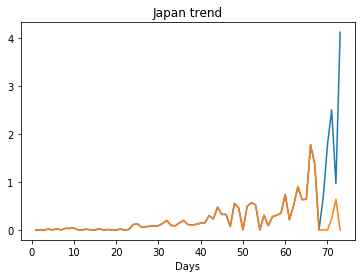

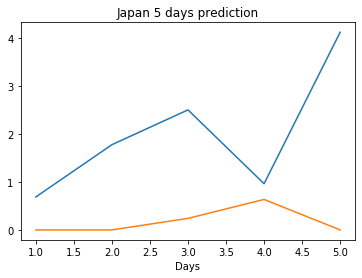

Creating directory ./offline8/Cambodia/training/
Cambodia
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0227
Saving the best model weights at Epoch [3], Best Valid Loss: 0.0220
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0190
train error: 0.18307836710433054
0.019007429480552673
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0299
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0234
Saving the best model weights at Epoch [4], Best Valid Loss: 0.0197
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0191
train error: 0.11871591879577009
0.019128087908029556
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0188
train error: 0.20745227631590696
0.01883288286626339
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0190
train error: 0.16193101333919913
0.01897246204316616
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0311
train error: 0.14641943339687935
0.0310718212276

Saving the best model weights at Epoch [13], Best Valid Loss: 0.0160
Saving the best model weights at Epoch [19], Best Valid Loss: 0.0146
train error: 0.19567246770373348
0.014586281962692738
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0399
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0293
train error: 0.20745227631590696
0.029335588216781616
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0251
Saving the best model weights at Epoch [2], Best Valid Loss: 0.0212
train error: 0.19783738311944585
0.021193714812397957
Saving the best model weights at Epoch [1], Best Valid Loss: 0.0130
Saving the best model weights at Epoch [6], Best Valid Loss: 0.0128


In [ ]:
# optimization grid
lr_list = [0.1,0.01,0.001,1e-4,1e-5,1e-6]
hidden_lst = [1,2,3,4,5]
hState_lst = [10,30,50,100]
momentumS = [0.1,0.5,0.9]
tloss = []
ntloss = []

country_result = dict()
#optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=0.9)
best_error = 1e10
country_file_path = ("./country_file8.txt")
for i in range(len(countries)):
    if i in skip_countries:
        continue # too little data 
        
    country_result[countries[i]] = [] # store best validation parameter, test loss, test result
    best_error = 1e10
    
    best_param = [0,0,0]

    learning_rate = lr_list[0] # to be changed/optimized 
    hidden_dim = hidden_lst[0]
    hidden_state = hState_lst[0]
    
    
    model_name = countries[i]
    output_file_path = "./offline8/" + model_name + "/training/"
    directory = os.path.dirname(output_file_path)
    if not os.path.exists(directory):
        print("Creating directory %s" % output_file_path)
        os.makedirs(directory)
    else:
         print("Directory %s exists" % output_file_path)

    print(countries[i])
    train_dataset = torch.utils.data.TensorDataset(torch.tensor(country_train_X[i]).unsqueeze_(2).unsqueeze_(2).float(), torch.tensor(country_train_Y[i]).unsqueeze_(1).float())
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)

    # load validation
    valid_dataset = torch.utils.data.TensorDataset(torch.tensor(country_valid_X[i]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).float(), torch.tensor(country_valid_Y[i]).unsqueeze_(0).float())
    valid_loader = torch.utils.data.DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=False)

    # load test
    test_dataset = torch.utils.data.TensorDataset(torch.tensor(country_test_X[i]).unsqueeze_(1).unsqueeze_(1).unsqueeze_(0).float(), torch.tensor(country_test_Y[i]).unsqueeze_(0).float())
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
    
    bestmodel = 0
    country_file = open(country_file_path,"a")
    # optimize (learning rate, hidden layer, hidden state, activation)
    for j in range(len(lr_list)):
        for k in range(len(hidden_lst)): # hidden layer
            for m in range(len(hState_lst)): # hidden state
                for s in range(len(momentumS)):
                # train
                # specific parameters
                    learning_rate = lr_list[j]
                    hidden_dim = hState_lst[m]
                    num_layers = hidden_lst[k]
                    momentum = momentumS[s]
                    #lstm_input_size = len()

                    net =  LSTM(lstm_input_size, hidden_dim, batch_size=batch_size, output_dim=output_dim, num_layers=num_layers)
                    #print(net)
                    model = net.to(device)

                    #
                    optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, momentum=momentum)
                    # to be changed/optimized 

                    model, err = train_model(train_loader, valid_loader, model, device, criterion,  optimizer, num_epochs, output_file_path,learning_rate,hidden_dim,num_layers,momentum)
                    print(err)
                    if err < best_error:
                        best_error = err
                        best_param = [lr_list[j],hidden_lst[k],hState_lst[m],momentum]
                        bestmodel = model
    
    country_result[countries[i]].append(best_param)
    
    # test data
    pred,final_loss = test_model(test_loader,bestmodel,device,criterion)
    print("test loss: ",final_loss)
    country_result[countries[i]].append([pred.tolist(),country_test_Y[i].tolist()])
    country_result[countries[i]].append(final_loss)
    torch.save(bestmodel.state_dict(), output_file_path+countries[i]+".th")
    
    tloss.append(final_loss)
    ntloss.append(final_loss/max(country_test_Y[i]))
    
    print("%s, %s, %s, %s" % (countries[i], pred.tolist(), final_loss,best_param), file=country_file)
                   
    country_file.close()
    graph_country(i,pred.tolist(),graph_dir)

In [ ]:
import json
with open("country_summary_8.js",'w+') as outfile:
    json.dump(country_result, outfile , sort_keys = True , indent = 4, separators = (",",": "))


In [ ]:
#country_test_Y[0]
sns.distplot(np.array(ntloss)); # normalized loss

In [ ]:
sns.distplot(np.array(tloss)); # not normalized loss